# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [ ]:
#copula_pv = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [ ]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_924873/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_924873/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_924873/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [ ]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [ ]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [ ]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.2, "tau_b": 0.7 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [8]:
output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/1000 [00:00<09:21,  1.78it/s]

[1/1000] train=40.9022  val=38.6140  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510parameters=Parameter containing:
tensor([ -9.9900,   1.6511,   1.6511,   1.6511,   1.6511,   1.6511,   1.6511,
          1.6511,   1.6511,   1.6411,   1.6411,   1.6411, -10.0100,   1.6311,
          1.6311,   1.6311,   1.6311,   1.6311,   1.6511,   1.6511,   1.6511,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=1.04


  0%|          | 2/1000 [00:00<07:40,  2.16it/s]

[2/1000] train=39.8224  val=38.1350  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520parameters=Parameter containing:
tensor([ -9.9947,   1.6463,   1.6462,   1.6463,   1.6465,   1.6522,   1.6600,
          1.6608,   1.6610,   1.6411,   1.6411,   1.6411, -10.0123,   1.6287,
          1.6288,   1.6287,   1.6289,   1.6338,   1.6604,   1.6610,   1.6611,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.686


  0%|          | 3/1000 [00:01<05:49,  2.86it/s]

[3/1000] train=40.8996  val=37.6643  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530parameters=Parameter containing:
tensor([-10.0011,   1.6399,   1.6398,   1.6399,   1.6402,   1.6516,   1.6691,
          1.6707,   1.6709,   1.6411,   1.6411,   1.6411, -10.0084,   1.6326,
          1.6327,   1.6326,   1.6329,   1.6403,   1.6700,   1.6710,   1.6711,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.5492


  0%|          | 4/1000 [00:01<04:55,  3.37it/s]

[4/1000] train=34.2182  val=37.1955  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541parameters=Parameter containing:
tensor([-10.0088,   1.6322,   1.6320,   1.6322,   1.6325,   1.6487,   1.6782,
          1.6805,   1.6809,   1.6411,   1.6411,   1.6411, -10.0041,   1.6369,
          1.6369,   1.6367,   1.6372,   1.6473,   1.6796,   1.6810,   1.6811,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.4791


  0%|          | 5/1000 [00:01<04:25,  3.74it/s]

[5/1000] train=39.1439  val=36.7280  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551parameters=Parameter containing:
tensor([-10.0152,   1.6258,   1.6256,   1.6258,   1.6262,   1.6484,   1.6876,
          1.6903,   1.6908,   1.6411,   1.6411,   1.6411, -10.0032,   1.6377,
          1.6378,   1.6376,   1.6382,   1.6519,   1.6888,   1.6909,   1.6911,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.4381


  1%|          | 6/1000 [00:01<04:07,  4.02it/s]

[6/1000] train=34.9822  val=36.2607  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562parameters=Parameter containing:
tensor([-10.0195,   1.6214,   1.6212,   1.6214,   1.6220,   1.6508,   1.6972,
          1.7003,   1.7008,   1.6411,   1.6411,   1.6411, -10.0046,   1.6362,
          1.6363,   1.6361,   1.6368,   1.6547,   1.6976,   1.7007,   1.7011,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.4123


  1%|          | 7/1000 [00:02<04:11,  3.94it/s]

[7/1000] train=37.2785  val=35.7940  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573parameters=Parameter containing:
tensor([-10.0244,   1.6165,   1.6162,   1.6164,   1.6172,   1.6530,   1.7068,
          1.7102,   1.7107,   1.6411,   1.6411,   1.6411, -10.0048,   1.6359,
          1.6361,   1.6358,   1.6367,   1.6587,   1.7068,   1.7105,   1.7110,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3952


  1%|          | 8/1000 [00:02<04:17,  3.86it/s]

[8/1000] train=36.0321  val=35.3267  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584parameters=Parameter containing:
tensor([-10.0256,   1.6153,   1.6150,   1.6152,   1.6161,   1.6579,   1.7166,
          1.7202,   1.7207,   1.6411,   1.6411,   1.6411, -10.0049,   1.6358,
          1.6360,   1.6358,   1.6367,   1.6630,   1.7160,   1.7204,   1.7210,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3835


  1%|          | 9/1000 [00:02<04:21,  3.80it/s]

[9/1000] train=34.4616  val=34.8593  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596parameters=Parameter containing:
tensor([-10.0244,   1.6164,   1.6161,   1.6163,   1.6174,   1.6641,   1.7265,
          1.7303,   1.7307,   1.6411,   1.6411,   1.6411, -10.0041,   1.6365,
          1.6366,   1.6365,   1.6375,   1.6681,   1.7254,   1.7303,   1.7310,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3754


  1%|          | 10/1000 [00:02<04:22,  3.76it/s]

[10/1000] train=34.9306  val=34.3920  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607parameters=Parameter containing:
tensor([-10.0217,   1.6191,   1.6187,   1.6189,   1.6201,   1.6713,   1.7366,
          1.7403,   1.7406,   1.6411,   1.6411,   1.6411, -10.0054,   1.6352,
          1.6353,   1.6352,   1.6363,   1.6714,   1.7343,   1.7400,   1.7409,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3697


  1%|          | 11/1000 [00:03<04:46,  3.46it/s]

[11/1000] train=33.1370  val=33.9256  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0619  σmin=0.0619  σmax=0.0619parameters=Parameter containing:
tensor([-10.0205,   1.6201,   1.6198,   1.6200,   1.6214,   1.6773,   1.7463,
          1.7502,   1.7504,   1.6411,   1.6411,   1.6411, -10.0079,   1.6326,
          1.6327,   1.6327,   1.6338,   1.6736,   1.7429,   1.7495,   1.7507,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3656


  1%|          | 12/1000 [00:03<05:02,  3.27it/s]

[12/1000] train=35.8879  val=33.4598  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0631  σmin=0.0631  σmax=0.0631parameters=Parameter containing:
tensor([-10.0207,   1.6199,   1.6196,   1.6199,   1.6213,   1.6824,   1.7557,
          1.7599,   1.7602,   1.6411,   1.6411,   1.6411, -10.0108,   1.6296,
          1.6297,   1.6297,   1.6310,   1.6755,   1.7515,   1.7590,   1.7605,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3626


  1%|▏         | 13/1000 [00:03<05:13,  3.15it/s]

[13/1000] train=34.3824  val=32.9946  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644parameters=Parameter containing:
tensor([-10.0219,   1.6186,   1.6182,   1.6186,   1.6201,   1.6866,   1.7649,
          1.7695,   1.7699,   1.6411,   1.6411,   1.6411, -10.0151,   1.6252,
          1.6253,   1.6254,   1.6267,   1.6758,   1.7595,   1.7683,   1.7702,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3605


  1%|▏         | 14/1000 [00:04<05:20,  3.08it/s]

[14/1000] train=34.2729  val=32.5301  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0656  σmin=0.0656  σmax=0.0656parameters=Parameter containing:
tensor([-10.0247,   1.6157,   1.6153,   1.6157,   1.6174,   1.6892,   1.7736,
          1.7789,   1.7795,   1.6411,   1.6411,   1.6411, -10.0190,   1.6213,
          1.6214,   1.6215,   1.6229,   1.6767,   1.7678,   1.7777,   1.7799,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.359


  2%|▏         | 15/1000 [00:04<05:19,  3.08it/s]

[15/1000] train=31.8511  val=32.0656  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669parameters=Parameter containing:
tensor([-10.0254,   1.6149,   1.6146,   1.6150,   1.6168,   1.6935,   1.7827,
          1.7885,   1.7892,   1.6411,   1.6411,   1.6411, -10.0205,   1.6197,
          1.6198,   1.6199,   1.6215,   1.6796,   1.7765,   1.7872,   1.7897,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3578


  2%|▏         | 16/1000 [00:04<05:01,  3.26it/s]

[16/1000] train=31.0182  val=31.6013  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0682  σmin=0.0682  σmax=0.0682parameters=Parameter containing:
tensor([-10.0254,   1.6148,   1.6144,   1.6150,   1.6169,   1.6984,   1.7919,
          1.7980,   1.7988,   1.6411,   1.6411,   1.6411, -10.0210,   1.6192,
          1.6192,   1.6193,   1.6210,   1.6834,   1.7854,   1.7967,   1.7994,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.357


  2%|▏         | 17/1000 [00:05<04:48,  3.41it/s]

[17/1000] train=33.5023  val=31.1375  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0695  σmin=0.0695  σmax=0.0695parameters=Parameter containing:
tensor([-10.0260,   1.6140,   1.6137,   1.6143,   1.6163,   1.7027,   1.8009,
          1.8074,   1.8084,   1.6411,   1.6411,   1.6411, -10.0218,   1.6183,
          1.6183,   1.6185,   1.6203,   1.6870,   1.7943,   1.8062,   1.8092,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3564


  2%|▏         | 18/1000 [00:05<04:39,  3.51it/s]

[18/1000] train=31.1527  val=30.6742  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0709  σmin=0.0709  σmax=0.0709parameters=Parameter containing:
tensor([-10.0271,   1.6129,   1.6126,   1.6132,   1.6154,   1.7069,   1.8097,
          1.8168,   1.8179,   1.6411,   1.6411,   1.6411, -10.0223,   1.6177,
          1.6176,   1.6178,   1.6197,   1.6909,   1.8032,   1.8157,   1.8189,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.356


  2%|▏         | 19/1000 [00:05<04:32,  3.60it/s]

[19/1000] train=30.7995  val=30.2115  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723parameters=Parameter containing:
tensor([-10.0292,   1.6106,   1.6104,   1.6110,   1.6133,   1.7099,   1.8181,
          1.8258,   1.8271,   1.6411,   1.6411,   1.6411, -10.0235,   1.6165,
          1.6163,   1.6166,   1.6186,   1.6943,   1.8119,   1.8250,   1.8285,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3557


  2%|▏         | 20/1000 [00:05<04:28,  3.65it/s]

[20/1000] train=30.6332  val=29.7494  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0737  σmin=0.0737  σmax=0.0737parameters=Parameter containing:
tensor([-10.0321,   1.6076,   1.6074,   1.6080,   1.6105,   1.7123,   1.8262,
          1.8346,   1.8364,   1.6411,   1.6411,   1.6411, -10.0249,   1.6151,
          1.6149,   1.6151,   1.6173,   1.6974,   1.8204,   1.8343,   1.8381,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3554


  2%|▏         | 21/1000 [00:06<05:00,  3.26it/s]

[21/1000] train=30.3502  val=29.2878  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0751  σmin=0.0751  σmax=0.0751parameters=Parameter containing:
tensor([-10.0350,   1.6046,   1.6044,   1.6050,   1.6076,   1.7146,   1.8343,
          1.8434,   1.8455,   1.6411,   1.6411,   1.6411, -10.0264,   1.6135,
          1.6132,   1.6135,   1.6158,   1.7004,   1.8289,   1.8434,   1.8476,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3553


  2%|▏         | 22/1000 [00:06<05:21,  3.04it/s]

[22/1000] train=29.5942  val=28.8268  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766parameters=Parameter containing:
tensor([-10.0383,   1.6011,   1.6009,   1.6016,   1.6044,   1.7166,   1.8421,
          1.8520,   1.8546,   1.6411,   1.6411,   1.6411, -10.0284,   1.6115,
          1.6112,   1.6114,   1.6139,   1.7031,   1.8371,   1.8524,   1.8571,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3551


  2%|▏         | 23/1000 [00:07<05:36,  2.90it/s]

[23/1000] train=27.9646  val=28.3662  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781parameters=Parameter containing:
tensor([-10.0411,   1.5982,   1.5980,   1.5987,   1.6016,   1.7191,   1.8501,
          1.8607,   1.8636,   1.6411,   1.6411,   1.6411, -10.0307,   1.6092,
          1.6088,   1.6090,   1.6117,   1.7056,   1.8453,   1.8613,   1.8665,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.355


  2%|▏         | 24/1000 [00:07<05:47,  2.81it/s]

[24/1000] train=29.7265  val=27.9060  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0796  σmin=0.0796  σmax=0.0796parameters=Parameter containing:
tensor([-10.0435,   1.5957,   1.5955,   1.5963,   1.5993,   1.7220,   1.8581,
          1.8693,   1.8726,   1.6411,   1.6411,   1.6411, -10.0315,   1.6083,
          1.6079,   1.6081,   1.6109,   1.7092,   1.8538,   1.8704,   1.8758,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.355


  2%|▎         | 25/1000 [00:07<05:54,  2.75it/s]

[25/1000] train=28.5015  val=27.4462  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0811parameters=Parameter containing:
tensor([-10.0457,   1.5934,   1.5932,   1.5940,   1.5971,   1.7252,   1.8661,
          1.8777,   1.8815,   1.6411,   1.6411,   1.6411, -10.0320,   1.6077,
          1.6073,   1.6075,   1.6104,   1.7132,   1.8623,   1.8794,   1.8852,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3549


  3%|▎         | 26/1000 [00:08<06:00,  2.70it/s]

[26/1000] train=27.1601  val=26.9864  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0827  σmin=0.0827  σmax=0.0827parameters=Parameter containing:
tensor([-10.0449,   1.5940,   1.5939,   1.5947,   1.5979,   1.7304,   1.8748,
          1.8865,   1.8905,   1.6411,   1.6411,   1.6411, -10.0338,   1.6058,
          1.6054,   1.6056,   1.6087,   1.7160,   1.8704,   1.8881,   1.8944,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3549


  3%|▎         | 27/1000 [00:08<06:04,  2.67it/s]

[27/1000] train=28.2303  val=26.5272  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0843  σmin=0.0843  σmax=0.0843parameters=Parameter containing:
tensor([-10.0439,   1.5949,   1.5948,   1.5956,   1.5989,   1.7358,   1.8834,
          1.8952,   1.8994,   1.6411,   1.6411,   1.6411, -10.0360,   1.6035,
          1.6031,   1.6032,   1.6064,   1.7183,   1.8782,   1.8967,   1.9036,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3549


  3%|▎         | 28/1000 [00:08<06:06,  2.65it/s]

[28/1000] train=27.4079  val=26.0685  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0859  σmin=0.0859  σmax=0.0859parameters=Parameter containing:
tensor([-10.0423,   1.5964,   1.5963,   1.5971,   1.6006,   1.7417,   1.8922,
          1.9039,   1.9083,   1.6411,   1.6411,   1.6411, -10.0386,   1.6008,
          1.6004,   1.6005,   1.6039,   1.7202,   1.8858,   1.9052,   1.9127,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  3%|▎         | 29/1000 [00:09<06:07,  2.64it/s]

[29/1000] train=26.3492  val=25.6105  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0875  σmin=0.0875  σmax=0.0876parameters=Parameter containing:
tensor([-10.0406,   1.5979,   1.5979,   1.5986,   1.6023,   1.7476,   1.9009,
          1.9125,   1.9171,   1.6411,   1.6411,   1.6411, -10.0412,   1.5981,
          1.5977,   1.5977,   1.6013,   1.7222,   1.8933,   1.9135,   1.9217,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  3%|▎         | 30/1000 [00:09<06:08,  2.63it/s]

[30/1000] train=25.6208  val=25.1532  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0892  σmin=0.0892  σmax=0.0892parameters=Parameter containing:
tensor([-10.0388,   1.5996,   1.5996,   1.6003,   1.6041,   1.7537,   1.9096,
          1.9210,   1.9259,   1.6411,   1.6411,   1.6411, -10.0437,   1.5955,
          1.5951,   1.5951,   1.5988,   1.7243,   1.9007,   1.9217,   1.9306,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  3%|▎         | 31/1000 [00:10<07:19,  2.20it/s]

[31/1000] train=24.9767  val=24.6967  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0909  σmin=0.0909  σmax=0.0910parameters=Parameter containing:
tensor([-10.0387,   1.5995,   1.5996,   1.6002,   1.6042,   1.7580,   1.9174,
          1.9291,   1.9344,   1.6411,   1.6411,   1.6411, -10.0464,   1.5927,
          1.5923,   1.5923,   1.5961,   1.7262,   1.9080,   1.9298,   1.9395,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  3%|▎         | 32/1000 [00:10<08:10,  1.98it/s]

[32/1000] train=24.8656  val=24.2408  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0927  σmin=0.0927  σmax=0.0927parameters=Parameter containing:
tensor([-10.0398,   1.5982,   1.5984,   1.5990,   1.6030,   1.7612,   1.9247,
          1.9369,   1.9428,   1.6411,   1.6411,   1.6411, -10.0490,   1.5900,
          1.5895,   1.5895,   1.5935,   1.7281,   1.9153,   1.9378,   1.9482,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  3%|▎         | 33/1000 [00:11<09:07,  1.77it/s]

[33/1000] train=24.1275  val=23.7856  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0945  σmin=0.0945  σmax=0.0945parameters=Parameter containing:
tensor([-10.0407,   1.5972,   1.5974,   1.5980,   1.6021,   1.7646,   1.9320,
          1.9445,   1.9511,   1.6411,   1.6411,   1.6411, -10.0514,   1.5875,
          1.5870,   1.5871,   1.5911,   1.7302,   1.9225,   1.9457,   1.9569,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  3%|▎         | 34/1000 [00:12<09:45,  1.65it/s]

[34/1000] train=24.2500  val=23.3309  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0963  σmin=0.0963  σmax=0.0963parameters=Parameter containing:
tensor([-10.0422,   1.5956,   1.5959,   1.5964,   1.6006,   1.7674,   1.9389,
          1.9519,   1.9592,   1.6411,   1.6411,   1.6411, -10.0530,   1.5858,
          1.5853,   1.5853,   1.5895,   1.7330,   1.9297,   1.9536,   1.9656,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▎         | 35/1000 [00:13<10:12,  1.57it/s]

[35/1000] train=24.0727  val=22.8769  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0981  σmin=0.0981  σmax=0.0981parameters=Parameter containing:
tensor([-10.0444,   1.5932,   1.5935,   1.5940,   1.5983,   1.7694,   1.9454,
          1.9591,   1.9671,   1.6411,   1.6411,   1.6411, -10.0549,   1.5836,
          1.5832,   1.5831,   1.5875,   1.7354,   1.9368,   1.9613,   1.9742,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▎         | 36/1000 [00:13<10:30,  1.53it/s]

[36/1000] train=23.1852  val=22.4235  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1000  σmin=0.1000  σmax=0.1000parameters=Parameter containing:
tensor([-10.0474,   1.5900,   1.5904,   1.5909,   1.5952,   1.7707,   1.9515,
          1.9660,   1.9750,   1.6411,   1.6411,   1.6411, -10.0553,   1.5831,
          1.5826,   1.5825,   1.5870,   1.7392,   1.9443,   1.9691,   1.9827,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▎         | 37/1000 [00:14<10:57,  1.47it/s]

[37/1000] train=22.3887  val=21.9705  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1019  σmin=0.1019  σmax=0.1019parameters=Parameter containing:
tensor([-10.0504,   1.5868,   1.5873,   1.5877,   1.5922,   1.7720,   1.9575,
          1.9728,   1.9827,   1.6411,   1.6411,   1.6411, -10.0547,   1.5835,
          1.5830,   1.5829,   1.5876,   1.7438,   1.9520,   1.9769,   1.9912,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 38/1000 [00:15<11:28,  1.40it/s]

[38/1000] train=22.1250  val=21.5184  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1038  σmin=0.1038  σmax=0.1038parameters=Parameter containing:
tensor([-10.0538,   1.5833,   1.5838,   1.5842,   1.5887,   1.7729,   1.9633,
          1.9795,   1.9903,   1.6411,   1.6411,   1.6411, -10.0538,   1.5841,
          1.5838,   1.5836,   1.5884,   1.7487,   1.9597,   1.9846,   1.9997,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 39/1000 [00:16<11:47,  1.36it/s]

[39/1000] train=22.0318  val=21.0671  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1058  σmin=0.1058  σmax=0.1058parameters=Parameter containing:
tensor([-10.0571,   1.5798,   1.5803,   1.5807,   1.5853,   1.7738,   1.9689,
          1.9860,   1.9978,   1.6411,   1.6411,   1.6411, -10.0535,   1.5842,
          1.5839,   1.5837,   1.5887,   1.7530,   1.9671,   1.9922,   2.0080,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 40/1000 [00:16<12:00,  1.33it/s]

[40/1000] train=21.5283  val=20.6164  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1078  σmin=0.1078  σmax=0.1078parameters=Parameter containing:
tensor([-10.0597,   1.5770,   1.5775,   1.5779,   1.5827,   1.7754,   1.9747,
          1.9924,   2.0053,   1.6411,   1.6411,   1.6411, -10.0520,   1.5854,
          1.5852,   1.5850,   1.5900,   1.7582,   1.9747,   1.9998,   2.0163,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 41/1000 [00:18<15:01,  1.06it/s]

[41/1000] train=21.0140  val=20.1665  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1099  σmin=0.1098  σmax=0.1099parameters=Parameter containing:
tensor([-10.0618,   1.5747,   1.5753,   1.5757,   1.5805,   1.7774,   1.9806,
          1.9988,   2.0127,   1.6411,   1.6411,   1.6411, -10.0519,   1.5852,
          1.5851,   1.5849,   1.5901,   1.7621,   1.9817,   2.0070,   2.0245,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 42/1000 [00:19<17:08,  1.07s/it]

[42/1000] train=20.7733  val=19.7172  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1119  σmin=0.1119  σmax=0.1120parameters=Parameter containing:
tensor([-10.0635,   1.5728,   1.5735,   1.5738,   1.5788,   1.7798,   1.9865,
          2.0051,   2.0200,   1.6411,   1.6411,   1.6411, -10.0520,   1.5848,
          1.5847,   1.5845,   1.5898,   1.7656,   1.9883,   2.0141,   2.0326,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 43/1000 [00:21<18:21,  1.15s/it]

[43/1000] train=20.1391  val=19.2686  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1141  σmin=0.1140  σmax=0.1141parameters=Parameter containing:
tensor([-10.0646,   1.5715,   1.5722,   1.5726,   1.5776,   1.7826,   1.9925,
          2.0114,   2.0272,   1.6411,   1.6411,   1.6411, -10.0536,   1.5829,
          1.5829,   1.5827,   1.5880,   1.7677,   1.9944,   2.0208,   2.0406,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 44/1000 [00:22<18:53,  1.19s/it]

[44/1000] train=19.8003  val=18.8208  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1162  σmin=0.1162  σmax=0.1162parameters=Parameter containing:
tensor([-10.0660,   1.5698,   1.5705,   1.5709,   1.5760,   1.7852,   1.9983,
          2.0175,   2.0344,   1.6411,   1.6411,   1.6411, -10.0555,   1.5808,
          1.5809,   1.5806,   1.5861,   1.7694,   2.0001,   2.0273,   2.0485,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  4%|▍         | 45/1000 [00:23<19:16,  1.21s/it]

[45/1000] train=18.9752  val=18.3740  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1184  σmin=0.1184  σmax=0.1184parameters=Parameter containing:
tensor([-10.0675,   1.5681,   1.5688,   1.5692,   1.5745,   1.7877,   2.0041,
          2.0235,   2.0414,   1.6411,   1.6411,   1.6411, -10.0586,   1.5774,
          1.5776,   1.5773,   1.5829,   1.7698,   2.0052,   2.0335,   2.0563,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▍         | 46/1000 [00:24<19:31,  1.23s/it]

[46/1000] train=19.0832  val=17.9281  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1206  σmin=0.1206  σmax=0.1206parameters=Parameter containing:
tensor([-10.0686,   1.5667,   1.5674,   1.5679,   1.5732,   1.7905,   2.0098,
          2.0294,   2.0484,   1.6411,   1.6411,   1.6411, -10.0629,   1.5729,
          1.5731,   1.5728,   1.5785,   1.7690,   2.0097,   2.0395,   2.0639,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▍         | 47/1000 [00:26<19:41,  1.24s/it]

[47/1000] train=17.7264  val=17.4833  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1229  σmin=0.1229  σmax=0.1229parameters=Parameter containing:
tensor([-10.0703,   1.5647,   1.5655,   1.5660,   1.5714,   1.7927,   2.0151,
          2.0351,   2.0552,   1.6411,   1.6411,   1.6411, -10.0674,   1.5681,
          1.5684,   1.5681,   1.5738,   1.7678,   2.0139,   2.0452,   2.0714,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▍         | 48/1000 [00:27<20:02,  1.26s/it]

[48/1000] train=18.4268  val=17.0399  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1252  σmin=0.1252  σmax=0.1252parameters=Parameter containing:
tensor([-10.0729,   1.5618,   1.5626,   1.5631,   1.5687,   1.7939,   2.0199,
          2.0404,   2.0618,   1.6411,   1.6411,   1.6411, -10.0720,   1.5632,
          1.5636,   1.5632,   1.5690,   1.7665,   2.0179,   2.0508,   2.0789,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▍         | 49/1000 [00:28<20:05,  1.27s/it]

[49/1000] train=17.3349  val=16.5975  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1275  σmin=0.1275  σmax=0.1276parameters=Parameter containing:
tensor([-10.0758,   1.5587,   1.5595,   1.5600,   1.5656,   1.7949,   2.0245,
          2.0456,   2.0684,   1.6411,   1.6411,   1.6411, -10.0760,   1.5590,
          1.5594,   1.5590,   1.5649,   1.7658,   2.0221,   2.0563,   2.0863,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▌         | 50/1000 [00:29<20:03,  1.27s/it]

[50/1000] train=16.9745  val=16.1553  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1299  σmin=0.1299  σmax=0.1300parameters=Parameter containing:
tensor([-10.0778,   1.5564,   1.5572,   1.5577,   1.5635,   1.7967,   2.0293,
          2.0507,   2.0749,   1.6411,   1.6411,   1.6411, -10.0784,   1.5562,
          1.5566,   1.5562,   1.5622,   1.7665,   2.0268,   2.0620,   2.0938,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▌         | 51/1000 [00:31<20:06,  1.27s/it]

[51/1000] train=16.5440  val=15.7132  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1323  σmin=0.1323  σmax=0.1324parameters=Parameter containing:
tensor([-10.0794,   1.5545,   1.5552,   1.5558,   1.5617,   1.7987,   2.0341,
          2.0557,   2.0812,   1.6411,   1.6411,   1.6411, -10.0783,   1.5559,
          1.5564,   1.5560,   1.5621,   1.7695,   2.0324,   2.0680,   2.1013,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▌         | 52/1000 [00:32<20:06,  1.27s/it]

[52/1000] train=16.0895  val=15.2714  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1348  σmin=0.1348  σmax=0.1348parameters=Parameter containing:
tensor([-10.0800,   1.5535,   1.5542,   1.5548,   1.5608,   1.8016,   2.0391,
          2.0607,   2.0876,   1.6411,   1.6411,   1.6411, -10.0781,   1.5558,
          1.5564,   1.5559,   1.5621,   1.7726,   2.0379,   2.0739,   2.1088,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▌         | 53/1000 [00:33<20:03,  1.27s/it]

[53/1000] train=15.1968  val=14.8305  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1373  σmin=0.1373  σmax=0.1374parameters=Parameter containing:
tensor([-10.0810,   1.5521,   1.5529,   1.5535,   1.5596,   1.8042,   2.0439,
          2.0655,   2.0938,   1.6411,   1.6411,   1.6411, -10.0768,   1.5567,
          1.5573,   1.5567,   1.5631,   1.7766,   2.0438,   2.0799,   2.1162,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  5%|▌         | 54/1000 [00:35<20:00,  1.27s/it]

[54/1000] train=14.9963  val=14.3897  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1399  σmin=0.1398  σmax=0.1399parameters=Parameter containing:
tensor([-10.0807,   1.5521,   1.5529,   1.5535,   1.5597,   1.8079,   2.0491,
          2.0705,   2.1000,   1.6411,   1.6411,   1.6411, -10.0746,   1.5586,
          1.5593,   1.5586,   1.5651,   1.7814,   2.0500,   2.0860,   2.1237,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 55/1000 [00:36<19:59,  1.27s/it]

[55/1000] train=15.2839  val=13.9500  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1424  σmin=0.1424  σmax=0.1425parameters=Parameter containing:
tensor([-10.0800,   1.5524,   1.5532,   1.5538,   1.5601,   1.8119,   2.0543,
          2.0753,   2.1062,   1.6411,   1.6411,   1.6411, -10.0731,   1.5596,
          1.5603,   1.5596,   1.5663,   1.7854,   2.0557,   2.0917,   2.1310,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 56/1000 [00:37<20:04,  1.28s/it]

[56/1000] train=14.1941  val=13.5110  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1451  σmin=0.1450  σmax=0.1451parameters=Parameter containing:
tensor([-10.0787,   1.5534,   1.5541,   1.5547,   1.5611,   1.8163,   2.0597,
          2.0802,   2.1123,   1.6411,   1.6411,   1.6411, -10.0719,   1.5604,
          1.5612,   1.5604,   1.5672,   1.7892,   2.0611,   2.0973,   2.1382,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 57/1000 [00:38<20:03,  1.28s/it]

[57/1000] train=14.2732  val=13.0733  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1478  σmin=0.1477  σmax=0.1478parameters=Parameter containing:
tensor([-10.0776,   1.5542,   1.5548,   1.5554,   1.5619,   1.8206,   2.0648,
          2.0848,   2.1183,   1.6411,   1.6411,   1.6411, -10.0713,   1.5605,
          1.5614,   1.5606,   1.5676,   1.7923,   2.0661,   2.1026,   2.1453,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 58/1000 [00:40<20:15,  1.29s/it]

[58/1000] train=13.0680  val=12.6367  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1505  σmin=0.1504  σmax=0.1505parameters=Parameter containing:
tensor([-10.0773,   1.5541,   1.5546,   1.5553,   1.5619,   1.8241,   2.0695,
          2.0892,   2.1241,   1.6411,   1.6411,   1.6411, -10.0700,   1.5614,
          1.5623,   1.5615,   1.5686,   1.7961,   2.0714,   2.1080,   2.1524,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 59/1000 [00:41<20:43,  1.32s/it]

[59/1000] train=13.1133  val=12.2013  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1532  σmin=0.1531  σmax=0.1533parameters=Parameter containing:
tensor([-10.0777,   1.5533,   1.5537,   1.5545,   1.5612,   1.8268,   2.0738,
          2.0934,   2.1298,   1.6411,   1.6411,   1.6411, -10.0684,   1.5626,
          1.5635,   1.5627,   1.5700,   1.8001,   2.0767,   2.1133,   2.1594,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 60/1000 [00:42<21:01,  1.34s/it]

[60/1000] train=12.8816  val=11.7668  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1560  σmin=0.1559  σmax=0.1561parameters=Parameter containing:
tensor([-10.0774,   1.5532,   1.5535,   1.5544,   1.5611,   1.8301,   2.0782,
          2.0974,   2.1355,   1.6411,   1.6411,   1.6411, -10.0678,   1.5626,
          1.5636,   1.5629,   1.5702,   1.8030,   2.0814,   2.1183,   2.1663,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 61/1000 [00:44<21:12,  1.36s/it]

[61/1000] train=12.1810  val=11.3337  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1589  σmin=0.1588  σmax=0.1590parameters=Parameter containing:
tensor([-10.0777,   1.5525,   1.5527,   1.5536,   1.5604,   1.8328,   2.0821,
          2.1012,   2.1410,   1.6411,   1.6411,   1.6411, -10.0694,   1.5606,
          1.5615,   1.5609,   1.5683,   1.8037,   2.0850,   2.1228,   2.1730,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▌         | 62/1000 [00:45<20:22,  1.30s/it]

[62/1000] train=12.2999  val=10.9011  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1618  σmin=0.1617  σmax=0.1619parameters=Parameter containing:
tensor([-10.0764,   1.5533,   1.5534,   1.5545,   1.5613,   1.8369,   2.0867,
          2.1052,   2.1466,   1.6411,   1.6411,   1.6411, -10.0709,   1.5587,
          1.5596,   1.5590,   1.5665,   1.8045,   2.0885,   2.1273,   2.1797,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▋         | 63/1000 [00:46<20:11,  1.29s/it]

[63/1000] train=11.3388  val=10.4700  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1647  σmin=0.1646  σmax=0.1648parameters=Parameter containing:
tensor([-10.0763,   1.5530,   1.5529,   1.5542,   1.5611,   1.8398,   2.0906,
          2.1089,   2.1520,   1.6411,   1.6411,   1.6411, -10.0727,   1.5564,
          1.5573,   1.5568,   1.5643,   1.8048,   2.0916,   2.1314,   2.1863,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▋         | 64/1000 [00:48<20:06,  1.29s/it]

[64/1000] train=10.3515  val=10.0399  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1677  σmin=0.1676  σmax=0.1678parameters=Parameter containing:
tensor([-10.0761,   1.5527,   1.5525,   1.5539,   1.5609,   1.8427,   2.0945,
          2.1124,   2.1573,   1.6411,   1.6411,   1.6411, -10.0740,   1.5548,
          1.5556,   1.5551,   1.5628,   1.8058,   2.0949,   2.1356,   2.1928,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  6%|▋         | 65/1000 [00:49<20:13,  1.30s/it]

[65/1000] train=10.0252  val=9.6110  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1708  σmin=0.1706  σmax=0.1709parameters=Parameter containing:
tensor([-10.0763,   1.5520,   1.5518,   1.5533,   1.5603,   1.8454,   2.0980,
          2.1157,   2.1625,   1.6411,   1.6411,   1.6411, -10.0753,   1.5529,
          1.5537,   1.5534,   1.5611,   1.8066,   2.0982,   2.1397,   2.1993,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 66/1000 [00:50<20:39,  1.33s/it]

[66/1000] train=10.3053  val=9.1831  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1739  σmin=0.1737  σmax=0.1740parameters=Parameter containing:
tensor([-10.0767,   1.5510,   1.5507,   1.5524,   1.5595,   1.8476,   2.1013,
          2.1187,   2.1675,   1.6411,   1.6411,   1.6411, -10.0762,   1.5515,
          1.5523,   1.5519,   1.5598,   1.8077,   2.1016,   2.1438,   2.2058,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 67/1000 [00:52<20:40,  1.33s/it]

[67/1000] train=9.6972  val=8.7569  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1770  σmin=0.1768  σmax=0.1771parameters=Parameter containing:
tensor([-10.0786,   1.5487,   1.5482,   1.5501,   1.5573,   1.8485,   2.1037,
          2.1213,   2.1723,   1.6411,   1.6411,   1.6411, -10.0775,   1.5498,
          1.5505,   1.5502,   1.5582,   1.8086,   2.1047,   2.1477,   2.2122,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 68/1000 [00:53<20:22,  1.31s/it]

[68/1000] train=8.5736  val=8.3322  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1802  σmin=0.1800  σmax=0.1803parameters=Parameter containing:
tensor([-10.0812,   1.5457,   1.5449,   1.5469,   1.5543,   1.8485,   2.1058,
          2.1237,   2.1771,   1.6411,   1.6411,   1.6411, -10.0787,   1.5480,
          1.5487,   1.5484,   1.5565,   1.8093,   2.1076,   2.1515,   2.2185,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 69/1000 [00:54<20:08,  1.30s/it]

[69/1000] train=9.3485  val=7.9085  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1834  σmin=0.1832  σmax=0.1835parameters=Parameter containing:
tensor([-10.0839,   1.5425,   1.5416,   1.5437,   1.5512,   1.8485,   2.1077,
          2.1259,   2.1817,   1.6411,   1.6411,   1.6411, -10.0786,   1.5477,
          1.5482,   1.5479,   1.5561,   1.8114,   2.1110,   2.1554,   2.2248,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 70/1000 [00:55<19:58,  1.29s/it]

[70/1000] train=7.9990  val=7.4868  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1867  σmin=0.1864  σmax=0.1868parameters=Parameter containing:
tensor([-10.0872,   1.5388,   1.5377,   1.5399,   1.5476,   1.8478,   2.1091,
          2.1279,   2.1862,   1.6411,   1.6411,   1.6411, -10.0804,   1.5454,
          1.5458,   1.5454,   1.5537,   1.8114,   2.1133,   2.1587,   2.2309,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 71/1000 [00:57<19:50,  1.28s/it]

[71/1000] train=7.6707  val=7.0665  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1900  σmin=0.1897  σmax=0.1902parameters=Parameter containing:
tensor([-10.0895,   1.5360,   1.5348,   1.5371,   1.5449,   1.8480,   2.1109,
          2.1298,   2.1906,   1.6411,   1.6411,   1.6411, -10.0840,   1.5413,
          1.5417,   1.5413,   1.5496,   1.8095,   2.1146,   2.1616,   2.2369,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 72/1000 [00:58<19:44,  1.28s/it]

[72/1000] train=7.1497  val=6.6472  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1934  σmin=0.1931  σmax=0.1936parameters=Parameter containing:
tensor([-10.0909,   1.5339,   1.5326,   1.5351,   1.5430,   1.8489,   2.1129,
          2.1318,   2.1950,   1.6411,   1.6411,   1.6411, -10.0877,   1.5371,
          1.5373,   1.5370,   1.5454,   1.8074,   2.1157,   2.1644,   2.2428,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 73/1000 [00:59<19:41,  1.27s/it]

[73/1000] train=7.7663  val=6.2276  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1968  σmin=0.1965  σmax=0.1970parameters=Parameter containing:
tensor([-10.0904,   1.5338,   1.5325,   1.5350,   1.5431,   1.8517,   2.1159,
          2.1342,   2.1994,   1.6411,   1.6411,   1.6411, -10.0893,   1.5349,
          1.5350,   1.5347,   1.5432,   1.8073,   2.1178,   2.1674,   2.2488,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  7%|▋         | 74/1000 [01:01<19:38,  1.27s/it]

[74/1000] train=7.3066  val=5.8086  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2003  σmin=0.2000  σmax=0.2005parameters=Parameter containing:
tensor([-10.0888,   1.5346,   1.5332,   1.5359,   1.5441,   1.8555,   2.1194,
          2.1367,   2.2040,   1.6411,   1.6411,   1.6411, -10.0907,   1.5329,
          1.5329,   1.5326,   1.5412,   1.8075,   2.1199,   2.1705,   2.2548,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 75/1000 [01:02<19:50,  1.29s/it]

[75/1000] train=5.6603  val=5.3896  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2039  σmin=0.2035  σmax=0.2041parameters=Parameter containing:
tensor([-10.0856,   1.5370,   1.5356,   1.5384,   1.5467,   1.8606,   2.1234,
          2.1395,   2.2088,   1.6411,   1.6411,   1.6411, -10.0905,   1.5324,
          1.5322,   1.5322,   1.5408,   1.8091,   2.1227,   2.1737,   2.2608,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 76/1000 [01:03<20:16,  1.32s/it]

[76/1000] train=5.4354  val=4.9720  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2075  σmin=0.2070  σmax=0.2077parameters=Parameter containing:
tensor([-10.0837,   1.5382,   1.5368,   1.5395,   1.5481,   1.8647,   2.1269,
          2.1421,   2.2134,   1.6411,   1.6411,   1.6411, -10.0885,   1.5337,
          1.5333,   1.5334,   1.5420,   1.8123,   2.1261,   2.1771,   2.2667,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 77/1000 [01:05<20:39,  1.34s/it]

[77/1000] train=5.8968  val=4.5551  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2111  σmin=0.2106  σmax=0.2113parameters=Parameter containing:
tensor([-10.0806,   1.5403,   1.5390,   1.5417,   1.5504,   1.8696,   2.1308,
          2.1447,   2.2180,   1.6411,   1.6411,   1.6411, -10.0862,   1.5353,
          1.5347,   1.5349,   1.5436,   1.8158,   2.1297,   2.1805,   2.2727,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 78/1000 [01:06<20:50,  1.36s/it]

[78/1000] train=4.6293  val=4.1398  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2148  σmin=0.2143  σmax=0.2150parameters=Parameter containing:
tensor([-10.0779,   1.5421,   1.5408,   1.5436,   1.5524,   1.8743,   2.1345,
          2.1473,   2.2226,   1.6411,   1.6411,   1.6411, -10.0833,   1.5373,
          1.5366,   1.5369,   1.5457,   1.8198,   2.1335,   2.1839,   2.2787,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 79/1000 [01:07<20:57,  1.37s/it]

[79/1000] train=4.7584  val=3.7263  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2185  σmin=0.2180  σmax=0.2188parameters=Parameter containing:
tensor([-10.0767,   1.5423,   1.5409,   1.5439,   1.5528,   1.8774,   2.1374,
          2.1494,   2.2270,   1.6411,   1.6411,   1.6411, -10.0794,   1.5404,
          1.5396,   1.5399,   1.5489,   1.8247,   2.1377,   2.1875,   2.2846,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 80/1000 [01:09<21:02,  1.37s/it]

[80/1000] train=4.2880  val=3.3148  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2223  σmin=0.2218  σmax=0.2226parameters=Parameter containing:
tensor([-10.0762,   1.5418,   1.5404,   1.5436,   1.5524,   1.8797,   2.1397,
          2.1512,   2.2312,   1.6411,   1.6411,   1.6411, -10.0766,   1.5423,
          1.5414,   1.5418,   1.5509,   1.8284,   2.1412,   2.1907,   2.2904,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 81/1000 [01:10<21:04,  1.38s/it]

[81/1000] train=3.6882  val=2.9054  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2262  σmin=0.2256  σmax=0.2265parameters=Parameter containing:
tensor([-10.0775,   1.5395,   1.5380,   1.5414,   1.5502,   1.8803,   2.1409,
          2.1523,   2.2352,   1.6411,   1.6411,   1.6411, -10.0736,   1.5444,
          1.5435,   1.5438,   1.5532,   1.8324,   2.1447,   2.1938,   2.2962,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 82/1000 [01:12<21:05,  1.38s/it]

[82/1000] train=2.8922  val=2.4973  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2301  σmin=0.2295  σmax=0.2305parameters=Parameter containing:
tensor([-10.0778,   1.5382,   1.5363,   1.5402,   1.5489,   1.8817,   2.1425,
          2.1536,   2.2391,   1.6411,   1.6411,   1.6411, -10.0714,   1.5456,
          1.5446,   1.5449,   1.5545,   1.8355,   2.1476,   2.1967,   2.3019,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 83/1000 [01:13<21:57,  1.44s/it]

[83/1000] train=3.0020  val=2.0914  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2341  σmin=0.2334  σmax=0.2344parameters=Parameter containing:
tensor([-10.0796,   1.5354,   1.5333,   1.5374,   1.5461,   1.8816,   2.1433,
          2.1545,   2.2429,   1.6411,   1.6411,   1.6411, -10.0703,   1.5458,
          1.5448,   1.5449,   1.5548,   1.8374,   2.1499,   2.1992,   2.3075,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 84/1000 [01:14<21:28,  1.41s/it]

[84/1000] train=1.8052  val=1.6871  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2381  σmin=0.2374  σmax=0.2385parameters=Parameter containing:
tensor([-10.0814,   1.5325,   1.5304,   1.5347,   1.5433,   1.8815,   2.1440,
          2.1552,   2.2467,   1.6411,   1.6411,   1.6411, -10.0711,   1.5440,
          1.5432,   1.5431,   1.5532,   1.8375,   2.1513,   2.2013,   2.3130,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  8%|▊         | 85/1000 [01:16<20:48,  1.36s/it]

[85/1000] train=2.1931  val=1.2851  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2422  σmin=0.2415  σmax=0.2426parameters=Parameter containing:
tensor([-10.0839,   1.5288,   1.5266,   1.5311,   1.5398,   1.8805,   2.1441,
          2.1557,   2.2503,   1.6411,   1.6411,   1.6411, -10.0733,   1.5407,
          1.5400,   1.5397,   1.5500,   1.8360,   2.1516,   2.2029,   2.3183,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▊         | 86/1000 [01:17<20:19,  1.33s/it]

[86/1000] train=1.9900  val=0.8852  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2463  σmin=0.2456  σmax=0.2468parameters=Parameter containing:
tensor([-10.0869,   1.5248,   1.5225,   1.5271,   1.5359,   1.8791,   2.1438,
          2.1559,   2.2538,   1.6411,   1.6411,   1.6411, -10.0763,   1.5367,
          1.5359,   1.5356,   1.5461,   1.8338,   2.1513,   2.2042,   2.3234,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▊         | 87/1000 [01:18<20:00,  1.31s/it]

[87/1000] train=0.7398  val=0.4870  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2505  σmin=0.2498  σmax=0.2510parameters=Parameter containing:
tensor([-10.0899,   1.5205,   1.5181,   1.5230,   1.5319,   1.8777,   2.1434,
          2.1559,   2.2571,   1.6411,   1.6411,   1.6411, -10.0782,   1.5336,
          1.5330,   1.5326,   1.5433,   1.8325,   2.1516,   2.2057,   2.3286,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 88/1000 [01:20<19:45,  1.30s/it]

[88/1000] train=0.7767  val=0.0887  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2548  σmin=0.2540  σmax=0.2553parameters=Parameter containing:
tensor([-10.0907,   1.5186,   1.5159,   1.5210,   1.5301,   1.8783,   2.1441,
          2.1563,   2.2606,   1.6411,   1.6411,   1.6411, -10.0791,   1.5315,
          1.5309,   1.5306,   1.5413,   1.8322,   2.1523,   2.2072,   2.3338,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 89/1000 [01:21<19:35,  1.29s/it]

[89/1000] train=0.2177  val=-0.3081  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2591  σmin=0.2582  σmax=0.2596parameters=Parameter containing:
tensor([-10.0911,   1.5171,   1.5141,   1.5192,   1.5287,   1.8793,   2.1450,
          2.1568,   2.2641,   1.6411,   1.6411,   1.6411, -10.0808,   1.5286,
          1.5281,   1.5277,   1.5386,   1.8310,   2.1526,   2.2087,   2.3390,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 90/1000 [01:22<19:27,  1.28s/it]

[90/1000] train=-0.4903  val=-0.7036  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2634  σmin=0.2626  σmax=0.2640parameters=Parameter containing:
tensor([-10.0899,   1.5171,   1.5139,   1.5190,   1.5287,   1.8817,   2.1466,
          2.1576,   2.2677,   1.6411,   1.6411,   1.6411, -10.0846,   1.5236,
          1.5233,   1.5227,   1.5337,   1.8277,   2.1516,   2.2096,   2.3439,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 91/1000 [01:23<19:22,  1.28s/it]

[91/1000] train=-0.4751  val=-1.0969  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2679  σmin=0.2669  σmax=0.2685parameters=Parameter containing:
tensor([-10.0899,   1.5159,   1.5124,   1.5176,   1.5275,   1.8828,   2.1474,
          2.1580,   2.2711,   1.6411,   1.6411,   1.6411, -10.0872,   1.5196,
          1.5196,   1.5190,   1.5300,   1.8256,   2.1514,   2.2107,   2.3489,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 92/1000 [01:25<19:19,  1.28s/it]

[92/1000] train=-0.5153  val=-1.4890  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2723  σmin=0.2714  σmax=0.2730parameters=Parameter containing:
tensor([-10.0903,   1.5143,   1.5104,   1.5157,   1.5259,   1.8836,   2.1479,
          2.1582,   2.2744,   1.6411,   1.6411,   1.6411, -10.0879,   1.5175,
          1.5177,   1.5170,   1.5280,   1.8254,   2.1520,   2.2120,   2.3539,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 93/1000 [01:26<19:15,  1.27s/it]

[93/1000] train=-1.1044  val=-1.8799  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2769  σmin=0.2758  σmax=0.2776parameters=Parameter containing:
tensor([-10.0905,   1.5127,   1.5084,   1.5140,   1.5243,   1.8844,   2.1483,
          2.1583,   2.2777,   1.6411,   1.6411,   1.6411, -10.0877,   1.5162,
          1.5167,   1.5160,   1.5269,   1.8260,   2.1531,   2.2135,   2.3589,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


  9%|▉         | 94/1000 [01:27<19:25,  1.29s/it]

[94/1000] train=-2.1451  val=-2.2685  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2815  σmin=0.2804  σmax=0.2822parameters=Parameter containing:
tensor([-10.0915,   1.5102,   1.5056,   1.5115,   1.5222,   1.8845,   2.1484,
          2.1582,   2.2808,   1.6411,   1.6411,   1.6411, -10.0877,   1.5148,
          1.5153,   1.5148,   1.5257,   1.8264,   2.1541,   2.2149,   2.3640,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|▉         | 95/1000 [01:29<19:37,  1.30s/it]

[95/1000] train=-2.0306  val=-2.6536  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2861  σmin=0.2850  σmax=0.2869parameters=Parameter containing:
tensor([-10.0941,   1.5060,   1.5012,   1.5073,   1.5184,   1.8829,   2.1472,
          2.1573,   2.2836,   1.6411,   1.6411,   1.6411, -10.0883,   1.5127,
          1.5132,   1.5129,   1.5237,   1.8260,   2.1544,   2.2160,   2.3688,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|▉         | 96/1000 [01:30<19:41,  1.31s/it]

[96/1000] train=-2.4140  val=-3.0386  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2909  σmin=0.2896  σmax=0.2917parameters=Parameter containing:
tensor([-10.0948,   1.5038,   1.4988,   1.5049,   1.5167,   1.8832,   2.1471,
          2.1569,   2.2865,   1.6411,   1.6411,   1.6411, -10.0891,   1.5105,
          1.5110,   1.5108,   1.5216,   1.8255,   2.1545,   2.2169,   2.3737,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|▉         | 97/1000 [01:31<20:01,  1.33s/it]

[97/1000] train=-3.0662  val=-3.4210  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2956  σmin=0.2943  σmax=0.2965parameters=Parameter containing:
tensor([-10.0956,   1.5013,   1.4960,   1.5023,   1.5145,   1.8831,   2.1467,
          2.1563,   2.2894,   1.6411,   1.6411,   1.6411, -10.0907,   1.5073,
          1.5078,   1.5079,   1.5187,   1.8239,   2.1540,   2.2174,   2.3784,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|▉         | 98/1000 [01:33<20:16,  1.35s/it]

[98/1000] train=-2.6894  val=-3.8027  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3005  σmin=0.2991  σmax=0.3014parameters=Parameter containing:
tensor([-10.0953,   1.4998,   1.4945,   1.5007,   1.5134,   1.8842,   2.1470,
          2.1561,   2.2925,   1.6411,   1.6411,   1.6411, -10.0923,   1.5040,
          1.5046,   1.5049,   1.5157,   1.8223,   2.1533,   2.2179,   2.3830,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|▉         | 99/1000 [01:34<20:27,  1.36s/it]

[99/1000] train=-4.0246  val=-4.1841  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3054  σmin=0.3039  σmax=0.3063parameters=Parameter containing:
tensor([-10.0924,   1.5006,   1.4955,   1.5016,   1.5147,   1.8878,   2.1486,
          2.1563,   2.2956,   1.6411,   1.6411,   1.6411, -10.0952,   1.4994,
          1.5000,   1.5006,   1.5113,   1.8193,   2.1518,   2.2179,   2.3876,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|█         | 100/1000 [01:35<20:20,  1.36s/it]

[100/1000] train=-4.2563  val=-4.5667  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3103  σmin=0.3088  σmax=0.3113parameters=Parameter containing:
tensor([-10.0879,   1.5032,   1.4982,   1.5042,   1.5177,   1.8928,   2.1511,
          2.1570,   2.2990,   1.6411,   1.6411,   1.6411, -10.0957,   1.4972,
          1.4978,   1.4984,   1.5092,   1.8187,   2.1518,   2.2186,   2.3924,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|█         | 101/1000 [01:37<20:08,  1.34s/it]

[101/1000] train=-4.2904  val=-4.9500  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3153  σmin=0.3137  σmax=0.3164parameters=Parameter containing:
tensor([-10.0828,   1.5063,   1.5014,   1.5074,   1.5212,   1.8984,   2.1539,
          2.1578,   2.3024,   1.6411,   1.6411,   1.6411, -10.0927,   1.4983,
          1.4991,   1.4996,   1.5106,   1.8215,   2.1539,   2.2203,   2.3975,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|█         | 102/1000 [01:38<20:06,  1.34s/it]

[102/1000] train=-4.4283  val=-5.3314  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3204  σmin=0.3187  σmax=0.3215parameters=Parameter containing:
tensor([-10.0780,   1.5089,   1.5043,   1.5103,   1.5244,   1.9037,   2.1564,
          2.1584,   2.3057,   1.6411,   1.6411,   1.6411, -10.0893,   1.4999,
          1.5007,   1.5011,   1.5124,   1.8247,   2.1563,   2.2221,   2.4027,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|█         | 103/1000 [01:39<19:44,  1.32s/it]

[103/1000] train=-4.8875  val=-5.7123  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3255  σmin=0.3238  σmax=0.3267parameters=Parameter containing:
tensor([-10.0722,   1.5125,   1.5082,   1.5139,   1.5286,   1.9099,   2.1596,
          2.1594,   2.3092,   1.6411,   1.6411,   1.6411, -10.0845,   1.5028,
          1.5038,   1.5040,   1.5154,   1.8290,   2.1594,   2.2241,   2.4079,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|█         | 104/1000 [01:41<19:42,  1.32s/it]

[104/1000] train=-5.2095  val=-6.0915  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3307  σmin=0.3289  σmax=0.3320parameters=Parameter containing:
tensor([-10.0668,   1.5155,   1.5117,   1.5171,   1.5322,   1.9156,   2.1628,
          2.1605,   2.3127,   1.6411,   1.6411,   1.6411, -10.0781,   1.5074,
          1.5087,   1.5087,   1.5202,   1.8351,   2.1636,   2.2266,   2.4133,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 10%|█         | 105/1000 [01:42<19:45,  1.33s/it]

[105/1000] train=-5.5662  val=-6.4664  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3360  σmin=0.3340  σmax=0.3373parameters=Parameter containing:
tensor([-10.0644,   1.5157,   1.5121,   1.5173,   1.5329,   1.9184,   2.1643,
          2.1608,   2.3161,   1.6411,   1.6411,   1.6411, -10.0714,   1.5120,
          1.5137,   1.5137,   1.5252,   1.8415,   2.1680,   2.2293,   2.4187,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 106/1000 [01:43<19:29,  1.31s/it]

[106/1000] train=-6.3881  val=-6.8356  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3413  σmin=0.3392  σmax=0.3427parameters=Parameter containing:
tensor([-10.0651,   1.5126,   1.5095,   1.5145,   1.5306,   1.9181,   2.1641,
          2.1604,   2.3191,   1.6411,   1.6411,   1.6411, -10.0682,   1.5130,
          1.5152,   1.5148,   1.5267,   1.8444,   2.1703,   2.2310,   2.4238,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 107/1000 [01:44<19:16,  1.30s/it]

[107/1000] train=-6.7580  val=-7.2028  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3467  σmin=0.3444  σmax=0.3482parameters=Parameter containing:
tensor([-10.0657,   1.5096,   1.5069,   1.5116,   1.5280,   1.9176,   2.1637,
          2.1600,   2.3221,   1.6411,   1.6411,   1.6411, -10.0642,   1.5147,
          1.5174,   1.5168,   1.5291,   1.8482,   2.1732,   2.2331,   2.4290,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 108/1000 [01:46<19:08,  1.29s/it]

[108/1000] train=-7.2310  val=-7.5657  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3521  σmin=0.3497  σmax=0.3537parameters=Parameter containing:
tensor([-10.0688,   1.5042,   1.5019,   1.5064,   1.5231,   1.9147,   2.1617,
          2.1587,   2.3246,   1.6411,   1.6411,   1.6411, -10.0613,   1.5150,
          1.5186,   1.5176,   1.5301,   1.8508,   2.1752,   2.2348,   2.4341,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 109/1000 [01:47<19:02,  1.28s/it]

[109/1000] train=-7.1143  val=-7.9270  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3576  σmin=0.3551  σmax=0.3593parameters=Parameter containing:
tensor([-10.0714,   1.4994,   1.4975,   1.5016,   1.5185,   1.9123,   2.1602,
          2.1577,   2.3273,   1.6411,   1.6411,   1.6411, -10.0580,   1.5158,
          1.5200,   1.5188,   1.5314,   1.8538,   2.1772,   2.2365,   2.4393,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 110/1000 [01:48<18:57,  1.28s/it]

[110/1000] train=-7.1521  val=-8.2839  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3632  σmin=0.3605  σmax=0.3649parameters=Parameter containing:
tensor([-10.0754,   1.4931,   1.4915,   1.4954,   1.5125,   1.9083,   2.1579,
          2.1565,   2.3300,   1.6411,   1.6411,   1.6411, -10.0579,   1.5134,
          1.5183,   1.5169,   1.5294,   1.8535,   2.1771,   2.2370,   2.4441,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 111/1000 [01:50<18:55,  1.28s/it]

[111/1000] train=-7.3518  val=-8.6373  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3688  σmin=0.3659  σmax=0.3706parameters=Parameter containing:
tensor([-10.0805,   1.4858,   1.4845,   1.4881,   1.5054,   1.9032,   2.1549,
          2.1550,   2.3325,   1.6411,   1.6411,   1.6411, -10.0571,   1.5116,
          1.5171,   1.5157,   1.5279,   1.8538,   2.1774,   2.2378,   2.4489,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█         | 112/1000 [01:51<18:51,  1.27s/it]

[112/1000] train=-8.3954  val=-8.9923  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3744  σmin=0.3714  σmax=0.3764parameters=Parameter containing:
tensor([-10.0825,   1.4816,   1.4805,   1.4839,   1.5014,   1.9012,   2.1539,
          2.1545,   2.3355,   1.6411,   1.6411,   1.6411, -10.0546,   1.5118,
          1.5179,   1.5160,   1.5280,   1.8558,   2.1786,   2.2390,   2.4538,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█▏        | 113/1000 [01:52<18:48,  1.27s/it]

[113/1000] train=-8.6825  val=-9.3450  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3802  σmin=0.3770  σmax=0.3822parameters=Parameter containing:
tensor([-10.0841,   1.4776,   1.4766,   1.4799,   1.4975,   1.8994,   2.1530,
          2.1540,   2.3384,   1.6411,   1.6411,   1.6411, -10.0525,   1.5112,
          1.5180,   1.5158,   1.5274,   1.8573,   2.1794,   2.2400,   2.4588,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 11%|█▏        | 114/1000 [01:53<18:45,  1.27s/it]

[114/1000] train=-8.9459  val=-9.6949  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3860  σmin=0.3826  σmax=0.3882parameters=Parameter containing:
tensor([-10.0860,   1.4732,   1.4724,   1.4757,   1.4931,   1.8972,   2.1515,
          2.1531,   2.3411,   1.6411,   1.6411,   1.6411, -10.0517,   1.5094,
          1.5170,   1.5144,   1.5257,   1.8576,   2.1794,   2.2407,   2.4636,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 115/1000 [01:55<18:56,  1.28s/it]

[115/1000] train=-10.0366  val=-10.0439  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3918  σmin=0.3882  σmax=0.3941parameters=Parameter containing:
tensor([-10.0858,   1.4705,   1.4701,   1.4730,   1.4907,   1.8971,   2.1514,
          2.1529,   2.3443,   1.6411,   1.6411,   1.6411, -10.0538,   1.5045,
          1.5129,   1.5100,   1.5210,   1.8547,   2.1775,   2.2406,   2.4682,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 116/1000 [01:56<19:23,  1.32s/it]

[116/1000] train=-9.4547  val=-10.3927  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3977  σmin=0.3939  σmax=0.4002parameters=Parameter containing:
tensor([-10.0843,   1.4692,   1.4692,   1.4717,   1.4899,   1.8983,   2.1523,
          2.1532,   2.3476,   1.6411,   1.6411,   1.6411, -10.0559,   1.4997,
          1.5088,   1.5058,   1.5164,   1.8519,   2.1757,   2.2407,   2.4729,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 117/1000 [01:57<19:42,  1.34s/it]

[117/1000] train=-9.2548  val=-10.7391  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4037  σmin=0.3997  σmax=0.4063parameters=Parameter containing:
tensor([-10.0833,   1.4672,   1.4675,   1.4698,   1.4885,   1.8990,   2.1528,
          2.1533,   2.3509,   1.6411,   1.6411,   1.6411, -10.0574,   1.4955,
          1.5050,   1.5020,   1.5124,   1.8495,   2.1743,   2.2409,   2.4775,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 118/1000 [01:59<19:36,  1.33s/it]

[118/1000] train=-10.8459  val=-11.0862  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4097  σmin=0.4055  σmax=0.4124parameters=Parameter containing:
tensor([-10.0803,   1.4673,   1.4678,   1.4697,   1.4890,   1.9018,   2.1547,
          2.1541,   2.3544,   1.6411,   1.6411,   1.6411, -10.0583,   1.4920,
          1.5019,   1.4988,   1.5089,   1.8477,   2.1735,   2.2415,   2.4824,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 119/1000 [02:00<19:18,  1.32s/it]

[119/1000] train=-10.8096  val=-11.4332  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4158  σmin=0.4114  σmax=0.4186parameters=Parameter containing:
tensor([-10.0760,   1.4684,   1.4692,   1.4709,   1.4906,   1.9057,   2.1574,
          2.1554,   2.3583,   1.6411,   1.6411,   1.6411, -10.0585,   1.4891,
          1.4993,   1.4963,   1.5062,   1.8467,   2.1731,   2.2422,   2.4872,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 120/1000 [02:01<19:20,  1.32s/it]

[120/1000] train=-11.0990  val=-11.7799  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4220  σmin=0.4173  σmax=0.4249parameters=Parameter containing:
tensor([-10.0708,   1.4705,   1.4716,   1.4730,   1.4933,   1.9106,   2.1607,
          2.1569,   2.3622,   1.6411,   1.6411,   1.6411, -10.0574,   1.4878,
          1.4977,   1.4947,   1.5044,   1.8467,   2.1733,   2.2430,   2.4920,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 121/1000 [02:03<19:37,  1.34s/it]

[121/1000] train=-11.6704  val=-12.1223  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4282  σmin=0.4233  σmax=0.4313parameters=Parameter containing:
tensor([-10.0672,   1.4710,   1.4726,   1.4735,   1.4941,   1.9139,   2.1629,
          2.1577,   2.3660,   1.6411,   1.6411,   1.6411, -10.0566,   1.4859,
          1.4955,   1.4927,   1.5023,   1.8462,   2.1732,   2.2437,   2.4968,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 122/1000 [02:04<19:49,  1.35s/it]

[122/1000] train=-11.0405  val=-12.4648  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4344  σmin=0.4293  σmax=0.4377parameters=Parameter containing:
tensor([-10.0625,   1.4726,   1.4745,   1.4749,   1.4956,   1.9180,   2.1655,
          2.1587,   2.3699,   1.6411,   1.6411,   1.6411, -10.0533,   1.4865,
          1.4958,   1.4931,   1.5028,   1.8484,   2.1747,   2.2451,   2.5019,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 123/1000 [02:06<20:24,  1.40s/it]

[123/1000] train=-12.3203  val=-12.8063  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4408  σmin=0.4353  σmax=0.4442parameters=Parameter containing:
tensor([-10.0557,   1.4763,   1.4785,   1.4785,   1.4993,   1.9240,   2.1695,
          2.1603,   2.3739,   1.6411,   1.6411,   1.6411, -10.0529,   1.4842,
          1.4932,   1.4905,   1.5003,   1.8475,   2.1741,   2.2454,   2.5066,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▏        | 124/1000 [02:07<19:49,  1.36s/it]

[124/1000] train=-12.8190  val=-13.1438  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4472  σmin=0.4414  σmax=0.4507parameters=Parameter containing:
tensor([-10.0495,   1.4791,   1.4818,   1.4813,   1.5022,   1.9292,   2.1729,
          2.1615,   2.3779,   1.6411,   1.6411,   1.6411, -10.0541,   1.4804,
          1.4891,   1.4864,   1.4962,   1.8448,   2.1723,   2.2451,   2.5112,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 12%|█▎        | 125/1000 [02:08<19:24,  1.33s/it]

[125/1000] train=-12.2818  val=-13.4769  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4536  σmin=0.4475  σmax=0.4574parameters=Parameter containing:
tensor([-10.0460,   1.4795,   1.4823,   1.4817,   1.5024,   1.9318,   2.1745,
          2.1618,   2.3814,   1.6411,   1.6411,   1.6411, -10.0535,   1.4783,
          1.4865,   1.4841,   1.4939,   1.8437,   2.1716,   2.2453,   2.5158,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 126/1000 [02:09<19:07,  1.31s/it]

[126/1000] train=-12.2188  val=-13.8065  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4601  σmin=0.4537  σmax=0.4640parameters=Parameter containing:
tensor([-10.0426,   1.4795,   1.4825,   1.4818,   1.5023,   1.9342,   2.1761,
          2.1621,   2.3850,   1.6411,   1.6411,   1.6411, -10.0554,   1.4739,
          1.4816,   1.4795,   1.4891,   1.8405,   2.1692,   2.2445,   2.5201,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 127/1000 [02:11<18:53,  1.30s/it]

[127/1000] train=-13.3526  val=-14.1373  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4666  σmin=0.4599  σmax=0.4708parameters=Parameter containing:
tensor([-10.0364,   1.4823,   1.4853,   1.4847,   1.5053,   1.9395,   2.1795,
          2.1634,   2.3888,   1.6411,   1.6411,   1.6411, -10.0563,   1.4701,
          1.4775,   1.4757,   1.4852,   1.8379,   2.1673,   2.2440,   2.5246,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 128/1000 [02:12<18:44,  1.29s/it]

[128/1000] train=-13.9950  val=-14.4648  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4732  σmin=0.4662  σmax=0.4776parameters=Parameter containing:
tensor([-10.0304,   1.4846,   1.4879,   1.4871,   1.5082,   1.9444,   2.1827,
          2.1644,   2.3925,   1.6411,   1.6411,   1.6411, -10.0580,   1.4654,
          1.4726,   1.4710,   1.4803,   1.8346,   2.1647,   2.2430,   2.5289,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 129/1000 [02:13<18:36,  1.28s/it]

[129/1000] train=-14.0259  val=-14.7887  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4799  σmin=0.4725  σmax=0.4844parameters=Parameter containing:
tensor([-10.0254,   1.4860,   1.4894,   1.4886,   1.5098,   1.9483,   2.1851,
          2.1651,   2.3960,   1.6411,   1.6411,   1.6411, -10.0596,   1.4605,
          1.4678,   1.4662,   1.4753,   1.8312,   2.1621,   2.2418,   2.5332,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 130/1000 [02:15<18:44,  1.29s/it]

[130/1000] train=-14.6938  val=-15.1142  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4866  σmin=0.4789  σmax=0.4914parameters=Parameter containing:
tensor([-10.0190,   1.4889,   1.4924,   1.4914,   1.5126,   1.9533,   2.1888,
          2.1666,   2.3998,   1.6411,   1.6411,   1.6411, -10.0580,   1.4587,
          1.4663,   1.4644,   1.4735,   1.8311,   2.1618,   2.2418,   2.5378,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 131/1000 [02:16<19:08,  1.32s/it]

[131/1000] train=-14.1302  val=-15.4359  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.4934  σmin=0.4853  σmax=0.4984parameters=Parameter containing:
tensor([-10.0158,   1.4887,   1.4919,   1.4909,   1.5121,   1.9549,   2.1898,
          2.1665,   2.4030,   1.6411,   1.6411,   1.6411, -10.0541,   1.4593,
          1.4670,   1.4649,   1.4737,   1.8332,   2.1634,   2.2427,   2.5427,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 132/1000 [02:17<19:23,  1.34s/it]

[132/1000] train=-15.3792  val=-15.7556  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5002  σmin=0.4917  σmax=0.5054parameters=Parameter containing:
tensor([-10.0128,   1.4878,   1.4912,   1.4902,   1.5114,   1.9564,   2.1905,
          2.1662,   2.4062,   1.6411,   1.6411,   1.6411, -10.0498,   1.4603,
          1.4681,   1.4658,   1.4744,   1.8353,   2.1652,   2.2440,   2.5478,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 133/1000 [02:19<19:34,  1.35s/it]

[133/1000] train=-15.5279  val=-16.0723  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5071  σmin=0.4982  σmax=0.5125parameters=Parameter containing:
tensor([-10.0112,   1.4856,   1.4893,   1.4882,   1.5096,   1.9568,   2.1906,
          2.1658,   2.4095,   1.6411,   1.6411,   1.6411, -10.0453,   1.4614,
          1.4692,   1.4671,   1.4755,   1.8377,   2.1672,   2.2453,   2.5530,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 13%|█▎        | 134/1000 [02:20<19:41,  1.36s/it]

[134/1000] train=-15.6598  val=-16.3844  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5141  σmin=0.5048  σmax=0.5197parameters=Parameter containing:
tensor([-10.0125,   1.4805,   1.4843,   1.4837,   1.5047,   1.9540,   2.1883,
          2.1641,   2.4124,   1.6411,   1.6411,   1.6411, -10.0392,   1.4639,
          1.4717,   1.4699,   1.4781,   1.8413,   2.1704,   2.2473,   2.5583,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▎        | 135/1000 [02:21<19:46,  1.37s/it]

[135/1000] train=-16.2064  val=-16.6935  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5210  σmin=0.5113  σmax=0.5270parameters=Parameter containing:
tensor([-10.0149,   1.4744,   1.4783,   1.4780,   1.4988,   1.9502,   2.1852,
          2.1621,   2.4151,   1.6411,   1.6411,   1.6411, -10.0315,   1.4678,
          1.4757,   1.4741,   1.4823,   1.8466,   2.1750,   2.2502,   2.5640,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▎        | 136/1000 [02:23<21:01,  1.46s/it]

[136/1000] train=-16.4430  val=-16.9993  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5281  σmin=0.5180  σmax=0.5343parameters=Parameter containing:
tensor([-10.0184,   1.4671,   1.4710,   1.4712,   1.4919,   1.9452,   2.1812,
          2.1595,   2.4175,   1.6411,   1.6411,   1.6411, -10.0219,   1.4738,
          1.4817,   1.4801,   1.4882,   1.8538,   2.1810,   2.2537,   2.5698,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▎        | 137/1000 [02:24<20:10,  1.40s/it]

[137/1000] train=-15.9808  val=-17.3018  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5352  σmin=0.5246  σmax=0.5416parameters=Parameter containing:
tensor([-10.0215,   1.4600,   1.4643,   1.4644,   1.4856,   1.9405,   2.1770,
          2.1567,   2.4200,   1.6411,   1.6411,   1.6411, -10.0126,   1.4795,
          1.4871,   1.4856,   1.4936,   1.8607,   2.1867,   2.2570,   2.5755,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 138/1000 [02:26<19:34,  1.36s/it]

[138/1000] train=-16.5156  val=-17.6006  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5423  σmin=0.5313  σmax=0.5490parameters=Parameter containing:
tensor([-10.0236,   1.4541,   1.4582,   1.4581,   1.4798,   1.9365,   2.1736,
          2.1543,   2.4225,   1.6411,   1.6411,   1.6411, -10.0072,   1.4813,
          1.4887,   1.4872,   1.4951,   1.8635,   2.1894,   2.2589,   2.5808,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 139/1000 [02:27<19:08,  1.33s/it]

[139/1000] train=-17.0567  val=-17.8962  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5495  σmin=0.5379  σmax=0.5565parameters=Parameter containing:
tensor([-10.0256,   1.4479,   1.4521,   1.4515,   1.4742,   1.9324,   2.1704,
          2.1521,   2.4252,   1.6411,   1.6411,   1.6411, -10.0033,   1.4813,
          1.4885,   1.4868,   1.4952,   1.8648,   2.1908,   2.2600,   2.5860,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 140/1000 [02:28<18:50,  1.31s/it]

[140/1000] train=-17.7538  val=-18.1862  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5568  σmin=0.5446  σmax=0.5641parameters=Parameter containing:
tensor([-10.0289,   1.4402,   1.4444,   1.4435,   1.4670,   1.9271,   2.1663,
          2.1496,   2.4281,   1.6411,   1.6411,   1.6411, -10.0015,   1.4794,
          1.4866,   1.4844,   1.4933,   1.8639,   2.1907,   2.2604,   2.5910,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 141/1000 [02:30<18:36,  1.30s/it]

[141/1000] train=-17.8012  val=-18.4763  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5640  σmin=0.5513  σmax=0.5717parameters=Parameter containing:
tensor([-10.0300,   1.4345,   1.4389,   1.4377,   1.4614,   1.9239,   2.1636,
          2.1480,   2.4311,   1.6411,   1.6411,   1.6411, -10.0001,   1.4767,
          1.4841,   1.4812,   1.4907,   1.8626,   2.1902,   2.2607,   2.5961,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 142/1000 [02:31<18:58,  1.33s/it]

[142/1000] train=-18.1891  val=-18.7620  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5714  σmin=0.5580  σmax=0.5793parameters=Parameter containing:
tensor([-10.0312,   1.4283,   1.4327,   1.4315,   1.4554,   1.9204,   2.1607,
          2.1464,   2.4341,   1.6411,   1.6411,   1.6411, -10.0012,   1.4715,
          1.4789,   1.4756,   1.4854,   1.8586,   2.1877,   2.2599,   2.6008,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 143/1000 [02:32<19:14,  1.35s/it]

[143/1000] train=-18.1228  val=-19.0454  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5787  σmin=0.5647  σmax=0.5871parameters=Parameter containing:
tensor([-10.0325,   1.4217,   1.4262,   1.4254,   1.4491,   1.9168,   2.1577,
          2.1447,   2.4372,   1.6411,   1.6411,   1.6411, -10.0004,   1.4682,
          1.4757,   1.4718,   1.4819,   1.8566,   2.1869,   2.2600,   2.6057,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 144/1000 [02:34<19:24,  1.36s/it]

[144/1000] train=-18.4060  val=-19.3292  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5861  σmin=0.5715  σmax=0.5948parameters=Parameter containing:
tensor([-10.0323,   1.4165,   1.4209,   1.4205,   1.4441,   1.9148,   2.1556,
          2.1435,   2.4404,   1.6411,   1.6411,   1.6411,  -9.9986,   1.4658,
          1.4734,   1.4688,   1.4793,   1.8552,   2.1864,   2.2601,   2.6107,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 14%|█▍        | 145/1000 [02:35<19:29,  1.37s/it]

[145/1000] train=-19.4906  val=-19.6145  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.5936  σmin=0.5783  σmax=0.6027parameters=Parameter containing:
tensor([-10.0298,   1.4137,   1.4179,   1.4183,   1.4414,   1.9153,   2.1556,
          2.1439,   2.4445,   1.6411,   1.6411,   1.6411,  -9.9979,   1.4621,
          1.4700,   1.4644,   1.4754,   1.8527,   2.1848,   2.2594,   2.6153,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▍        | 146/1000 [02:36<19:33,  1.37s/it]

[146/1000] train=-19.3104  val=-19.9005  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6011  σmin=0.5851  σmax=0.6106parameters=Parameter containing:
tensor([-10.0254,   1.4125,   1.4170,   1.4176,   1.4402,   1.9171,   2.1568,
          2.1448,   2.4487,   1.6411,   1.6411,   1.6411,  -9.9976,   1.4577,
          1.4662,   1.4597,   1.4710,   1.8497,   2.1831,   2.2586,   2.6198,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▍        | 147/1000 [02:38<19:35,  1.38s/it]

[147/1000] train=-19.5495  val=-20.1874  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6087  σmin=0.5919  σmax=0.6185parameters=Parameter containing:
tensor([-10.0192,   1.4132,   1.4177,   1.4189,   1.4407,   1.9206,   2.1594,
          2.1462,   2.4533,   1.6411,   1.6411,   1.6411,  -9.9971,   1.4534,
          1.4622,   1.4550,   1.4666,   1.8468,   2.1815,   2.2577,   2.6242,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▍        | 148/1000 [02:39<19:38,  1.38s/it]

[148/1000] train=-19.4646  val=-20.4691  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6163  σmin=0.5987  σmax=0.6265parameters=Parameter containing:
tensor([-10.0139,   1.4127,   1.4173,   1.4195,   1.4399,   1.9229,   2.1613,
          2.1473,   2.4575,   1.6411,   1.6411,   1.6411,  -9.9982,   1.4473,
          1.4565,   1.4490,   1.4606,   1.8423,   2.1786,   2.2561,   2.6286,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▍        | 149/1000 [02:41<19:25,  1.37s/it]

[149/1000] train=-20.8924  val=-20.7536  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6239  σmin=0.6056  σmax=0.6346parameters=Parameter containing:
tensor([-10.0065,   1.4140,   1.4185,   1.4219,   1.4413,   1.9275,   2.1651,
          2.1496,   2.4620,   1.6411,   1.6411,   1.6411,  -9.9972,   1.4434,
          1.4530,   1.4450,   1.4567,   1.8399,   2.1774,   2.2555,   2.6332,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▌        | 150/1000 [02:42<18:59,  1.34s/it]

[150/1000] train=-20.3566  val=-21.0323  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6316  σmin=0.6124  σmax=0.6427parameters=Parameter containing:
tensor([-10.0004,   1.4143,   1.4183,   1.4231,   1.4412,   1.9304,   2.1678,
          2.1509,   2.4658,   1.6411,   1.6411,   1.6411,  -9.9973,   1.4384,
          1.4479,   1.4398,   1.4517,   1.8362,   2.1754,   2.2543,   2.6375,
          1.6411,   1.6411,   1.6411], device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▌        | 151/1000 [02:43<18:52,  1.33s/it]

[151/1000] train=-20.7467  val=-21.3105  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6393  σmin=0.6192  σmax=0.6509parameters=Parameter containing:
tensor([-9.9941,  1.4148,  1.4183,  1.4241,  1.4407,  1.9337,  2.1707,  2.1523,
         2.4698,  1.6411,  1.6411,  1.6411, -9.9948,  1.4358,  1.4456,  1.4368,
         1.4486,  1.8352,  2.1757,  2.2544,  2.6422,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▌        | 152/1000 [02:45<19:05,  1.35s/it]

[152/1000] train=-20.7701  val=-21.5863  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6471  σmin=0.6261  σmax=0.6591parameters=Parameter containing:
tensor([-9.9884,  1.4146,  1.4173,  1.4243,  1.4397,  1.9365,  2.1730,  2.1534,
         2.4738,  1.6411,  1.6411,  1.6411, -9.9909,  1.4343,  1.4446,  1.4353,
         1.4466,  1.8352,  2.1770,  2.2553,  2.6471,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▌        | 153/1000 [02:46<19:13,  1.36s/it]

[153/1000] train=-21.2758  val=-21.8568  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6549  σmin=0.6330  σmax=0.6674parameters=Parameter containing:
tensor([-9.9844,  1.4130,  1.4145,  1.4226,  1.4367,  1.9377,  2.1740,  2.1538,
         2.4776,  1.6411,  1.6411,  1.6411, -9.9869,  1.4324,  1.4434,  1.4339,
         1.4448,  1.8355,  2.1784,  2.2565,  2.6522,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 15%|█▌        | 154/1000 [02:47<19:19,  1.37s/it]

[154/1000] train=-21.4717  val=-22.1250  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6628  σmin=0.6399  σmax=0.6757parameters=Parameter containing:
tensor([-9.9810,  1.4110,  1.4108,  1.4206,  1.4333,  1.9381,  2.1743,  2.1537,
         2.4815,  1.6411,  1.6411,  1.6411, -9.9817,  1.4314,  1.4430,  1.4337,
         1.4442,  1.8370,  2.1807,  2.2583,  2.6573,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 155/1000 [02:49<19:22,  1.38s/it]

[155/1000] train=-22.6223  val=-22.3944  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6706  σmin=0.6468  σmax=0.6841parameters=Parameter containing:
tensor([-9.9754,  1.4106,  1.4096,  1.4207,  1.4320,  1.9407,  2.1762,  2.1549,
         2.4857,  1.6411,  1.6411,  1.6411, -9.9771,  1.4298,  1.4417,  1.4329,
         1.4431,  1.8381,  2.1829,  2.2599,  2.6624,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 156/1000 [02:50<19:26,  1.38s/it]

[156/1000] train=-22.1438  val=-22.6552  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6786  σmin=0.6537  σmax=0.6925parameters=Parameter containing:
tensor([-9.9727,  1.4063,  1.4053,  1.4173,  1.4278,  1.9402,  2.1762,  2.1553,
         2.4898,  1.6411,  1.6411,  1.6411, -9.9725,  1.4281,  1.4401,  1.4318,
         1.4418,  1.8389,  2.1851,  2.2616,  2.6676,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 157/1000 [02:52<19:27,  1.38s/it]

[157/1000] train=-22.9292  val=-22.9173  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6865  σmin=0.6605  σmax=0.7010parameters=Parameter containing:
tensor([-9.9680,  1.4039,  1.4030,  1.4160,  1.4256,  1.9416,  2.1777,  2.1566,
         2.4942,  1.6411,  1.6411,  1.6411, -9.9681,  1.4260,  1.4379,  1.4304,
         1.4404,  1.8396,  2.1869,  2.2629,  2.6729,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 158/1000 [02:53<19:26,  1.39s/it]

[158/1000] train=-23.4210  val=-23.1785  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.6945  σmin=0.6674  σmax=0.7096parameters=Parameter containing:
tensor([-9.9630,  1.4015,  1.4011,  1.4150,  1.4238,  1.9431,  2.1796,  2.1581,
         2.4988,  1.6411,  1.6411,  1.6411, -9.9628,  1.4247,  1.4368,  1.4294,
         1.4401,  1.8405,  2.1892,  2.2646,  2.6786,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 159/1000 [02:54<19:12,  1.37s/it]

[159/1000] train=-23.3386  val=-23.4321  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7025  σmin=0.6743  σmax=0.7182parameters=Parameter containing:
tensor([-9.9612,  1.3961,  1.3963,  1.4109,  1.4189,  1.9416,  2.1787,  2.1581,
         2.5030,  1.6411,  1.6411,  1.6411, -9.9572,  1.4238,  1.4359,  1.4288,
         1.4400,  1.8416,  2.1915,  2.2661,  2.6841,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 160/1000 [02:56<18:57,  1.35s/it]

[160/1000] train=-22.6731  val=-23.6792  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7106  σmin=0.6812  σmax=0.7268parameters=Parameter containing:
tensor([-9.9612,  1.3892,  1.3894,  1.4048,  1.4117,  1.9381,  2.1763,  2.1571,
         2.5067,  1.6411,  1.6411,  1.6411, -9.9519,  1.4226,  1.4346,  1.4273,
         1.4393,  1.8422,  2.1934,  2.2674,  2.6896,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 161/1000 [02:57<19:05,  1.36s/it]

[161/1000] train=-23.2849  val=-23.9212  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7187  σmin=0.6879  σmax=0.7355parameters=Parameter containing:
tensor([-9.9616,  1.3820,  1.3824,  1.3983,  1.4041,  1.9342,  2.1733,  2.1560,
         2.5103,  1.6411,  1.6411,  1.6411, -9.9491,  1.4182,  1.4307,  1.4232,
         1.4359,  1.8400,  2.1931,  2.2677,  2.6948,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▌        | 162/1000 [02:58<18:56,  1.36s/it]

[162/1000] train=-23.6436  val=-24.1662  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7268  σmin=0.6947  σmax=0.7442parameters=Parameter containing:
tensor([-9.9599,  1.3768,  1.3770,  1.3938,  1.3987,  1.9321,  2.1721,  2.1556,
         2.5143,  1.6411,  1.6411,  1.6411, -9.9443,  1.4158,  1.4290,  1.4216,
         1.4347,  1.8397,  2.1947,  2.2689,  2.7002,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▋        | 163/1000 [03:00<18:32,  1.33s/it]

[163/1000] train=-23.8330  val=-24.4133  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7349  σmin=0.7015  σmax=0.7530parameters=Parameter containing:
tensor([-9.9567,  1.3731,  1.3729,  1.3905,  1.3948,  1.9318,  2.1719,  2.1557,
         2.5186,  1.6411,  1.6411,  1.6411, -9.9369,  1.4159,  1.4301,  1.4220,
         1.4362,  1.8423,  2.1980,  2.2716,  2.7061,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▋        | 164/1000 [03:01<18:16,  1.31s/it]

[164/1000] train=-23.8781  val=-24.6608  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7431  σmin=0.7084  σmax=0.7618parameters=Parameter containing:
tensor([-9.9511,  1.3715,  1.3704,  1.3893,  1.3928,  1.9337,  2.1735,  2.1571,
         2.5232,  1.6411,  1.6411,  1.6411, -9.9324,  1.4133,  1.4285,  1.4196,
         1.4350,  1.8419,  2.1990,  2.2733,  2.7117,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 16%|█▋        | 165/1000 [03:02<18:05,  1.30s/it]

[165/1000] train=-24.8602  val=-24.9079  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7513  σmin=0.7153  σmax=0.7707parameters=Parameter containing:
tensor([-9.9437,  1.3712,  1.3695,  1.3895,  1.3921,  1.9369,  2.1766,  2.1590,
         2.5279,  1.6411,  1.6411,  1.6411, -9.9294,  1.4093,  1.4249,  1.4154,
         1.4318,  1.8396,  2.1989,  2.2744,  2.7173,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 166/1000 [03:03<17:56,  1.29s/it]

[166/1000] train=-24.2919  val=-25.1514  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7595  σmin=0.7221  σmax=0.7796parameters=Parameter containing:
tensor([-9.9367,  1.3707,  1.3683,  1.3891,  1.3904,  1.9395,  2.1790,  2.1606,
         2.5324,  1.6411,  1.6411,  1.6411, -9.9269,  1.4047,  1.4201,  1.4102,
         1.4282,  1.8368,  2.1985,  2.2752,  2.7228,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 167/1000 [03:05<17:50,  1.29s/it]

[167/1000] train=-24.9529  val=-25.3956  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7678  σmin=0.7289  σmax=0.7886parameters=Parameter containing:
tensor([-9.9288,  1.3710,  1.3683,  1.3897,  1.3902,  1.9428,  2.1825,  2.1631,
         2.5377,  1.6411,  1.6411,  1.6411, -9.9226,  1.4019,  1.4166,  1.4066,
         1.4255,  1.8360,  2.1993,  2.2767,  2.7282,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 168/1000 [03:06<17:45,  1.28s/it]

[168/1000] train=-25.1138  val=-25.6312  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7761  σmin=0.7358  σmax=0.7976parameters=Parameter containing:
tensor([-9.9239,  1.3683,  1.3664,  1.3874,  1.3873,  1.9431,  2.1836,  2.1646,
         2.5426,  1.6411,  1.6411,  1.6411, -9.9208,  1.3964,  1.4108,  1.4009,
         1.4201,  1.8328,  2.1988,  2.2776,  2.7338,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 169/1000 [03:07<17:40,  1.28s/it]

[169/1000] train=-25.7582  val=-25.8610  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7844  σmin=0.7427  σmax=0.8067parameters=Parameter containing:
tensor([-9.9207,  1.3632,  1.3621,  1.3831,  1.3823,  1.9419,  2.1839,  2.1656,
         2.5473,  1.6411,  1.6411,  1.6411, -9.9180,  1.3920,  1.4062,  1.3955,
         1.4155,  1.8307,  2.1988,  2.2791,  2.7394,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 170/1000 [03:08<17:37,  1.27s/it]

[170/1000] train=-24.8949  val=-26.0881  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.7927  σmin=0.7496  σmax=0.8158parameters=Parameter containing:
tensor([-9.9184,  1.3572,  1.3569,  1.3778,  1.3765,  1.9397,  2.1833,  2.1655,
         2.5515,  1.6411,  1.6411,  1.6411, -9.9130,  1.3892,  1.4036,  1.3921,
         1.4131,  1.8307,  2.2008,  2.2811,  2.7450,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 171/1000 [03:10<17:34,  1.27s/it]

[171/1000] train=-25.9382  val=-26.3108  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8011  σmin=0.7563  σmax=0.8249parameters=Parameter containing:
tensor([-9.9165,  1.3508,  1.3507,  1.3725,  1.3702,  1.9370,  2.1820,  2.1649,
         2.5555,  1.6411,  1.6411,  1.6411, -9.9097,  1.3847,  1.3992,  1.3875,
         1.4091,  1.8290,  2.2012,  2.2823,  2.7504,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 172/1000 [03:11<17:32,  1.27s/it]

[172/1000] train=-25.3116  val=-26.5315  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8094  σmin=0.7631  σmax=0.8341parameters=Parameter containing:
tensor([-9.9139,  1.3453,  1.3449,  1.3669,  1.3645,  1.9349,  2.1813,  2.1648,
         2.5598,  1.6411,  1.6411,  1.6411, -9.9077,  1.3788,  1.3936,  1.3811,
         1.4037,  1.8257,  2.2005,  2.2829,  2.7557,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 173/1000 [03:12<17:30,  1.27s/it]

[173/1000] train=-25.5167  val=-26.7564  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8178  σmin=0.7697  σmax=0.8433parameters=Parameter containing:
tensor([-9.9070,  1.3440,  1.3430,  1.3652,  1.3632,  1.9366,  2.1840,  2.1668,
         2.5650,  1.6411,  1.6411,  1.6411, -9.9087,  1.3703,  1.3854,  1.3722,
         1.3955,  1.8198,  2.1969,  2.2818,  2.7604,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 17%|█▋        | 174/1000 [03:14<17:28,  1.27s/it]

[174/1000] train=-25.8641  val=-26.9724  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8262  σmin=0.7762  σmax=0.8526parameters=Parameter containing:
tensor([-9.9036,  1.3394,  1.3375,  1.3602,  1.3588,  1.9350,  2.1835,  2.1667,
         2.5697,  1.6411,  1.6411,  1.6411, -9.9085,  1.3630,  1.3780,  1.3648,
         1.3886,  1.8148,  2.1939,  2.2810,  2.7653,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 175/1000 [03:15<17:27,  1.27s/it]

[175/1000] train=-26.3738  val=-27.1912  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8346  σmin=0.7828  σmax=0.8619parameters=Parameter containing:
tensor([-9.8976,  1.3371,  1.3343,  1.3583,  1.3565,  1.9360,  2.1852,  2.1678,
         2.5748,  1.6411,  1.6411,  1.6411, -9.9094,  1.3548,  1.3698,  1.3566,
         1.3806,  1.8090,  2.1897,  2.2794,  2.7700,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 176/1000 [03:16<17:25,  1.27s/it]

[176/1000] train=-26.9352  val=-27.4103  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8431  σmin=0.7894  σmax=0.8712parameters=Parameter containing:
tensor([-9.8900,  1.3368,  1.3327,  1.3572,  1.3556,  1.9380,  2.1880,  2.1700,
         2.5803,  1.6411,  1.6411,  1.6411, -9.9105,  1.3464,  1.3615,  1.3477,
         1.3722,  1.8029,  2.1852,  2.2775,  2.7745,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 177/1000 [03:17<17:23,  1.27s/it]

[177/1000] train=-27.2031  val=-27.6254  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8515  σmin=0.7960  σmax=0.8806parameters=Parameter containing:
tensor([-9.8838,  1.3348,  1.3301,  1.3545,  1.3533,  1.9389,  2.1898,  2.1718,
         2.5855,  1.6411,  1.6411,  1.6411, -9.9097,  1.3391,  1.3546,  1.3400,
         1.3646,  1.7985,  2.1824,  2.2767,  2.7791,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 178/1000 [03:19<17:21,  1.27s/it]

[178/1000] train=-27.0674  val=-27.8430  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8600  σmin=0.8026  σmax=0.8900parameters=Parameter containing:
tensor([-9.8772,  1.3335,  1.3277,  1.3520,  1.3509,  1.9401,  2.1921,  2.1745,
         2.5913,  1.6411,  1.6411,  1.6411, -9.9051,  1.3350,  1.3517,  1.3363,
         1.3610,  1.7980,  2.1828,  2.2780,  2.7845,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 179/1000 [03:20<17:21,  1.27s/it]

[179/1000] train=-27.6104  val=-28.0591  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8685  σmin=0.8093  σmax=0.8995parameters=Parameter containing:
tensor([-9.8707,  1.3318,  1.3248,  1.3498,  1.3485,  1.9410,  2.1941,  2.1767,
         2.5970,  1.6411,  1.6411,  1.6411, -9.8993,  1.3321,  1.3488,  1.3331,
         1.3583,  1.7984,  2.1848,  2.2804,  2.7903,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 180/1000 [03:21<17:20,  1.27s/it]

[180/1000] train=-27.4568  val=-28.2717  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8771  σmin=0.8159  σmax=0.9090parameters=Parameter containing:
tensor([-9.8659,  1.3283,  1.3199,  1.3458,  1.3446,  1.9405,  2.1943,  2.1779,
         2.6025,  1.6411,  1.6411,  1.6411, -9.8915,  1.3316,  1.3479,  1.3316,
         1.3581,  1.8006,  2.1885,  2.2836,  2.7962,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 181/1000 [03:22<17:18,  1.27s/it]

[181/1000] train=-28.0567  val=-28.4870  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8856  σmin=0.8225  σmax=0.9185parameters=Parameter containing:
tensor([-9.8600,  1.3254,  1.3160,  1.3427,  1.3413,  1.9413,  2.1954,  2.1801,
         2.6084,  1.6411,  1.6411,  1.6411, -9.8815,  1.3334,  1.3497,  1.3333,
         1.3606,  1.8053,  2.1944,  2.2882,  2.8027,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 182/1000 [03:24<17:16,  1.27s/it]

[182/1000] train=-27.9916  val=-28.6996  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.8942  σmin=0.8292  σmax=0.9281parameters=Parameter containing:
tensor([-9.8541,  1.3224,  1.3123,  1.3389,  1.3377,  1.9424,  2.1962,  2.1823,
         2.6144,  1.6411,  1.6411,  1.6411, -9.8717,  1.3346,  1.3512,  1.3342,
         1.3629,  1.8096,  2.2000,  2.2925,  2.8090,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 183/1000 [03:25<17:15,  1.27s/it]

[183/1000] train=-28.0111  val=-28.9037  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9028  σmin=0.8359  σmax=0.9377parameters=Parameter containing:
tensor([-9.8502,  1.3168,  1.3071,  1.3332,  1.3312,  1.9410,  2.1949,  2.1833,
         2.6196,  1.6411,  1.6411,  1.6411, -9.8634,  1.3343,  1.3514,  1.3334,
         1.3635,  1.8128,  2.2040,  2.2958,  2.8150,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 184/1000 [03:26<17:13,  1.27s/it]

[184/1000] train=-28.0496  val=-29.1074  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9115  σmin=0.8427  σmax=0.9473parameters=Parameter containing:
tensor([-9.8456,  1.3117,  1.3024,  1.3289,  1.3257,  1.9405,  2.1941,  2.1850,
         2.6253,  1.6411,  1.6411,  1.6411, -9.8551,  1.3335,  1.3515,  1.3325,
         1.3640,  1.8156,  2.2077,  2.2990,  2.8212,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 18%|█▊        | 185/1000 [03:27<17:24,  1.28s/it]

[185/1000] train=-28.2434  val=-29.3049  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9201  σmin=0.8495  σmax=0.9570parameters=Parameter containing:
tensor([-9.8419,  1.3047,  1.2970,  1.3232,  1.3184,  1.9384,  2.1925,  2.1859,
         2.6305,  1.6411,  1.6411,  1.6411, -9.8479,  1.3316,  1.3508,  1.3303,
         1.3632,  1.8170,  2.2100,  2.3012,  2.8269,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▊        | 186/1000 [03:29<17:49,  1.31s/it]

[186/1000] train=-29.8300  val=-29.4965  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9287  σmin=0.8562  σmax=0.9667parameters=Parameter containing:
tensor([-9.8389,  1.2974,  1.2907,  1.3158,  1.3102,  1.9349,  2.1905,  2.1869,
         2.6357,  1.6411,  1.6411,  1.6411, -9.8425,  1.3285,  1.3479,  1.3263,
         1.3602,  1.8164,  2.2108,  2.3020,  2.8321,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▊        | 187/1000 [03:30<18:06,  1.34s/it]

[187/1000] train=-28.9728  val=-29.6868  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9373  σmin=0.8630  σmax=0.9764parameters=Parameter containing:
tensor([-9.8355,  1.2909,  1.2846,  1.3089,  1.3022,  1.9315,  2.1890,  2.1881,
         2.6409,  1.6411,  1.6411,  1.6411, -9.8379,  1.3245,  1.3446,  1.3219,
         1.3559,  1.8148,  2.2106,  2.3023,  2.8371,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 188/1000 [03:32<18:17,  1.35s/it]

[188/1000] train=-28.3395  val=-29.8827  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9460  σmin=0.8696  σmax=0.9861parameters=Parameter containing:
tensor([-9.8300,  1.2867,  1.2809,  1.3033,  1.2962,  1.9302,  2.1891,  2.1903,
         2.6465,  1.6411,  1.6411,  1.6411, -9.8290,  1.3247,  1.3452,  1.3225,
         1.3557,  1.8180,  2.2144,  2.3054,  2.8430,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 189/1000 [03:33<18:25,  1.36s/it]

[189/1000] train=-29.9765  val=-30.0778  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9546  σmin=0.8763  σmax=0.9959parameters=Parameter containing:
tensor([-9.8238,  1.2830,  1.2780,  1.2980,  1.2909,  1.9296,  2.1904,  2.1934,
         2.6522,  1.6411,  1.6411,  1.6411, -9.8217,  1.3229,  1.3449,  1.3215,
         1.3539,  1.8191,  2.2170,  2.3080,  2.8490,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 190/1000 [03:34<18:31,  1.37s/it]

[190/1000] train=-29.6729  val=-30.2684  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9633  σmin=0.8830  σmax=1.0057parameters=Parameter containing:
tensor([-9.8180,  1.2787,  1.2746,  1.2922,  1.2860,  1.9289,  2.1906,  2.1962,
         2.6575,  1.6411,  1.6411,  1.6411, -9.8179,  1.3182,  1.3414,  1.3175,
         1.3491,  1.8165,  2.2161,  2.3082,  2.8541,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 191/1000 [03:36<18:33,  1.38s/it]

[191/1000] train=-30.0440  val=-30.4589  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9720  σmin=0.8898  σmax=1.0156parameters=Parameter containing:
tensor([-9.8112,  1.2753,  1.2716,  1.2869,  1.2812,  1.9292,  2.1913,  2.1996,
         2.6632,  1.6411,  1.6411,  1.6411, -9.8135,  1.3137,  1.3381,  1.3134,
         1.3448,  1.8145,  2.2155,  2.3088,  2.8590,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 192/1000 [03:37<18:35,  1.38s/it]

[192/1000] train=-30.7083  val=-30.6506  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9808  σmin=0.8964  σmax=1.0255parameters=Parameter containing:
tensor([-9.8040,  1.2728,  1.2685,  1.2818,  1.2764,  1.9300,  2.1920,  2.2029,
         2.6682,  1.6411,  1.6411,  1.6411, -9.8064,  1.3125,  1.3375,  1.3120,
         1.3430,  1.8158,  2.2174,  2.3109,  2.8641,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 193/1000 [03:39<18:35,  1.38s/it]

[193/1000] train=-30.2483  val=-30.8480  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9895  σmin=0.9031  σmax=1.0354parameters=Parameter containing:
tensor([-9.7934,  1.2738,  1.2695,  1.2811,  1.2758,  1.9346,  2.1967,  2.2084,
         2.6742,  1.6411,  1.6411,  1.6411, -9.8026,  1.3085,  1.3332,  1.3071,
         1.3379,  1.8138,  2.2160,  2.3108,  2.8686,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 19%|█▉        | 194/1000 [03:40<19:21,  1.44s/it]

[194/1000] train=-31.1844  val=-31.0350  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.9982  σmin=0.9097  σmax=1.0453parameters=Parameter containing:
tensor([-9.7861,  1.2703,  1.2668,  1.2777,  1.2715,  1.9361,  2.1978,  2.2114,
         2.6790,  1.6411,  1.6411,  1.6411, -9.7977,  1.3051,  1.3294,  1.3028,
         1.3330,  1.8128,  2.2159,  2.3120,  2.8738,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|█▉        | 195/1000 [03:42<19:08,  1.43s/it]

[195/1000] train=-30.1528  val=-31.2163  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0070  σmin=0.9163  σmax=1.0552parameters=Parameter containing:
tensor([-9.7794,  1.2663,  1.2631,  1.2744,  1.2663,  1.9373,  2.1984,  2.2133,
         2.6834,  1.6411,  1.6411,  1.6411, -9.7962,  1.2982,  1.3219,  1.2952,
         1.3248,  1.8087,  2.2126,  2.3105,  2.8779,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|█▉        | 196/1000 [03:43<19:12,  1.43s/it]

[196/1000] train=-30.9665  val=-31.3976  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0157  σmin=0.9229  σmax=1.0652parameters=Parameter containing:
tensor([-9.7720,  1.2630,  1.2600,  1.2714,  1.2622,  1.9394,  2.1995,  2.2158,
         2.6886,  1.6411,  1.6411,  1.6411, -9.7941,  1.2913,  1.3141,  1.2880,
         1.3165,  1.8046,  2.2101,  2.3090,  2.8821,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|█▉        | 197/1000 [03:44<18:31,  1.38s/it]

[197/1000] train=-30.8694  val=-31.5832  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0244  σmin=0.9291  σmax=1.0752parameters=Parameter containing:
tensor([-9.7630,  1.2605,  1.2590,  1.2694,  1.2599,  1.9431,  2.2018,  2.2195,
         2.6942,  1.6411,  1.6411,  1.6411, -9.7885,  1.2878,  1.3099,  1.2839,
         1.3124,  1.8034,  2.2112,  2.3100,  2.8874,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|█▉        | 198/1000 [03:46<18:13,  1.36s/it]

[198/1000] train=-30.9501  val=-31.7528  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0331  σmin=0.9354  σmax=1.0853parameters=Parameter containing:
tensor([-9.7589,  1.2538,  1.2536,  1.2626,  1.2528,  1.9418,  2.2000,  2.2206,
         2.6993,  1.6411,  1.6411,  1.6411, -9.7854,  1.2817,  1.3027,  1.2775,
         1.3055,  1.8000,  2.2107,  2.3098,  2.8922,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|█▉        | 199/1000 [03:47<18:20,  1.37s/it]

[199/1000] train=-31.8180  val=-31.9280  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0417  σmin=0.9418  σmax=1.0953parameters=Parameter containing:
tensor([-9.7522,  1.2499,  1.2503,  1.2582,  1.2485,  1.9434,  2.2001,  2.2232,
         2.7051,  1.6411,  1.6411,  1.6411, -9.7812,  1.2767,  1.2969,  1.2715,
         1.2988,  1.7974,  2.2109,  2.3105,  2.8973,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|██        | 200/1000 [03:48<18:10,  1.36s/it]

[200/1000] train=-31.3734  val=-32.1071  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0505  σmin=0.9480  σmax=1.1054parameters=Parameter containing:
tensor([-9.7441,  1.2470,  1.2488,  1.2551,  1.2456,  1.9462,  2.2017,  2.2260,
         2.7111,  1.6411,  1.6411,  1.6411, -9.7745,  1.2736,  1.2935,  1.2679,
         1.2950,  1.7972,  2.2132,  2.3134,  2.9035,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|██        | 201/1000 [03:50<17:46,  1.33s/it]

[201/1000] train=-31.7914  val=-32.2799  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0592  σmin=0.9543  σmax=1.1155parameters=Parameter containing:
tensor([-9.7372,  1.2424,  1.2459,  1.2498,  1.2412,  1.9482,  2.2022,  2.2282,
         2.7168,  1.6411,  1.6411,  1.6411, -9.7698,  1.2695,  1.2878,  1.2632,
         1.2896,  1.7948,  2.2133,  2.3146,  2.9091,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|██        | 202/1000 [03:51<17:29,  1.32s/it]

[202/1000] train=-32.1236  val=-32.4517  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0679  σmin=0.9608  σmax=1.1256parameters=Parameter containing:
tensor([-9.7299,  1.2378,  1.2427,  1.2460,  1.2364,  1.9496,  2.2029,  2.2305,
         2.7222,  1.6411,  1.6411,  1.6411, -9.7656,  1.2652,  1.2815,  1.2579,
         1.2845,  1.7923,  2.2125,  2.3149,  2.9141,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|██        | 203/1000 [03:52<17:16,  1.30s/it]

[203/1000] train=-32.3203  val=-32.6225  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0767  σmin=0.9671  σmax=1.1357parameters=Parameter containing:
tensor([-9.7220,  1.2344,  1.2409,  1.2420,  1.2324,  1.9515,  2.2045,  2.2326,
         2.7275,  1.6411,  1.6411,  1.6411, -9.7625,  1.2598,  1.2734,  1.2522,
         1.2779,  1.7885,  2.2107,  2.3141,  2.9187,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|██        | 204/1000 [03:53<17:07,  1.29s/it]

[204/1000] train=-32.3355  val=-32.7920  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0854  σmin=0.9734  σmax=1.1459parameters=Parameter containing:
tensor([-9.7128,  1.2312,  1.2396,  1.2391,  1.2286,  1.9546,  2.2071,  2.2357,
         2.7329,  1.6411,  1.6411,  1.6411, -9.7616,  1.2524,  1.2639,  1.2444,
         1.2697,  1.7825,  2.2073,  2.3119,  2.9230,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 20%|██        | 205/1000 [03:55<17:01,  1.28s/it]

[205/1000] train=-32.3175  val=-32.9635  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.0942  σmin=0.9797  σmax=1.1561parameters=Parameter containing:
tensor([-9.7043,  1.2274,  1.2380,  1.2355,  1.2238,  1.9569,  2.2092,  2.2383,
         2.7384,  1.6411,  1.6411,  1.6411, -9.7551,  1.2501,  1.2606,  1.2414,
         1.2679,  1.7825,  2.2095,  2.3141,  2.9289,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 206/1000 [03:56<16:56,  1.28s/it]

[206/1000] train=-31.9774  val=-33.1285  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1029  σmin=0.9859  σmax=1.1663parameters=Parameter containing:
tensor([-9.6968,  1.2228,  1.2342,  1.2313,  1.2175,  1.9574,  2.2108,  2.2405,
         2.7442,  1.6411,  1.6411,  1.6411, -9.7500,  1.2464,  1.2556,  1.2367,
         1.2651,  1.7812,  2.2098,  2.3156,  2.9343,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 207/1000 [03:57<16:52,  1.28s/it]

[207/1000] train=-32.2786  val=-33.2854  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1116  σmin=0.9918  σmax=1.1765parameters=Parameter containing:
tensor([-9.6917,  1.2158,  1.2285,  1.2244,  1.2100,  1.9552,  2.2102,  2.2408,
         2.7491,  1.6411,  1.6411,  1.6411, -9.7457,  1.2414,  1.2498,  1.2303,
         1.2614,  1.7793,  2.2096,  2.3168,  2.9395,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 208/1000 [03:58<16:49,  1.27s/it]

[208/1000] train=-32.7334  val=-33.4396  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1203  σmin=0.9975  σmax=1.1867parameters=Parameter containing:
tensor([-9.6866,  1.2090,  1.2222,  1.2175,  1.2022,  1.9532,  2.2090,  2.2407,
         2.7539,  1.6411,  1.6411,  1.6411, -9.7421,  1.2356,  1.2430,  1.2234,
         1.2565,  1.7770,  2.2085,  2.3181,  2.9448,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 209/1000 [04:00<16:47,  1.27s/it]

[209/1000] train=-33.3039  val=-33.5865  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1290  σmin=1.0030  σmax=1.1970parameters=Parameter containing:
tensor([-9.6830,  1.2012,  1.2147,  1.2093,  1.1926,  1.9495,  2.2056,  2.2383,
         2.7571,  1.6411,  1.6411,  1.6411, -9.7399,  1.2282,  1.2345,  1.2153,
         1.2502,  1.7731,  2.2064,  2.3181,  2.9496,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 210/1000 [04:01<16:46,  1.27s/it]

[210/1000] train=-32.9608  val=-33.7289  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1377  σmin=1.0085  σmax=1.2072parameters=Parameter containing:
tensor([-9.6805,  1.1922,  1.2064,  1.1998,  1.1822,  1.9444,  2.2017,  2.2351,
         2.7593,  1.6411,  1.6411,  1.6411, -9.7375,  1.2209,  1.2259,  1.2068,
         1.2441,  1.7695,  2.2044,  2.3183,  2.9548,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 211/1000 [04:02<16:44,  1.27s/it]

[211/1000] train=-33.8225  val=-33.8721  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1465  σmin=1.0140  σmax=1.2175parameters=Parameter containing:
tensor([-9.6770,  1.1839,  1.1982,  1.1907,  1.1724,  1.9405,  2.1992,  2.2322,
         2.7620,  1.6411,  1.6411,  1.6411, -9.7355,  1.2135,  1.2173,  1.1985,
         1.2377,  1.7657,  2.2017,  2.3183,  2.9599,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██        | 212/1000 [04:04<16:45,  1.28s/it]

[212/1000] train=-33.3285  val=-34.0227  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1552  σmin=1.0195  σmax=1.2278parameters=Parameter containing:
tensor([-9.6705,  1.1777,  1.1929,  1.1842,  1.1644,  1.9390,  2.1995,  2.2307,
         2.7659,  1.6411,  1.6411,  1.6411, -9.7314,  1.2083,  1.2104,  1.1927,
         1.2328,  1.7641,  2.2007,  2.3204,  2.9658,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██▏       | 213/1000 [04:05<16:54,  1.29s/it]

[213/1000] train=-34.1221  val=-34.1748  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1639  σmin=1.0254  σmax=1.2382parameters=Parameter containing:
tensor([-9.6632,  1.1735,  1.1869,  1.1777,  1.1576,  1.9387,  2.2003,  2.2304,
         2.7705,  1.6411,  1.6411,  1.6411, -9.7267,  1.2032,  1.2039,  1.1880,
         1.2279,  1.7626,  2.2005,  2.3229,  2.9718,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 21%|██▏       | 214/1000 [04:06<17:16,  1.32s/it]

[214/1000] train=-33.9658  val=-34.3383  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1727  σmin=1.0309  σmax=1.2485parameters=Parameter containing:
tensor([-9.6522,  1.1734,  1.1854,  1.1754,  1.1561,  1.9427,  2.2051,  2.2332,
         2.7767,  1.6411,  1.6411,  1.6411, -9.7213,  1.1983,  1.1979,  1.1843,
         1.2237,  1.7617,  2.2014,  2.3260,  2.9782,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 215/1000 [04:08<17:20,  1.33s/it]

[215/1000] train=-33.7000  val=-34.4913  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1814  σmin=1.0363  σmax=1.2588parameters=Parameter containing:
tensor([-9.6434,  1.1701,  1.1819,  1.1713,  1.1524,  1.9446,  2.2074,  2.2350,
         2.7829,  1.6411,  1.6411,  1.6411, -9.7176,  1.1917,  1.1902,  1.1780,
         1.2179,  1.7583,  2.2008,  2.3277,  2.9840,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 216/1000 [04:09<17:17,  1.32s/it]

[216/1000] train=-34.3795  val=-34.6426  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1900  σmin=1.0419  σmax=1.2692parameters=Parameter containing:
tensor([-9.6327,  1.1677,  1.1800,  1.1690,  1.1502,  1.9483,  2.2118,  2.2390,
         2.7906,  1.6411,  1.6411,  1.6411, -9.7184,  1.1812,  1.1793,  1.1678,
         1.2083,  1.7508,  2.1960,  2.3259,  2.9885,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 217/1000 [04:10<17:31,  1.34s/it]

[217/1000] train=-33.7760  val=-34.7849  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.1986  σmin=1.0472  σmax=1.2796parameters=Parameter containing:
tensor([-9.6230,  1.1647,  1.1775,  1.1663,  1.1475,  1.9512,  2.2148,  2.2416,
         2.7972,  1.6411,  1.6411,  1.6411, -9.7228,  1.1675,  1.1658,  1.1543,
         1.1952,  1.7394,  2.1877,  2.3214,  2.9918,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 218/1000 [04:12<17:41,  1.36s/it]

[218/1000] train=-34.2088  val=-34.9205  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2072  σmin=1.0522  σmax=1.2900parameters=Parameter containing:
tensor([-9.6145,  1.1616,  1.1740,  1.1625,  1.1438,  1.9527,  2.2164,  2.2428,
         2.8028,  1.6411,  1.6411,  1.6411, -9.7279,  1.1532,  1.1512,  1.1399,
         1.1814,  1.7274,  2.1788,  2.3157,  2.9943,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 219/1000 [04:13<17:47,  1.37s/it]

[219/1000] train=-35.1729  val=-35.0524  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2158  σmin=1.0571  σmax=1.3004parameters=Parameter containing:
tensor([-9.6057,  1.1581,  1.1697,  1.1589,  1.1402,  1.9547,  2.2187,  2.2439,
         2.8079,  1.6411,  1.6411,  1.6411, -9.7342,  1.1380,  1.1358,  1.1246,
         1.1666,  1.7142,  2.1687,  2.3094,  2.9966,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 220/1000 [04:14<17:38,  1.36s/it]

[220/1000] train=-34.4257  val=-35.1801  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2244  σmin=1.0622  σmax=1.3108parameters=Parameter containing:
tensor([-9.5976,  1.1536,  1.1638,  1.1536,  1.1350,  1.9553,  2.2200,  2.2452,
         2.8134,  1.6411,  1.6411,  1.6411, -9.7394,  1.1235,  1.1219,  1.1107,
         1.1529,  1.7024,  2.1594,  2.3038,  2.9989,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 221/1000 [04:16<17:17,  1.33s/it]

[221/1000] train=-33.9897  val=-35.3080  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2330  σmin=1.0673  σmax=1.3212parameters=Parameter containing:
tensor([-9.5910,  1.1474,  1.1558,  1.1464,  1.1283,  1.9538,  2.2199,  2.2454,
         2.8188,  1.6411,  1.6411,  1.6411, -9.7399,  1.1125,  1.1118,  1.1011,
         1.1435,  1.6949,  2.1543,  2.3010,  3.0026,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 222/1000 [04:17<17:00,  1.31s/it]

[222/1000] train=-34.1889  val=-35.4359  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2416  σmin=1.0721  σmax=1.3316parameters=Parameter containing:
tensor([-9.5848,  1.1409,  1.1475,  1.1381,  1.1209,  1.9514,  2.2189,  2.2460,
         2.8240,  1.6411,  1.6411,  1.6411, -9.7381,  1.1038,  1.1032,  1.0932,
         1.1356,  1.6894,  2.1515,  2.2996,  3.0070,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 223/1000 [04:18<16:49,  1.30s/it]

[223/1000] train=-34.6254  val=-35.5763  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2501  σmin=1.0770  σmax=1.3421parameters=Parameter containing:
tensor([-9.5763,  1.1370,  1.1413,  1.1328,  1.1158,  1.9507,  2.2209,  2.2488,
         2.8307,  1.6411,  1.6411,  1.6411, -9.7324,  1.0988,  1.0992,  1.0888,
         1.1314,  1.6881,  2.1525,  2.3011,  3.0130,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▏       | 224/1000 [04:20<16:40,  1.29s/it]

[224/1000] train=-35.1453  val=-35.7141  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2587  σmin=1.0819  σmax=1.3525parameters=Parameter containing:
tensor([-9.5687,  1.1323,  1.1343,  1.1268,  1.1091,  1.9486,  2.2221,  2.2503,
         2.8367,  1.6411,  1.6411,  1.6411, -9.7263,  1.0948,  1.0954,  1.0850,
         1.1278,  1.6873,  2.1539,  2.3026,  3.0192,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 22%|██▎       | 225/1000 [04:21<16:34,  1.28s/it]

[225/1000] train=-35.7303  val=-35.8539  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2673  σmin=1.0868  σmax=1.3630parameters=Parameter containing:
tensor([-9.5600,  1.1276,  1.1282,  1.1221,  1.1037,  1.9466,  2.2237,  2.2528,
         2.8426,  1.6411,  1.6411,  1.6411, -9.7193,  1.0907,  1.0919,  1.0815,
         1.1250,  1.6877,  2.1558,  2.3048,  3.0258,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 226/1000 [04:22<16:29,  1.28s/it]

[226/1000] train=-35.5023  val=-35.9972  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2759  σmin=1.0920  σmax=1.3734parameters=Parameter containing:
tensor([-9.5509,  1.1232,  1.1225,  1.1176,  1.0994,  1.9460,  2.2255,  2.2556,
         2.8486,  1.6411,  1.6411,  1.6411, -9.7110,  1.0878,  1.0894,  1.0796,
         1.1234,  1.6893,  2.1585,  2.3074,  3.0323,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 227/1000 [04:23<16:26,  1.28s/it]

[227/1000] train=-35.2822  val=-36.1472  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2846  σmin=1.0972  σmax=1.3839parameters=Parameter containing:
tensor([-9.5408,  1.1195,  1.1177,  1.1142,  1.0950,  1.9469,  2.2286,  2.2593,
         2.8556,  1.6411,  1.6411,  1.6411, -9.7002,  1.0878,  1.0893,  1.0804,
         1.1248,  1.6936,  2.1645,  2.3126,  3.0401,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 228/1000 [04:25<16:23,  1.27s/it]

[228/1000] train=-36.1956  val=-36.2886  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.2933  σmin=1.1023  σmax=1.3944parameters=Parameter containing:
tensor([-9.5338,  1.1130,  1.1104,  1.1083,  1.0873,  1.9446,  2.2281,  2.2607,
         2.8610,  1.6411,  1.6411,  1.6411, -9.6885,  1.0884,  1.0905,  1.0816,
         1.1264,  1.6991,  2.1709,  2.3186,  3.0481,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 229/1000 [04:26<16:33,  1.29s/it]

[229/1000] train=-34.9561  val=-36.4216  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3019  σmin=1.1074  σmax=1.4049parameters=Parameter containing:
tensor([-9.5293,  1.1038,  1.1012,  1.0994,  1.0775,  1.9399,  2.2250,  2.2599,
         2.8647,  1.6411,  1.6411,  1.6411, -9.6764,  1.0893,  1.0921,  1.0828,
         1.1289,  1.7049,  2.1777,  2.3250,  3.0560,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 230/1000 [04:27<16:54,  1.32s/it]

[230/1000] train=-36.1710  val=-36.5532  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3105  σmin=1.1119  σmax=1.4154parameters=Parameter containing:
tensor([-9.5252,  1.0940,  1.0933,  1.0907,  1.0674,  1.9352,  2.2216,  2.2595,
         2.8687,  1.6411,  1.6411,  1.6411, -9.6638,  1.0900,  1.0940,  1.0844,
         1.1322,  1.7105,  2.1852,  2.3321,  3.0644,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 231/1000 [04:29<17:09,  1.34s/it]

[231/1000] train=-35.9624  val=-36.6887  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3192  σmin=1.1163  σmax=1.4259parameters=Parameter containing:
tensor([-9.5194,  1.0855,  1.0860,  1.0830,  1.0589,  1.9319,  2.2198,  2.2596,
         2.8732,  1.6411,  1.6411,  1.6411, -9.6497,  1.0929,  1.0974,  1.0872,
         1.1367,  1.7172,  2.1943,  2.3402,  3.0730,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 232/1000 [04:30<17:07,  1.34s/it]

[232/1000] train=-36.7066  val=-36.8266  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3278  σmin=1.1207  σmax=1.4364parameters=Parameter containing:
tensor([-9.5104,  1.0804,  1.0815,  1.0775,  1.0533,  1.9320,  2.2207,  2.2618,
         2.8778,  1.6411,  1.6411,  1.6411, -9.6388,  1.0929,  1.0979,  1.0870,
         1.1378,  1.7210,  2.2005,  2.3457,  3.0803,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 233/1000 [04:31<16:50,  1.32s/it]

[233/1000] train=-36.5425  val=-36.9617  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3364  σmin=1.1249  σmax=1.4469parameters=Parameter containing:
tensor([-9.5017,  1.0752,  1.0760,  1.0719,  1.0485,  1.9320,  2.2214,  2.2652,
         2.8836,  1.6411,  1.6411,  1.6411, -9.6291,  1.0914,  1.0974,  1.0864,
         1.1371,  1.7236,  2.2056,  2.3501,  3.0876,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 23%|██▎       | 234/1000 [04:33<16:37,  1.30s/it]

[234/1000] train=-36.3332  val=-37.1017  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3450  σmin=1.1290  σmax=1.4575parameters=Parameter containing:
tensor([-9.4908,  1.0723,  1.0733,  1.0680,  1.0460,  1.9342,  2.2242,  2.2698,
         2.8899,  1.6411,  1.6411,  1.6411, -9.6197,  1.0889,  1.0968,  1.0852,
         1.1354,  1.7261,  2.2108,  2.3549,  3.0947,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▎       | 235/1000 [04:34<16:29,  1.29s/it]

[235/1000] train=-36.2019  val=-37.2521  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3536  σmin=1.1333  σmax=1.4680parameters=Parameter containing:
tensor([-9.4768,  1.0732,  1.0747,  1.0678,  1.0467,  1.9404,  2.2300,  2.2775,
         2.8971,  1.6411,  1.6411,  1.6411, -9.6093,  1.0876,  1.0971,  1.0850,
         1.1348,  1.7296,  2.2169,  2.3599,  3.1018,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▎       | 236/1000 [04:35<16:22,  1.29s/it]

[236/1000] train=-36.9585  val=-37.3864  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3622  σmin=1.1377  σmax=1.4785parameters=Parameter containing:
tensor([-9.4661,  1.0715,  1.0728,  1.0639,  1.0440,  1.9430,  2.2328,  2.2825,
         2.9030,  1.6411,  1.6411,  1.6411, -9.6027,  1.0824,  1.0936,  1.0810,
         1.1309,  1.7292,  2.2192,  2.3619,  3.1074,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▎       | 237/1000 [04:36<16:17,  1.28s/it]

[237/1000] train=-36.5340  val=-37.5102  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3707  σmin=1.1421  σmax=1.4891parameters=Parameter containing:
tensor([-9.4588,  1.0671,  1.0670,  1.0564,  1.0378,  1.9416,  2.2323,  2.2847,
         2.9078,  1.6411,  1.6411,  1.6411, -9.5957,  1.0778,  1.0907,  1.0782,
         1.1271,  1.7293,  2.2216,  2.3640,  3.1134,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 238/1000 [04:38<16:12,  1.28s/it]

[238/1000] train=-37.0209  val=-37.6363  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3792  σmin=1.1470  σmax=1.4996parameters=Parameter containing:
tensor([-9.4503,  1.0628,  1.0615,  1.0490,  1.0331,  1.9415,  2.2330,  2.2870,
         2.9127,  1.6411,  1.6411,  1.6411, -9.5882,  1.0742,  1.0879,  1.0757,
         1.1237,  1.7296,  2.2239,  2.3667,  3.1194,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 239/1000 [04:39<16:23,  1.29s/it]

[239/1000] train=-37.3567  val=-37.7647  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3877  σmin=1.1518  σmax=1.5101parameters=Parameter containing:
tensor([-9.4404,  1.0591,  1.0569,  1.0440,  1.0296,  1.9431,  2.2350,  2.2901,
         2.9181,  1.6411,  1.6411,  1.6411, -9.5814,  1.0700,  1.0845,  1.0730,
         1.1196,  1.7288,  2.2250,  2.3682,  3.1247,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 240/1000 [04:40<16:45,  1.32s/it]

[240/1000] train=-37.2924  val=-37.8929  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.3962  σmin=1.1565  σmax=1.5207parameters=Parameter containing:
tensor([-9.4300,  1.0559,  1.0530,  1.0393,  1.0263,  1.9450,  2.2367,  2.2935,
         2.9235,  1.6411,  1.6411,  1.6411, -9.5737,  1.0665,  1.0821,  1.0704,
         1.1159,  1.7284,  2.2265,  2.3714,  3.1311,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 241/1000 [04:42<17:00,  1.34s/it]

[241/1000] train=-37.9261  val=-38.0111  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4047  σmin=1.1612  σmax=1.5312parameters=Parameter containing:
tensor([-9.4234,  1.0495,  1.0460,  1.0311,  1.0202,  1.9429,  2.2348,  2.2937,
         2.9275,  1.6411,  1.6411,  1.6411, -9.5649,  1.0640,  1.0811,  1.0685,
         1.1133,  1.7291,  2.2295,  2.3760,  3.1386,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 242/1000 [04:43<17:09,  1.36s/it]

[242/1000] train=-37.1896  val=-38.1220  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4131  σmin=1.1659  σmax=1.5418parameters=Parameter containing:
tensor([-9.4183,  1.0412,  1.0378,  1.0219,  1.0127,  1.9384,  2.2318,  2.2927,
         2.9306,  1.6411,  1.6411,  1.6411, -9.5578,  1.0597,  1.0789,  1.0648,
         1.1095,  1.7279,  2.2311,  2.3794,  3.1454,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 243/1000 [04:45<17:15,  1.37s/it]

[243/1000] train=-37.4955  val=-38.2310  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4214  σmin=1.1703  σmax=1.5524parameters=Parameter containing:
tensor([-9.4139,  1.0324,  1.0280,  1.0120,  1.0044,  1.9333,  2.2278,  2.2911,
         2.9343,  1.6411,  1.6411,  1.6411, -9.5481,  1.0575,  1.0782,  1.0632,
         1.1083,  1.7293,  2.2351,  2.3856,  3.1537,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 244/1000 [04:46<17:19,  1.37s/it]

[244/1000] train=-37.4797  val=-38.3427  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4297  σmin=1.1748  σmax=1.5629parameters=Parameter containing:
tensor([-9.4074,  1.0260,  1.0195,  1.0040,  0.9967,  1.9307,  2.2262,  2.2919,
         2.9387,  1.6411,  1.6411,  1.6411, -9.5399,  1.0544,  1.0763,  1.0601,
         1.1054,  1.7295,  2.2381,  2.3913,  3.1618,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 24%|██▍       | 245/1000 [04:47<17:20,  1.38s/it]

[245/1000] train=-38.1290  val=-38.4433  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4379  σmin=1.1788  σmax=1.5735parameters=Parameter containing:
tensor([-9.4036,  1.0169,  1.0103,  0.9930,  0.9867,  1.9249,  2.2218,  2.2903,
         2.9427,  1.6411,  1.6411,  1.6411, -9.5335,  1.0495,  1.0730,  1.0543,
         1.1009,  1.7272,  2.2388,  2.3955,  3.1698,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▍       | 246/1000 [04:49<17:11,  1.37s/it]

[246/1000] train=-37.5049  val=-38.5496  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4461  σmin=1.1830  σmax=1.5840parameters=Parameter containing:
tensor([-9.3976,  1.0102,  1.0031,  0.9842,  0.9784,  1.9207,  2.2192,  2.2910,
         2.9479,  1.6411,  1.6411,  1.6411, -9.5256,  1.0461,  1.0706,  1.0497,
         1.0970,  1.7261,  2.2410,  2.4009,  3.1787,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▍       | 247/1000 [04:50<16:47,  1.34s/it]

[247/1000] train=-38.8726  val=-38.6590  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4543  σmin=1.1873  σmax=1.5946parameters=Parameter containing:
tensor([-9.3902,  1.0050,  0.9964,  0.9776,  0.9724,  1.9172,  2.2181,  2.2928,
         2.9537,  1.6411,  1.6411,  1.6411, -9.5174,  1.0423,  1.0680,  1.0443,
         1.0929,  1.7251,  2.2432,  2.4060,  3.1875,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▍       | 248/1000 [04:51<16:29,  1.32s/it]

[248/1000] train=-37.8434  val=-38.7654  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4625  σmin=1.1917  σmax=1.6052parameters=Parameter containing:
tensor([-9.3833,  0.9983,  0.9889,  0.9701,  0.9653,  1.9130,  2.2169,  2.2946,
         2.9586,  1.6411,  1.6411,  1.6411, -9.5090,  1.0383,  1.0654,  1.0392,
         1.0888,  1.7242,  2.2453,  2.4113,  3.1966,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▍       | 249/1000 [04:52<16:17,  1.30s/it]

[249/1000] train=-38.9349  val=-38.8633  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4707  σmin=1.1959  σmax=1.6157parameters=Parameter containing:
tensor([-9.3789,  0.9898,  0.9796,  0.9605,  0.9564,  1.9066,  2.2129,  2.2940,
         2.9618,  1.6411,  1.6411,  1.6411, -9.5023,  1.0328,  1.0612,  1.0330,
         1.0829,  1.7222,  2.2458,  2.4147,  3.2051,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▌       | 250/1000 [04:54<16:08,  1.29s/it]

[250/1000] train=-38.6857  val=-38.9697  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4790  σmin=1.2000  σmax=1.6263parameters=Parameter containing:
tensor([-9.3719,  0.9830,  0.9726,  0.9534,  0.9505,  1.9034,  2.2123,  2.2967,
         2.9667,  1.6411,  1.6411,  1.6411, -9.4950,  1.0281,  1.0575,  1.0281,
         1.0776,  1.7218,  2.2465,  2.4182,  3.2142,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▌       | 251/1000 [04:55<16:43,  1.34s/it]

[251/1000] train=-37.3718  val=-39.0707  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4871  σmin=1.2040  σmax=1.6368parameters=Parameter containing:
tensor([-9.3657,  0.9743,  0.9646,  0.9455,  0.9444,  1.8992,  2.2103,  2.2973,
         2.9709,  1.6411,  1.6411,  1.6411, -9.4885,  1.0224,  1.0531,  1.0218,
         1.0714,  1.7205,  2.2463,  2.4210,  3.2228,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▌       | 252/1000 [04:57<16:37,  1.33s/it]

[252/1000] train=-38.5669  val=-39.1667  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.4953  σmin=1.2079  σmax=1.6474parameters=Parameter containing:
tensor([-9.3610,  0.9646,  0.9551,  0.9362,  0.9370,  1.8939,  2.2071,  2.2961,
         2.9731,  1.6411,  1.6411,  1.6411, -9.4822,  1.0161,  1.0483,  1.0156,
         1.0656,  1.7184,  2.2461,  2.4228,  3.2312,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▌       | 253/1000 [04:58<16:47,  1.35s/it]

[253/1000] train=-39.4196  val=-39.2569  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5035  σmin=1.2118  σmax=1.6580parameters=Parameter containing:
tensor([-9.3575,  0.9536,  0.9452,  0.9254,  0.9289,  1.8879,  2.2028,  2.2936,
         2.9741,  1.6411,  1.6411,  1.6411, -9.4785,  1.0077,  1.0416,  1.0075,
         1.0576,  1.7136,  2.2434,  2.4226,  3.2384,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 25%|██▌       | 254/1000 [04:59<16:43,  1.35s/it]

[254/1000] train=-39.4134  val=-39.3454  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5116  σmin=1.2153  σmax=1.6685parameters=Parameter containing:
tensor([-9.3528,  0.9436,  0.9361,  0.9146,  0.9208,  1.8831,  2.1991,  2.2917,
         2.9747,  1.6411,  1.6411,  1.6411, -9.4776,  0.9971,  1.0331,  0.9962,
         1.0476,  1.7064,  2.2379,  2.4206,  3.2440,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 255/1000 [05:01<16:25,  1.32s/it]

[255/1000] train=-38.7219  val=-39.4336  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5196  σmin=1.2188  σmax=1.6791parameters=Parameter containing:
tensor([-9.3479,  0.9338,  0.9270,  0.9032,  0.9126,  1.8790,  2.1957,  2.2902,
         2.9755,  1.6411,  1.6411,  1.6411, -9.4768,  0.9854,  1.0245,  0.9856,
         1.0382,  1.6984,  2.2321,  2.4182,  3.2500,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 256/1000 [05:02<16:12,  1.31s/it]

[256/1000] train=-39.5534  val=-39.5219  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5278  σmin=1.2221  σmax=1.6896parameters=Parameter containing:
tensor([-9.3436,  0.9245,  0.9162,  0.8912,  0.9034,  1.8743,  2.1915,  2.2879,
         2.9758,  1.6411,  1.6411,  1.6411, -9.4734,  0.9765,  1.0189,  0.9779,
         1.0309,  1.6933,  2.2293,  2.4176,  3.2575,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 257/1000 [05:03<16:03,  1.30s/it]

[257/1000] train=-40.0341  val=-39.6004  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5358  σmin=1.2251  σmax=1.7002parameters=Parameter containing:
tensor([-9.3409,  0.9146,  0.9047,  0.8783,  0.8930,  1.8684,  2.1865,  2.2851,
         2.9757,  1.6411,  1.6411,  1.6411, -9.4745,  0.9634,  1.0091,  0.9664,
         1.0205,  1.6845,  2.2222,  2.4134,  3.2633,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 258/1000 [05:04<15:56,  1.29s/it]

[258/1000] train=-38.6418  val=-39.6843  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5439  σmin=1.2280  σmax=1.7107parameters=Parameter containing:
tensor([-9.3365,  0.9059,  0.8941,  0.8672,  0.8847,  1.8640,  2.1834,  2.2844,
         2.9771,  1.6411,  1.6411,  1.6411, -9.4746,  0.9510,  1.0001,  0.9555,
         1.0105,  1.6769,  2.2159,  2.4099,  3.2688,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 259/1000 [05:06<15:51,  1.28s/it]

[259/1000] train=-40.2990  val=-39.7643  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5520  σmin=1.2307  σmax=1.7213parameters=Parameter containing:
tensor([-9.3339,  0.8954,  0.8815,  0.8549,  0.8746,  1.8579,  2.1777,  2.2817,
         2.9767,  1.6411,  1.6411,  1.6411, -9.4716,  0.9411,  0.9946,  0.9469,
         1.0035,  1.6726,  2.2130,  2.4083,  3.2760,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 260/1000 [05:07<15:59,  1.30s/it]

[260/1000] train=-39.2040  val=-39.8431  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5600  σmin=1.2335  σmax=1.7318parameters=Parameter containing:
tensor([-9.3306,  0.8845,  0.8689,  0.8420,  0.8640,  1.8511,  2.1714,  2.2790,
         2.9762,  1.6411,  1.6411,  1.6411, -9.4674,  0.9317,  0.9892,  0.9395,
         0.9976,  1.6694,  2.2114,  2.4079,  3.2832,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 261/1000 [05:08<16:07,  1.31s/it]

[261/1000] train=-38.7623  val=-39.9365  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5681  σmin=1.2366  σmax=1.7424parameters=Parameter containing:
tensor([-9.3240,  0.8761,  0.8596,  0.8320,  0.8564,  1.8483,  2.1676,  2.2787,
         2.9766,  1.6411,  1.6411,  1.6411, -9.4601,  0.9257,  0.9866,  0.9351,
         0.9949,  1.6693,  2.2127,  2.4104,  3.2916,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▌       | 262/1000 [05:10<15:56,  1.30s/it]

[262/1000] train=-39.4830  val=-40.0443  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5762  σmin=1.2401  σmax=1.7529parameters=Parameter containing:
tensor([-9.3143,  0.8706,  0.8538,  0.8247,  0.8519,  1.8491,  2.1668,  2.2809,
         2.9789,  1.6411,  1.6411,  1.6411, -9.4506,  0.9222,  0.9857,  0.9334,
         0.9939,  1.6713,  2.2161,  2.4153,  3.3009,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▋       | 263/1000 [05:11<15:49,  1.29s/it]

[263/1000] train=-39.8154  val=-40.1434  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5843  σmin=1.2437  σmax=1.7634parameters=Parameter containing:
tensor([-9.3065,  0.8631,  0.8463,  0.8156,  0.8454,  1.8477,  2.1641,  2.2815,
         2.9805,  1.6411,  1.6411,  1.6411, -9.4419,  0.9185,  0.9836,  0.9311,
         0.9924,  1.6727,  2.2187,  2.4189,  3.3089,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▋       | 264/1000 [05:12<15:43,  1.28s/it]

[264/1000] train=-40.6776  val=-40.2459  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.5924  σmin=1.2473  σmax=1.7740parameters=Parameter containing:
tensor([-9.2966,  0.8569,  0.8398,  0.8088,  0.8414,  1.8481,  2.1628,  2.2840,
         2.9838,  1.6411,  1.6411,  1.6411, -9.4353,  0.9128,  0.9791,  0.9275,
         0.9889,  1.6721,  2.2193,  2.4203,  3.3158,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 26%|██▋       | 265/1000 [05:13<15:49,  1.29s/it]

[265/1000] train=-39.6190  val=-40.3648  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6006  σmin=1.2503  σmax=1.7845parameters=Parameter containing:
tensor([-9.2832,  0.8543,  0.8377,  0.8059,  0.8415,  1.8535,  2.1656,  2.2899,
         2.9886,  1.6411,  1.6411,  1.6411, -9.4269,  0.9088,  0.9767,  0.9262,
         0.9859,  1.6729,  2.2221,  2.4230,  3.3239,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 266/1000 [05:15<15:58,  1.31s/it]

[266/1000] train=-40.4967  val=-40.4764  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6087  σmin=1.2532  σmax=1.7950parameters=Parameter containing:
tensor([-9.2712,  0.8497,  0.8339,  0.8016,  0.8393,  1.8575,  2.1665,  2.2942,
         2.9935,  1.6411,  1.6411,  1.6411, -9.4180,  0.9053,  0.9748,  0.9252,
         0.9830,  1.6741,  2.2256,  2.4260,  3.3319,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 267/1000 [05:16<15:59,  1.31s/it]

[267/1000] train=-39.8441  val=-40.5871  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6168  σmin=1.2558  σmax=1.8055parameters=Parameter containing:
tensor([-9.2592,  0.8445,  0.8282,  0.7980,  0.8366,  1.8620,  2.1677,  2.2986,
         2.9998,  1.6411,  1.6411,  1.6411, -9.4084,  0.9025,  0.9729,  0.9248,
         0.9806,  1.6760,  2.2294,  2.4290,  3.3403,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 268/1000 [05:17<16:15,  1.33s/it]

[268/1000] train=-39.2046  val=-40.6936  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6248  σmin=1.2582  σmax=1.8161parameters=Parameter containing:
tensor([-9.2477,  0.8387,  0.8220,  0.7939,  0.8333,  1.8666,  2.1674,  2.3018,
         3.0054,  1.6411,  1.6411,  1.6411, -9.3998,  0.8988,  0.9704,  0.9227,
         0.9781,  1.6767,  2.2321,  2.4316,  3.3483,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 269/1000 [05:19<16:26,  1.35s/it]

[269/1000] train=-39.2628  val=-40.7855  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6327  σmin=1.2607  σmax=1.8266parameters=Parameter containing:
tensor([-9.2404,  0.8295,  0.8121,  0.7870,  0.8260,  1.8662,  2.1635,  2.3016,
         3.0087,  1.6411,  1.6411,  1.6411, -9.3900,  0.8970,  0.9691,  0.9213,
         0.9765,  1.6785,  2.2355,  2.4350,  3.3564,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 270/1000 [05:20<16:33,  1.36s/it]

[270/1000] train=-40.3612  val=-40.8835  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6406  σmin=1.2632  σmax=1.8371parameters=Parameter containing:
tensor([-9.2311,  0.8221,  0.8037,  0.7820,  0.8205,  1.8679,  2.1621,  2.3042,
         3.0141,  1.6411,  1.6411,  1.6411, -9.3804,  0.8952,  0.9669,  0.9196,
         0.9746,  1.6803,  2.2386,  2.4383,  3.3639,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 271/1000 [05:22<16:38,  1.37s/it]

[271/1000] train=-40.9078  val=-40.9853  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6486  σmin=1.2660  σmax=1.8476parameters=Parameter containing:
tensor([-9.2210,  0.8164,  0.7980,  0.7782,  0.8160,  1.8706,  2.1621,  2.3078,
         3.0208,  1.6411,  1.6411,  1.6411, -9.3711,  0.8931,  0.9643,  0.9173,
         0.9722,  1.6816,  2.2411,  2.4409,  3.3709,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 272/1000 [05:23<16:41,  1.38s/it]

[272/1000] train=-40.1425  val=-41.0871  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6565  σmin=1.2688  σmax=1.8581parameters=Parameter containing:
tensor([-9.2102,  0.8103,  0.7912,  0.7749,  0.8128,  1.8730,  2.1632,  2.3124,
         3.0278,  1.6411,  1.6411,  1.6411, -9.3622,  0.8906,  0.9618,  0.9146,
         0.9695,  1.6820,  2.2428,  2.4434,  3.3776,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 273/1000 [05:24<16:42,  1.38s/it]

[273/1000] train=-39.6553  val=-41.1935  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6644  σmin=1.2716  σmax=1.8686parameters=Parameter containing:
tensor([-9.1979,  0.8061,  0.7855,  0.7730,  0.8106,  1.8770,  2.1659,  2.3188,
         3.0358,  1.6411,  1.6411,  1.6411, -9.3525,  0.8879,  0.9593,  0.9127,
         0.9668,  1.6823,  2.2453,  2.4470,  3.3848,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 27%|██▋       | 274/1000 [05:26<16:42,  1.38s/it]

[274/1000] train=-40.9646  val=-41.2957  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6724  σmin=1.2747  σmax=1.8790parameters=Parameter containing:
tensor([-9.1861,  0.8008,  0.7791,  0.7694,  0.8074,  1.8801,  2.1684,  2.3240,
         3.0428,  1.6411,  1.6411,  1.6411, -9.3439,  0.8843,  0.9559,  0.9096,
         0.9632,  1.6819,  2.2465,  2.4489,  3.3911,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 275/1000 [05:27<16:42,  1.38s/it]

[275/1000] train=-40.5152  val=-41.3982  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6803  σmin=1.2778  σmax=1.8895parameters=Parameter containing:
tensor([-9.1737,  0.7964,  0.7733,  0.7661,  0.8052,  1.8839,  2.1714,  2.3296,
         3.0507,  1.6411,  1.6411,  1.6411, -9.3370,  0.8790,  0.9510,  0.9050,
         0.9577,  1.6800,  2.2455,  2.4488,  3.3964,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 276/1000 [05:29<16:42,  1.38s/it]

[276/1000] train=-40.6386  val=-41.5082  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6882  σmin=1.2807  σmax=1.9000parameters=Parameter containing:
tensor([-9.1591,  0.7941,  0.7697,  0.7644,  0.8052,  1.8901,  2.1771,  2.3369,
         3.0592,  1.6411,  1.6411,  1.6411, -9.3298,  0.8740,  0.9454,  0.9017,
         0.9524,  1.6778,  2.2453,  2.4490,  3.4019,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 277/1000 [05:30<16:41,  1.39s/it]

[277/1000] train=-41.1903  val=-41.6066  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.6961  σmin=1.2836  σmax=1.9105parameters=Parameter containing:
tensor([-9.1480,  0.7893,  0.7635,  0.7598,  0.8020,  1.8932,  2.1788,  2.3405,
         3.0651,  1.6411,  1.6411,  1.6411, -9.3229,  0.8690,  0.9393,  0.8982,
         0.9469,  1.6753,  2.2446,  2.4487,  3.4071,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 278/1000 [05:31<16:40,  1.39s/it]

[278/1000] train=-40.8624  val=-41.7073  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7040  σmin=1.2867  σmax=1.9209parameters=Parameter containing:
tensor([-9.1356,  0.7862,  0.7582,  0.7567,  0.7998,  1.8964,  2.1821,  2.3454,
         3.0719,  1.6411,  1.6411,  1.6411, -9.3168,  0.8630,  0.9328,  0.8936,
         0.9408,  1.6720,  2.2432,  2.4477,  3.4122,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 279/1000 [05:33<16:40,  1.39s/it]

[279/1000] train=-41.3194  val=-41.8043  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7119  σmin=1.2896  σmax=1.9314parameters=Parameter containing:
tensor([-9.1242,  0.7820,  0.7522,  0.7533,  0.7965,  1.8994,  2.1849,  2.3493,
         3.0787,  1.6411,  1.6411,  1.6411, -9.3117,  0.8567,  0.9252,  0.8885,
         0.9336,  1.6681,  2.2406,  2.4458,  3.4171,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 280/1000 [05:34<16:38,  1.39s/it]

[280/1000] train=-40.6093  val=-41.9003  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7197  σmin=1.2923  σmax=1.9418parameters=Parameter containing:
tensor([-9.1123,  0.7781,  0.7475,  0.7504,  0.7931,  1.9025,  2.1881,  2.3531,
         3.0857,  1.6411,  1.6411,  1.6411, -9.3078,  0.8489,  0.9167,  0.8823,
         0.9248,  1.6631,  2.2364,  2.4437,  3.4218,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 281/1000 [05:35<16:37,  1.39s/it]

[281/1000] train=-41.4552  val=-41.9988  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7275  σmin=1.2945  σmax=1.9523parameters=Parameter containing:
tensor([-9.0994,  0.7752,  0.7441,  0.7484,  0.7907,  1.9070,  2.1924,  2.3576,
         3.0923,  1.6411,  1.6411,  1.6411, -9.3042,  0.8417,  0.9089,  0.8755,
         0.9156,  1.6573,  2.2316,  2.4407,  3.4260,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 282/1000 [05:37<16:36,  1.39s/it]

[282/1000] train=-41.9638  val=-42.0872  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7353  σmin=1.2972  σmax=1.9627parameters=Parameter containing:
tensor([-9.0886,  0.7700,  0.7392,  0.7444,  0.7855,  1.9093,  2.1944,  2.3607,
         3.0992,  1.6411,  1.6411,  1.6411, -9.3024,  0.8328,  0.9000,  0.8662,
         0.9049,  1.6494,  2.2254,  2.4361,  3.4293,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 283/1000 [05:38<16:37,  1.39s/it]

[283/1000] train=-41.2543  val=-42.1760  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7429  σmin=1.2999  σmax=1.9731parameters=Parameter containing:
tensor([-9.0766,  0.7665,  0.7353,  0.7422,  0.7803,  1.9121,  2.1969,  2.3656,
         3.1068,  1.6411,  1.6411,  1.6411, -9.3017,  0.8230,  0.8898,  0.8555,
         0.8935,  1.6398,  2.2179,  2.4300,  3.4316,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 284/1000 [05:40<16:24,  1.38s/it]

[284/1000] train=-41.8400  val=-42.2597  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7505  σmin=1.3026  σmax=1.9836parameters=Parameter containing:
tensor([-9.0664,  0.7613,  0.7301,  0.7381,  0.7733,  1.9125,  2.1978,  2.3694,
         3.1143,  1.6411,  1.6411,  1.6411, -9.2995,  0.8146,  0.8807,  0.8460,
         0.8837,  1.6312,  2.2114,  2.4257,  3.4342,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 28%|██▊       | 285/1000 [05:41<16:02,  1.35s/it]

[285/1000] train=-41.5497  val=-42.3394  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7581  σmin=1.3050  σmax=1.9940parameters=Parameter containing:
tensor([-9.0572,  0.7549,  0.7246,  0.7332,  0.7660,  1.9124,  2.1974,  2.3717,
         3.1210,  1.6411,  1.6411,  1.6411, -9.2976,  0.8056,  0.8709,  0.8361,
         0.8735,  1.6218,  2.2049,  2.4219,  3.4372,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▊       | 286/1000 [05:42<15:55,  1.34s/it]

[286/1000] train=-41.6567  val=-42.4187  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7657  σmin=1.3079  σmax=2.0044parameters=Parameter containing:
tensor([-9.0479,  0.7486,  0.7183,  0.7273,  0.7590,  1.9128,  2.1978,  2.3743,
         3.1280,  1.6411,  1.6411,  1.6411, -9.2954,  0.7969,  0.8612,  0.8263,
         0.8640,  1.6127,  2.1986,  2.4179,  3.4401,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▊       | 287/1000 [05:44<16:04,  1.35s/it]

[287/1000] train=-41.6180  val=-42.4926  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7734  σmin=1.3103  σmax=2.0148parameters=Parameter containing:
tensor([-9.0413,  0.7401,  0.7097,  0.7190,  0.7497,  1.9108,  2.1960,  2.3741,
         3.1334,  1.6411,  1.6411,  1.6411, -9.2907,  0.7900,  0.8541,  0.8184,
         0.8568,  1.6060,  2.1946,  2.4161,  3.4436,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 288/1000 [05:45<16:00,  1.35s/it]

[288/1000] train=-41.9579  val=-42.5686  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7809  σmin=1.3126  σmax=2.0252parameters=Parameter containing:
tensor([-9.0338,  0.7315,  0.7011,  0.7107,  0.7406,  1.9092,  2.1954,  2.3742,
         3.1401,  1.6411,  1.6411,  1.6411, -9.2847,  0.7845,  0.8474,  0.8111,
         0.8510,  1.6011,  2.1914,  2.4151,  3.4475,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 289/1000 [05:46<15:41,  1.32s/it]

[289/1000] train=-41.8709  val=-42.6487  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7886  σmin=1.3153  σmax=2.0355parameters=Parameter containing:
tensor([-9.0256,  0.7241,  0.6928,  0.7024,  0.7326,  1.9090,  2.1950,  2.3746,
         3.1460,  1.6411,  1.6411,  1.6411, -9.2774,  0.7801,  0.8420,  0.8049,
         0.8464,  1.5971,  2.1903,  2.4166,  3.4525,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 290/1000 [05:47<15:28,  1.31s/it]

[290/1000] train=-42.4125  val=-42.7251  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.7962  σmin=1.3184  σmax=2.0459parameters=Parameter containing:
tensor([-9.0184,  0.7158,  0.6852,  0.6927,  0.7239,  1.9077,  2.1935,  2.3742,
         3.1516,  1.6411,  1.6411,  1.6411, -9.2706,  0.7740,  0.8362,  0.7982,
         0.8415,  1.5933,  2.1887,  2.4186,  3.4587,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 291/1000 [05:49<15:19,  1.30s/it]

[291/1000] train=-41.0363  val=-42.7967  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8037  σmin=1.3214  σmax=2.0563parameters=Parameter containing:
tensor([-9.0115,  0.7073,  0.6760,  0.6821,  0.7147,  1.9052,  2.1916,  2.3728,
         3.1561,  1.6411,  1.6411,  1.6411, -9.2644,  0.7663,  0.8289,  0.7911,
         0.8354,  1.5884,  2.1860,  2.4202,  3.4654,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 292/1000 [05:50<15:22,  1.30s/it]

[292/1000] train=-41.2579  val=-42.8665  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8111  σmin=1.3239  σmax=2.0666parameters=Parameter containing:
tensor([-9.0055,  0.6981,  0.6666,  0.6703,  0.7047,  1.9024,  2.1892,  2.3702,
         3.1598,  1.6411,  1.6411,  1.6411, -9.2567,  0.7605,  0.8228,  0.7845,
         0.8307,  1.5850,  2.1844,  2.4225,  3.4733,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 293/1000 [05:51<15:39,  1.33s/it]

[293/1000] train=-43.2043  val=-42.9354  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8186  σmin=1.3266  σmax=2.0770parameters=Parameter containing:
tensor([-9.0000,  0.6888,  0.6576,  0.6585,  0.6944,  1.8985,  2.1858,  2.3667,
         3.1622,  1.6411,  1.6411,  1.6411, -9.2482,  0.7556,  0.8171,  0.7785,
         0.8263,  1.5824,  2.1836,  2.4253,  3.4816,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 29%|██▉       | 294/1000 [05:53<15:51,  1.35s/it]

[294/1000] train=-41.9726  val=-43.0066  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8261  σmin=1.3298  σmax=2.0873parameters=Parameter containing:
tensor([-8.9932,  0.6803,  0.6502,  0.6479,  0.6855,  1.8964,  2.1837,  2.3635,
         3.1650,  1.6411,  1.6411,  1.6411, -9.2413,  0.7491,  0.8097,  0.7708,
         0.8205,  1.5783,  2.1815,  2.4278,  3.4893,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|██▉       | 295/1000 [05:54<15:58,  1.36s/it]

[295/1000] train=-42.7609  val=-43.0762  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8337  σmin=1.3330  σmax=2.0977parameters=Parameter containing:
tensor([-8.9872,  0.6709,  0.6418,  0.6367,  0.6757,  1.8935,  2.1805,  2.3600,
         3.1676,  1.6411,  1.6411,  1.6411, -9.2332,  0.7434,  0.8034,  0.7641,
         0.8157,  1.5758,  2.1808,  2.4314,  3.4970,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|██▉       | 296/1000 [05:56<16:03,  1.37s/it]

[296/1000] train=-42.0507  val=-43.1456  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8412  σmin=1.3356  σmax=2.1080parameters=Parameter containing:
tensor([-8.9802,  0.6633,  0.6338,  0.6258,  0.6670,  1.8914,  2.1777,  2.3568,
         3.1701,  1.6411,  1.6411,  1.6411, -9.2267,  0.7366,  0.7949,  0.7558,
         0.8086,  1.5716,  2.1784,  2.4338,  3.5037,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|██▉       | 297/1000 [05:57<15:55,  1.36s/it]

[297/1000] train=-41.9071  val=-43.2152  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8487  σmin=1.3378  σmax=2.1183parameters=Parameter containing:
tensor([-8.9734,  0.6548,  0.6261,  0.6153,  0.6590,  1.8885,  2.1751,  2.3540,
         3.1732,  1.6411,  1.6411,  1.6411, -9.2191,  0.7312,  0.7870,  0.7484,
         0.8022,  1.5680,  2.1767,  2.4370,  3.5104,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|██▉       | 298/1000 [05:58<15:35,  1.33s/it]

[298/1000] train=-42.9680  val=-43.2796  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8561  σmin=1.3395  σmax=2.1286parameters=Parameter containing:
tensor([-8.9682,  0.6451,  0.6166,  0.6034,  0.6492,  1.8834,  2.1707,  2.3490,
         3.1762,  1.6411,  1.6411,  1.6411, -9.2104,  0.7268,  0.7802,  0.7415,
         0.7967,  1.5659,  2.1767,  2.4417,  3.5183,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|██▉       | 299/1000 [05:59<15:20,  1.31s/it]

[299/1000] train=-42.2998  val=-43.3420  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8634  σmin=1.3414  σmax=2.1389parameters=Parameter containing:
tensor([-8.9615,  0.6365,  0.6081,  0.5936,  0.6400,  1.8801,  2.1680,  2.3455,
         3.1801,  1.6411,  1.6411,  1.6411, -9.2061,  0.7188,  0.7695,  0.7315,
         0.7871,  1.5596,  2.1723,  2.4421,  3.5234,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|███       | 300/1000 [06:01<15:13,  1.30s/it]

[300/1000] train=-43.0630  val=-43.4083  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8708  σmin=1.3432  σmax=2.1492parameters=Parameter containing:
tensor([-8.9538,  0.6291,  0.6004,  0.5838,  0.6306,  1.8767,  2.1659,  2.3439,
         3.1856,  1.6411,  1.6411,  1.6411, -9.2002,  0.7131,  0.7604,  0.7228,
         0.7794,  1.5552,  2.1695,  2.4437,  3.5291,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|███       | 301/1000 [06:02<15:05,  1.29s/it]

[301/1000] train=-41.7050  val=-43.4712  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8781  σmin=1.3452  σmax=2.1595parameters=Parameter containing:
tensor([-8.9472,  0.6202,  0.5913,  0.5726,  0.6193,  1.8723,  2.1626,  2.3428,
         3.1914,  1.6411,  1.6411,  1.6411, -9.1931,  0.7084,  0.7530,  0.7154,
         0.7737,  1.5517,  2.1680,  2.4472,  3.5360,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|███       | 302/1000 [06:03<15:36,  1.34s/it]

[302/1000] train=-44.0081  val=-43.5325  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8854  σmin=1.3473  σmax=2.1698parameters=Parameter containing:
tensor([-8.9410,  0.6112,  0.5824,  0.5618,  0.6075,  1.8677,  2.1586,  2.3405,
         3.1965,  1.6411,  1.6411,  1.6411, -9.1859,  0.7037,  0.7458,  0.7079,
         0.7670,  1.5486,  2.1665,  2.4500,  3.5430,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|███       | 303/1000 [06:05<15:21,  1.32s/it]

[303/1000] train=-43.5832  val=-43.6047  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.8928  σmin=1.3500  σmax=2.1800parameters=Parameter containing:
tensor([-8.9323,  0.6043,  0.5754,  0.5544,  0.5979,  1.8660,  2.1577,  2.3403,
         3.2039,  1.6411,  1.6411,  1.6411, -9.1771,  0.7001,  0.7396,  0.7015,
         0.7614,  1.5469,  2.1665,  2.4540,  3.5503,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|███       | 304/1000 [06:06<15:09,  1.31s/it]

[304/1000] train=-41.8725  val=-43.6820  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9001  σmin=1.3528  σmax=2.1903parameters=Parameter containing:
tensor([-8.9215,  0.6001,  0.5702,  0.5476,  0.5896,  1.8671,  2.1582,  2.3428,
         3.2125,  1.6411,  1.6411,  1.6411, -9.1694,  0.6946,  0.7328,  0.6937,
         0.7548,  1.5443,  2.1653,  2.4573,  3.5565,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 30%|███       | 305/1000 [06:07<14:59,  1.29s/it]

[305/1000] train=-43.7193  val=-43.7601  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9074  σmin=1.3551  σmax=2.2005parameters=Parameter containing:
tensor([-8.9101,  0.5959,  0.5651,  0.5425,  0.5813,  1.8687,  2.1587,  2.3465,
         3.2221,  1.6411,  1.6411,  1.6411, -9.1620,  0.6891,  0.7252,  0.6863,
         0.7473,  1.5415,  2.1636,  2.4592,  3.5620,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 306/1000 [06:09<14:54,  1.29s/it]

[306/1000] train=-43.5222  val=-43.8401  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9147  σmin=1.3579  σmax=2.2108parameters=Parameter containing:
tensor([-8.8982,  0.5921,  0.5602,  0.5378,  0.5739,  1.8705,  2.1602,  2.3515,
         3.2327,  1.6411,  1.6411,  1.6411, -9.1544,  0.6832,  0.7180,  0.6792,
         0.7398,  1.5388,  2.1626,  2.4617,  3.5685,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 307/1000 [06:10<15:00,  1.30s/it]

[307/1000] train=-42.9894  val=-43.9227  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9221  σmin=1.3600  σmax=2.2210parameters=Parameter containing:
tensor([-8.8867,  0.5870,  0.5542,  0.5323,  0.5659,  1.8720,  2.1611,  2.3557,
         3.2423,  1.6411,  1.6411,  1.6411, -9.1438,  0.6801,  0.7127,  0.6756,
         0.7354,  1.5399,  2.1647,  2.4681,  3.5769,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 308/1000 [06:11<15:18,  1.33s/it]

[308/1000] train=-44.3181  val=-43.9922  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9294  σmin=1.3623  σmax=2.2312parameters=Parameter containing:
tensor([-8.8777,  0.5789,  0.5464,  0.5242,  0.5555,  1.8711,  2.1593,  2.3564,
         3.2498,  1.6411,  1.6411,  1.6411, -9.1357,  0.6752,  0.7051,  0.6693,
         0.7294,  1.5392,  2.1653,  2.4716,  3.5841,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 309/1000 [06:13<15:30,  1.35s/it]

[309/1000] train=-41.6550  val=-44.0533  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9364  σmin=1.3634  σmax=2.2414parameters=Parameter containing:
tensor([-8.8705,  0.5696,  0.5365,  0.5148,  0.5442,  1.8682,  2.1558,  2.3557,
         3.2566,  1.6411,  1.6411,  1.6411, -9.1284,  0.6679,  0.6962,  0.6623,
         0.7227,  1.5365,  2.1644,  2.4735,  3.5902,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 310/1000 [06:14<15:39,  1.36s/it]

[310/1000] train=-44.1312  val=-44.1171  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9435  σmin=1.3642  σmax=2.2516parameters=Parameter containing:
tensor([-8.8631,  0.5607,  0.5274,  0.5067,  0.5326,  1.8647,  2.1526,  2.3561,
         3.2633,  1.6411,  1.6411,  1.6411, -9.1196,  0.6620,  0.6895,  0.6567,
         0.7178,  1.5344,  2.1659,  2.4765,  3.5979,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 311/1000 [06:15<15:33,  1.35s/it]

[311/1000] train=-42.8071  val=-44.1781  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9505  σmin=1.3640  σmax=2.2618parameters=Parameter containing:
tensor([-8.8554,  0.5514,  0.5185,  0.4993,  0.5225,  1.8611,  2.1497,  2.3560,
         3.2705,  1.6411,  1.6411,  1.6411, -9.1119,  0.6552,  0.6814,  0.6497,
         0.7105,  1.5313,  2.1657,  2.4786,  3.6053,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███       | 312/1000 [06:17<15:14,  1.33s/it]

[312/1000] train=-43.3826  val=-44.2353  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9574  σmin=1.3636  σmax=2.2720parameters=Parameter containing:
tensor([-8.8488,  0.5410,  0.5092,  0.4913,  0.5117,  1.8555,  2.1455,  2.3564,
         3.2791,  1.6411,  1.6411,  1.6411, -9.1038,  0.6498,  0.6738,  0.6426,
         0.7031,  1.5283,  2.1656,  2.4810,  3.6132,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███▏      | 313/1000 [06:18<14:59,  1.31s/it]

[313/1000] train=-42.7223  val=-44.2840  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9643  σmin=1.3634  σmax=2.2822parameters=Parameter containing:
tensor([-8.8456,  0.5277,  0.4966,  0.4798,  0.4994,  1.8464,  2.1379,  2.3539,
         3.2843,  1.6411,  1.6411,  1.6411, -9.0932,  0.6462,  0.6683,  0.6375,
         0.6984,  1.5283,  2.1680,  2.4855,  3.6220,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 31%|███▏      | 314/1000 [06:19<14:50,  1.30s/it]

[314/1000] train=-43.9529  val=-44.3278  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9712  σmin=1.3634  σmax=2.2924parameters=Parameter containing:
tensor([-8.8434,  0.5141,  0.4833,  0.4674,  0.4861,  1.8368,  2.1290,  2.3499,
         3.2879,  1.6411,  1.6411,  1.6411, -9.0836,  0.6419,  0.6620,  0.6312,
         0.6929,  1.5273,  2.1690,  2.4888,  3.6296,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 315/1000 [06:21<14:43,  1.29s/it]

[315/1000] train=-44.9392  val=-44.3797  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9783  σmin=1.3632  σmax=2.3025parameters=Parameter containing:
tensor([-8.8401,  0.5018,  0.4715,  0.4567,  0.4745,  1.8288,  2.1215,  2.3477,
         3.2930,  1.6411,  1.6411,  1.6411, -9.0726,  0.6392,  0.6580,  0.6264,
         0.6894,  1.5275,  2.1720,  2.4937,  3.6384,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 316/1000 [06:22<14:37,  1.28s/it]

[316/1000] train=-43.4352  val=-44.4208  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9852  σmin=1.3627  σmax=2.3127parameters=Parameter containing:
tensor([-8.8387,  0.4883,  0.4577,  0.4441,  0.4614,  1.8185,  2.1122,  2.3426,
         3.2965,  1.6411,  1.6411,  1.6411, -9.0630,  0.6354,  0.6527,  0.6206,
         0.6837,  1.5254,  2.1737,  2.4960,  3.6457,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 317/1000 [06:23<14:32,  1.28s/it]

[317/1000] train=-45.6085  val=-44.4685  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9922  σmin=1.3630  σmax=2.3228parameters=Parameter containing:
tensor([-8.8354,  0.4766,  0.4447,  0.4331,  0.4502,  1.8099,  2.1048,  2.3396,
         3.3018,  1.6411,  1.6411,  1.6411, -9.0543,  0.6311,  0.6478,  0.6143,
         0.6778,  1.5222,  2.1747,  2.4974,  3.6529,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 318/1000 [06:24<14:29,  1.27s/it]

[318/1000] train=-43.8028  val=-44.5255  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=1.9993  σmin=1.3628  σmax=2.3329parameters=Parameter containing:
tensor([-8.8299,  0.4666,  0.4338,  0.4243,  0.4413,  1.8040,  2.1000,  2.3386,
         3.3088,  1.6411,  1.6411,  1.6411, -9.0442,  0.6282,  0.6433,  0.6082,
         0.6725,  1.5206,  2.1763,  2.5006,  3.6607,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 319/1000 [06:26<14:26,  1.27s/it]

[319/1000] train=-44.5545  val=-44.5833  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0064  σmin=1.3634  σmax=2.3430parameters=Parameter containing:
tensor([-8.8240,  0.4568,  0.4232,  0.4158,  0.4330,  1.7997,  2.0960,  2.3393,
         3.3171,  1.6411,  1.6411,  1.6411, -9.0352,  0.6237,  0.6371,  0.6015,
         0.6666,  1.5183,  2.1769,  2.5033,  3.6684,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 320/1000 [06:27<14:24,  1.27s/it]

[320/1000] train=-44.0672  val=-44.6388  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0135  σmin=1.3638  σmax=2.3531parameters=Parameter containing:
tensor([-8.8181,  0.4458,  0.4111,  0.4068,  0.4246,  1.7956,  2.0921,  2.3405,
         3.3250,  1.6411,  1.6411,  1.6411, -9.0261,  0.6193,  0.6310,  0.5948,
         0.6602,  1.5159,  2.1774,  2.5055,  3.6762,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 321/1000 [06:28<14:22,  1.27s/it]

[321/1000] train=-43.2487  val=-44.7079  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0206  σmin=1.3648  σmax=2.3632parameters=Parameter containing:
tensor([-8.8087,  0.4367,  0.4017,  0.4001,  0.4186,  1.7946,  2.0925,  2.3445,
         3.3346,  1.6411,  1.6411,  1.6411, -9.0161,  0.6156,  0.6262,  0.5889,
         0.6546,  1.5145,  2.1795,  2.5082,  3.6839,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 322/1000 [06:29<14:21,  1.27s/it]

[322/1000] train=-44.6669  val=-44.7822  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0277  σmin=1.3653  σmax=2.3733parameters=Parameter containing:
tensor([-8.7975,  0.4288,  0.3939,  0.3949,  0.4142,  1.7961,  2.0946,  2.3498,
         3.3455,  1.6411,  1.6411,  1.6411, -9.0079,  0.6107,  0.6211,  0.5818,
         0.6481,  1.5117,  2.1797,  2.5091,  3.6908,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 323/1000 [06:31<14:19,  1.27s/it]

[323/1000] train=-44.5470  val=-44.8509  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0347  σmin=1.3656  σmax=2.3834parameters=Parameter containing:
tensor([-8.7877,  0.4197,  0.3849,  0.3889,  0.4090,  1.7963,  2.0947,  2.3541,
         3.3544,  1.6411,  1.6411,  1.6411, -9.0000,  0.6059,  0.6165,  0.5746,
         0.6407,  1.5089,  2.1798,  2.5094,  3.6973,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▏      | 324/1000 [06:32<14:17,  1.27s/it]

[324/1000] train=-44.6848  val=-44.9167  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0418  σmin=1.3668  σmax=2.3935parameters=Parameter containing:
tensor([-8.7780,  0.4108,  0.3769,  0.3830,  0.4034,  1.7957,  2.0938,  2.3581,
         3.3623,  1.6411,  1.6411,  1.6411, -8.9933,  0.6000,  0.6107,  0.5662,
         0.6327,  1.5045,  2.1783,  2.5084,  3.7029,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 32%|███▎      | 325/1000 [06:33<13:47,  1.23s/it]

[325/1000] train=-45.5346  val=-44.9870  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0488  σmin=1.3679  σmax=2.4035parameters=Parameter containing:
tensor([-8.7671,  0.4031,  0.3712,  0.3785,  0.3986,  1.7967,  2.0943,  2.3640,
         3.3712,  1.6411,  1.6411,  1.6411, -8.9874,  0.5934,  0.6041,  0.5570,
         0.6243,  1.4994,  2.1765,  2.5064,  3.7080,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 326/1000 [06:34<13:25,  1.20s/it]

[326/1000] train=-44.0583  val=-45.0611  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0559  σmin=1.3686  σmax=2.4136parameters=Parameter containing:
tensor([-8.7548,  0.3977,  0.3656,  0.3743,  0.3950,  1.7996,  2.0963,  2.3701,
         3.3799,  1.6411,  1.6411,  1.6411, -8.9813,  0.5876,  0.5970,  0.5473,
         0.6164,  1.4938,  2.1746,  2.5048,  3.7151,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 327/1000 [06:35<13:10,  1.17s/it]

[327/1000] train=-44.4546  val=-45.1294  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0629  σmin=1.3697  σmax=2.4236parameters=Parameter containing:
tensor([-8.7443,  0.3909,  0.3583,  0.3678,  0.3896,  1.8009,  2.0966,  2.3750,
         3.3881,  1.6411,  1.6411,  1.6411, -8.9738,  0.5818,  0.5913,  0.5391,
         0.6093,  1.4886,  2.1739,  2.5050,  3.7221,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 328/1000 [06:36<12:59,  1.16s/it]

[328/1000] train=-44.8657  val=-45.1999  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0698  σmin=1.3709  σmax=2.4336parameters=Parameter containing:
tensor([-8.7332,  0.3842,  0.3519,  0.3618,  0.3840,  1.8030,  2.0979,  2.3811,
         3.3976,  1.6411,  1.6411,  1.6411, -8.9668,  0.5751,  0.5851,  0.5316,
         0.6025,  1.4830,  2.1721,  2.5051,  3.7292,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 329/1000 [06:38<12:51,  1.15s/it]

[329/1000] train=-44.0643  val=-45.2652  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0768  σmin=1.3726  σmax=2.4436parameters=Parameter containing:
tensor([-8.7232,  0.3760,  0.3444,  0.3553,  0.3771,  1.8028,  2.0977,  2.3858,
         3.4066,  1.6411,  1.6411,  1.6411, -8.9590,  0.5693,  0.5796,  0.5244,
         0.5959,  1.4783,  2.1716,  2.5056,  3.7372,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 330/1000 [06:39<12:45,  1.14s/it]

[330/1000] train=-44.2967  val=-45.3353  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0837  σmin=1.3743  σmax=2.4536parameters=Parameter containing:
tensor([-8.7117,  0.3689,  0.3384,  0.3494,  0.3721,  1.8031,  2.0985,  2.3912,
         3.4157,  1.6411,  1.6411,  1.6411, -8.9508,  0.5633,  0.5734,  0.5173,
         0.5898,  1.4741,  2.1718,  2.5072,  3.7465,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 331/1000 [06:40<12:43,  1.14s/it]

[331/1000] train=-45.3114  val=-45.4058  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0907  σmin=1.3761  σmax=2.4636parameters=Parameter containing:
tensor([-8.7003,  0.3618,  0.3324,  0.3438,  0.3664,  1.8030,  2.0991,  2.3960,
         3.4250,  1.6411,  1.6411,  1.6411, -8.9416,  0.5588,  0.5678,  0.5121,
         0.5839,  1.4711,  2.1727,  2.5091,  3.7558,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 332/1000 [06:41<12:40,  1.14s/it]

[332/1000] train=-45.2293  val=-45.4804  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.0978  σmin=1.3776  σmax=2.4736parameters=Parameter containing:
tensor([-8.6885,  0.3553,  0.3268,  0.3388,  0.3602,  1.8035,  2.1000,  2.4005,
         3.4351,  1.6411,  1.6411,  1.6411, -8.9302,  0.5569,  0.5637,  0.5089,
         0.5797,  1.4704,  2.1762,  2.5128,  3.7658,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 333/1000 [06:42<12:37,  1.14s/it]

[333/1000] train=-44.7815  val=-45.5554  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1048  σmin=1.3786  σmax=2.4836parameters=Parameter containing:
tensor([-8.6759,  0.3494,  0.3223,  0.3341,  0.3547,  1.8051,  2.1020,  2.4056,
         3.4461,  1.6411,  1.6411,  1.6411, -8.9202,  0.5534,  0.5586,  0.5038,
         0.5739,  1.4684,  2.1790,  2.5156,  3.7758,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 33%|███▎      | 334/1000 [06:43<12:34,  1.13s/it]

[334/1000] train=-45.8969  val=-45.6329  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1119  σmin=1.3795  σmax=2.4936parameters=Parameter containing:
tensor([-8.6632,  0.3447,  0.3182,  0.3299,  0.3487,  1.8066,  2.1037,  2.4099,
         3.4556,  1.6411,  1.6411,  1.6411, -8.9087,  0.5509,  0.5540,  0.5002,
         0.5696,  1.4680,  2.1832,  2.5203,  3.7870,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▎      | 335/1000 [06:44<12:31,  1.13s/it]

[335/1000] train=-45.3770  val=-45.7091  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1189  σmin=1.3800  σmax=2.5035parameters=Parameter containing:
tensor([-8.6510,  0.3401,  0.3145,  0.3252,  0.3430,  1.8077,  2.1055,  2.4139,
         3.4643,  1.6411,  1.6411,  1.6411, -8.8968,  0.5484,  0.5497,  0.4964,
         0.5654,  1.4680,  2.1881,  2.5249,  3.7989,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▎      | 336/1000 [06:45<12:29,  1.13s/it]

[336/1000] train=-45.0173  val=-45.7828  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1260  σmin=1.3806  σmax=2.5135parameters=Parameter containing:
tensor([-8.6395,  0.3339,  0.3102,  0.3200,  0.3374,  1.8077,  2.1067,  2.4178,
         3.4729,  1.6411,  1.6411,  1.6411, -8.8849,  0.5454,  0.5452,  0.4928,
         0.5619,  1.4680,  2.1925,  2.5281,  3.8106,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▎      | 337/1000 [06:47<12:27,  1.13s/it]

[337/1000] train=-45.4852  val=-45.8601  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1330  σmin=1.3816  σmax=2.5234parameters=Parameter containing:
tensor([-8.6260,  0.3286,  0.3078,  0.3164,  0.3326,  1.8099,  2.1102,  2.4237,
         3.4840,  1.6411,  1.6411,  1.6411, -8.8749,  0.5409,  0.5388,  0.4874,
         0.5568,  1.4669,  2.1951,  2.5303,  3.8214,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 338/1000 [06:48<12:25,  1.13s/it]

[338/1000] train=-45.2052  val=-45.9360  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1400  σmin=1.3833  σmax=2.5333parameters=Parameter containing:
tensor([-8.6123,  0.3227,  0.3049,  0.3142,  0.3277,  1.8127,  2.1129,  2.4297,
         3.4946,  1.6411,  1.6411,  1.6411, -8.8659,  0.5357,  0.5311,  0.4814,
         0.5500,  1.4655,  2.1956,  2.5313,  3.8317,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 339/1000 [06:49<12:24,  1.13s/it]

[339/1000] train=-44.5687  val=-46.0004  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1468  σmin=1.3858  σmax=2.5432parameters=Parameter containing:
tensor([-8.6017,  0.3147,  0.2992,  0.3094,  0.3198,  1.8119,  2.1124,  2.4326,
         3.5036,  1.6411,  1.6411,  1.6411, -8.8562,  0.5310,  0.5235,  0.4755,
         0.5444,  1.4640,  2.1968,  2.5327,  3.8416,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 340/1000 [06:50<12:23,  1.13s/it]

[340/1000] train=-44.4054  val=-46.0602  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1536  σmin=1.3878  σmax=2.5531parameters=Parameter containing:
tensor([-8.5924,  0.3045,  0.2931,  0.3030,  0.3100,  1.8093,  2.1113,  2.4342,
         3.5120,  1.6411,  1.6411,  1.6411, -8.8460,  0.5262,  0.5166,  0.4699,
         0.5394,  1.4634,  2.1988,  2.5349,  3.8515,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 341/1000 [06:51<12:22,  1.13s/it]

[341/1000] train=-46.6844  val=-46.1227  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1604  σmin=1.3902  σmax=2.5630parameters=Parameter containing:
tensor([-8.5826,  0.2961,  0.2872,  0.2969,  0.3014,  1.8071,  2.1108,  2.4367,
         3.5214,  1.6411,  1.6411,  1.6411, -8.8361,  0.5209,  0.5102,  0.4641,
         0.5344,  1.4622,  2.2003,  2.5361,  3.8612,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 342/1000 [06:52<12:20,  1.13s/it]

[342/1000] train=-45.6908  val=-46.1856  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1673  σmin=1.3926  σmax=2.5729parameters=Parameter containing:
tensor([-8.5736,  0.2881,  0.2809,  0.2911,  0.2925,  1.8043,  2.1097,  2.4383,
         3.5302,  1.6411,  1.6411,  1.6411, -8.8243,  0.5173,  0.5052,  0.4603,
         0.5312,  1.4628,  2.2033,  2.5392,  3.8711,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 343/1000 [06:53<12:19,  1.13s/it]

[343/1000] train=-45.2857  val=-46.2456  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1741  σmin=1.3954  σmax=2.5828parameters=Parameter containing:
tensor([-8.5649,  0.2793,  0.2735,  0.2853,  0.2831,  1.8010,  2.1098,  2.4394,
         3.5385,  1.6411,  1.6411,  1.6411, -8.8135,  0.5127,  0.4991,  0.4554,
         0.5272,  1.4627,  2.2052,  2.5406,  3.8799,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 344/1000 [06:54<12:18,  1.13s/it]

[344/1000] train=-44.9688  val=-46.3052  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1808  σmin=1.3968  σmax=2.5926parameters=Parameter containing:
tensor([-8.5555,  0.2712,  0.2666,  0.2781,  0.2741,  1.7988,  2.1114,  2.4400,
         3.5457,  1.6411,  1.6411,  1.6411, -8.8035,  0.5069,  0.4914,  0.4488,
         0.5218,  1.4614,  2.2062,  2.5405,  3.8880,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 34%|███▍      | 345/1000 [06:56<12:17,  1.13s/it]

[345/1000] train=-45.0477  val=-46.3648  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1874  σmin=1.3984  σmax=2.6025parameters=Parameter containing:
tensor([-8.5455,  0.2622,  0.2599,  0.2716,  0.2640,  1.7969,  2.1129,  2.4412,
         3.5548,  1.6411,  1.6411,  1.6411, -8.7935,  0.5005,  0.4842,  0.4422,
         0.5168,  1.4604,  2.2070,  2.5402,  3.8957,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▍      | 346/1000 [06:57<12:16,  1.13s/it]

[346/1000] train=-46.3406  val=-46.4215  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.1940  σmin=1.4002  σmax=2.6123parameters=Parameter containing:
tensor([-8.5363,  0.2520,  0.2525,  0.2649,  0.2528,  1.7939,  2.1134,  2.4419,
         3.5634,  1.6411,  1.6411,  1.6411, -8.7828,  0.4948,  0.4770,  0.4369,
         0.5120,  1.4602,  2.2085,  2.5404,  3.9035,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▍      | 347/1000 [06:58<12:15,  1.13s/it]

[347/1000] train=-45.1505  val=-46.4655  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2003  σmin=1.3992  σmax=2.6222parameters=Parameter containing:
tensor([-8.5304,  0.2395,  0.2412,  0.2542,  0.2395,  1.7877,  2.1096,  2.4389,
         3.5691,  1.6411,  1.6411,  1.6411, -8.7720,  0.4900,  0.4698,  0.4318,
         0.5080,  1.4603,  2.2105,  2.5413,  3.9119,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▍      | 348/1000 [06:59<12:13,  1.13s/it]

[348/1000] train=-46.1567  val=-46.5148  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2067  σmin=1.3985  σmax=2.6320parameters=Parameter containing:
tensor([-8.5232,  0.2286,  0.2306,  0.2446,  0.2275,  1.7830,  2.1073,  2.4365,
         3.5748,  1.6411,  1.6411,  1.6411, -8.7603,  0.4858,  0.4636,  0.4282,
         0.5046,  1.4616,  2.2125,  2.5427,  3.9207,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▍      | 349/1000 [07:00<12:12,  1.13s/it]

[349/1000] train=-45.4670  val=-46.5617  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2130  σmin=1.3980  σmax=2.6418parameters=Parameter containing:
tensor([-8.5162,  0.2180,  0.2191,  0.2346,  0.2156,  1.7785,  2.1050,  2.4344,
         3.5809,  1.6411,  1.6411,  1.6411, -8.7500,  0.4803,  0.4556,  0.4236,
         0.4992,  1.4609,  2.2136,  2.5420,  3.9278,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▌      | 350/1000 [07:01<12:12,  1.13s/it]

[350/1000] train=-45.2749  val=-46.6001  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2192  σmin=1.3973  σmax=2.6516parameters=Parameter containing:
tensor([-8.5113,  0.2058,  0.2061,  0.2229,  0.2030,  1.7710,  2.0998,  2.4306,
         3.5863,  1.6411,  1.6411,  1.6411, -8.7400,  0.4737,  0.4469,  0.4180,
         0.4934,  1.4593,  2.2143,  2.5413,  3.9346,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▌      | 351/1000 [07:02<12:10,  1.13s/it]

[351/1000] train=-45.5998  val=-46.6351  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2254  σmin=1.3968  σmax=2.6614parameters=Parameter containing:
tensor([-8.5069,  0.1936,  0.1924,  0.2101,  0.1907,  1.7631,  2.0943,  2.4259,
         3.5904,  1.6411,  1.6411,  1.6411, -8.7310,  0.4665,  0.4372,  0.4111,
         0.4868,  1.4567,  2.2135,  2.5405,  3.9411,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▌      | 352/1000 [07:03<12:08,  1.12s/it]

[352/1000] train=-46.3328  val=-46.6639  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2315  σmin=1.3962  σmax=2.6712parameters=Parameter containing:
tensor([-8.5043,  0.1794,  0.1781,  0.1960,  0.1772,  1.7538,  2.0865,  2.4190,
         3.5931,  1.6411,  1.6411,  1.6411, -8.7218,  0.4599,  0.4281,  0.4061,
         0.4802,  1.4540,  2.2127,  2.5401,  3.9486,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▌      | 353/1000 [07:05<12:09,  1.13s/it]

[353/1000] train=-47.4877  val=-46.7046  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2377  σmin=1.3959  σmax=2.6809parameters=Parameter containing:
tensor([-8.4990,  0.1668,  0.1659,  0.1841,  0.1659,  1.7482,  2.0818,  2.4141,
         3.5975,  1.6411,  1.6411,  1.6411, -8.7113,  0.4545,  0.4206,  0.4012,
         0.4761,  1.4524,  2.2133,  2.5417,  3.9566,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 35%|███▌      | 354/1000 [07:06<12:08,  1.13s/it]

[354/1000] train=-46.6270  val=-46.7463  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2441  σmin=1.3963  σmax=2.6907parameters=Parameter containing:
tensor([-8.4939,  0.1548,  0.1522,  0.1716,  0.1562,  1.7425,  2.0776,  2.4098,
         3.6031,  1.6411,  1.6411,  1.6411, -8.6997,  0.4512,  0.4138,  0.3975,
         0.4734,  1.4524,  2.2145,  2.5442,  3.9646,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 355/1000 [07:07<12:07,  1.13s/it]

[355/1000] train=-47.1325  val=-46.7980  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2506  σmin=1.3968  σmax=2.7004parameters=Parameter containing:
tensor([-8.4865,  0.1452,  0.1418,  0.1613,  0.1481,  1.7391,  2.0763,  2.4078,
         3.6110,  1.6411,  1.6411,  1.6411, -8.6883,  0.4482,  0.4070,  0.3942,
         0.4707,  1.4521,  2.2149,  2.5460,  3.9714,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 356/1000 [07:08<12:05,  1.13s/it]

[356/1000] train=-46.3975  val=-46.8626  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2573  σmin=1.3972  σmax=2.7102parameters=Parameter containing:
tensor([-8.4761,  0.1379,  0.1347,  0.1535,  0.1430,  1.7385,  2.0789,  2.4093,
         3.6203,  1.6411,  1.6411,  1.6411, -8.6758,  0.4461,  0.4025,  0.3909,
         0.4690,  1.4527,  2.2163,  2.5488,  3.9790,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 357/1000 [07:09<12:04,  1.13s/it]

[357/1000] train=-47.0652  val=-46.9241  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2639  σmin=1.3977  σmax=2.7199parameters=Parameter containing:
tensor([-8.4664,  0.1309,  0.1271,  0.1459,  0.1367,  1.7370,  2.0799,  2.4087,
         3.6273,  1.6411,  1.6411,  1.6411, -8.6631,  0.4439,  0.3986,  0.3873,
         0.4679,  1.4543,  2.2189,  2.5524,  3.9875,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 358/1000 [07:10<12:03,  1.13s/it]

[358/1000] train=-47.2788  val=-46.9900  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2707  σmin=1.3982  σmax=2.7296parameters=Parameter containing:
tensor([-8.4558,  0.1245,  0.1203,  0.1397,  0.1303,  1.7363,  2.0818,  2.4087,
         3.6353,  1.6411,  1.6411,  1.6411, -8.6485,  0.4440,  0.3968,  0.3859,
         0.4675,  1.4583,  2.2236,  2.5583,  3.9972,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 359/1000 [07:12<12:37,  1.18s/it]

[359/1000] train=-45.0692  val=-47.0520  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2773  σmin=1.3994  σmax=2.7393parameters=Parameter containing:
tensor([-8.4451,  0.1170,  0.1133,  0.1350,  0.1242,  1.7363,  2.0843,  2.4095,
         3.6438,  1.6411,  1.6411,  1.6411, -8.6377,  0.4395,  0.3909,  0.3805,
         0.4633,  1.4574,  2.2239,  2.5598,  4.0039,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 360/1000 [07:13<12:26,  1.17s/it]

[360/1000] train=-47.8082  val=-47.1176  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2840  σmin=1.4009  σmax=2.7490parameters=Parameter containing:
tensor([-8.4337,  0.1108,  0.1071,  0.1308,  0.1185,  1.7376,  2.0875,  2.4109,
         3.6519,  1.6411,  1.6411,  1.6411, -8.6270,  0.4357,  0.3851,  0.3754,
         0.4594,  1.4573,  2.2245,  2.5614,  4.0104,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 361/1000 [07:14<12:16,  1.15s/it]

[361/1000] train=-45.3707  val=-47.1765  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2905  σmin=1.4015  σmax=2.7587parameters=Parameter containing:
tensor([-8.4233,  0.1035,  0.0995,  0.1258,  0.1105,  1.7377,  2.0896,  2.4120,
         3.6598,  1.6411,  1.6411,  1.6411, -8.6176,  0.4300,  0.3780,  0.3707,
         0.4533,  1.4555,  2.2242,  2.5624,  4.0165,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▌      | 362/1000 [07:15<12:10,  1.14s/it]

[362/1000] train=-46.9090  val=-47.2355  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.2970  σmin=1.4022  σmax=2.7684parameters=Parameter containing:
tensor([-8.4126,  0.0960,  0.0930,  0.1200,  0.1029,  1.7380,  2.0919,  2.4138,
         3.6673,  1.6411,  1.6411,  1.6411, -8.6079,  0.4248,  0.3717,  0.3650,
         0.4471,  1.4539,  2.2236,  2.5633,  4.0221,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▋      | 363/1000 [07:16<12:05,  1.14s/it]

[363/1000] train=-46.3410  val=-47.2951  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3036  σmin=1.4029  σmax=2.7781parameters=Parameter containing:
tensor([-8.4021,  0.0889,  0.0859,  0.1133,  0.0960,  1.7383,  2.0943,  2.4147,
         3.6737,  1.6411,  1.6411,  1.6411, -8.5962,  0.4210,  0.3658,  0.3612,
         0.4424,  1.4539,  2.2251,  2.5660,  4.0291,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▋      | 364/1000 [07:17<12:01,  1.13s/it]

[364/1000] train=-46.8852  val=-47.3607  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3101  σmin=1.4038  σmax=2.7877parameters=Parameter containing:
tensor([-8.3898,  0.0838,  0.0805,  0.1072,  0.0906,  1.7401,  2.0982,  2.4171,
         3.6815,  1.6411,  1.6411,  1.6411, -8.5854,  0.4166,  0.3609,  0.3571,
         0.4372,  1.4531,  2.2258,  2.5685,  4.0360,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 36%|███▋      | 365/1000 [07:18<11:58,  1.13s/it]

[365/1000] train=-47.8157  val=-47.4324  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3168  σmin=1.4052  σmax=2.7974parameters=Parameter containing:
tensor([-8.3765,  0.0804,  0.0767,  0.1022,  0.0865,  1.7437,  2.1033,  2.4212,
         3.6898,  1.6411,  1.6411,  1.6411, -8.5741,  0.4125,  0.3569,  0.3527,
         0.4333,  1.4521,  2.2268,  2.5706,  4.0432,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 366/1000 [07:19<11:56,  1.13s/it]

[366/1000] train=-46.8297  val=-47.4925  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3233  σmin=1.4066  σmax=2.8070parameters=Parameter containing:
tensor([-8.3661,  0.0744,  0.0698,  0.0942,  0.0794,  1.7446,  2.1053,  2.4226,
         3.6954,  1.6411,  1.6411,  1.6411, -8.5626,  0.4096,  0.3536,  0.3489,
         0.4292,  1.4514,  2.2281,  2.5731,  4.0503,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 367/1000 [07:21<11:54,  1.13s/it]

[367/1000] train=-47.3903  val=-47.5477  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3298  σmin=1.4089  σmax=2.8166parameters=Parameter containing:
tensor([-8.3568,  0.0667,  0.0625,  0.0853,  0.0714,  1.7438,  2.1062,  2.4222,
         3.7004,  1.6411,  1.6411,  1.6411, -8.5530,  0.4049,  0.3499,  0.3437,
         0.4232,  1.4489,  2.2272,  2.5734,  4.0563,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 368/1000 [07:22<11:52,  1.13s/it]

[368/1000] train=-46.5373  val=-47.5966  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3362  σmin=1.4115  σmax=2.8263parameters=Parameter containing:
tensor([-8.3485,  0.0573,  0.0539,  0.0755,  0.0624,  1.7409,  2.1053,  2.4206,
         3.7043,  1.6411,  1.6411,  1.6411, -8.5445,  0.3991,  0.3449,  0.3369,
         0.4171,  1.4455,  2.2243,  2.5731,  4.0626,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 369/1000 [07:23<11:50,  1.13s/it]

[369/1000] train=-46.7031  val=-47.6453  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3426  σmin=1.4130  σmax=2.8359parameters=Parameter containing:
tensor([-8.3401,  0.0469,  0.0458,  0.0652,  0.0526,  1.7385,  2.1043,  2.4198,
         3.7088,  1.6411,  1.6411,  1.6411, -8.5343,  0.3944,  0.3406,  0.3319,
         0.4112,  1.4436,  2.2230,  2.5735,  4.0693,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 370/1000 [07:24<11:49,  1.13s/it]

[370/1000] train=-47.0971  val=-47.6961  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3490  σmin=1.4141  σmax=2.8455parameters=Parameter containing:
tensor([-8.3309,  0.0375,  0.0392,  0.0556,  0.0432,  1.7369,  2.1052,  2.4200,
         3.7138,  1.6411,  1.6411,  1.6411, -8.5252,  0.3893,  0.3345,  0.3258,
         0.4046,  1.4410,  2.2211,  2.5732,  4.0760,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 371/1000 [07:25<11:48,  1.13s/it]

[371/1000] train=-47.4133  val=-47.7453  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3553  σmin=1.4155  σmax=2.8550parameters=Parameter containing:
tensor([-8.3220,  0.0278,  0.0324,  0.0465,  0.0335,  1.7351,  2.1047,  2.4188,
         3.7184,  1.6411,  1.6411,  1.6411, -8.5172,  0.3825,  0.3278,  0.3183,
         0.3971,  1.4372,  2.2181,  2.5721,  4.0826,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 372/1000 [07:26<11:47,  1.13s/it]

[372/1000] train=-46.8674  val=-47.7932  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3616  σmin=1.4160  σmax=2.8646parameters=Parameter containing:
tensor([-8.3134,  0.0193,  0.0255,  0.0367,  0.0235,  1.7323,  2.1035,  2.4172,
         3.7219,  1.6411,  1.6411,  1.6411, -8.5096,  0.3744,  0.3200,  0.3107,
         0.3894,  1.4322,  2.2150,  2.5701,  4.0882,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 373/1000 [07:27<11:46,  1.13s/it]

[373/1000] train=-46.8327  val=-47.8437  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3677  σmin=1.4162  σmax=2.8742parameters=Parameter containing:
tensor([-8.3037,  0.0124,  0.0202,  0.0276,  0.0140,  1.7309,  2.1038,  2.4167,
         3.7276,  1.6411,  1.6411,  1.6411, -8.5036,  0.3653,  0.3112,  0.3009,
         0.3797,  1.4250,  2.2095,  2.5659,  4.0923,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 37%|███▋      | 374/1000 [07:28<11:44,  1.13s/it]

[374/1000] train=-46.5828  val=-47.8942  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3737  σmin=1.4162  σmax=2.8837parameters=Parameter containing:
tensor([-8.2936e+00,  5.6078e-03,  1.4589e-02,  1.9264e-02,  4.3517e-03,
         1.7299e+00,  2.1047e+00,  2.4161e+00,  3.7323e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.4991e+00,  3.5371e-01,  3.0149e-01,
         2.8955e-01,  3.6855e-01,  1.4161e+00,  2.2022e+00,  2.5596e+00,
         4.0965e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 38%|███▊      | 375/1000 [07:30<11:43,  1.13s/it]

[375/1000] train=-47.4966  val=-47.9498  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3799  σmin=1.4169  σmax=2.8933parameters=Parameter containing:
tensor([-8.2821e+00, -4.2080e-04,  1.0007e-02,  1.2876e-02, -4.1729e-03,
         1.7305e+00,  2.1063e+00,  2.4166e+00,  3.7373e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.4937e+00,  3.4286e-01,  2.9278e-01,
         2.7897e-01,  3.5833e-01,  1.4086e+00,  2.1965e+00,  2.5557e+00,
         4.1022e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 38%|███▊      | 376/1000 [07:31<11:42,  1.13s/it]

[376/1000] train=-48.7096  val=-48.0059  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3861  σmin=1.4180  σmax=2.9028parameters=Parameter containing:
tensor([-8.2705e+00, -5.7868e-03,  5.9585e-03,  5.9248e-03, -1.2513e-02,
         1.7313e+00,  2.1082e+00,  2.4180e+00,  3.7435e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.4892e+00,  3.3138e-01,  2.8367e-01,
         2.6830e-01,  3.4746e-01,  1.4014e+00,  2.1898e+00,  2.5514e+00,
         4.1066e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 38%|███▊      | 377/1000 [07:32<11:40,  1.13s/it]

[377/1000] train=-46.7166  val=-48.0646  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3923  σmin=1.4185  σmax=2.9123parameters=Parameter containing:
tensor([-8.2576e+00, -8.5466e-03,  2.3178e-03, -8.3319e-04, -2.0014e-02,
         1.7336e+00,  2.1118e+00,  2.4222e+00,  3.7514e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.4869e+00,  3.1944e-01,  2.7178e-01,
         2.5654e-01,  3.3526e-01,  1.3925e+00,  2.1811e+00,  2.5443e+00,
         4.1086e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 38%|███▊      | 378/1000 [07:33<11:39,  1.12s/it]

[378/1000] train=-46.5344  val=-48.1165  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.3983  σmin=1.4189  σmax=2.9219parameters=Parameter containing:
tensor([-8.2462e+00, -1.3131e-02, -3.0531e-03, -8.4484e-03, -2.7434e-02,
         1.7348e+00,  2.1138e+00,  2.4253e+00,  3.7588e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.4859e+00,  3.0595e-01,  2.5894e-01,
         2.4351e-01,  3.2137e-01,  1.3814e+00,  2.1705e+00,  2.5357e+00,
         4.1106e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 38%|███▊      | 379/1000 [07:34<11:38,  1.13s/it]

[379/1000] train=-47.7912  val=-48.1685  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4044  σmin=1.4192  σmax=2.9314parameters=Parameter containing:
tensor([-8.2349, -0.0184, -0.0090, -0.0159, -0.0356,  1.7356,  2.1149,  2.4285,
         3.7658,  1.6411,  1.6411,  1.6411, -8.4828,  0.2938,  0.2482,  0.2316,
         0.3099,  1.3728,  2.1619,  2.5292,  4.1133,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 38%|███▊      | 380/1000 [07:35<11:37,  1.13s/it]

[380/1000] train=-47.5873  val=-48.2161  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4104  σmin=1.4198  σmax=2.9409parameters=Parameter containing:
tensor([-8.2250, -0.0253, -0.0153, -0.0242, -0.0448,  1.7353,  2.1143,  2.4310,
         3.7724,  1.6411,  1.6411,  1.6411, -8.4788,  0.2819,  0.2374,  0.2213,
         0.2985,  1.3651,  2.1541,  2.5234,  4.1156,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 38%|███▊      | 381/1000 [07:36<11:36,  1.13s/it]

[381/1000] train=-47.6336  val=-48.2705  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4166  σmin=1.4206  σmax=2.9504parameters=Parameter containing:
tensor([-8.2134, -0.0299, -0.0202, -0.0307, -0.0525,  1.7369,  2.1159,  2.4352,
         3.7799,  1.6411,  1.6411,  1.6411, -8.4743,  0.2705,  0.2275,  0.2116,
         0.2875,  1.3584,  2.1464,  2.5183,  4.1185,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 38%|███▊      | 382/1000 [07:37<11:35,  1.13s/it]

[382/1000] train=-48.3555  val=-48.3245  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4228  σmin=1.4213  σmax=2.9598parameters=Parameter containing:
tensor([-8.2023, -0.0355, -0.0258, -0.0374, -0.0607,  1.7380,  2.1172,  2.4384,
         3.7876,  1.6411,  1.6411,  1.6411, -8.4689,  0.2591,  0.2187,  0.2028,
         0.2775,  1.3528,  2.1395,  2.5144,  4.1215,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 38%|███▊      | 383/1000 [07:39<11:34,  1.13s/it]

[383/1000] train=-46.0888  val=-48.3749  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4287  σmin=1.4221  σmax=2.9693parameters=Parameter containing:
tensor([-8.1911, -0.0413, -0.0318, -0.0444, -0.0690,  1.7388,  2.1185,  2.4417,
         3.7966,  1.6411,  1.6411,  1.6411, -8.4636,  0.2461,  0.2095,  0.1927,
         0.2660,  1.3461,  2.1324,  2.5105,  4.1235,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 38%|███▊      | 384/1000 [07:40<11:35,  1.13s/it]

[384/1000] train=-48.3035  val=-48.4250  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4347  σmin=1.4229  σmax=2.9788parameters=Parameter containing:
tensor([-8.1802, -0.0458, -0.0388, -0.0517, -0.0765,  1.7391,  2.1195,  2.4439,
         3.8054,  1.6411,  1.6411,  1.6411, -8.4584,  0.2335,  0.2005,  0.1825,
         0.2543,  1.3393,  2.1254,  2.5049,  4.1244,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 38%|███▊      | 385/1000 [07:41<11:33,  1.13s/it]

[385/1000] train=-48.8077  val=-48.4754  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4407  σmin=1.4238  σmax=2.9882parameters=Parameter containing:
tensor([-8.1691, -0.0514, -0.0449, -0.0592, -0.0830,  1.7390,  2.1207,  2.4468,
         3.8142,  1.6411,  1.6411,  1.6411, -8.4538,  0.2212,  0.1907,  0.1726,
         0.2432,  1.3319,  2.1179,  2.4994,  4.1254,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▊      | 386/1000 [07:42<11:32,  1.13s/it]

[386/1000] train=-47.5247  val=-48.5276  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4468  σmin=1.4229  σmax=2.9976parameters=Parameter containing:
tensor([-8.1581, -0.0570, -0.0514, -0.0662, -0.0901,  1.7385,  2.1220,  2.4495,
         3.8230,  1.6411,  1.6411,  1.6411, -8.4466,  0.2099,  0.1830,  0.1646,
         0.2341,  1.3265,  2.1132,  2.4965,  4.1287,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▊      | 387/1000 [07:43<11:31,  1.13s/it]

[387/1000] train=-48.5509  val=-48.5857  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4531  σmin=1.4226  σmax=3.0071parameters=Parameter containing:
tensor([-8.1457, -0.0608, -0.0556, -0.0712, -0.0959,  1.7401,  2.1243,  2.4533,
         3.8329,  1.6411,  1.6411,  1.6411, -8.4399,  0.1988,  0.1744,  0.1566,
         0.2243,  1.3215,  2.1080,  2.4938,  4.1324,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 388/1000 [07:44<11:29,  1.13s/it]

[388/1000] train=-48.3409  val=-48.6397  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4593  σmin=1.4227  σmax=3.0165parameters=Parameter containing:
tensor([-8.1337, -0.0653, -0.0605, -0.0770, -0.1023,  1.7416,  2.1255,  2.4560,
         3.8413,  1.6411,  1.6411,  1.6411, -8.4341,  0.1879,  0.1647,  0.1478,
         0.2136,  1.3159,  2.1018,  2.4895,  4.1358,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 389/1000 [07:45<11:28,  1.13s/it]

[389/1000] train=-47.0639  val=-48.6940  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4654  σmin=1.4228  σmax=3.0259parameters=Parameter containing:
tensor([-8.1216, -0.0708, -0.0671, -0.0832, -0.1085,  1.7433,  2.1275,  2.4585,
         3.8505,  1.6411,  1.6411,  1.6411, -8.4283,  0.1770,  0.1551,  0.1393,
         0.2032,  1.3104,  2.0954,  2.4847,  4.1387,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 390/1000 [07:46<11:27,  1.13s/it]

[390/1000] train=-47.5195  val=-48.7438  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4715  σmin=1.4228  σmax=3.0353parameters=Parameter containing:
tensor([-8.1112, -0.0785, -0.0746, -0.0905, -0.1144,  1.7425,  2.1281,  2.4596,
         3.8586,  1.6411,  1.6411,  1.6411, -8.4213,  0.1666,  0.1458,  0.1312,
         0.1940,  1.3052,  2.0910,  2.4796,  4.1430,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 391/1000 [07:48<11:25,  1.13s/it]

[391/1000] train=-49.0935  val=-48.7986  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4777  σmin=1.4231  σmax=3.0447parameters=Parameter containing:
tensor([-8.0994, -0.0851, -0.0811, -0.0971, -0.1184,  1.7422,  2.1305,  2.4603,
         3.8688,  1.6411,  1.6411,  1.6411, -8.4148,  0.1560,  0.1365,  0.1236,
         0.1855,  1.2996,  2.0872,  2.4747,  4.1470,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 392/1000 [07:49<11:24,  1.13s/it]

[392/1000] train=-48.5711  val=-48.8585  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4840  σmin=1.4228  σmax=3.0541parameters=Parameter containing:
tensor([-8.0866, -0.0904, -0.0861, -0.1027, -0.1212,  1.7436,  2.1338,  2.4613,
         3.8788,  1.6411,  1.6411,  1.6411, -8.4073,  0.1475,  0.1269,  0.1169,
         0.1771,  1.2959,  2.0842,  2.4707,  4.1515,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 393/1000 [07:50<11:24,  1.13s/it]

[393/1000] train=-48.9153  val=-48.9205  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4903  σmin=1.4226  σmax=3.0634parameters=Parameter containing:
tensor([-8.0734, -0.0951, -0.0909, -0.1077, -0.1249,  1.7460,  2.1374,  2.4631,
         3.8888,  1.6411,  1.6411,  1.6411, -8.3994,  0.1394,  0.1170,  0.1113,
         0.1693,  1.2929,  2.0820,  2.4675,  4.1575,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 39%|███▉      | 394/1000 [07:51<11:22,  1.13s/it]

[394/1000] train=-47.3374  val=-48.9823  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.4967  σmin=1.4228  σmax=3.0728parameters=Parameter containing:
tensor([-8.0600, -0.1010, -0.0962, -0.1124, -0.1283,  1.7482,  2.1409,  2.4659,
         3.8992,  1.6411,  1.6411,  1.6411, -8.3912,  0.1320,  0.1078,  0.1056,
         0.1623,  1.2899,  2.0793,  2.4644,  4.1640,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|███▉      | 395/1000 [07:52<11:21,  1.13s/it]

[395/1000] train=-48.4578  val=-49.0342  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5029  σmin=1.4234  σmax=3.0821parameters=Parameter containing:
tensor([-8.0496, -0.1092, -0.1034, -0.1197, -0.1351,  1.7478,  2.1414,  2.4662,
         3.9085,  1.6411,  1.6411,  1.6411, -8.3826,  0.1246,  0.0984,  0.1004,
         0.1553,  1.2881,  2.0770,  2.4627,  4.1714,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|███▉      | 396/1000 [07:53<11:20,  1.13s/it]

[396/1000] train=-47.6088  val=-49.0853  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5091  σmin=1.4244  σmax=3.0915parameters=Parameter containing:
tensor([-8.0396, -0.1170, -0.1111, -0.1263, -0.1433,  1.7471,  2.1413,  2.4660,
         3.9170,  1.6411,  1.6411,  1.6411, -8.3729,  0.1189,  0.0894,  0.0961,
         0.1486,  1.2874,  2.0758,  2.4620,  4.1793,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|███▉      | 397/1000 [07:54<11:19,  1.13s/it]

[397/1000] train=-50.0647  val=-49.1402  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5155  σmin=1.4249  σmax=3.1008parameters=Parameter containing:
tensor([-8.0292, -0.1235, -0.1179, -0.1312, -0.1508,  1.7472,  2.1413,  2.4657,
         3.9245,  1.6411,  1.6411,  1.6411, -8.3628,  0.1147,  0.0804,  0.0923,
         0.1432,  1.2866,  2.0758,  2.4629,  4.1873,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|███▉      | 398/1000 [07:55<11:17,  1.13s/it]

[398/1000] train=-48.9616  val=-49.1971  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5219  σmin=1.4247  σmax=3.1101parameters=Parameter containing:
tensor([-8.0187, -0.1297, -0.1245, -0.1361, -0.1588,  1.7467,  2.1421,  2.4652,
         3.9317,  1.6411,  1.6411,  1.6411, -8.3515,  0.1107,  0.0737,  0.0892,
         0.1395,  1.2869,  2.0762,  2.4658,  4.1962,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|███▉      | 399/1000 [07:57<11:16,  1.13s/it]

[399/1000] train=-48.0595  val=-49.2551  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5282  σmin=1.4242  σmax=3.1194parameters=Parameter containing:
tensor([-8.0076, -0.1348, -0.1310, -0.1399, -0.1657,  1.7465,  2.1426,  2.4664,
         3.9407,  1.6411,  1.6411,  1.6411, -8.3400,  0.1066,  0.0675,  0.0857,
         0.1356,  1.2883,  2.0772,  2.4687,  4.2051,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|████      | 400/1000 [07:58<11:14,  1.12s/it]

[400/1000] train=-48.2869  val=-49.3160  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5346  σmin=1.4229  σmax=3.1287parameters=Parameter containing:
tensor([-7.9958, -0.1401, -0.1371, -0.1436, -0.1713,  1.7475,  2.1427,  2.4681,
         3.9513,  1.6411,  1.6411,  1.6411, -8.3275,  0.1033,  0.0616,  0.0828,
         0.1330,  1.2899,  2.0789,  2.4729,  4.2150,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|████      | 401/1000 [07:59<11:13,  1.12s/it]

[401/1000] train=-48.6341  val=-49.3794  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5410  σmin=1.4214  σmax=3.1380parameters=Parameter containing:
tensor([-7.9830, -0.1432, -0.1439, -0.1469, -0.1764,  1.7504,  2.1433,  2.4711,
         3.9643,  1.6411,  1.6411,  1.6411, -8.3147,  0.1006,  0.0560,  0.0790,
         0.1311,  1.2919,  2.0806,  2.4770,  4.2252,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|████      | 402/1000 [08:00<11:12,  1.12s/it]

[402/1000] train=-48.8716  val=-49.4425  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5473  σmin=1.4201  σmax=3.1473parameters=Parameter containing:
tensor([-7.9691, -0.1460, -0.1495, -0.1499, -0.1816,  1.7542,  2.1445,  2.4751,
         3.9774,  1.6411,  1.6411,  1.6411, -8.3034,  0.0964,  0.0492,  0.0743,
         0.1277,  1.2919,  2.0809,  2.4800,  4.2353,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|████      | 403/1000 [08:01<11:11,  1.12s/it]

[403/1000] train=-49.7458  val=-49.5051  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5537  σmin=1.4194  σmax=3.1566parameters=Parameter containing:
tensor([-7.9553, -0.1479, -0.1540, -0.1522, -0.1870,  1.7579,  2.1455,  2.4798,
         3.9895,  1.6411,  1.6411,  1.6411, -8.2925,  0.0929,  0.0413,  0.0689,
         0.1252,  1.2907,  2.0798,  2.4828,  4.2445,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|████      | 404/1000 [08:02<11:10,  1.13s/it]

[404/1000] train=-49.3508  val=-49.5667  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5602  σmin=1.4184  σmax=3.1658parameters=Parameter containing:
tensor([-7.9416, -0.1490, -0.1581, -0.1545, -0.1931,  1.7613,  2.1467,  2.4839,
         4.0010,  1.6411,  1.6411,  1.6411, -8.2817,  0.0891,  0.0334,  0.0631,
         0.1225,  1.2892,  2.0789,  2.4855,  4.2539,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 40%|████      | 405/1000 [08:03<11:09,  1.13s/it]

[405/1000] train=-48.0975  val=-49.6210  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5666  σmin=1.4169  σmax=3.1751parameters=Parameter containing:
tensor([-7.9302, -0.1523, -0.1636, -0.1594, -0.2006,  1.7619,  2.1458,  2.4859,
         4.0104,  1.6411,  1.6411,  1.6411, -8.2705,  0.0852,  0.0269,  0.0563,
         0.1200,  1.2882,  2.0783,  2.4883,  4.2635,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 41%|████      | 406/1000 [08:04<11:09,  1.13s/it]

[406/1000] train=-48.5078  val=-49.6777  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5730  σmin=1.4148  σmax=3.1843parameters=Parameter containing:
tensor([-7.9184, -0.1557, -0.1678, -0.1640, -0.2076,  1.7624,  2.1454,  2.4880,
         4.0198,  1.6411,  1.6411,  1.6411, -8.2578,  0.0819,  0.0216,  0.0502,
         0.1191,  1.2887,  2.0797,  2.4926,  4.2734,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 41%|████      | 407/1000 [08:06<11:08,  1.13s/it]

[407/1000] train=-47.5883  val=-49.7278  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5792  σmin=1.4124  σmax=3.1936parameters=Parameter containing:
tensor([-7.9079, -0.1605, -0.1734, -0.1706, -0.2143,  1.7615,  2.1425,  2.4889,
         4.0282,  1.6411,  1.6411,  1.6411, -8.2469,  0.0769,  0.0151,  0.0417,
         0.1173,  1.2864,  2.0794,  2.4964,  4.2831,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 41%|████      | 408/1000 [08:07<11:07,  1.13s/it]

[408/1000] train=-48.8926  val=-49.7769  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5853  σmin=1.4101  σmax=3.2028parameters=Parameter containing:
tensor([-7.8976, -0.1655, -0.1797, -0.1768, -0.2205,  1.7603,  2.1395,  2.4900,
         4.0362,  1.6411,  1.6411,  1.6411, -8.2368,  0.0705,  0.0083,  0.0325,
         0.1145,  1.2842,  2.0780,  2.4991,  4.2923,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 41%|████      | 409/1000 [08:08<11:05,  1.13s/it]

[409/1000] train=-48.8250  val=-49.8194  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5913  σmin=1.4085  σmax=3.2120parameters=Parameter containing:
tensor([-7.8895e+00, -1.7318e-01, -1.8805e-01, -1.8533e-01, -2.2864e-01,
         1.7571e+00,  2.1340e+00,  2.4908e+00,  4.0434e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.2257e+00,  6.4991e-02,  1.9634e-03,
         2.4115e-02,  1.1203e-01,  1.2829e+00,  2.0779e+00,  2.5019e+00,
         4.3012e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 41%|████      | 410/1000 [08:09<11:04,  1.13s/it]

[410/1000] train=-48.7811  val=-49.8630  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.5974  σmin=1.4063  σmax=3.2212parameters=Parameter containing:
tensor([-7.8814e+00, -1.8058e-01, -1.9755e-01, -1.9357e-01, -2.3735e-01,
         1.7543e+00,  2.1289e+00,  2.4922e+00,  4.0520e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.2134e+00,  6.0699e-02, -2.6067e-03,
         1.6881e-02,  1.1015e-01,  1.2824e+00,  2.0784e+00,  2.5054e+00,
         4.3112e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 41%|████      | 411/1000 [08:10<11:03,  1.13s/it]

[411/1000] train=-49.2549  val=-49.9041  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6033  σmin=1.4055  σmax=3.2304parameters=Parameter containing:
tensor([-7.8734e+00, -1.8767e-01, -2.0775e-01, -2.0254e-01, -2.4591e-01,
         1.7515e+00,  2.1234e+00,  2.4924e+00,  4.0601e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.2021e+00,  5.5391e-02, -7.6821e-03,
         8.3715e-03,  1.0658e-01,  1.2812e+00,  2.0776e+00,  2.5079e+00,
         4.3216e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 41%|████      | 412/1000 [08:11<11:01,  1.13s/it]

[412/1000] train=-48.5536  val=-49.9422  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6092  σmin=1.4046  σmax=3.2396parameters=Parameter containing:
tensor([-7.8664e+00, -1.9550e-01, -2.1941e-01, -2.1176e-01, -2.5565e-01,
         1.7469e+00,  2.1169e+00,  2.4921e+00,  4.0676e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.1901e+00,  5.0094e-02, -1.2358e-02,
         1.1885e-03,  1.0310e-01,  1.2805e+00,  2.0771e+00,  2.5117e+00,
         4.3325e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 41%|████▏     | 413/1000 [08:12<11:00,  1.13s/it]

[413/1000] train=-48.9231  val=-49.9776  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6151  σmin=1.4046  σmax=3.2488parameters=Parameter containing:
tensor([-7.8601e+00, -2.0539e-01, -2.3117e-01, -2.2209e-01, -2.6710e-01,
         1.7415e+00,  2.1094e+00,  2.4906e+00,  4.0740e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.1778e+00,  4.4593e-02, -1.6273e-02,
        -5.5921e-03,  9.9674e-02,  1.2804e+00,  2.0772e+00,  2.5157e+00,
         4.3436e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 41%|████▏     | 414/1000 [08:14<11:31,  1.18s/it]

[414/1000] train=-48.1904  val=-50.0020  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6207  σmin=1.4044  σmax=3.2580parameters=Parameter containing:
tensor([-7.8566, -0.2177, -0.2451, -0.2350, -0.2806,  1.7329,  2.0984,  2.4858,
         4.0784,  1.6411,  1.6411,  1.6411, -8.1661,  0.0385, -0.0205, -0.0128,
         0.0948,  1.2794,  2.0759,  2.5195,  4.3538,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 415/1000 [08:15<11:20,  1.16s/it]

[415/1000] train=-47.9212  val=-50.0274  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6262  σmin=1.4041  σmax=3.2671parameters=Parameter containing:
tensor([-7.8525, -0.2290, -0.2585, -0.2482, -0.2932,  1.7257,  2.0884,  2.4825,
         4.0847,  1.6411,  1.6411,  1.6411, -8.1561,  0.0318, -0.0266, -0.0214,
         0.0885,  1.2768,  2.0734,  2.5211,  4.3621,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 416/1000 [08:16<11:12,  1.15s/it]

[416/1000] train=-49.2461  val=-50.0480  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6315  σmin=1.4038  σmax=3.2763parameters=Parameter containing:
tensor([-7.8499, -0.2417, -0.2717, -0.2623, -0.3056,  1.7163,  2.0771,  2.4775,
         4.0910,  1.6411,  1.6411,  1.6411, -8.1462,  0.0244, -0.0339, -0.0305,
         0.0816,  1.2737,  2.0718,  2.5224,  4.3696,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 417/1000 [08:17<11:06,  1.14s/it]

[417/1000] train=-49.4123  val=-50.0688  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6368  σmin=1.4034  σmax=3.2854parameters=Parameter containing:
tensor([-7.8465, -0.2538, -0.2841, -0.2762, -0.3183,  1.7079,  2.0663,  2.4731,
         4.0960,  1.6411,  1.6411,  1.6411, -8.1368,  0.0155, -0.0417, -0.0406,
         0.0736,  1.2701,  2.0701,  2.5226,  4.3768,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 418/1000 [08:18<11:02,  1.14s/it]

[418/1000] train=-49.8490  val=-50.0896  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6422  σmin=1.4027  σmax=3.2946parameters=Parameter containing:
tensor([-7.8431e+00, -2.6614e-01, -2.9633e-01, -2.9043e-01, -3.3109e-01,
         1.6997e+00,  2.0558e+00,  2.4680e+00,  4.0999e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.1288e+00,  5.5213e-03, -5.0082e-02,
        -5.0469e-02,  6.4912e-02,  1.2648e+00,  2.0666e+00,  2.5209e+00,
         4.3821e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 42%|████▏     | 419/1000 [08:19<10:59,  1.13s/it]

[419/1000] train=-48.5111  val=-50.1134  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6475  σmin=1.4016  σmax=3.3037parameters=Parameter containing:
tensor([-7.8384e+00, -2.7824e-01, -3.0807e-01, -3.0312e-01, -3.4212e-01,
         1.6926e+00,  2.0467e+00,  2.4626e+00,  4.1051e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.1207e+00, -4.8667e-03, -5.9773e-02,
        -6.1062e-02,  5.5665e-02,  1.2595e+00,  2.0630e+00,  2.5193e+00,
         4.3877e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 42%|████▏     | 420/1000 [08:20<11:06,  1.15s/it]

[420/1000] train=-48.8521  val=-50.1411  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6528  σmin=1.4013  σmax=3.3128parameters=Parameter containing:
tensor([-7.8321, -0.2887, -0.3190, -0.3143, -0.3514,  1.6874,  2.0393,  2.4579,
         4.1115,  1.6411,  1.6411,  1.6411, -8.1138, -0.0167, -0.0693, -0.0725,
         0.0448,  1.2531,  2.0583,  2.5174,  4.3929,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 421/1000 [08:22<11:47,  1.22s/it]

[421/1000] train=-48.5618  val=-50.1641  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6580  σmin=1.4008  σmax=3.3219parameters=Parameter containing:
tensor([-7.8270, -0.3005, -0.3313, -0.3247, -0.3614,  1.6808,  2.0309,  2.4531,
         4.1182,  1.6411,  1.6411,  1.6411, -8.1077, -0.0296, -0.0786, -0.0852,
         0.0333,  1.2457,  2.0513,  2.5149,  4.3982,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 422/1000 [08:23<11:47,  1.22s/it]

[422/1000] train=-49.7998  val=-50.1926  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6634  σmin=1.4012  σmax=3.3310parameters=Parameter containing:
tensor([-7.8206, -0.3103, -0.3432, -0.3343, -0.3714,  1.6758,  2.0240,  2.4503,
         4.1265,  1.6411,  1.6411,  1.6411, -8.1009, -0.0412, -0.0866, -0.0967,
         0.0232,  1.2395,  2.0453,  2.5130,  4.4031,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 423/1000 [08:24<12:15,  1.27s/it]

[423/1000] train=-48.3601  val=-50.2196  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6686  σmin=1.4011  σmax=3.3401parameters=Parameter containing:
tensor([-7.8136, -0.3189, -0.3547, -0.3444, -0.3814,  1.6710,  2.0169,  2.4475,
         4.1346,  1.6411,  1.6411,  1.6411, -8.0962, -0.0541, -0.0963, -0.1094,
         0.0121,  1.2313,  2.0373,  2.5088,  4.4069,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 42%|████▏     | 424/1000 [08:26<12:33,  1.31s/it]

[424/1000] train=-48.8004  val=-50.2492  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6738  σmin=1.4006  σmax=3.3492parameters=Parameter containing:
tensor([-7.8062e+00, -3.2830e-01, -3.6537e-01, -3.5384e-01, -3.9033e-01,
         1.6657e+00,  2.0103e+00,  2.4464e+00,  4.1419e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -8.0911e+00, -6.6631e-02, -1.0520e-01,
        -1.2169e-01,  1.2371e-03,  1.2233e+00,  2.0301e+00,  2.5049e+00,
         4.4106e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 42%|████▎     | 425/1000 [08:27<12:45,  1.33s/it]

[425/1000] train=-50.1003  val=-50.2803  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6791  σmin=1.4012  σmax=3.3583parameters=Parameter containing:
tensor([-7.7986, -0.3365, -0.3753, -0.3643, -0.3999,  1.6607,  2.0051,  2.4468,
         4.1497,  1.6411,  1.6411,  1.6411, -8.0850, -0.0777, -0.1132, -0.1340,
        -0.0094,  1.2164,  2.0245,  2.5021,  4.4146,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 426/1000 [08:28<12:18,  1.29s/it]

[426/1000] train=-50.0092  val=-50.3192  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6846  σmin=1.4014  σmax=3.3673parameters=Parameter containing:
tensor([-7.7890, -0.3428, -0.3839, -0.3737, -0.4078,  1.6581,  2.0019,  2.4498,
         4.1573,  1.6411,  1.6411,  1.6411, -8.0786, -0.0875, -0.1215, -0.1454,
        -0.0198,  1.2096,  2.0193,  2.4995,  4.4194,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 427/1000 [08:30<11:50,  1.24s/it]

[427/1000] train=-50.0234  val=-50.3593  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6901  σmin=1.4024  σmax=3.3764parameters=Parameter containing:
tensor([-7.7792, -0.3497, -0.3924, -0.3838, -0.4154,  1.6562,  1.9994,  2.4536,
         4.1652,  1.6411,  1.6411,  1.6411, -8.0720, -0.0968, -0.1298, -0.1566,
        -0.0295,  1.2034,  2.0144,  2.4973,  4.4254,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 428/1000 [08:31<11:29,  1.20s/it]

[428/1000] train=-48.3177  val=-50.3958  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.6956  σmin=1.4035  σmax=3.3854parameters=Parameter containing:
tensor([-7.7705, -0.3574, -0.4018, -0.3955, -0.4242,  1.6533,  1.9945,  2.4557,
         4.1718,  1.6411,  1.6411,  1.6411, -8.0647, -0.1068, -0.1378, -0.1675,
        -0.0391,  1.1978,  2.0109,  2.4960,  4.4312,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 429/1000 [08:32<11:14,  1.18s/it]

[429/1000] train=-50.2862  val=-50.4341  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7011  σmin=1.4046  σmax=3.3945parameters=Parameter containing:
tensor([-7.7609, -0.3643, -0.4104, -0.4066, -0.4337,  1.6509,  1.9907,  2.4584,
         4.1782,  1.6411,  1.6411,  1.6411, -8.0576, -0.1165, -0.1467, -0.1781,
        -0.0494,  1.1926,  2.0082,  2.4950,  4.4385,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 430/1000 [08:33<11:03,  1.16s/it]

[430/1000] train=-49.6158  val=-50.4737  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7067  σmin=1.4054  σmax=3.4035parameters=Parameter containing:
tensor([-7.7512, -0.3726, -0.4195, -0.4179, -0.4440,  1.6489,  1.9869,  2.4615,
         4.1839,  1.6411,  1.6411,  1.6411, -8.0483, -0.1251, -0.1541, -0.1871,
        -0.0576,  1.1897,  2.0082,  2.4970,  4.4482,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 431/1000 [08:34<11:32,  1.22s/it]

[431/1000] train=-50.5725  val=-50.5144  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7123  σmin=1.4061  σmax=3.4125parameters=Parameter containing:
tensor([-7.7418, -0.3809, -0.4285, -0.4292, -0.4545,  1.6470,  1.9844,  2.4650,
         4.1899,  1.6411,  1.6411,  1.6411, -8.0382, -0.1329, -0.1608, -0.1953,
        -0.0653,  1.1868,  2.0084,  2.4985,  4.4582,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 432/1000 [08:35<11:15,  1.19s/it]

[432/1000] train=-48.8030  val=-50.5559  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7178  σmin=1.4060  σmax=3.4215parameters=Parameter containing:
tensor([-7.7317, -0.3887, -0.4370, -0.4386, -0.4645,  1.6463,  1.9821,  2.4681,
         4.1940,  1.6411,  1.6411,  1.6411, -8.0290, -0.1416, -0.1688, -0.2044,
        -0.0735,  1.1821,  2.0075,  2.4988,  4.4679,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 433/1000 [08:37<11:03,  1.17s/it]

[433/1000] train=-50.6018  val=-50.5921  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7232  σmin=1.4057  σmax=3.4305parameters=Parameter containing:
tensor([-7.7228, -0.3972, -0.4464, -0.4487, -0.4748,  1.6440,  1.9790,  2.4698,
         4.1970,  1.6411,  1.6411,  1.6411, -8.0216, -0.1515, -0.1776, -0.2144,
        -0.0831,  1.1759,  2.0040,  2.4960,  4.4753,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 43%|████▎     | 434/1000 [08:38<10:55,  1.16s/it]

[434/1000] train=-50.2851  val=-50.6319  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7287  σmin=1.4062  σmax=3.4395parameters=Parameter containing:
tensor([-7.7137, -0.4056, -0.4562, -0.4592, -0.4839,  1.6421,  1.9765,  2.4715,
         4.2015,  1.6411,  1.6411,  1.6411, -8.0134, -0.1606, -0.1853, -0.2238,
        -0.0912,  1.1709,  2.0013,  2.4941,  4.4828,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▎     | 435/1000 [08:39<10:50,  1.15s/it]

[435/1000] train=-49.9130  val=-50.6712  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7342  σmin=1.4064  σmax=3.4485parameters=Parameter containing:
tensor([-7.7046, -0.4147, -0.4661, -0.4693, -0.4923,  1.6402,  1.9727,  2.4731,
         4.2053,  1.6411,  1.6411,  1.6411, -8.0052, -0.1695, -0.1922, -0.2329,
        -0.0994,  1.1653,  1.9987,  2.4924,  4.4897,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▎     | 436/1000 [08:40<10:44,  1.14s/it]

[436/1000] train=-50.4785  val=-50.7086  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7399  σmin=1.4073  σmax=3.4575parameters=Parameter containing:
tensor([-7.6972, -0.4255, -0.4777, -0.4804, -0.5014,  1.6364,  1.9671,  2.4724,
         4.2080,  1.6411,  1.6411,  1.6411, -7.9948, -0.1759, -0.1973, -0.2403,
        -0.1048,  1.1622,  1.9995,  2.4933,  4.4982,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▎     | 437/1000 [08:41<10:42,  1.14s/it]

[437/1000] train=-50.1523  val=-50.7543  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7457  σmin=1.4089  σmax=3.4664parameters=Parameter containing:
tensor([-7.6873, -0.4349, -0.4868, -0.4888, -0.5085,  1.6347,  1.9636,  2.4740,
         4.2121,  1.6411,  1.6411,  1.6411, -7.9848, -0.1825, -0.2023, -0.2471,
        -0.1110,  1.1592,  1.9992,  2.4930,  4.5062,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 438/1000 [08:42<10:38,  1.14s/it]

[438/1000] train=-50.4012  val=-50.8021  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7516  σmin=1.4102  σmax=3.4754parameters=Parameter containing:
tensor([-7.6768, -0.4433, -0.4950, -0.4968, -0.5151,  1.6344,  1.9607,  2.4774,
         4.2174,  1.6411,  1.6411,  1.6411, -7.9749, -0.1891, -0.2080, -0.2544,
        -0.1176,  1.1554,  1.9988,  2.4932,  4.5140,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 439/1000 [08:43<10:35,  1.13s/it]

[439/1000] train=-50.0761  val=-50.8433  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7573  σmin=1.4118  σmax=3.4844parameters=Parameter containing:
tensor([-7.6682, -0.4533, -0.5053, -0.5061, -0.5227,  1.6312,  1.9553,  2.4788,
         4.2223,  1.6411,  1.6411,  1.6411, -7.9642, -0.1952, -0.2132, -0.2612,
        -0.1240,  1.1526,  1.9992,  2.4945,  4.5231,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 440/1000 [08:44<10:33,  1.13s/it]

[440/1000] train=-50.9297  val=-50.8868  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7632  σmin=1.4131  σmax=3.4933parameters=Parameter containing:
tensor([-7.6590, -0.4623, -0.5154, -0.5148, -0.5296,  1.6285,  1.9507,  2.4802,
         4.2278,  1.6411,  1.6411,  1.6411, -7.9532, -0.2008, -0.2192, -0.2682,
        -0.1294,  1.1497,  2.0001,  2.4959,  4.5325,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 441/1000 [08:46<10:31,  1.13s/it]

[441/1000] train=-49.8315  val=-50.9255  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7689  σmin=1.4135  σmax=3.5022parameters=Parameter containing:
tensor([-7.6507, -0.4716, -0.5254, -0.5232, -0.5373,  1.6247,  1.9448,  2.4801,
         4.2325,  1.6411,  1.6411,  1.6411, -7.9420, -0.2066, -0.2260, -0.2762,
        -0.1354,  1.1459,  2.0008,  2.4980,  4.5426,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 442/1000 [08:47<10:29,  1.13s/it]

[442/1000] train=-49.9088  val=-50.9638  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7746  σmin=1.4140  σmax=3.5112parameters=Parameter containing:
tensor([-7.6430, -0.4819, -0.5360, -0.5324, -0.5460,  1.6195,  1.9384,  2.4793,
         4.2372,  1.6411,  1.6411,  1.6411, -7.9290, -0.2110, -0.2316, -0.2823,
        -0.1393,  1.1446,  2.0036,  2.5018,  4.5535,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 443/1000 [08:48<10:27,  1.13s/it]

[443/1000] train=-50.5433  val=-50.9996  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7802  σmin=1.4144  σmax=3.5201parameters=Parameter containing:
tensor([-7.6352, -0.4918, -0.5465, -0.5410, -0.5548,  1.6140,  1.9316,  2.4783,
         4.2418,  1.6411,  1.6411,  1.6411, -7.9177, -0.2174, -0.2396, -0.2884,
        -0.1443,  1.1416,  2.0050,  2.5041,  4.5635,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 444/1000 [08:49<10:26,  1.13s/it]

[444/1000] train=-49.7332  val=-51.0452  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7858  σmin=1.4146  σmax=3.5290parameters=Parameter containing:
tensor([-7.6249, -0.4997, -0.5544, -0.5482, -0.5610,  1.6115,  1.9280,  2.4791,
         4.2468,  1.6411,  1.6411,  1.6411, -7.9065, -0.2248, -0.2482, -0.2942,
        -0.1501,  1.1378,  2.0064,  2.5069,  4.5754,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 44%|████▍     | 445/1000 [08:50<10:24,  1.13s/it]

[445/1000] train=-51.2491  val=-51.0934  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7917  σmin=1.4145  σmax=3.5379parameters=Parameter containing:
tensor([-7.6143, -0.5073, -0.5630, -0.5555, -0.5672,  1.6092,  1.9258,  2.4789,
         4.2513,  1.6411,  1.6411,  1.6411, -7.8941, -0.2313, -0.2560, -0.2985,
        -0.1541,  1.1358,  2.0093,  2.5106,  4.5866,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▍     | 446/1000 [08:51<10:23,  1.13s/it]

[446/1000] train=-50.8851  val=-51.1438  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.7975  σmin=1.4146  σmax=3.5468parameters=Parameter containing:
tensor([-7.6033, -0.5152, -0.5703, -0.5637, -0.5729,  1.6067,  1.9237,  2.4786,
         4.2561,  1.6411,  1.6411,  1.6411, -7.8805, -0.2358, -0.2609, -0.3023,
        -0.1572,  1.1354,  2.0133,  2.5163,  4.5986,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▍     | 447/1000 [08:52<10:22,  1.12s/it]

[447/1000] train=-51.2600  val=-51.1980  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8035  σmin=1.4154  σmax=3.5557parameters=Parameter containing:
tensor([-7.5913, -0.5222, -0.5768, -0.5706, -0.5788,  1.6057,  1.9222,  2.4802,
         4.2635,  1.6411,  1.6411,  1.6411, -7.8665, -0.2405, -0.2655, -0.3053,
        -0.1604,  1.1359,  2.0178,  2.5222,  4.6113,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▍     | 448/1000 [08:53<10:21,  1.13s/it]

[448/1000] train=-49.8108  val=-51.2472  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8094  σmin=1.4149  σmax=3.5645parameters=Parameter containing:
tensor([-7.5804, -0.5302, -0.5840, -0.5785, -0.5861,  1.6034,  1.9205,  2.4809,
         4.2700,  1.6411,  1.6411,  1.6411, -7.8532, -0.2456, -0.2709, -0.3089,
        -0.1638,  1.1355,  2.0215,  2.5280,  4.6239,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▍     | 449/1000 [08:55<10:20,  1.13s/it]

[449/1000] train=-51.0817  val=-51.2962  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8153  σmin=1.4139  σmax=3.5734parameters=Parameter containing:
tensor([-7.5697, -0.5382, -0.5910, -0.5860, -0.5936,  1.6012,  1.9186,  2.4817,
         4.2765,  1.6411,  1.6411,  1.6411, -7.8400, -0.2501, -0.2759, -0.3121,
        -0.1677,  1.1352,  2.0255,  2.5340,  4.6357,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▌     | 450/1000 [08:56<10:19,  1.13s/it]

[450/1000] train=-51.0372  val=-51.3435  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8212  σmin=1.4137  σmax=3.5823parameters=Parameter containing:
tensor([-7.5596, -0.5461, -0.5985, -0.5941, -0.6011,  1.5981,  1.9163,  2.4828,
         4.2817,  1.6411,  1.6411,  1.6411, -7.8265, -0.2545, -0.2810, -0.3153,
        -0.1712,  1.1349,  2.0295,  2.5397,  4.6471,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▌     | 451/1000 [08:57<10:17,  1.13s/it]

[451/1000] train=-50.7727  val=-51.3916  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8270  σmin=1.4123  σmax=3.5911parameters=Parameter containing:
tensor([-7.5497, -0.5540, -0.6066, -0.6022, -0.6072,  1.5952,  1.9138,  2.4837,
         4.2875,  1.6411,  1.6411,  1.6411, -7.8123, -0.2582, -0.2844, -0.3184,
        -0.1749,  1.1353,  2.0338,  2.5456,  4.6585,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▌     | 452/1000 [08:58<10:16,  1.12s/it]

[452/1000] train=-51.5537  val=-51.4341  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8328  σmin=1.4110  σmax=3.6000parameters=Parameter containing:
tensor([-7.5413, -0.5626, -0.6164, -0.6106, -0.6144,  1.5909,  1.9105,  2.4843,
         4.2954,  1.6411,  1.6411,  1.6411, -7.7985, -0.2612, -0.2882, -0.3223,
        -0.1785,  1.1351,  2.0378,  2.5510,  4.6689,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▌     | 453/1000 [08:59<10:15,  1.13s/it]

[453/1000] train=-50.4600  val=-51.4741  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8386  σmin=1.4098  σmax=3.6088parameters=Parameter containing:
tensor([-7.5335, -0.5720, -0.6270, -0.6195, -0.6215,  1.5861,  1.9062,  2.4845,
         4.3025,  1.6411,  1.6411,  1.6411, -7.7845, -0.2651, -0.2922, -0.3269,
        -0.1816,  1.1350,  2.0423,  2.5564,  4.6781,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 45%|████▌     | 454/1000 [09:00<10:14,  1.13s/it]

[454/1000] train=-50.0144  val=-51.5145  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8442  σmin=1.4080  σmax=3.6176parameters=Parameter containing:
tensor([-7.5252, -0.5807, -0.6383, -0.6270, -0.6281,  1.5829,  1.9016,  2.4849,
         4.3101,  1.6411,  1.6411,  1.6411, -7.7715, -0.2698, -0.2966, -0.3327,
        -0.1866,  1.1335,  2.0463,  2.5612,  4.6864,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 455/1000 [09:01<10:13,  1.13s/it]

[455/1000] train=-50.2577  val=-51.5465  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8496  σmin=1.4073  σmax=3.6265parameters=Parameter containing:
tensor([-7.5188, -0.5912, -0.6513, -0.6368, -0.6361,  1.5780,  1.8949,  2.4823,
         4.3169,  1.6411,  1.6411,  1.6411, -7.7590, -0.2741, -0.3013, -0.3391,
        -0.1928,  1.1320,  2.0497,  2.5653,  4.6941,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 456/1000 [09:02<10:12,  1.13s/it]

[456/1000] train=-49.8089  val=-51.5816  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8549  σmin=1.4061  σmax=3.6353parameters=Parameter containing:
tensor([-7.5110, -0.6002, -0.6619, -0.6451, -0.6432,  1.5747,  1.8891,  2.4810,
         4.3231,  1.6411,  1.6411,  1.6411, -7.7480, -0.2804, -0.3081, -0.3470,
        -0.2003,  1.1287,  2.0506,  2.5684,  4.7006,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 457/1000 [09:04<10:11,  1.13s/it]

[457/1000] train=-49.6683  val=-51.6111  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8600  σmin=1.4039  σmax=3.6441parameters=Parameter containing:
tensor([-7.5038, -0.6107, -0.6725, -0.6540, -0.6520,  1.5701,  1.8829,  2.4796,
         4.3276,  1.6411,  1.6411,  1.6411, -7.7375, -0.2887, -0.3154, -0.3547,
        -0.2078,  1.1249,  2.0506,  2.5701,  4.7066,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 458/1000 [09:05<10:11,  1.13s/it]

[458/1000] train=-51.9622  val=-51.6392  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8650  σmin=1.4013  σmax=3.6529parameters=Parameter containing:
tensor([-7.4965, -0.6212, -0.6832, -0.6635, -0.6604,  1.5653,  1.8766,  2.4777,
         4.3312,  1.6411,  1.6411,  1.6411, -7.7285, -0.2976, -0.3238, -0.3626,
        -0.2159,  1.1192,  2.0484,  2.5698,  4.7116,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 459/1000 [09:06<10:09,  1.13s/it]

[459/1000] train=-51.8404  val=-51.6755  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8702  σmin=1.3998  σmax=3.6616parameters=Parameter containing:
tensor([-7.4876, -0.6305, -0.6926, -0.6719, -0.6667,  1.5625,  1.8725,  2.4785,
         4.3358,  1.6411,  1.6411,  1.6411, -7.7192, -0.3060, -0.3311, -0.3701,
        -0.2234,  1.1138,  2.0469,  2.5700,  4.7170,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 460/1000 [09:07<10:07,  1.13s/it]

[460/1000] train=-50.2763  val=-51.7143  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8754  σmin=1.3987  σmax=3.6704parameters=Parameter containing:
tensor([-7.4772, -0.6391, -0.7004, -0.6798, -0.6725,  1.5612,  1.8698,  2.4807,
         4.3434,  1.6411,  1.6411,  1.6411, -7.7115, -0.3158, -0.3398, -0.3792,
        -0.2331,  1.1067,  2.0431,  2.5687,  4.7211,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 461/1000 [09:08<10:07,  1.13s/it]

[461/1000] train=-49.8062  val=-51.7507  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8804  σmin=1.3971  σmax=3.6792parameters=Parameter containing:
tensor([-7.4675, -0.6477, -0.7083, -0.6879, -0.6780,  1.5586,  1.8666,  2.4816,
         4.3509,  1.6411,  1.6411,  1.6411, -7.7030, -0.3251, -0.3474, -0.3884,
        -0.2438,  1.1002,  2.0405,  2.5680,  4.7262,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▌     | 462/1000 [09:09<10:06,  1.13s/it]

[462/1000] train=-49.4236  val=-51.7846  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8854  σmin=1.3948  σmax=3.6880parameters=Parameter containing:
tensor([-7.4586, -0.6576, -0.7170, -0.6966, -0.6858,  1.5554,  1.8621,  2.4811,
         4.3563,  1.6411,  1.6411,  1.6411, -7.6925, -0.3329, -0.3532, -0.3959,
        -0.2527,  1.0952,  2.0393,  2.5712,  4.7336,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▋     | 463/1000 [09:10<10:04,  1.13s/it]

[463/1000] train=-52.5046  val=-51.8196  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8906  σmin=1.3931  σmax=3.6967parameters=Parameter containing:
tensor([-7.4501, -0.6678, -0.7259, -0.7048, -0.6939,  1.5522,  1.8574,  2.4811,
         4.3619,  1.6411,  1.6411,  1.6411, -7.6808, -0.3392, -0.3585, -0.4023,
        -0.2596,  1.0914,  2.0392,  2.5761,  4.7426,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▋     | 464/1000 [09:11<10:02,  1.12s/it]

[464/1000] train=-51.4744  val=-51.8525  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.8957  σmin=1.3922  σmax=3.7055parameters=Parameter containing:
tensor([-7.4421, -0.6776, -0.7349, -0.7138, -0.7019,  1.5491,  1.8519,  2.4810,
         4.3672,  1.6411,  1.6411,  1.6411, -7.6708, -0.3466, -0.3648, -0.4100,
        -0.2678,  1.0861,  2.0376,  2.5796,  4.7518,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 46%|████▋     | 465/1000 [09:13<10:02,  1.13s/it]

[465/1000] train=-51.1806  val=-51.8912  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9008  σmin=1.3913  σmax=3.7142parameters=Parameter containing:
tensor([-7.4327, -0.6869, -0.7440, -0.7215, -0.7087,  1.5475,  1.8481,  2.4828,
         4.3755,  1.6411,  1.6411,  1.6411, -7.6611, -0.3546, -0.3723, -0.4173,
        -0.2767,  1.0810,  2.0362,  2.5818,  4.7602,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 466/1000 [09:14<10:00,  1.13s/it]

[466/1000] train=-52.0595  val=-51.9349  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9061  σmin=1.3908  σmax=3.7229parameters=Parameter containing:
tensor([-7.4225, -0.6948, -0.7521, -0.7285, -0.7147,  1.5471,  1.8456,  2.4855,
         4.3838,  1.6411,  1.6411,  1.6411, -7.6509, -0.3629, -0.3792, -0.4243,
        -0.2840,  1.0765,  2.0352,  2.5845,  4.7689,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 467/1000 [09:15<10:29,  1.18s/it]

[467/1000] train=-50.4629  val=-51.9682  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9110  σmin=1.3894  σmax=3.7317parameters=Parameter containing:
tensor([-7.4141, -0.7041, -0.7623, -0.7383, -0.7234,  1.5453,  1.8407,  2.4853,
         4.3909,  1.6411,  1.6411,  1.6411, -7.6427, -0.3722, -0.3877, -0.4330,
        -0.2932,  1.0696,  2.0320,  2.5855,  4.7759,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 468/1000 [09:16<10:19,  1.16s/it]

[468/1000] train=-50.7539  val=-52.0038  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9160  σmin=1.3874  σmax=3.7404parameters=Parameter containing:
tensor([-7.4049, -0.7130, -0.7707, -0.7470, -0.7315,  1.5436,  1.8358,  2.4866,
         4.3984,  1.6411,  1.6411,  1.6411, -7.6349, -0.3820, -0.3962, -0.4407,
        -0.3027,  1.0624,  2.0283,  2.5857,  4.7830,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 469/1000 [09:17<10:11,  1.15s/it]

[469/1000] train=-52.8842  val=-52.0423  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9213  σmin=1.3867  σmax=3.7491parameters=Parameter containing:
tensor([-7.3957, -0.7210, -0.7787, -0.7548, -0.7397,  1.5419,  1.8314,  2.4884,
         4.4059,  1.6411,  1.6411,  1.6411, -7.6259, -0.3907, -0.4032, -0.4474,
        -0.3111,  1.0570,  2.0258,  2.5872,  4.7914,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 470/1000 [09:18<10:06,  1.14s/it]

[470/1000] train=-50.9636  val=-52.0820  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9265  σmin=1.3861  σmax=3.7578parameters=Parameter containing:
tensor([-7.3856, -0.7288, -0.7864, -0.7620, -0.7478,  1.5406,  1.8275,  2.4907,
         4.4139,  1.6411,  1.6411,  1.6411, -7.6170, -0.3990, -0.4105, -0.4541,
        -0.3189,  1.0519,  2.0238,  2.5885,  4.7998,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 471/1000 [09:19<10:02,  1.14s/it]

[471/1000] train=-50.3358  val=-52.1222  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9317  σmin=1.3856  σmax=3.7665parameters=Parameter containing:
tensor([-7.3759, -0.7372, -0.7943, -0.7699, -0.7563,  1.5381,  1.8238,  2.4925,
         4.4210,  1.6411,  1.6411,  1.6411, -7.6065, -0.4059, -0.4171, -0.4597,
        -0.3255,  1.0482,  2.0236,  2.5915,  4.8078,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 472/1000 [09:21<09:58,  1.13s/it]

[472/1000] train=-51.0249  val=-52.1589  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9368  σmin=1.3846  σmax=3.7752parameters=Parameter containing:
tensor([-7.3666, -0.7463, -0.8033, -0.7791, -0.7654,  1.5347,  1.8193,  2.4939,
         4.4273,  1.6411,  1.6411,  1.6411, -7.5963, -0.4132, -0.4230, -0.4653,
        -0.3328,  1.0449,  2.0237,  2.5952,  4.8170,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 473/1000 [09:22<09:56,  1.13s/it]

[473/1000] train=-50.1577  val=-52.2002  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9420  σmin=1.3839  σmax=3.7839parameters=Parameter containing:
tensor([-7.3558, -0.7546, -0.8118, -0.7870, -0.7734,  1.5325,  1.8172,  2.4961,
         4.4357,  1.6411,  1.6411,  1.6411, -7.5864, -0.4197, -0.4296, -0.4712,
        -0.3404,  1.0410,  2.0225,  2.5984,  4.8262,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 47%|████▋     | 474/1000 [09:23<09:54,  1.13s/it]

[474/1000] train=-52.3747  val=-52.2453  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9474  σmin=1.3834  σmax=3.7925parameters=Parameter containing:
tensor([-7.3445, -0.7621, -0.8191, -0.7946, -0.7814,  1.5309,  1.8154,  2.4983,
         4.4445,  1.6411,  1.6411,  1.6411, -7.5752, -0.4251, -0.4355, -0.4758,
        -0.3465,  1.0392,  2.0231,  2.6020,  4.8357,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 475/1000 [09:24<09:52,  1.13s/it]

[475/1000] train=-51.9198  val=-52.2946  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9528  σmin=1.3823  σmax=3.8012parameters=Parameter containing:
tensor([-7.3322, -0.7687, -0.8256, -0.8017, -0.7881,  1.5309,  1.8154,  2.5021,
         4.4546,  1.6411,  1.6411,  1.6411, -7.5641, -0.4304, -0.4415, -0.4806,
        -0.3525,  1.0366,  2.0232,  2.6050,  4.8449,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 476/1000 [09:25<09:51,  1.13s/it]

[476/1000] train=-51.6884  val=-52.3455  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9584  σmin=1.3812  σmax=3.8098parameters=Parameter containing:
tensor([-7.3199, -0.7746, -0.8333, -0.8088, -0.7949,  1.5305,  1.8158,  2.5057,
         4.4632,  1.6411,  1.6411,  1.6411, -7.5514, -0.4341, -0.4457, -0.4845,
        -0.3569,  1.0357,  2.0252,  2.6098,  4.8540,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 477/1000 [09:26<09:49,  1.13s/it]

[477/1000] train=-52.3324  val=-52.3937  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9640  σmin=1.3808  σmax=3.8185parameters=Parameter containing:
tensor([-7.3085, -0.7812, -0.8416, -0.8165, -0.8022,  1.5287,  1.8148,  2.5081,
         4.4710,  1.6411,  1.6411,  1.6411, -7.5383, -0.4377, -0.4489, -0.4881,
        -0.3612,  1.0352,  2.0279,  2.6142,  4.8633,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 478/1000 [09:27<09:47,  1.13s/it]

[478/1000] train=-52.8872  val=-52.4347  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9695  σmin=1.3800  σmax=3.8271parameters=Parameter containing:
tensor([-7.2988, -0.7884, -0.8509, -0.8255, -0.8105,  1.5248,  1.8128,  2.5080,
         4.4768,  1.6411,  1.6411,  1.6411, -7.5266, -0.4422, -0.4537, -0.4923,
        -0.3664,  1.0329,  2.0291,  2.6173,  4.8725,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 479/1000 [09:28<09:46,  1.13s/it]

[479/1000] train=-52.0040  val=-52.4711  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9748  σmin=1.3798  σmax=3.8358parameters=Parameter containing:
tensor([-7.2903, -0.7962, -0.8609, -0.8346, -0.8205,  1.5195,  1.8100,  2.5070,
         4.4831,  1.6411,  1.6411,  1.6411, -7.5152, -0.4471, -0.4589, -0.4971,
        -0.3718,  1.0304,  2.0296,  2.6188,  4.8801,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 480/1000 [09:30<09:45,  1.13s/it]

[480/1000] train=-50.3117  val=-52.5032  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9801  σmin=1.3796  σmax=3.8444parameters=Parameter containing:
tensor([-7.2825, -0.8052, -0.8715, -0.8443, -0.8310,  1.5137,  1.8068,  2.5050,
         4.4892,  1.6411,  1.6411,  1.6411, -7.5032, -0.4516, -0.4645, -0.5011,
        -0.3777,  1.0285,  2.0308,  2.6222,  4.8903,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 481/1000 [09:31<09:44,  1.13s/it]

[481/1000] train=-52.2666  val=-52.5339  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9854  σmin=1.3798  σmax=3.8530parameters=Parameter containing:
tensor([-7.2756, -0.8153, -0.8826, -0.8546, -0.8414,  1.5073,  1.8030,  2.5031,
         4.4943,  1.6411,  1.6411,  1.6411, -7.4910, -0.4568, -0.4707, -0.5037,
        -0.3828,  1.0263,  2.0321,  2.6271,  4.9012,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 482/1000 [09:32<09:42,  1.13s/it]

[482/1000] train=-51.1687  val=-52.5752  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9908  σmin=1.3800  σmax=3.8616parameters=Parameter containing:
tensor([-7.2655, -0.8230, -0.8914, -0.8631, -0.8497,  1.5047,  1.8026,  2.5034,
         4.5030,  1.6411,  1.6411,  1.6411, -7.4800, -0.4629, -0.4776, -0.5062,
        -0.3893,  1.0230,  2.0322,  2.6302,  4.9111,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 483/1000 [09:33<09:41,  1.13s/it]

[483/1000] train=-51.0742  val=-52.6135  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=2.9959  σmin=1.3799  σmax=3.8702parameters=Parameter containing:
tensor([-7.2553, -0.8314, -0.9007, -0.8719, -0.8586,  1.5015,  1.8015,  2.5050,
         4.5117,  1.6411,  1.6411,  1.6411, -7.4701, -0.4710, -0.4863, -0.5107,
        -0.3960,  1.0191,  2.0304,  2.6322,  4.9212,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 484/1000 [09:34<09:40,  1.12s/it]

[484/1000] train=-51.9270  val=-52.6475  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0009  σmin=1.3799  σmax=3.8788parameters=Parameter containing:
tensor([-7.2466, -0.8407, -0.9099, -0.8813, -0.8684,  1.4970,  1.7985,  2.5045,
         4.5191,  1.6411,  1.6411,  1.6411, -7.4609, -0.4804, -0.4954, -0.5161,
        -0.4032,  1.0151,  2.0278,  2.6338,  4.9306,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 48%|████▊     | 485/1000 [09:35<09:39,  1.12s/it]

[485/1000] train=-52.3949  val=-52.6772  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0059  σmin=1.3809  σmax=3.8874parameters=Parameter containing:
tensor([-7.2392, -0.8506, -0.9189, -0.8912, -0.8799,  1.4917,  1.7943,  2.5026,
         4.5258,  1.6411,  1.6411,  1.6411, -7.4525, -0.4897, -0.5050, -0.5223,
        -0.4104,  1.0107,  2.0236,  2.6348,  4.9389,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▊     | 486/1000 [09:36<09:38,  1.13s/it]

[486/1000] train=-50.4689  val=-52.7017  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0107  σmin=1.3815  σmax=3.8960parameters=Parameter containing:
tensor([-7.2325, -0.8620, -0.9295, -0.9020, -0.8915,  1.4853,  1.7891,  2.5005,
         4.5306,  1.6411,  1.6411,  1.6411, -7.4440, -0.4985, -0.5146, -0.5292,
        -0.4191,  1.0064,  2.0192,  2.6358,  4.9472,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▊     | 487/1000 [09:37<09:37,  1.13s/it]

[487/1000] train=-50.7847  val=-52.7226  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0153  σmin=1.3826  σmax=3.9046parameters=Parameter containing:
tensor([-7.2256, -0.8744, -0.9404, -0.9123, -0.9038,  1.4788,  1.7837,  2.4989,
         4.5360,  1.6411,  1.6411,  1.6411, -7.4375, -0.5095, -0.5259, -0.5383,
        -0.4296,  0.9998,  2.0128,  2.6344,  4.9552,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 488/1000 [09:39<09:38,  1.13s/it]

[488/1000] train=-53.0863  val=-52.7446  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0199  σmin=1.3835  σmax=3.9132parameters=Parameter containing:
tensor([-7.2180, -0.8856, -0.9502, -0.9216, -0.9154,  1.4738,  1.7781,  2.4974,
         4.5405,  1.6411,  1.6411,  1.6411, -7.4327, -0.5212, -0.5381, -0.5483,
        -0.4415,  0.9921,  2.0042,  2.6317,  4.9616,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 489/1000 [09:40<09:36,  1.13s/it]

[489/1000] train=-51.1234  val=-52.7686  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0244  σmin=1.3850  σmax=3.9217parameters=Parameter containing:
tensor([-7.2095, -0.8964, -0.9605, -0.9312, -0.9266,  1.4691,  1.7733,  2.4961,
         4.5451,  1.6411,  1.6411,  1.6411, -7.4279, -0.5328, -0.5504, -0.5590,
        -0.4518,  0.9836,  1.9955,  2.6296,  4.9677,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 490/1000 [09:41<09:34,  1.13s/it]

[490/1000] train=-52.1283  val=-52.7933  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0290  σmin=1.3875  σmax=3.9303parameters=Parameter containing:
tensor([-7.2006, -0.9076, -0.9709, -0.9411, -0.9380,  1.4649,  1.7692,  2.4952,
         4.5511,  1.6411,  1.6411,  1.6411, -7.4234, -0.5437, -0.5622, -0.5703,
        -0.4616,  0.9750,  1.9869,  2.6272,  4.9730,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 491/1000 [09:42<09:34,  1.13s/it]

[491/1000] train=-52.8156  val=-52.8190  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0338  σmin=1.3900  σmax=3.9388parameters=Parameter containing:
tensor([-7.1921, -0.9184, -0.9813, -0.9509, -0.9491,  1.4604,  1.7643,  2.4942,
         4.5561,  1.6411,  1.6411,  1.6411, -7.4176, -0.5530, -0.5728, -0.5801,
        -0.4709,  0.9683,  1.9793,  2.6262,  4.9797,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 492/1000 [09:43<09:32,  1.13s/it]

[492/1000] train=-50.2350  val=-52.8504  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0385  σmin=1.3889  σmax=3.9474parameters=Parameter containing:
tensor([-7.1817, -0.9284, -0.9894, -0.9608, -0.9587,  1.4582,  1.7601,  2.4946,
         4.5628,  1.6411,  1.6411,  1.6411, -7.4116, -0.5632, -0.5831, -0.5897,
        -0.4808,  0.9611,  1.9726,  2.6257,  4.9872,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 493/1000 [09:44<09:30,  1.13s/it]

[493/1000] train=-53.6581  val=-52.8872  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0435  σmin=1.3879  σmax=3.9559parameters=Parameter containing:
tensor([-7.1709, -0.9374, -0.9972, -0.9691, -0.9669,  1.4570,  1.7573,  2.4957,
         4.5706,  1.6411,  1.6411,  1.6411, -7.4041, -0.5720, -0.5924, -0.5980,
        -0.4894,  0.9556,  1.9678,  2.6256,  4.9944,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 49%|████▉     | 494/1000 [09:45<09:29,  1.13s/it]

[494/1000] train=-53.0111  val=-52.9329  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0487  σmin=1.3864  σmax=3.9644parameters=Parameter containing:
tensor([-7.1580, -0.9450, -1.0030, -0.9759, -0.9735,  1.4580,  1.7576,  2.4985,
         4.5804,  1.6411,  1.6411,  1.6411, -7.3965, -0.5809, -0.6006, -0.6050,
        -0.4987,  0.9508,  1.9626,  2.6253,  5.0008,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|████▉     | 495/1000 [09:47<09:28,  1.13s/it]

[495/1000] train=-52.4428  val=-52.9806  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0539  σmin=1.3850  σmax=3.9729parameters=Parameter containing:
tensor([-7.1444, -0.9525, -1.0081, -0.9818, -0.9801,  1.4606,  1.7600,  2.5016,
         4.5918,  1.6411,  1.6411,  1.6411, -7.3902, -0.5913, -0.6092, -0.6130,
        -0.5090,  0.9441,  1.9558,  2.6230,  5.0056,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|████▉     | 496/1000 [09:48<09:27,  1.13s/it]

[496/1000] train=-52.6315  val=-53.0250  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0591  σmin=1.3848  σmax=3.9815parameters=Parameter containing:
tensor([-7.1316, -0.9611, -1.0123, -0.9886, -0.9872,  1.4623,  1.7615,  2.5039,
         4.6014,  1.6411,  1.6411,  1.6411, -7.3835, -0.6025, -0.6184, -0.6213,
        -0.5191,  0.9378,  1.9492,  2.6203,  5.0100,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|████▉     | 497/1000 [09:49<09:26,  1.13s/it]

[497/1000] train=-52.4618  val=-53.0688  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0642  σmin=1.3849  σmax=3.9900parameters=Parameter containing:
tensor([-7.1185, -0.9695, -1.0168, -0.9956, -0.9935,  1.4646,  1.7634,  2.5069,
         4.6111,  1.6411,  1.6411,  1.6411, -7.3778, -0.6135, -0.6290, -0.6298,
        -0.5308,  0.9314,  1.9412,  2.6166,  5.0150,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|████▉     | 498/1000 [09:50<09:24,  1.13s/it]

[498/1000] train=-52.2163  val=-53.1166  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0696  σmin=1.3849  σmax=3.9985parameters=Parameter containing:
tensor([-7.1049, -0.9771, -1.0211, -1.0020, -0.9993,  1.4679,  1.7655,  2.5098,
         4.6213,  1.6411,  1.6411,  1.6411, -7.3705, -0.6231, -0.6392, -0.6370,
        -0.5416,  0.9272,  1.9349,  2.6144,  5.0201,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|████▉     | 499/1000 [09:51<09:23,  1.12s/it]

[499/1000] train=-52.2499  val=-53.1647  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0749  σmin=1.3849  σmax=4.0070parameters=Parameter containing:
tensor([-7.0911, -0.9834, -1.0263, -1.0072, -1.0045,  1.4711,  1.7675,  2.5133,
         4.6329,  1.6411,  1.6411,  1.6411, -7.3638, -0.6328, -0.6492, -0.6446,
        -0.5526,  0.9227,  1.9284,  2.6115,  5.0259,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|█████     | 500/1000 [09:52<09:21,  1.12s/it]

[500/1000] train=-52.4933  val=-53.2077  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0802  σmin=1.3856  σmax=4.0154parameters=Parameter containing:
tensor([-7.0785, -0.9907, -1.0319, -1.0130, -1.0113,  1.4733,  1.7681,  2.5165,
         4.6448,  1.6411,  1.6411,  1.6411, -7.3571, -0.6427, -0.6599, -0.6524,
        -0.5637,  0.9176,  1.9229,  2.6074,  5.0323,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|█████     | 501/1000 [09:53<09:21,  1.12s/it]

[501/1000] train=-52.8261  val=-53.2550  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0857  σmin=1.3857  σmax=4.0239parameters=Parameter containing:
tensor([-7.0654, -0.9969, -1.0373, -1.0189, -1.0185,  1.4758,  1.7693,  2.5204,
         4.6561,  1.6411,  1.6411,  1.6411, -7.3482, -0.6505, -0.6688, -0.6589,
        -0.5732,  0.9142,  1.9198,  2.6054,  5.0395,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|█████     | 502/1000 [09:54<09:20,  1.12s/it]

[502/1000] train=-51.1807  val=-53.2934  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0909  σmin=1.3849  σmax=4.0324parameters=Parameter containing:
tensor([-7.0541, -1.0051, -1.0432, -1.0261, -1.0272,  1.4759,  1.7674,  2.5224,
         4.6651,  1.6411,  1.6411,  1.6411, -7.3400, -0.6589, -0.6792, -0.6661,
        -0.5832,  0.9097,  1.9162,  2.6026,  5.0489,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|█████     | 503/1000 [09:55<09:18,  1.12s/it]

[503/1000] train=-53.1887  val=-53.3303  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.0960  σmin=1.3851  σmax=4.0409parameters=Parameter containing:
tensor([-7.0429, -1.0127, -1.0482, -1.0343, -1.0360,  1.4754,  1.7647,  2.5249,
         4.6743,  1.6411,  1.6411,  1.6411, -7.3315, -0.6673, -0.6894, -0.6725,
        -0.5928,  0.9047,  1.9134,  2.6012,  5.0577,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|█████     | 504/1000 [09:57<09:17,  1.12s/it]

[504/1000] train=-53.9059  val=-53.3656  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1011  σmin=1.3855  σmax=4.0493parameters=Parameter containing:
tensor([-7.0319, -1.0200, -1.0535, -1.0423, -1.0446,  1.4745,  1.7617,  2.5258,
         4.6822,  1.6411,  1.6411,  1.6411, -7.3241, -0.6767, -0.7008, -0.6798,
        -0.6027,  0.8986,  1.9092,  2.5986,  5.0667,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 50%|█████     | 505/1000 [09:58<09:16,  1.12s/it]

[505/1000] train=-52.1199  val=-53.4027  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1062  σmin=1.3852  σmax=4.0578parameters=Parameter containing:
tensor([-7.0204, -1.0267, -1.0595, -1.0503, -1.0526,  1.4743,  1.7594,  2.5273,
         4.6917,  1.6411,  1.6411,  1.6411, -7.3165, -0.6863, -0.7116, -0.6870,
        -0.6119,  0.8936,  1.9056,  2.5962,  5.0751,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 506/1000 [09:59<09:15,  1.12s/it]

[506/1000] train=-52.1254  val=-53.4390  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1110  σmin=1.3848  σmax=4.0662parameters=Parameter containing:
tensor([-7.0080, -1.0329, -1.0651, -1.0574, -1.0605,  1.4758,  1.7580,  2.5303,
         4.7015,  1.6411,  1.6411,  1.6411, -7.3100, -0.6964, -0.7249, -0.6957,
        -0.6232,  0.8862,  1.9008,  2.5937,  5.0843,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 507/1000 [10:00<09:14,  1.12s/it]

[507/1000] train=-51.9054  val=-53.4761  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1159  σmin=1.3852  σmax=4.0746parameters=Parameter containing:
tensor([-6.9959, -1.0384, -1.0704, -1.0641, -1.0683,  1.4775,  1.7568,  2.5329,
         4.7109,  1.6411,  1.6411,  1.6411, -7.3029, -0.7069, -0.7378, -0.7036,
        -0.6337,  0.8794,  1.8955,  2.5912,  5.0924,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 508/1000 [10:01<09:13,  1.13s/it]

[508/1000] train=-52.6588  val=-53.5133  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1209  σmin=1.3860  σmax=4.0831parameters=Parameter containing:
tensor([-6.9842, -1.0440, -1.0765, -1.0708, -1.0767,  1.4782,  1.7551,  2.5356,
         4.7190,  1.6411,  1.6411,  1.6411, -7.2946, -0.7159, -0.7483, -0.7113,
        -0.6433,  0.8745,  1.8913,  2.5901,  5.1016,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 509/1000 [10:02<09:12,  1.13s/it]

[509/1000] train=-53.2465  val=-53.5526  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1260  σmin=1.3880  σmax=4.0915parameters=Parameter containing:
tensor([-6.9716, -1.0477, -1.0821, -1.0766, -1.0846,  1.4802,  1.7551,  2.5386,
         4.7258,  1.6411,  1.6411,  1.6411, -7.2872, -0.7255, -0.7600, -0.7193,
        -0.6538,  0.8685,  1.8867,  2.5883,  5.1102,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 510/1000 [10:03<09:11,  1.13s/it]

[510/1000] train=-52.8143  val=-53.5911  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1310  σmin=1.3906  σmax=4.0999parameters=Parameter containing:
tensor([-6.9586, -1.0512, -1.0877, -1.0828, -1.0927,  1.4821,  1.7566,  2.5412,
         4.7337,  1.6411,  1.6411,  1.6411, -7.2805, -0.7354, -0.7717, -0.7280,
        -0.6643,  0.8619,  1.8805,  2.5846,  5.1163,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 511/1000 [10:05<09:11,  1.13s/it]

[511/1000] train=-53.5739  val=-53.6303  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1361  σmin=1.3928  σmax=4.1083parameters=Parameter containing:
tensor([-6.9468, -1.0557, -1.0931, -1.0895, -1.1017,  1.4824,  1.7569,  2.5425,
         4.7407,  1.6411,  1.6411,  1.6411, -7.2712, -0.7428, -0.7802, -0.7354,
        -0.6730,  0.8582,  1.8773,  2.5831,  5.1246,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████     | 512/1000 [10:06<09:11,  1.13s/it]

[512/1000] train=-52.3817  val=-53.6709  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1414  σmin=1.3952  σmax=4.1167parameters=Parameter containing:
tensor([-6.9352, -1.0604, -1.0995, -1.0964, -1.1099,  1.4832,  1.7577,  2.5441,
         4.7490,  1.6411,  1.6411,  1.6411, -7.2609, -0.7495, -0.7890, -0.7413,
        -0.6813,  0.8557,  1.8736,  2.5831,  5.1348,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████▏    | 513/1000 [10:07<09:08,  1.13s/it]

[513/1000] train=-53.0925  val=-53.7053  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1466  σmin=1.3977  σmax=4.1251parameters=Parameter containing:
tensor([-6.9262, -1.0673, -1.1084, -1.1055, -1.1198,  1.4806,  1.7555,  2.5425,
         4.7548,  1.6411,  1.6411,  1.6411, -7.2493, -0.7552, -0.7955, -0.7458,
        -0.6882,  0.8542,  1.8728,  2.5854,  5.1456,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 51%|█████▏    | 514/1000 [10:08<09:06,  1.13s/it]

[514/1000] train=-54.1102  val=-53.7432  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1520  σmin=1.4002  σmax=4.1335parameters=Parameter containing:
tensor([-6.9163, -1.0726, -1.1162, -1.1141, -1.1291,  1.4796,  1.7552,  2.5432,
         4.7639,  1.6411,  1.6411,  1.6411, -7.2383, -0.7606, -0.8023, -0.7509,
        -0.6960,  0.8521,  1.8712,  2.5875,  5.1559,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 515/1000 [10:09<09:05,  1.12s/it]

[515/1000] train=-53.8655  val=-53.7860  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1576  σmin=1.4027  σmax=4.1419parameters=Parameter containing:
tensor([-6.9054, -1.0776, -1.1228, -1.1220, -1.1380,  1.4804,  1.7554,  2.5443,
         4.7731,  1.6411,  1.6411,  1.6411, -7.2265, -0.7652, -0.8089, -0.7556,
        -0.7031,  0.8517,  1.8714,  2.5906,  5.1658,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 516/1000 [10:10<09:03,  1.12s/it]

[516/1000] train=-54.0537  val=-53.8276  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1632  σmin=1.4056  σmax=4.1503parameters=Parameter containing:
tensor([-6.8945, -1.0824, -1.1290, -1.1289, -1.1463,  1.4811,  1.7556,  2.5456,
         4.7822,  1.6411,  1.6411,  1.6411, -7.2157, -0.7706, -0.8166, -0.7611,
        -0.7104,  0.8495,  1.8708,  2.5918,  5.1735,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 517/1000 [10:11<09:01,  1.12s/it]

[517/1000] train=-52.5772  val=-53.8688  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1687  σmin=1.4082  σmax=4.1587parameters=Parameter containing:
tensor([-6.8833, -1.0880, -1.1358, -1.1355, -1.1553,  1.4820,  1.7550,  2.5471,
         4.7896,  1.6411,  1.6411,  1.6411, -7.2050, -0.7773, -0.8237, -0.7676,
        -0.7174,  0.8472,  1.8705,  2.5929,  5.1810,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 518/1000 [10:12<09:00,  1.12s/it]

[518/1000] train=-52.5784  val=-53.9065  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1741  σmin=1.4108  σmax=4.1670parameters=Parameter containing:
tensor([-6.8734, -1.0938, -1.1434, -1.1435, -1.1656,  1.4812,  1.7525,  2.5476,
         4.7951,  1.6411,  1.6411,  1.6411, -7.1932, -0.7833, -0.8303, -0.7727,
        -0.7237,  0.8458,  1.8711,  2.5941,  5.1884,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 519/1000 [10:13<08:58,  1.12s/it]

[519/1000] train=-52.6265  val=-53.9456  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1794  σmin=1.4135  σmax=4.1754parameters=Parameter containing:
tensor([-6.8629, -1.0998, -1.1502, -1.1509, -1.1748,  1.4808,  1.7518,  2.5489,
         4.8014,  1.6411,  1.6411,  1.6411, -7.1814, -0.7913, -0.8372, -0.7781,
        -0.7301,  0.8447,  1.8712,  2.5962,  5.1977,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 520/1000 [10:15<08:57,  1.12s/it]

[520/1000] train=-53.5170  val=-53.9842  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1847  σmin=1.4162  σmax=4.1837parameters=Parameter containing:
tensor([-6.8520, -1.1060, -1.1558, -1.1582, -1.1843,  1.4800,  1.7510,  2.5498,
         4.8077,  1.6411,  1.6411,  1.6411, -7.1705, -0.7994, -0.8437, -0.7844,
        -0.7360,  0.8424,  1.8706,  2.5983,  5.2058,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 521/1000 [10:16<08:56,  1.12s/it]

[521/1000] train=-53.6169  val=-54.0237  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1902  σmin=1.4184  σmax=4.1921parameters=Parameter containing:
tensor([-6.8412, -1.1128, -1.1612, -1.1651, -1.1941,  1.4791,  1.7492,  2.5517,
         4.8132,  1.6411,  1.6411,  1.6411, -7.1587, -0.8055, -0.8489, -0.7901,
        -0.7412,  0.8412,  1.8706,  2.6011,  5.2142,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 522/1000 [10:17<08:54,  1.12s/it]

[522/1000] train=-52.8517  val=-54.0652  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.1956  σmin=1.4188  σmax=4.2004parameters=Parameter containing:
tensor([-6.8300, -1.1196, -1.1671, -1.1719, -1.2029,  1.4780,  1.7468,  2.5537,
         4.8190,  1.6411,  1.6411,  1.6411, -7.1463, -0.8097, -0.8538, -0.7951,
        -0.7455,  0.8397,  1.8706,  2.6050,  5.2237,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 523/1000 [10:18<08:53,  1.12s/it]

[523/1000] train=-53.1501  val=-54.1084  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2010  σmin=1.4196  σmax=4.2088parameters=Parameter containing:
tensor([-6.8181, -1.1270, -1.1725, -1.1788, -1.2113,  1.4779,  1.7463,  2.5566,
         4.8254,  1.6411,  1.6411,  1.6411, -7.1340, -0.8143, -0.8588, -0.8003,
        -0.7497,  0.8385,  1.8708,  2.6088,  5.2324,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▏    | 524/1000 [10:19<08:52,  1.12s/it]

[524/1000] train=-53.6531  val=-54.1540  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2065  σmin=1.4193  σmax=4.2171parameters=Parameter containing:
tensor([-6.8056, -1.1334, -1.1778, -1.1853, -1.2187,  1.4781,  1.7460,  2.5594,
         4.8325,  1.6411,  1.6411,  1.6411, -7.1221, -0.8195, -0.8638, -0.8063,
        -0.7537,  0.8380,  1.8702,  2.6121,  5.2414,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 52%|█████▎    | 525/1000 [10:20<09:20,  1.18s/it]

[525/1000] train=-52.8312  val=-54.1987  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2118  σmin=1.4194  σmax=4.2254parameters=Parameter containing:
tensor([-6.7928, -1.1396, -1.1828, -1.1908, -1.2258,  1.4791,  1.7459,  2.5632,
         4.8408,  1.6411,  1.6411,  1.6411, -7.1116, -0.8252, -0.8705, -0.8123,
        -0.7591,  0.8354,  1.8678,  2.6134,  5.2500,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 526/1000 [10:22<09:10,  1.16s/it]

[526/1000] train=-52.8155  val=-54.2411  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2171  σmin=1.4194  σmax=4.2337parameters=Parameter containing:
tensor([-6.7806, -1.1470, -1.1876, -1.1965, -1.2328,  1.4786,  1.7462,  2.5672,
         4.8491,  1.6411,  1.6411,  1.6411, -7.1012, -0.8317, -0.8768, -0.8182,
        -0.7650,  0.8320,  1.8654,  2.6146,  5.2598,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 527/1000 [10:23<09:03,  1.15s/it]

[527/1000] train=-52.4100  val=-54.2812  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2223  σmin=1.4192  σmax=4.2420parameters=Parameter containing:
tensor([-6.7692, -1.1550, -1.1938, -1.2040, -1.2404,  1.4770,  1.7453,  2.5695,
         4.8563,  1.6411,  1.6411,  1.6411, -7.0906, -0.8384, -0.8825, -0.8241,
        -0.7708,  0.8294,  1.8636,  2.6150,  5.2691,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 528/1000 [10:24<08:57,  1.14s/it]

[528/1000] train=-53.2817  val=-54.3253  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2276  σmin=1.4177  σmax=4.2503parameters=Parameter containing:
tensor([-6.7573, -1.1631, -1.1997, -1.2110, -1.2470,  1.4761,  1.7449,  2.5729,
         4.8644,  1.6411,  1.6411,  1.6411, -7.0790, -0.8441, -0.8868, -0.8295,
        -0.7750,  0.8276,  1.8630,  2.6156,  5.2797,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 529/1000 [10:25<08:54,  1.13s/it]

[529/1000] train=-54.5212  val=-54.3678  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2329  σmin=1.4162  σmax=4.2586parameters=Parameter containing:
tensor([-6.7465, -1.1711, -1.2062, -1.2172, -1.2543,  1.4743,  1.7431,  2.5754,
         4.8708,  1.6411,  1.6411,  1.6411, -7.0666, -0.8487, -0.8909, -0.8336,
        -0.7788,  0.8271,  1.8624,  2.6158,  5.2898,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 530/1000 [10:26<08:52,  1.13s/it]

[530/1000] train=-53.2412  val=-54.4065  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2382  σmin=1.4156  σmax=4.2669parameters=Parameter containing:
tensor([-6.7363, -1.1786, -1.2136, -1.2248, -1.2625,  1.4718,  1.7404,  2.5769,
         4.8772,  1.6411,  1.6411,  1.6411, -7.0551, -0.8545, -0.8956, -0.8384,
        -0.7825,  0.8251,  1.8607,  2.6152,  5.2984,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 531/1000 [10:27<08:50,  1.13s/it]

[531/1000] train=-54.2354  val=-54.4458  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2435  σmin=1.4150  σmax=4.2752parameters=Parameter containing:
tensor([-6.7261, -1.1857, -1.2214, -1.2324, -1.2698,  1.4701,  1.7383,  2.5779,
         4.8846,  1.6411,  1.6411,  1.6411, -7.0441, -0.8605, -0.9010, -0.8438,
        -0.7877,  0.8226,  1.8588,  2.6154,  5.3070,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 532/1000 [10:28<08:48,  1.13s/it]

[532/1000] train=-52.4894  val=-54.4853  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2486  σmin=1.4138  σmax=4.2835parameters=Parameter containing:
tensor([-6.7149, -1.1937, -1.2292, -1.2393, -1.2772,  1.4698,  1.7369,  2.5790,
         4.8923,  1.6411,  1.6411,  1.6411, -7.0346, -0.8677, -0.9080, -0.8507,
        -0.7937,  0.8190,  1.8546,  2.6141,  5.3147,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 533/1000 [10:29<08:46,  1.13s/it]

[533/1000] train=-52.9124  val=-54.5225  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2537  σmin=1.4128  σmax=4.2918parameters=Parameter containing:
tensor([-6.7043, -1.2017, -1.2386, -1.2466, -1.2851,  1.4688,  1.7347,  2.5807,
         4.9013,  1.6411,  1.6411,  1.6411, -7.0250, -0.8745, -0.9153, -0.8577,
        -0.7996,  0.8162,  1.8504,  2.6127,  5.3230,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 53%|█████▎    | 534/1000 [10:31<08:45,  1.13s/it]

[534/1000] train=-53.4599  val=-54.5560  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2587  σmin=1.4119  σmax=4.3000parameters=Parameter containing:
tensor([-6.6952, -1.2108, -1.2487, -1.2548, -1.2933,  1.4660,  1.7310,  2.5828,
         4.9100,  1.6411,  1.6411,  1.6411, -7.0152, -0.8815, -0.9215, -0.8649,
        -0.8054,  0.8126,  1.8460,  2.6128,  5.3315,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▎    | 535/1000 [10:32<08:44,  1.13s/it]

[535/1000] train=-52.6467  val=-54.5831  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2634  σmin=1.4102  σmax=4.3083parameters=Parameter containing:
tensor([-6.6882, -1.2209, -1.2604, -1.2646, -1.3029,  1.4601,  1.7248,  2.5834,
         4.9174,  1.6411,  1.6411,  1.6411, -7.0050, -0.8883, -0.9282, -0.8713,
        -0.8113,  0.8100,  1.8422,  2.6137,  5.3412,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▎    | 536/1000 [10:33<08:43,  1.13s/it]

[536/1000] train=-53.1920  val=-54.6081  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2681  σmin=1.4082  σmax=4.3165parameters=Parameter containing:
tensor([-6.6819, -1.2307, -1.2716, -1.2731, -1.3132,  1.4536,  1.7177,  2.5824,
         4.9233,  1.6411,  1.6411,  1.6411, -6.9943, -0.8945, -0.9354, -0.8772,
        -0.8181,  0.8082,  1.8384,  2.6160,  5.3509,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▎    | 537/1000 [10:34<08:41,  1.13s/it]

[537/1000] train=-53.3515  val=-54.6359  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2729  σmin=1.4061  σmax=4.3248parameters=Parameter containing:
tensor([-6.6748, -1.2404, -1.2815, -1.2805, -1.3225,  1.4482,  1.7110,  2.5822,
         4.9288,  1.6411,  1.6411,  1.6411, -6.9834, -0.9005, -0.9427, -0.8832,
        -0.8256,  0.8068,  1.8360,  2.6187,  5.3608,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 538/1000 [10:35<08:40,  1.13s/it]

[538/1000] train=-53.0607  val=-54.6617  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2776  σmin=1.4042  σmax=4.3330parameters=Parameter containing:
tensor([-6.6684, -1.2501, -1.2917, -1.2892, -1.3327,  1.4424,  1.7045,  2.5809,
         4.9335,  1.6411,  1.6411,  1.6411, -6.9726, -0.9071, -0.9496, -0.8904,
        -0.8326,  0.8056,  1.8344,  2.6220,  5.3715,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 539/1000 [10:36<08:39,  1.13s/it]

[539/1000] train=-53.9486  val=-54.6895  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2824  σmin=1.4023  σmax=4.3413parameters=Parameter containing:
tensor([-6.6615, -1.2604, -1.3021, -1.2979, -1.3425,  1.4369,  1.6984,  2.5790,
         4.9398,  1.6411,  1.6411,  1.6411, -6.9612, -0.9137, -0.9555, -0.8974,
        -0.8384,  0.8054,  1.8330,  2.6256,  5.3816,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 540/1000 [10:37<08:38,  1.13s/it]

[540/1000] train=-52.8265  val=-54.7183  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2870  σmin=1.4001  σmax=4.3495parameters=Parameter containing:
tensor([-6.6540, -1.2694, -1.3123, -1.3058, -1.3525,  1.4317,  1.6920,  2.5767,
         4.9454,  1.6411,  1.6411,  1.6411, -6.9509, -0.9220, -0.9615, -0.9051,
        -0.8443,  0.8032,  1.8311,  2.6292,  5.3907,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 541/1000 [10:38<08:38,  1.13s/it]

[541/1000] train=-54.8513  val=-54.7445  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2917  σmin=1.3982  σmax=4.3577parameters=Parameter containing:
tensor([-6.6471, -1.2788, -1.3230, -1.3152, -1.3629,  1.4256,  1.6846,  2.5745,
         4.9494,  1.6411,  1.6411,  1.6411, -6.9415, -0.9307, -0.9678, -0.9129,
        -0.8510,  0.8004,  1.8283,  2.6316,  5.3987,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 542/1000 [10:40<08:36,  1.13s/it]

[542/1000] train=-53.3937  val=-54.7688  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.2962  σmin=1.3957  σmax=4.3659parameters=Parameter containing:
tensor([-6.6402, -1.2885, -1.3344, -1.3251, -1.3736,  1.4192,  1.6776,  2.5731,
         4.9544,  1.6411,  1.6411,  1.6411, -6.9329, -0.9388, -0.9744, -0.9225,
        -0.8571,  0.7960,  1.8257,  2.6318,  5.4050,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 543/1000 [10:41<08:35,  1.13s/it]

[543/1000] train=-52.9856  val=-54.7966  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3008  σmin=1.3933  σmax=4.3741parameters=Parameter containing:
tensor([-6.6323, -1.2975, -1.3449, -1.3347, -1.3827,  1.4145,  1.6716,  2.5729,
         4.9609,  1.6411,  1.6411,  1.6411, -6.9243, -0.9472, -0.9824, -0.9328,
        -0.8625,  0.7906,  1.8229,  2.6328,  5.4101,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 54%|█████▍    | 544/1000 [10:42<08:34,  1.13s/it]

[544/1000] train=-54.1829  val=-54.8273  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3056  σmin=1.3909  σmax=4.3824parameters=Parameter containing:
tensor([-6.6237, -1.3056, -1.3540, -1.3441, -1.3921,  1.4108,  1.6664,  2.5713,
         4.9663,  1.6411,  1.6411,  1.6411, -6.9153, -0.9555, -0.9899, -0.9418,
        -0.8682,  0.7859,  1.8208,  2.6349,  5.4165,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▍    | 545/1000 [10:43<08:33,  1.13s/it]

[545/1000] train=-53.2016  val=-54.8518  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3102  σmin=1.3897  σmax=4.3906parameters=Parameter containing:
tensor([-6.6169, -1.3154, -1.3644, -1.3543, -1.4030,  1.4048,  1.6591,  2.5671,
         4.9711,  1.6411,  1.6411,  1.6411, -6.9053, -0.9629, -0.9970, -0.9509,
        -0.8735,  0.7821,  1.8205,  2.6382,  5.4235,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▍    | 546/1000 [10:44<08:31,  1.13s/it]

[546/1000] train=-55.0795  val=-54.8751  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3149  σmin=1.3887  σmax=4.3988parameters=Parameter containing:
tensor([-6.6107, -1.3257, -1.3751, -1.3653, -1.4142,  1.3988,  1.6519,  2.5633,
         4.9763,  1.6411,  1.6411,  1.6411, -6.8958, -0.9705, -1.0035, -0.9607,
        -0.8788,  0.7783,  1.8197,  2.6417,  5.4309,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▍    | 547/1000 [10:45<08:30,  1.13s/it]

[547/1000] train=-54.5541  val=-54.8950  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3195  σmin=1.3876  σmax=4.4069parameters=Parameter containing:
tensor([-6.6058, -1.3370, -1.3860, -1.3767, -1.4260,  1.3916,  1.6435,  2.5580,
         4.9805,  1.6411,  1.6411,  1.6411, -6.8867, -0.9789, -1.0102, -0.9704,
        -0.8854,  0.7746,  1.8179,  2.6441,  5.4381,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▍    | 548/1000 [10:46<08:28,  1.13s/it]

[548/1000] train=-54.5934  val=-54.9130  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3240  σmin=1.3860  σmax=4.4151parameters=Parameter containing:
tensor([-6.6013, -1.3480, -1.3970, -1.3887, -1.4367,  1.3845,  1.6345,  2.5517,
         4.9847,  1.6411,  1.6411,  1.6411, -6.8797, -0.9886, -1.0183, -0.9810,
        -0.8938,  0.7686,  1.8137,  2.6438,  5.4428,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▍    | 549/1000 [10:47<08:27,  1.13s/it]

[549/1000] train=-53.2547  val=-54.9268  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3283  σmin=1.3846  σmax=4.4233parameters=Parameter containing:
tensor([-6.5977, -1.3606, -1.4093, -1.4013, -1.4478,  1.3770,  1.6250,  2.5438,
         4.9880,  1.6411,  1.6411,  1.6411, -6.8729, -0.9980, -1.0270, -0.9920,
        -0.9030,  0.7617,  1.8091,  2.6426,  5.4474,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▌    | 550/1000 [10:49<08:26,  1.13s/it]

[550/1000] train=-54.2562  val=-54.9403  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3327  σmin=1.3828  σmax=4.4315parameters=Parameter containing:
tensor([-6.5942, -1.3728, -1.4217, -1.4133, -1.4597,  1.3689,  1.6151,  2.5362,
         4.9918,  1.6411,  1.6411,  1.6411, -6.8658, -1.0069, -1.0349, -1.0026,
        -0.9121,  0.7546,  1.8051,  2.6412,  5.4528,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▌    | 551/1000 [10:50<08:25,  1.13s/it]

[551/1000] train=-53.3423  val=-54.9576  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3370  σmin=1.3809  σmax=4.4396parameters=Parameter containing:
tensor([-6.5884, -1.3842, -1.4328, -1.4242, -1.4713,  1.3623,  1.6079,  2.5310,
         4.9969,  1.6411,  1.6411,  1.6411, -6.8593, -1.0163, -1.0430, -1.0147,
        -0.9221,  0.7468,  1.8005,  2.6399,  5.4584,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▌    | 552/1000 [10:51<08:24,  1.13s/it]

[552/1000] train=-55.3541  val=-54.9741  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3414  σmin=1.3793  σmax=4.4478parameters=Parameter containing:
tensor([-6.5828, -1.3956, -1.4435, -1.4353, -1.4830,  1.3557,  1.6001,  2.5256,
         5.0027,  1.6411,  1.6411,  1.6411, -6.8533, -1.0254, -1.0511, -1.0265,
        -0.9327,  0.7380,  1.7960,  2.6389,  5.4664,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▌    | 553/1000 [10:52<08:23,  1.13s/it]

[553/1000] train=-54.8930  val=-54.9891  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3458  σmin=1.3784  σmax=4.4560parameters=Parameter containing:
tensor([-6.5781, -1.4077, -1.4546, -1.4459, -1.4943,  1.3481,  1.5912,  2.5199,
         5.0088,  1.6411,  1.6411,  1.6411, -6.8469, -1.0341, -1.0583, -1.0379,
        -0.9428,  0.7297,  1.7920,  2.6373,  5.4746,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 55%|█████▌    | 554/1000 [10:53<08:22,  1.13s/it]

[554/1000] train=-51.2645  val=-54.9965  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3497  σmin=1.3773  σmax=4.4641parameters=Parameter containing:
tensor([-6.5745, -1.4219, -1.4657, -1.4576, -1.5069,  1.3384,  1.5809,  2.5141,
         5.0148,  1.6411,  1.6411,  1.6411, -6.8408, -1.0423, -1.0660, -1.0490,
        -0.9536,  0.7202,  1.7869,  2.6349,  5.4829,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 555/1000 [10:54<08:20,  1.13s/it]

[555/1000] train=-54.5658  val=-55.0046  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3537  σmin=1.3766  σmax=4.4722parameters=Parameter containing:
tensor([-6.5705, -1.4359, -1.4765, -1.4697, -1.5186,  1.3293,  1.5708,  2.5097,
         5.0215,  1.6411,  1.6411,  1.6411, -6.8354, -1.0512, -1.0746, -1.0601,
        -0.9644,  0.7102,  1.7808,  2.6330,  5.4916,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 556/1000 [10:55<08:19,  1.13s/it]

[556/1000] train=-54.3538  val=-55.0148  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3578  σmin=1.3760  σmax=4.4804parameters=Parameter containing:
tensor([-6.5660, -1.4496, -1.4863, -1.4817, -1.5302,  1.3208,  1.5613,  2.5060,
         5.0285,  1.6411,  1.6411,  1.6411, -6.8290, -1.0594, -1.0832, -1.0708,
        -0.9749,  0.7003,  1.7760,  2.6315,  5.4998,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 557/1000 [10:56<08:18,  1.13s/it]

[557/1000] train=-55.4524  val=-55.0311  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3621  σmin=1.3760  σmax=4.4885parameters=Parameter containing:
tensor([-6.5593, -1.4620, -1.4953, -1.4923, -1.5404,  1.3140,  1.5538,  2.5045,
         5.0364,  1.6411,  1.6411,  1.6411, -6.8229, -1.0677, -1.0913, -1.0818,
        -0.9852,  0.6904,  1.7709,  2.6297,  5.5067,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 558/1000 [10:58<08:17,  1.13s/it]

[558/1000] train=-54.1463  val=-55.0521  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3665  σmin=1.3758  σmax=4.4966parameters=Parameter containing:
tensor([-6.5514, -1.4728, -1.5037, -1.5029, -1.5497,  1.3088,  1.5480,  2.5039,
         5.0441,  1.6411,  1.6411,  1.6411, -6.8165, -1.0759, -1.0998, -1.0937,
        -0.9952,  0.6808,  1.7664,  2.6282,  5.5143,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 559/1000 [10:59<08:16,  1.13s/it]

[559/1000] train=-54.7086  val=-55.0733  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3710  σmin=1.3758  σmax=4.5048parameters=Parameter containing:
tensor([-6.5434, -1.4840, -1.5117, -1.5131, -1.5591,  1.3038,  1.5418,  2.5031,
         5.0511,  1.6411,  1.6411,  1.6411, -6.8096, -1.0841, -1.1080, -1.1054,
        -1.0048,  0.6721,  1.7616,  2.6274,  5.5224,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 560/1000 [11:00<08:15,  1.13s/it]

[560/1000] train=-54.5076  val=-55.0999  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3756  σmin=1.3753  σmax=4.5129parameters=Parameter containing:
tensor([-6.5347, -1.4955, -1.5188, -1.5232, -1.5675,  1.2997,  1.5363,  2.5031,
         5.0592,  1.6411,  1.6411,  1.6411, -6.8010, -1.0915, -1.1149, -1.1159,
        -1.0122,  0.6648,  1.7588,  2.6266,  5.5310,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 561/1000 [11:01<08:14,  1.13s/it]

[561/1000] train=-54.2718  val=-55.1332  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3805  σmin=1.3740  σmax=4.5210parameters=Parameter containing:
tensor([-6.5246, -1.5056, -1.5256, -1.5322, -1.5746,  1.2975,  1.5331,  2.5047,
         5.0689,  1.6411,  1.6411,  1.6411, -6.7917, -1.0980, -1.1221, -1.1259,
        -1.0190,  0.6583,  1.7569,  2.6255,  5.5401,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▌    | 562/1000 [11:02<08:13,  1.13s/it]

[562/1000] train=-54.2825  val=-55.1673  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3852  σmin=1.3725  σmax=4.5291parameters=Parameter containing:
tensor([-6.5139, -1.5146, -1.5322, -1.5401, -1.5816,  1.2968,  1.5299,  2.5077,
         5.0796,  1.6411,  1.6411,  1.6411, -6.7837, -1.1043, -1.1308, -1.1362,
        -1.0265,  0.6501,  1.7545,  2.6238,  5.5498,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▋    | 563/1000 [11:03<08:12,  1.13s/it]

[563/1000] train=-53.9281  val=-55.1970  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3899  σmin=1.3717  σmax=4.5372parameters=Parameter containing:
tensor([-6.5035, -1.5247, -1.5396, -1.5483, -1.5888,  1.2948,  1.5266,  2.5096,
         5.0900,  1.6411,  1.6411,  1.6411, -6.7761, -1.1106, -1.1404, -1.1471,
        -1.0341,  0.6412,  1.7512,  2.6225,  5.5611,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▋    | 564/1000 [11:04<08:11,  1.13s/it]

[564/1000] train=-54.8007  val=-55.2272  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3944  σmin=1.3714  σmax=4.5453parameters=Parameter containing:
tensor([-6.4929, -1.5335, -1.5467, -1.5559, -1.5954,  1.2929,  1.5234,  2.5107,
         5.0986,  1.6411,  1.6411,  1.6411, -6.7689, -1.1171, -1.1503, -1.1587,
        -1.0427,  0.6319,  1.7480,  2.6195,  5.5723,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 56%|█████▋    | 565/1000 [11:05<08:10,  1.13s/it]

[565/1000] train=-55.6249  val=-55.2598  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.3991  σmin=1.3706  σmax=4.5534parameters=Parameter containing:
tensor([-6.4820, -1.5416, -1.5535, -1.5635, -1.6018,  1.2916,  1.5203,  2.5107,
         5.1105,  1.6411,  1.6411,  1.6411, -6.7612, -1.1244, -1.1604, -1.1692,
        -1.0511,  0.6237,  1.7453,  2.6166,  5.5833,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 566/1000 [11:07<08:09,  1.13s/it]

[566/1000] train=-53.8727  val=-55.2978  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4039  σmin=1.3693  σmax=4.5615parameters=Parameter containing:
tensor([-6.4703, -1.5495, -1.5597, -1.5698, -1.6079,  1.2914,  1.5187,  2.5121,
         5.1243,  1.6411,  1.6411,  1.6411, -6.7520, -1.1319, -1.1698, -1.1786,
        -1.0577,  0.6162,  1.7435,  2.6152,  5.5953,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 567/1000 [11:08<08:08,  1.13s/it]

[567/1000] train=-55.0588  val=-55.3322  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4087  σmin=1.3686  σmax=4.5695parameters=Parameter containing:
tensor([-6.4601, -1.5578, -1.5671, -1.5776, -1.6150,  1.2895,  1.5164,  2.5123,
         5.1370,  1.6411,  1.6411,  1.6411, -6.7418, -1.1378, -1.1777, -1.1878,
        -1.0638,  0.6093,  1.7422,  2.6154,  5.6094,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 568/1000 [11:09<08:06,  1.13s/it]

[568/1000] train=-53.8291  val=-55.3637  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4134  σmin=1.3684  σmax=4.5776parameters=Parameter containing:
tensor([-6.4502, -1.5668, -1.5745, -1.5847, -1.6222,  1.2872,  1.5133,  2.5123,
         5.1473,  1.6411,  1.6411,  1.6411, -6.7324, -1.1447, -1.1856, -1.1981,
        -1.0709,  0.6009,  1.7392,  2.6155,  5.6235,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 569/1000 [11:10<08:05,  1.13s/it]

[569/1000] train=-54.6665  val=-55.3969  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4182  σmin=1.3691  σmax=4.5857parameters=Parameter containing:
tensor([-6.4404, -1.5756, -1.5817, -1.5914, -1.6298,  1.2850,  1.5104,  2.5116,
         5.1579,  1.6411,  1.6411,  1.6411, -6.7216, -1.1509, -1.1932, -1.2069,
        -1.0766,  0.5940,  1.7382,  2.6169,  5.6371,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 570/1000 [11:11<08:04,  1.13s/it]

[570/1000] train=-53.3112  val=-55.4338  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4230  σmin=1.3697  σmax=4.5937parameters=Parameter containing:
tensor([-6.4292, -1.5832, -1.5884, -1.5981, -1.6366,  1.2849,  1.5087,  2.5138,
         5.1702,  1.6411,  1.6411,  1.6411, -6.7109, -1.1572, -1.2014, -1.2160,
        -1.0823,  0.5880,  1.7362,  2.6184,  5.6500,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 571/1000 [11:12<08:03,  1.13s/it]

[571/1000] train=-52.7024  val=-55.4665  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4275  σmin=1.3704  σmax=4.6018parameters=Parameter containing:
tensor([-6.4181, -1.5904, -1.5968, -1.6054, -1.6445,  1.2843,  1.5082,  2.5153,
         5.1843,  1.6411,  1.6411,  1.6411, -6.7016, -1.1653, -1.2108, -1.2268,
        -1.0898,  0.5807,  1.7323,  2.6184,  5.6615,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 572/1000 [11:13<08:02,  1.13s/it]

[572/1000] train=-55.8622  val=-55.5054  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4322  σmin=1.3709  σmax=4.6098parameters=Parameter containing:
tensor([-6.4054, -1.5971, -1.6032, -1.6110, -1.6512,  1.2858,  1.5095,  2.5187,
         5.1995,  1.6411,  1.6411,  1.6411, -6.6930, -1.1736, -1.2201, -1.2369,
        -1.0973,  0.5732,  1.7282,  2.6179,  5.6719,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 573/1000 [11:14<08:00,  1.13s/it]

[573/1000] train=-55.4987  val=-55.5443  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4370  σmin=1.3723  σmax=4.6179parameters=Parameter containing:
tensor([-6.3927, -1.6034, -1.6085, -1.6164, -1.6573,  1.2868,  1.5103,  2.5237,
         5.2135,  1.6411,  1.6411,  1.6411, -6.6837, -1.1819, -1.2302, -1.2462,
        -1.1049,  0.5662,  1.7255,  2.6181,  5.6834,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▋    | 574/1000 [11:16<07:59,  1.13s/it]

[574/1000] train=-53.9934  val=-55.5832  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4420  σmin=1.3743  σmax=4.6259parameters=Parameter containing:
tensor([-6.3804, -1.6110, -1.6152, -1.6229, -1.6637,  1.2871,  1.5107,  2.5279,
         5.2271,  1.6411,  1.6411,  1.6411, -6.6727, -1.1891, -1.2385, -1.2541,
        -1.1114,  0.5612,  1.7241,  2.6208,  5.6963,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 57%|█████▊    | 575/1000 [11:17<07:58,  1.13s/it]

[575/1000] train=-54.9825  val=-55.6240  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4470  σmin=1.3763  σmax=4.6340parameters=Parameter containing:
tensor([-6.3679, -1.6184, -1.6222, -1.6294, -1.6693,  1.2880,  1.5117,  2.5324,
         5.2412,  1.6411,  1.6411,  1.6411, -6.6615, -1.1952, -1.2470, -1.2613,
        -1.1175,  0.5559,  1.7227,  2.6235,  5.7081,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 576/1000 [11:18<07:57,  1.13s/it]

[576/1000] train=-56.0919  val=-55.6652  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4521  σmin=1.3780  σmax=4.6420parameters=Parameter containing:
tensor([-6.3558, -1.6252, -1.6296, -1.6353, -1.6751,  1.2890,  1.5124,  2.5370,
         5.2546,  1.6411,  1.6411,  1.6411, -6.6509, -1.2015, -1.2552, -1.2683,
        -1.1237,  0.5509,  1.7210,  2.6260,  5.7194,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 577/1000 [11:19<07:56,  1.13s/it]

[577/1000] train=-55.2920  val=-55.7080  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4574  σmin=1.3796  σmax=4.6500parameters=Parameter containing:
tensor([-6.3431, -1.6322, -1.6366, -1.6406, -1.6807,  1.2908,  1.5133,  2.5419,
         5.2703,  1.6411,  1.6411,  1.6411, -6.6401, -1.2071, -1.2633, -1.2749,
        -1.1297,  0.5462,  1.7194,  2.6290,  5.7296,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 578/1000 [11:20<07:55,  1.13s/it]

[578/1000] train=-54.9923  val=-55.7479  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4625  σmin=1.3806  σmax=4.6580parameters=Parameter containing:
tensor([-6.3311, -1.6389, -1.6440, -1.6458, -1.6871,  1.2915,  1.5127,  2.5455,
         5.2855,  1.6411,  1.6411,  1.6411, -6.6296, -1.2131, -1.2720, -1.2820,
        -1.1355,  0.5419,  1.7168,  2.6315,  5.7396,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 579/1000 [11:21<07:54,  1.13s/it]

[579/1000] train=-55.3737  val=-55.7813  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4674  σmin=1.3817  σmax=4.6661parameters=Parameter containing:
tensor([-6.3203, -1.6467, -1.6518, -1.6521, -1.6946,  1.2902,  1.5113,  2.5483,
         5.3002,  1.6411,  1.6411,  1.6411, -6.6212, -1.2212, -1.2816, -1.2902,
        -1.1423,  0.5362,  1.7122,  2.6327,  5.7492,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 580/1000 [11:22<07:52,  1.13s/it]

[580/1000] train=-56.4050  val=-55.8160  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4726  σmin=1.3833  σmax=4.6741parameters=Parameter containing:
tensor([-6.3097, -1.6545, -1.6593, -1.6581, -1.7019,  1.2890,  1.5101,  2.5514,
         5.3139,  1.6411,  1.6411,  1.6411, -6.6123, -1.2287, -1.2906, -1.2979,
        -1.1484,  0.5314,  1.7080,  2.6342,  5.7583,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 581/1000 [11:23<07:51,  1.13s/it]

[581/1000] train=-55.2354  val=-55.8502  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4777  σmin=1.3843  σmax=4.6821parameters=Parameter containing:
tensor([-6.2993, -1.6631, -1.6663, -1.6635, -1.7100,  1.2878,  1.5085,  2.5536,
         5.3259,  1.6411,  1.6411,  1.6411, -6.6032, -1.2359, -1.2996, -1.3054,
        -1.1546,  0.5267,  1.7044,  2.6368,  5.7685,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 582/1000 [11:25<08:13,  1.18s/it]

[582/1000] train=-54.9165  val=-55.8815  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4826  σmin=1.3857  σmax=4.6901parameters=Parameter containing:
tensor([-6.2896, -1.6723, -1.6740, -1.6707, -1.7182,  1.2864,  1.5061,  2.5553,
         5.3376,  1.6411,  1.6411,  1.6411, -6.5951, -1.2447, -1.3090, -1.3136,
        -1.1611,  0.5210,  1.6998,  2.6380,  5.7782,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 583/1000 [11:26<08:05,  1.17s/it]

[583/1000] train=-54.5698  val=-55.9107  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4874  σmin=1.3867  σmax=4.6981parameters=Parameter containing:
tensor([-6.2801, -1.6822, -1.6811, -1.6776, -1.7273,  1.2841,  1.5032,  2.5559,
         5.3495,  1.6411,  1.6411,  1.6411, -6.5870, -1.2543, -1.3184, -1.3228,
        -1.1676,  0.5150,  1.6957,  2.6399,  5.7884,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 584/1000 [11:27<07:59,  1.15s/it]

[584/1000] train=-54.9130  val=-55.9428  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4922  σmin=1.3863  σmax=4.7060parameters=Parameter containing:
tensor([-6.2698, -1.6919, -1.6869, -1.6849, -1.7361,  1.2828,  1.5015,  2.5575,
         5.3623,  1.6411,  1.6411,  1.6411, -6.5785, -1.2638, -1.3273, -1.3323,
        -1.1742,  0.5097,  1.6920,  2.6427,  5.7988,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 58%|█████▊    | 585/1000 [11:28<07:55,  1.15s/it]

[585/1000] train=-56.2890  val=-55.9757  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.4969  σmin=1.3868  σmax=4.7140parameters=Parameter containing:
tensor([-6.2589, -1.7017, -1.6929, -1.6915, -1.7449,  1.2831,  1.5005,  2.5599,
         5.3755,  1.6411,  1.6411,  1.6411, -6.5706, -1.2729, -1.3364, -1.3428,
        -1.1813,  0.5043,  1.6876,  2.6446,  5.8084,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▊    | 586/1000 [11:29<07:51,  1.14s/it]

[586/1000] train=-54.2147  val=-56.0044  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5015  σmin=1.3868  σmax=4.7220parameters=Parameter containing:
tensor([-6.2495, -1.7124, -1.6996, -1.6996, -1.7543,  1.2818,  1.4975,  2.5597,
         5.3870,  1.6411,  1.6411,  1.6411, -6.5618, -1.2811, -1.3451, -1.3535,
        -1.1880,  0.4996,  1.6834,  2.6481,  5.8185,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▊    | 587/1000 [11:30<07:48,  1.14s/it]

[587/1000] train=-56.2521  val=-56.0325  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5062  σmin=1.3870  σmax=4.7300parameters=Parameter containing:
tensor([-6.2404, -1.7241, -1.7067, -1.7072, -1.7643,  1.2801,  1.4936,  2.5586,
         5.3965,  1.6411,  1.6411,  1.6411, -6.5528, -1.2882, -1.3526, -1.3636,
        -1.1945,  0.4951,  1.6800,  2.6515,  5.8281,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 588/1000 [11:32<07:46,  1.13s/it]

[588/1000] train=-55.2584  val=-56.0618  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5109  σmin=1.3871  σmax=4.7380parameters=Parameter containing:
tensor([-6.2309, -1.7351, -1.7138, -1.7146, -1.7742,  1.2782,  1.4893,  2.5572,
         5.4066,  1.6411,  1.6411,  1.6411, -6.5428, -1.2942, -1.3604, -1.3724,
        -1.2006,  0.4914,  1.6770,  2.6554,  5.8387,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 589/1000 [11:33<07:44,  1.13s/it]

[589/1000] train=-55.4947  val=-56.0939  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5158  σmin=1.3869  σmax=4.7459parameters=Parameter containing:
tensor([-6.2213, -1.7452, -1.7204, -1.7219, -1.7838,  1.2774,  1.4863,  2.5583,
         5.4180,  1.6411,  1.6411,  1.6411, -6.5327, -1.3005, -1.3678, -1.3806,
        -1.2070,  0.4876,  1.6746,  2.6607,  5.8481,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 590/1000 [11:34<07:44,  1.13s/it]

[590/1000] train=-55.3054  val=-56.1265  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5206  σmin=1.3870  σmax=4.7539parameters=Parameter containing:
tensor([-6.2114, -1.7545, -1.7275, -1.7295, -1.7937,  1.2772,  1.4838,  2.5592,
         5.4277,  1.6411,  1.6411,  1.6411, -6.5223, -1.3065, -1.3753, -1.3891,
        -1.2147,  0.4844,  1.6728,  2.6647,  5.8571,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 591/1000 [11:35<07:42,  1.13s/it]

[591/1000] train=-54.9447  val=-56.1614  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5254  σmin=1.3869  σmax=4.7618parameters=Parameter containing:
tensor([-6.1999, -1.7619, -1.7337, -1.7358, -1.8025,  1.2794,  1.4823,  2.5624,
         5.4381,  1.6411,  1.6411,  1.6411, -6.5139, -1.3135, -1.3832, -1.3995,
        -1.2247,  0.4788,  1.6686,  2.6657,  5.8644,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 592/1000 [11:36<07:40,  1.13s/it]

[592/1000] train=-55.6386  val=-56.1977  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5303  σmin=1.3866  σmax=4.7698parameters=Parameter containing:
tensor([-6.1879, -1.7689, -1.7392, -1.7422, -1.8100,  1.2818,  1.4820,  2.5661,
         5.4490,  1.6411,  1.6411,  1.6411, -6.5062, -1.3211, -1.3921, -1.4094,
        -1.2352,  0.4727,  1.6641,  2.6652,  5.8712,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 593/1000 [11:37<07:38,  1.13s/it]

[593/1000] train=-56.2130  val=-56.2369  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5353  σmin=1.3864  σmax=4.7777parameters=Parameter containing:
tensor([-6.1758, -1.7754, -1.7437, -1.7487, -1.8168,  1.2842,  1.4825,  2.5708,
         5.4609,  1.6411,  1.6411,  1.6411, -6.4975, -1.3277, -1.3997, -1.4187,
        -1.2449,  0.4678,  1.6595,  2.6642,  5.8785,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 59%|█████▉    | 594/1000 [11:38<07:38,  1.13s/it]

[594/1000] train=-55.3554  val=-56.2758  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5402  σmin=1.3866  σmax=4.7857parameters=Parameter containing:
tensor([-6.1636, -1.7811, -1.7480, -1.7557, -1.8236,  1.2870,  1.4836,  2.5754,
         5.4729,  1.6411,  1.6411,  1.6411, -6.4890, -1.3350, -1.4067, -1.4284,
        -1.2553,  0.4618,  1.6550,  2.6633,  5.8864,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|█████▉    | 595/1000 [11:39<07:36,  1.13s/it]

[595/1000] train=-55.2092  val=-56.3128  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5451  σmin=1.3874  σmax=4.7936parameters=Parameter containing:
tensor([-6.1513, -1.7869, -1.7526, -1.7615, -1.8304,  1.2891,  1.4840,  2.5805,
         5.4841,  1.6411,  1.6411,  1.6411, -6.4812, -1.3423, -1.4145, -1.4386,
        -1.2659,  0.4561,  1.6497,  2.6622,  5.8954,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|█████▉    | 596/1000 [11:41<07:35,  1.13s/it]

[596/1000] train=-54.9982  val=-56.3492  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5499  σmin=1.3880  σmax=4.8015parameters=Parameter containing:
tensor([-6.1387, -1.7926, -1.7566, -1.7681, -1.8375,  1.2910,  1.4842,  2.5855,
         5.4947,  1.6411,  1.6411,  1.6411, -6.4735, -1.3504, -1.4226, -1.4492,
        -1.2767,  0.4505,  1.6437,  2.6610,  5.9045,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|█████▉    | 597/1000 [11:42<07:34,  1.13s/it]

[597/1000] train=-57.3644  val=-56.3881  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5550  σmin=1.3888  σmax=4.8094parameters=Parameter containing:
tensor([-6.1258, -1.7974, -1.7605, -1.7742, -1.8440,  1.2931,  1.4855,  2.5901,
         5.5046,  1.6411,  1.6411,  1.6411, -6.4656, -1.3580, -1.4303, -1.4594,
        -1.2869,  0.4452,  1.6378,  2.6600,  5.9143,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|█████▉    | 598/1000 [11:43<07:32,  1.13s/it]

[598/1000] train=-56.0607  val=-56.4282  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5602  σmin=1.3898  σmax=4.8174parameters=Parameter containing:
tensor([-6.1133, -1.8020, -1.7642, -1.7804, -1.8503,  1.2944,  1.4867,  2.5935,
         5.5141,  1.6411,  1.6411,  1.6411, -6.4570, -1.3652, -1.4369, -1.4681,
        -1.2964,  0.4409,  1.6327,  2.6604,  5.9242,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|█████▉    | 599/1000 [11:44<07:32,  1.13s/it]

[599/1000] train=-53.6792  val=-56.4628  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5651  σmin=1.3904  σmax=4.8253parameters=Parameter containing:
tensor([-6.1029, -1.8092, -1.7711, -1.7890, -1.8572,  1.2940,  1.4846,  2.5943,
         5.5224,  1.6411,  1.6411,  1.6411, -6.4471, -1.3717, -1.4431, -1.4766,
        -1.3055,  0.4370,  1.6289,  2.6622,  5.9330,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|██████    | 600/1000 [11:45<07:30,  1.13s/it]

[600/1000] train=-55.5979  val=-56.4931  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5698  σmin=1.3911  σmax=4.8332parameters=Parameter containing:
tensor([-6.0940, -1.8182, -1.7791, -1.7987, -1.8654,  1.2921,  1.4810,  2.5940,
         5.5292,  1.6411,  1.6411,  1.6411, -6.4374, -1.3781, -1.4486, -1.4846,
        -1.3141,  0.4328,  1.6249,  2.6625,  5.9416,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|██████    | 601/1000 [11:46<07:29,  1.13s/it]

[601/1000] train=-55.7850  val=-56.5194  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5746  σmin=1.3925  σmax=4.8411parameters=Parameter containing:
tensor([-6.0871, -1.8279, -1.7879, -1.8096, -1.8759,  1.2881,  1.4758,  2.5917,
         5.5339,  1.6411,  1.6411,  1.6411, -6.4267, -1.3836, -1.4535, -1.4914,
        -1.3216,  0.4296,  1.6226,  2.6639,  5.9522,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|██████    | 602/1000 [11:47<07:28,  1.13s/it]

[602/1000] train=-56.3228  val=-56.5456  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5794  σmin=1.3944  σmax=4.8490parameters=Parameter containing:
tensor([-6.0804, -1.8365, -1.7967, -1.8193, -1.8860,  1.2844,  1.4705,  2.5886,
         5.5366,  1.6411,  1.6411,  1.6411, -6.4163, -1.3889, -1.4596, -1.4977,
        -1.3306,  0.4259,  1.6199,  2.6645,  5.9619,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|██████    | 603/1000 [11:48<07:27,  1.13s/it]

[603/1000] train=-55.9410  val=-56.5727  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5842  σmin=1.3949  σmax=4.8569parameters=Parameter containing:
tensor([-6.0736, -1.8453, -1.8057, -1.8283, -1.8968,  1.2808,  1.4648,  2.5847,
         5.5402,  1.6411,  1.6411,  1.6411, -6.4058, -1.3944, -1.4654, -1.5035,
        -1.3393,  0.4230,  1.6169,  2.6646,  5.9708,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|██████    | 604/1000 [11:50<07:26,  1.13s/it]

[604/1000] train=-57.1322  val=-56.5958  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5891  σmin=1.3966  σmax=4.8648parameters=Parameter containing:
tensor([-6.0678, -1.8547, -1.8150, -1.8374, -1.9076,  1.2755,  1.4580,  2.5790,
         5.5422,  1.6411,  1.6411,  1.6411, -6.3956, -1.4003, -1.4727, -1.5093,
        -1.3481,  0.4199,  1.6138,  2.6643,  5.9786,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 60%|██████    | 605/1000 [11:51<07:24,  1.13s/it]

[605/1000] train=-56.0419  val=-56.6163  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5938  σmin=1.3986  σmax=4.8727parameters=Parameter containing:
tensor([-6.0625, -1.8642, -1.8242, -1.8471, -1.9190,  1.2701,  1.4496,  2.5729,
         5.5437,  1.6411,  1.6411,  1.6411, -6.3859, -1.4060, -1.4805, -1.5148,
        -1.3569,  0.4161,  1.6103,  2.6637,  5.9858,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 606/1000 [11:52<07:23,  1.13s/it]

[606/1000] train=-54.7723  val=-56.6392  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.5985  σmin=1.3993  σmax=4.8806parameters=Parameter containing:
tensor([-6.0560, -1.8725, -1.8340, -1.8567, -1.9298,  1.2654,  1.4419,  2.5688,
         5.5453,  1.6411,  1.6411,  1.6411, -6.3767, -1.4116, -1.4879, -1.5213,
        -1.3654,  0.4126,  1.6067,  2.6625,  5.9930,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 607/1000 [11:53<07:22,  1.13s/it]

[607/1000] train=-55.3781  val=-56.6623  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6031  σmin=1.4000  σmax=4.8884parameters=Parameter containing:
tensor([-6.0492, -1.8800, -1.8424, -1.8658, -1.9404,  1.2612,  1.4347,  2.5647,
         5.5466,  1.6411,  1.6411,  1.6411, -6.3686, -1.4191, -1.4958, -1.5290,
        -1.3742,  0.4078,  1.6022,  2.6599,  6.0009,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 608/1000 [11:54<07:21,  1.13s/it]

[608/1000] train=-53.3851  val=-56.6836  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6074  σmin=1.3994  σmax=4.8963parameters=Parameter containing:
tensor([-6.0420, -1.8878, -1.8511, -1.8735, -1.9507,  1.2566,  1.4296,  2.5615,
         5.5490,  1.6411,  1.6411,  1.6411, -6.3617, -1.4284, -1.5051, -1.5371,
        -1.3843,  0.4020,  1.5963,  2.6561,  6.0079,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 609/1000 [11:55<07:20,  1.13s/it]

[609/1000] train=-54.7184  val=-56.7078  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6118  σmin=1.3991  σmax=4.9042parameters=Parameter containing:
tensor([-6.0345, -1.8959, -1.8599, -1.8817, -1.9602,  1.2514,  1.4248,  2.5591,
         5.5511,  1.6411,  1.6411,  1.6411, -6.3522, -1.4355, -1.5129, -1.5432,
        -1.3932,  0.3975,  1.5933,  2.6558,  6.0164,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 610/1000 [11:56<07:19,  1.13s/it]

[610/1000] train=-55.9625  val=-56.7334  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6162  σmin=1.3992  σmax=4.9120parameters=Parameter containing:
tensor([-6.0266, -1.9038, -1.8692, -1.8902, -1.9698,  1.2474,  1.4211,  2.5592,
         5.5551,  1.6411,  1.6411,  1.6411, -6.3426, -1.4432, -1.5210, -1.5497,
        -1.4019,  0.3932,  1.5897,  2.6550,  6.0246,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 611/1000 [11:57<07:18,  1.13s/it]

[611/1000] train=-55.3117  val=-56.7555  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6204  σmin=1.3990  σmax=4.9199parameters=Parameter containing:
tensor([-6.0198, -1.9123, -1.8797, -1.9003, -1.9799,  1.2420,  1.4163,  2.5582,
         5.5601,  1.6411,  1.6411,  1.6411, -6.3330, -1.4507, -1.5293, -1.5563,
        -1.4105,  0.3897,  1.5869,  2.6533,  6.0342,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████    | 612/1000 [11:59<07:17,  1.13s/it]

[612/1000] train=-56.3570  val=-56.7776  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6247  σmin=1.3985  σmax=4.9277parameters=Parameter containing:
tensor([-6.0137, -1.9211, -1.8910, -1.9100, -1.9893,  1.2370,  1.4110,  2.5560,
         5.5631,  1.6411,  1.6411,  1.6411, -6.3229, -1.4575, -1.5378, -1.5633,
        -1.4185,  0.3868,  1.5849,  2.6531,  6.0434,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████▏   | 613/1000 [12:00<07:16,  1.13s/it]

[613/1000] train=-55.4535  val=-56.7983  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6289  σmin=1.3986  σmax=4.9356parameters=Parameter containing:
tensor([-6.0084, -1.9306, -1.9024, -1.9201, -1.9995,  1.2309,  1.4044,  2.5526,
         5.5644,  1.6411,  1.6411,  1.6411, -6.3109, -1.4641, -1.5457, -1.5687,
        -1.4259,  0.3857,  1.5853,  2.6543,  6.0537,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 61%|██████▏   | 614/1000 [12:01<07:14,  1.13s/it]

[614/1000] train=-56.1631  val=-56.8198  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6332  σmin=1.3988  σmax=4.9434parameters=Parameter containing:
tensor([-6.0023, -1.9391, -1.9130, -1.9295, -2.0092,  1.2247,  1.3983,  2.5511,
         5.5664,  1.6411,  1.6411,  1.6411, -6.2999, -1.4714, -1.5547, -1.5740,
        -1.4325,  0.3839,  1.5844,  2.6547,  6.0640,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 615/1000 [12:02<07:13,  1.13s/it]

[615/1000] train=-55.0278  val=-56.8382  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6374  σmin=1.3994  σmax=4.9513parameters=Parameter containing:
tensor([-5.9978, -1.9484, -1.9245, -1.9398, -2.0185,  1.2168,  1.3902,  2.5490,
         5.5691,  1.6411,  1.6411,  1.6411, -6.2878, -1.4788, -1.5630, -1.5795,
        -1.4392,  0.3824,  1.5846,  2.6557,  6.0745,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 616/1000 [12:03<07:13,  1.13s/it]

[616/1000] train=-56.5323  val=-56.8556  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6416  σmin=1.3990  σmax=4.9591parameters=Parameter containing:
tensor([-5.9936, -1.9580, -1.9369, -1.9490, -2.0282,  1.2079,  1.3825,  2.5469,
         5.5724,  1.6411,  1.6411,  1.6411, -6.2757, -1.4854, -1.5716, -1.5848,
        -1.4453,  0.3809,  1.5851,  2.6569,  6.0859,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 617/1000 [12:04<07:12,  1.13s/it]

[617/1000] train=-55.6793  val=-56.8736  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6459  σmin=1.3998  σmax=4.9669parameters=Parameter containing:
tensor([-5.9887, -1.9660, -1.9486, -1.9580, -2.0382,  1.2000,  1.3753,  2.5464,
         5.5752,  1.6411,  1.6411,  1.6411, -6.2641, -1.4918, -1.5810, -1.5907,
        -1.4522,  0.3781,  1.5853,  2.6585,  6.0971,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 618/1000 [12:05<07:12,  1.13s/it]

[618/1000] train=-55.5933  val=-56.8909  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6501  σmin=1.4012  σmax=4.9748parameters=Parameter containing:
tensor([-5.9838, -1.9742, -1.9599, -1.9674, -2.0481,  1.1926,  1.3681,  2.5471,
         5.5790,  1.6411,  1.6411,  1.6411, -6.2536, -1.4996, -1.5901, -1.5978,
        -1.4607,  0.3739,  1.5834,  2.6592,  6.1072,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 619/1000 [12:06<07:10,  1.13s/it]

[619/1000] train=-55.6287  val=-56.9071  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6542  σmin=1.4022  σmax=4.9826parameters=Parameter containing:
tensor([-5.9794, -1.9830, -1.9722, -1.9766, -2.0580,  1.1843,  1.3606,  2.5459,
         5.5815,  1.6411,  1.6411,  1.6411, -6.2431, -1.5076, -1.5991, -1.6046,
        -1.4693,  0.3700,  1.5821,  2.6598,  6.1163,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 620/1000 [12:08<07:09,  1.13s/it]

[620/1000] train=-57.1127  val=-56.9251  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6585  σmin=1.4024  σmax=4.9904parameters=Parameter containing:
tensor([-5.9750, -1.9918, -1.9847, -1.9852, -2.0671,  1.1760,  1.3531,  2.5449,
         5.5840,  1.6411,  1.6411,  1.6411, -6.2326, -1.5144, -1.6082, -1.6105,
        -1.4776,  0.3665,  1.5816,  2.6607,  6.1256,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 621/1000 [12:09<07:08,  1.13s/it]

[621/1000] train=-55.8896  val=-56.9488  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6630  σmin=1.4025  σmax=4.9982parameters=Parameter containing:
tensor([-5.9692, -1.9999, -1.9955, -1.9929, -2.0763,  1.1688,  1.3470,  2.5450,
         5.5888,  1.6411,  1.6411,  1.6411, -6.2209, -1.5209, -1.6155, -1.6164,
        -1.4841,  0.3641,  1.5822,  2.6629,  6.1357,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 622/1000 [12:10<07:06,  1.13s/it]

[622/1000] train=-56.7798  val=-56.9729  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6676  σmin=1.4022  σmax=5.0060parameters=Parameter containing:
tensor([-5.9630, -2.0085, -2.0059, -2.0010, -2.0856,  1.1623,  1.3416,  2.5442,
         5.5945,  1.6411,  1.6411,  1.6411, -6.2102, -1.5283, -1.6233, -1.6226,
        -1.4906,  0.3608,  1.5817,  2.6645,  6.1447,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 623/1000 [12:11<07:05,  1.13s/it]

[623/1000] train=-56.5351  val=-56.9967  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6723  σmin=1.4022  σmax=5.0138parameters=Parameter containing:
tensor([-5.9571, -2.0170, -2.0157, -2.0097, -2.0964,  1.1547,  1.3362,  2.5428,
         5.6022,  1.6411,  1.6411,  1.6411, -6.1984, -1.5347, -1.6304, -1.6274,
        -1.4961,  0.3588,  1.5820,  2.6669,  6.1551,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▏   | 624/1000 [12:12<07:04,  1.13s/it]

[624/1000] train=-54.6929  val=-57.0177  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6767  σmin=1.4024  σmax=5.0216parameters=Parameter containing:
tensor([-5.9514, -2.0259, -2.0257, -2.0189, -2.1079,  1.1471,  1.3296,  2.5392,
         5.6096,  1.6411,  1.6411,  1.6411, -6.1873, -1.5422, -1.6381, -1.6318,
        -1.5020,  0.3561,  1.5811,  2.6673,  6.1644,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 62%|██████▎   | 625/1000 [12:13<07:03,  1.13s/it]

[625/1000] train=-56.6708  val=-57.0344  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6810  σmin=1.4024  σmax=5.0294parameters=Parameter containing:
tensor([-5.9467, -2.0358, -2.0362, -2.0279, -2.1200,  1.1383,  1.3218,  2.5345,
         5.6145,  1.6411,  1.6411,  1.6411, -6.1769, -1.5498, -1.6459, -1.6368,
        -1.5102,  0.3532,  1.5793,  2.6672,  6.1738,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 626/1000 [12:14<07:01,  1.13s/it]

[626/1000] train=-56.9585  val=-57.0563  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6854  σmin=1.4024  σmax=5.0372parameters=Parameter containing:
tensor([-5.9412, -2.0446, -2.0463, -2.0367, -2.1313,  1.1312,  1.3153,  2.5305,
         5.6220,  1.6411,  1.6411,  1.6411, -6.1664, -1.5568, -1.6520, -1.6413,
        -1.5179,  0.3505,  1.5770,  2.6683,  6.1834,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 627/1000 [12:15<07:00,  1.13s/it]

[627/1000] train=-57.1160  val=-57.0820  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6902  σmin=1.4031  σmax=5.0450parameters=Parameter containing:
tensor([-5.9347, -2.0527, -2.0560, -2.0452, -2.1422,  1.1252,  1.3103,  2.5267,
         5.6292,  1.6411,  1.6411,  1.6411, -6.1551, -1.5629, -1.6572, -1.6454,
        -1.5247,  0.3486,  1.5759,  2.6704,  6.1943,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 628/1000 [12:17<06:59,  1.13s/it]

[628/1000] train=-56.7040  val=-57.1117  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.6950  σmin=1.4042  σmax=5.0528parameters=Parameter containing:
tensor([-5.9264, -2.0597, -2.0645, -2.0523, -2.1526,  1.1215,  1.3069,  2.5253,
         5.6380,  1.6411,  1.6411,  1.6411, -6.1442, -1.5693, -1.6639, -1.6503,
        -1.5320,  0.3461,  1.5750,  2.6731,  6.2049,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 629/1000 [12:18<06:58,  1.13s/it]

[629/1000] train=-58.0739  val=-57.1430  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7001  σmin=1.4045  σmax=5.0606parameters=Parameter containing:
tensor([-5.9182, -2.0670, -2.0733, -2.0590, -2.1620,  1.1181,  1.3032,  2.5234,
         5.6469,  1.6411,  1.6411,  1.6411, -6.1334, -1.5746, -1.6704, -1.6551,
        -1.5392,  0.3435,  1.5750,  2.6763,  6.2145,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 630/1000 [12:19<06:57,  1.13s/it]

[630/1000] train=-56.1085  val=-57.1725  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7049  σmin=1.4041  σmax=5.0684parameters=Parameter containing:
tensor([-5.9103, -2.0747, -2.0825, -2.0657, -2.1714,  1.1147,  1.2984,  2.5228,
         5.6566,  1.6411,  1.6411,  1.6411, -6.1236, -1.5807, -1.6776, -1.6609,
        -1.5466,  0.3395,  1.5741,  2.6778,  6.2240,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 631/1000 [12:20<06:56,  1.13s/it]

[631/1000] train=-55.5022  val=-57.2051  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7097  σmin=1.4036  σmax=5.0761parameters=Parameter containing:
tensor([-5.9008, -2.0816, -2.0910, -2.0723, -2.1791,  1.1131,  1.2947,  2.5235,
         5.6654,  1.6411,  1.6411,  1.6411, -6.1148, -1.5871, -1.6858, -1.6683,
        -1.5544,  0.3350,  1.5715,  2.6787,  6.2344,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 632/1000 [12:21<06:55,  1.13s/it]

[632/1000] train=-56.6534  val=-57.2363  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7145  σmin=1.4036  σmax=5.0839parameters=Parameter containing:
tensor([-5.8916, -2.0884, -2.1004, -2.0794, -2.1874,  1.1111,  1.2910,  2.5250,
         5.6753,  1.6411,  1.6411,  1.6411, -6.1061, -1.5935, -1.6936, -1.6767,
        -1.5618,  0.3308,  1.5693,  2.6792,  6.2441,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 633/1000 [12:22<06:54,  1.13s/it]

[633/1000] train=-57.5097  val=-57.2699  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7196  σmin=1.4051  σmax=5.0916parameters=Parameter containing:
tensor([-5.8816, -2.0943, -2.1090, -2.0853, -2.1945,  1.1097,  1.2878,  2.5285,
         5.6867,  1.6411,  1.6411,  1.6411, -6.0973, -1.5991, -1.7012, -1.6858,
        -1.5693,  0.3273,  1.5672,  2.6809,  6.2546,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 63%|██████▎   | 634/1000 [12:24<07:12,  1.18s/it]

[634/1000] train=-56.4004  val=-57.3013  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7245  σmin=1.4069  σmax=5.0994parameters=Parameter containing:
tensor([-5.8718, -2.1005, -2.1184, -2.0910, -2.2017,  1.1082,  1.2842,  2.5316,
         5.6974,  1.6411,  1.6411,  1.6411, -6.0894, -1.6052, -1.7090, -1.6952,
        -1.5776,  0.3228,  1.5637,  2.6813,  6.2646,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▎   | 635/1000 [12:25<07:05,  1.17s/it]

[635/1000] train=-56.8902  val=-57.3340  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7293  σmin=1.4084  σmax=5.1072parameters=Parameter containing:
tensor([-5.8613, -2.1071, -2.1275, -2.0964, -2.2092,  1.1076,  1.2812,  2.5366,
         5.7107,  1.6411,  1.6411,  1.6411, -6.0820, -1.6122, -1.7169, -1.7048,
        -1.5868,  0.3166,  1.5595,  2.6817,  6.2734,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▎   | 636/1000 [12:26<07:00,  1.15s/it]

[636/1000] train=-56.5116  val=-57.3634  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7339  σmin=1.4096  σmax=5.1149parameters=Parameter containing:
tensor([-5.8515, -2.1148, -2.1369, -2.1032, -2.2156,  1.1064,  1.2773,  2.5407,
         5.7232,  1.6411,  1.6411,  1.6411, -6.0759, -1.6204, -1.7259, -1.7157,
        -1.5968,  0.3087,  1.5535,  2.6813,  6.2807,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▎   | 637/1000 [12:27<06:56,  1.15s/it]

[637/1000] train=-56.1715  val=-57.3919  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7386  σmin=1.4118  σmax=5.1226parameters=Parameter containing:
tensor([-5.8418, -2.1232, -2.1462, -2.1105, -2.2227,  1.1051,  1.2729,  2.5441,
         5.7335,  1.6411,  1.6411,  1.6411, -6.0692, -1.6281, -1.7345, -1.7266,
        -1.6058,  0.3013,  1.5494,  2.6826,  6.2912,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 638/1000 [12:28<06:53,  1.14s/it]

[638/1000] train=-56.4683  val=-57.4201  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7431  σmin=1.4141  σmax=5.1304parameters=Parameter containing:
tensor([-5.8319, -2.1312, -2.1547, -2.1177, -2.2301,  1.1046,  1.2690,  2.5480,
         5.7441,  1.6411,  1.6411,  1.6411, -6.0638, -1.6380, -1.7442, -1.7372,
        -1.6159,  0.2921,  1.5439,  2.6826,  6.2997,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 639/1000 [12:29<06:50,  1.14s/it]

[639/1000] train=-57.5230  val=-57.4516  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7479  σmin=1.4165  σmax=5.1381parameters=Parameter containing:
tensor([-5.8218, -2.1396, -2.1628, -2.1244, -2.2373,  1.1045,  1.2656,  2.5523,
         5.7546,  1.6411,  1.6411,  1.6411, -6.0561, -1.6460, -1.7527, -1.7464,
        -1.6244,  0.2857,  1.5412,  2.6842,  6.3098,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 640/1000 [12:30<06:48,  1.13s/it]

[640/1000] train=-57.5208  val=-57.4852  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7528  σmin=1.4190  σmax=5.1459parameters=Parameter containing:
tensor([-5.8106, -2.1462, -2.1708, -2.1302, -2.2443,  1.1061,  1.2635,  2.5577,
         5.7666,  1.6411,  1.6411,  1.6411, -6.0497, -1.6545, -1.7625, -1.7560,
        -1.6331,  0.2782,  1.5368,  2.6835,  6.3189,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 641/1000 [12:31<06:46,  1.13s/it]

[641/1000] train=-56.6752  val=-57.5124  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7574  σmin=1.4213  σmax=5.1536parameters=Parameter containing:
tensor([-5.8014, -2.1541, -2.1793, -2.1372, -2.2519,  1.1047,  1.2595,  2.5619,
         5.7769,  1.6411,  1.6411,  1.6411, -6.0443, -1.6641, -1.7723, -1.7658,
        -1.6417,  0.2695,  1.5306,  2.6827,  6.3285,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 642/1000 [12:33<06:45,  1.13s/it]

[642/1000] train=-56.6573  val=-57.5427  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7622  σmin=1.4217  σmax=5.1613parameters=Parameter containing:
tensor([-5.7915, -2.1619, -2.1867, -2.1437, -2.2589,  1.1036,  1.2569,  2.5677,
         5.7879,  1.6411,  1.6411,  1.6411, -6.0374, -1.6728, -1.7817, -1.7751,
        -1.6493,  0.2623,  1.5261,  2.6830,  6.3375,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 643/1000 [12:34<06:43,  1.13s/it]

[643/1000] train=-57.4799  val=-57.5748  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7670  σmin=1.4225  σmax=5.1690parameters=Parameter containing:
tensor([-5.7810, -2.1698, -2.1936, -2.1507, -2.2652,  1.1029,  1.2548,  2.5738,
         5.7997,  1.6411,  1.6411,  1.6411, -6.0312, -1.6814, -1.7914, -1.7846,
        -1.6569,  0.2549,  1.5206,  2.6830,  6.3466,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 644/1000 [12:35<06:43,  1.13s/it]

[644/1000] train=-57.2736  val=-57.6020  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7716  σmin=1.4243  σmax=5.1767parameters=Parameter containing:
tensor([-5.7714, -2.1780, -2.2012, -2.1592, -2.2723,  1.1007,  1.2527,  2.5784,
         5.8105,  1.6411,  1.6411,  1.6411, -6.0262, -1.6902, -1.8027, -1.7936,
        -1.6653,  0.2461,  1.5141,  2.6822,  6.3546,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 64%|██████▍   | 645/1000 [12:36<06:41,  1.13s/it]

[645/1000] train=-57.2162  val=-57.6307  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7764  σmin=1.4249  σmax=5.1845parameters=Parameter containing:
tensor([-5.7622, -2.1867, -2.2084, -2.1674, -2.2783,  1.0981,  1.2504,  2.5836,
         5.8209,  1.6411,  1.6411,  1.6411, -6.0196, -1.6987, -1.8124, -1.8022,
        -1.6726,  0.2391,  1.5091,  2.6826,  6.3636,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▍   | 646/1000 [12:37<06:39,  1.13s/it]

[646/1000] train=-57.0763  val=-57.6575  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7811  σmin=1.4260  σmax=5.1922parameters=Parameter containing:
tensor([-5.7534, -2.1961, -2.2157, -2.1752, -2.2840,  1.0946,  1.2481,  2.5882,
         5.8303,  1.6411,  1.6411,  1.6411, -6.0132, -1.7070, -1.8229, -1.8107,
        -1.6792,  0.2318,  1.5031,  2.6832,  6.3737,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▍   | 647/1000 [12:38<06:38,  1.13s/it]

[647/1000] train=-56.4552  val=-57.6853  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7858  σmin=1.4277  σmax=5.1999parameters=Parameter containing:
tensor([-5.7444, -2.2049, -2.2224, -2.1833, -2.2900,  1.0914,  1.2463,  2.5925,
         5.8386,  1.6411,  1.6411,  1.6411, -6.0060, -1.7147, -1.8333, -1.8192,
        -1.6856,  0.2249,  1.4983,  2.6848,  6.3846,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▍   | 648/1000 [12:39<06:37,  1.13s/it]

[648/1000] train=-57.8560  val=-57.7156  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7907  σmin=1.4303  σmax=5.2076parameters=Parameter containing:
tensor([-5.7345, -2.2131, -2.2291, -2.1913, -2.2962,  1.0893,  1.2448,  2.5985,
         5.8481,  1.6411,  1.6411,  1.6411, -5.9986, -1.7218, -1.8435, -1.8276,
        -1.6918,  0.2178,  1.4935,  2.6864,  6.3955,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▍   | 649/1000 [12:41<06:36,  1.13s/it]

[649/1000] train=-57.2012  val=-57.7427  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.7954  σmin=1.4331  σmax=5.2153parameters=Parameter containing:
tensor([-5.7257, -2.2222, -2.2375, -2.1999, -2.3030,  1.0859,  1.2417,  2.6023,
         5.8583,  1.6411,  1.6411,  1.6411, -5.9909, -1.7294, -1.8530, -1.8353,
        -1.6979,  0.2110,  1.4892,  2.6880,  6.4057,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▌   | 650/1000 [12:42<06:35,  1.13s/it]

[650/1000] train=-56.8500  val=-57.7716  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8003  σmin=1.4351  σmax=5.2229parameters=Parameter containing:
tensor([-5.7165, -2.2304, -2.2450, -2.2085, -2.3100,  1.0825,  1.2386,  2.6062,
         5.8674,  1.6411,  1.6411,  1.6411, -5.9824, -1.7368, -1.8609, -1.8428,
        -1.7042,  0.2051,  1.4859,  2.6922,  6.4164,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▌   | 651/1000 [12:43<06:33,  1.13s/it]

[651/1000] train=-57.9745  val=-57.8030  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8053  σmin=1.4370  σmax=5.2306parameters=Parameter containing:
tensor([-5.7071, -2.2379, -2.2520, -2.2167, -2.3166,  1.0809,  1.2355,  2.6106,
         5.8769,  1.6411,  1.6411,  1.6411, -5.9734, -1.7434, -1.8686, -1.8506,
        -1.7103,  0.1998,  1.4829,  2.6962,  6.4271,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▌   | 652/1000 [12:44<06:32,  1.13s/it]

[652/1000] train=-57.3198  val=-57.8322  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8103  σmin=1.4389  σmax=5.2383parameters=Parameter containing:
tensor([-5.6979, -2.2457, -2.2588, -2.2239, -2.3243,  1.0780,  1.2316,  2.6133,
         5.8869,  1.6411,  1.6411,  1.6411, -5.9640, -1.7493, -1.8761, -1.8576,
        -1.7163,  0.1954,  1.4808,  2.7000,  6.4372,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▌   | 653/1000 [12:45<06:31,  1.13s/it]

[653/1000] train=-57.2518  val=-57.8610  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8151  σmin=1.4402  σmax=5.2460parameters=Parameter containing:
tensor([-5.6882, -2.2525, -2.2651, -2.2301, -2.3311,  1.0754,  1.2284,  2.6166,
         5.8966,  1.6411,  1.6411,  1.6411, -5.9562, -1.7572, -1.8854, -1.8651,
        -1.7241,  0.1901,  1.4758,  2.6998,  6.4457,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 65%|██████▌   | 654/1000 [12:46<06:30,  1.13s/it]

[654/1000] train=-56.8201  val=-57.8894  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8200  σmin=1.4417  σmax=5.2537parameters=Parameter containing:
tensor([-5.6787, -2.2596, -2.2717, -2.2367, -2.3375,  1.0725,  1.2251,  2.6188,
         5.9040,  1.6411,  1.6411,  1.6411, -5.9486, -1.7654, -1.8947, -1.8731,
        -1.7318,  0.1843,  1.4707,  2.6990,  6.4545,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 655/1000 [12:47<06:29,  1.13s/it]

[655/1000] train=-56.8620  val=-57.9195  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8248  σmin=1.4415  σmax=5.2613parameters=Parameter containing:
tensor([-5.6691, -2.2667, -2.2785, -2.2435, -2.3436,  1.0696,  1.2226,  2.6211,
         5.9107,  1.6411,  1.6411,  1.6411, -5.9405, -1.7735, -1.9031, -1.8810,
        -1.7394,  0.1784,  1.4656,  2.6997,  6.4645,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 656/1000 [12:48<06:27,  1.13s/it]

[656/1000] train=-57.1979  val=-57.9527  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8297  σmin=1.4412  σmax=5.2690parameters=Parameter containing:
tensor([-5.6590, -2.2738, -2.2852, -2.2506, -2.3495,  1.0672,  1.2208,  2.6232,
         5.9192,  1.6411,  1.6411,  1.6411, -5.9314, -1.7814, -1.9103, -1.8879,
        -1.7459,  0.1729,  1.4615,  2.7031,  6.4757,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 657/1000 [12:50<06:26,  1.13s/it]

[657/1000] train=-57.3045  val=-57.9790  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8344  σmin=1.4412  σmax=5.2767parameters=Parameter containing:
tensor([-5.6508, -2.2812, -2.2928, -2.2591, -2.3569,  1.0631,  1.2169,  2.6233,
         5.9266,  1.6411,  1.6411,  1.6411, -5.9229, -1.7893, -1.9182, -1.8954,
        -1.7535,  0.1665,  1.4573,  2.7054,  6.4869,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 658/1000 [12:51<06:25,  1.13s/it]

[658/1000] train=-55.5917  val=-58.0054  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8390  σmin=1.4418  σmax=5.2843parameters=Parameter containing:
tensor([-5.6425, -2.2878, -2.2993, -2.2680, -2.3643,  1.0587,  1.2127,  2.6226,
         5.9336,  1.6411,  1.6411,  1.6411, -5.9140, -1.7976, -1.9257, -1.9038,
        -1.7612,  0.1604,  1.4533,  2.7084,  6.4984,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 659/1000 [12:52<06:24,  1.13s/it]

[659/1000] train=-58.0261  val=-58.0309  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8437  σmin=1.4428  σmax=5.2920parameters=Parameter containing:
tensor([-5.6348, -2.2946, -2.3059, -2.2770, -2.3717,  1.0535,  1.2083,  2.6222,
         5.9398,  1.6411,  1.6411,  1.6411, -5.9052, -1.8054, -1.9331, -1.9118,
        -1.7689,  0.1539,  1.4501,  2.7107,  6.5094,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 660/1000 [12:53<06:23,  1.13s/it]

[660/1000] train=-57.9128  val=-58.0603  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8487  σmin=1.4430  σmax=5.2996parameters=Parameter containing:
tensor([-5.6261, -2.3006, -2.3113, -2.2850, -2.3787,  1.0499,  1.2052,  2.6231,
         5.9482,  1.6411,  1.6411,  1.6411, -5.8957, -1.8123, -1.9402, -1.9188,
        -1.7769,  0.1481,  1.4472,  2.7133,  6.5209,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 661/1000 [12:54<06:22,  1.13s/it]

[661/1000] train=-57.5317  val=-58.0879  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8535  σmin=1.4439  σmax=5.3073parameters=Parameter containing:
tensor([-5.6176, -2.3069, -2.3163, -2.2929, -2.3867,  1.0462,  1.2022,  2.6249,
         5.9579,  1.6411,  1.6411,  1.6411, -5.8872, -1.8190, -1.9475, -1.9269,
        -1.7859,  0.1423,  1.4436,  2.7137,  6.5305,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▌   | 662/1000 [12:55<06:20,  1.13s/it]

[662/1000] train=-57.3619  val=-58.1146  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8584  σmin=1.4442  σmax=5.3149parameters=Parameter containing:
tensor([-5.6092, -2.3136, -2.3214, -2.3008, -2.3943,  1.0431,  1.1987,  2.6256,
         5.9684,  1.6411,  1.6411,  1.6411, -5.8793, -1.8255, -1.9552, -1.9357,
        -1.7956,  0.1354,  1.4401,  2.7147,  6.5392,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▋   | 663/1000 [12:56<06:19,  1.13s/it]

[663/1000] train=-58.4097  val=-58.1364  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8631  σmin=1.4454  σmax=5.3226parameters=Parameter containing:
tensor([-5.6019, -2.3213, -2.3272, -2.3086, -2.4034,  1.0380,  1.1943,  2.6252,
         5.9774,  1.6411,  1.6411,  1.6411, -5.8726, -1.8320, -1.9633, -1.9443,
        -1.8057,  0.1279,  1.4365,  2.7137,  6.5467,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▋   | 664/1000 [12:57<06:18,  1.13s/it]

[664/1000] train=-56.2712  val=-58.1605  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8678  σmin=1.4457  σmax=5.3302parameters=Parameter containing:
tensor([-5.5939, -2.3280, -2.3327, -2.3158, -2.4116,  1.0339,  1.1910,  2.6250,
         5.9871,  1.6411,  1.6411,  1.6411, -5.8656, -1.8394, -1.9713, -1.9536,
        -1.8161,  0.1208,  1.4327,  2.7130,  6.5547,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 66%|██████▋   | 665/1000 [12:59<06:17,  1.13s/it]

[665/1000] train=-56.1221  val=-58.1811  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8723  σmin=1.4452  σmax=5.3378parameters=Parameter containing:
tensor([-5.5861, -2.3360, -2.3383, -2.3234, -2.4207,  1.0296,  1.1869,  2.6244,
         5.9976,  1.6411,  1.6411,  1.6411, -5.8588, -1.8469, -1.9801, -1.9630,
        -1.8276,  0.1130,  1.4295,  2.7119,  6.5616,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 666/1000 [13:00<06:16,  1.13s/it]

[666/1000] train=-56.7030  val=-58.1972  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8764  σmin=1.4440  σmax=5.3455parameters=Parameter containing:
tensor([-5.5798, -2.3455, -2.3446, -2.3326, -2.4304,  1.0230,  1.1807,  2.6220,
         6.0064,  1.6411,  1.6411,  1.6411, -5.8528, -1.8549, -1.9883, -1.9725,
        -1.8393,  0.1047,  1.4253,  2.7097,  6.5675,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 667/1000 [13:01<06:15,  1.13s/it]

[667/1000] train=-58.5785  val=-58.2193  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8809  σmin=1.4433  σmax=5.3531parameters=Parameter containing:
tensor([-5.5720, -2.3538, -2.3503, -2.3404, -2.4397,  1.0183,  1.1761,  2.6212,
         6.0146,  1.6411,  1.6411,  1.6411, -5.8454, -1.8621, -1.9964, -1.9816,
        -1.8495,  0.0976,  1.4223,  2.7096,  6.5753,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 668/1000 [13:02<06:13,  1.13s/it]

[668/1000] train=-57.8739  val=-58.2453  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8854  σmin=1.4432  σmax=5.3607parameters=Parameter containing:
tensor([-5.5637, -2.3629, -2.3560, -2.3476, -2.4484,  1.0147,  1.1723,  2.6214,
         6.0229,  1.6411,  1.6411,  1.6411, -5.8372, -1.8693, -2.0043, -1.9902,
        -1.8591,  0.0918,  1.4196,  2.7100,  6.5835,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 669/1000 [13:03<06:12,  1.13s/it]

[669/1000] train=-56.9667  val=-58.2707  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8900  σmin=1.4424  σmax=5.3683parameters=Parameter containing:
tensor([-5.5564, -2.3723, -2.3618, -2.3553, -2.4575,  1.0093,  1.1675,  2.6192,
         6.0295,  1.6411,  1.6411,  1.6411, -5.8280, -1.8755, -2.0110, -1.9982,
        -1.8679,  0.0871,  1.4177,  2.7110,  6.5918,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 670/1000 [13:04<06:12,  1.13s/it]

[670/1000] train=-57.7326  val=-58.2963  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8946  σmin=1.4427  σmax=5.3759parameters=Parameter containing:
tensor([-5.5495, -2.3824, -2.3674, -2.3634, -2.4668,  1.0034,  1.1631,  2.6165,
         6.0349,  1.6411,  1.6411,  1.6411, -5.8181, -1.8814, -2.0173, -2.0057,
        -1.8762,  0.0830,  1.4164,  2.7125,  6.5995,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 671/1000 [13:05<06:11,  1.13s/it]

[671/1000] train=-57.0836  val=-58.3229  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.8992  σmin=1.4423  σmax=5.3836parameters=Parameter containing:
tensor([-5.5430, -2.3926, -2.3724, -2.3715, -2.4769,  0.9974,  1.1573,  2.6128,
         6.0397,  1.6411,  1.6411,  1.6411, -5.8071, -1.8865, -2.0233, -2.0120,
        -1.8835,  0.0801,  1.4161,  2.7160,  6.6079,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 672/1000 [13:06<06:10,  1.13s/it]

[672/1000] train=-58.0758  val=-58.3470  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9039  σmin=1.4414  σmax=5.3912parameters=Parameter containing:
tensor([-5.5377, -2.4039, -2.3790, -2.3801, -2.4869,  0.9903,  1.1497,  2.6074,
         6.0454,  1.6411,  1.6411,  1.6411, -5.7954, -1.8908, -2.0279, -2.0175,
        -1.8902,  0.0778,  1.4163,  2.7194,  6.6164,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 673/1000 [13:08<06:09,  1.13s/it]

[673/1000] train=-58.0935  val=-58.3699  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9085  σmin=1.4405  σmax=5.3988parameters=Parameter containing:
tensor([-5.5335, -2.4147, -2.3869, -2.3884, -2.4971,  0.9829,  1.1406,  2.6012,
         6.0496,  1.6411,  1.6411,  1.6411, -5.7833, -1.8961, -2.0324, -2.0224,
        -1.8969,  0.0753,  1.4170,  2.7231,  6.6252,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 67%|██████▋   | 674/1000 [13:09<06:08,  1.13s/it]

[674/1000] train=-57.6070  val=-58.3979  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9132  σmin=1.4396  σmax=5.4064parameters=Parameter containing:
tensor([-5.5276, -2.4251, -2.3942, -2.3962, -2.5060,  0.9771,  1.1321,  2.5975,
         6.0552,  1.6411,  1.6411,  1.6411, -5.7704, -1.9012, -2.0366, -2.0272,
        -1.9027,  0.0737,  1.4193,  2.7268,  6.6335,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 675/1000 [13:10<06:06,  1.13s/it]

[675/1000] train=-56.4360  val=-58.4174  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9174  σmin=1.4388  σmax=5.4140parameters=Parameter containing:
tensor([-5.5231, -2.4357, -2.4030, -2.4062, -2.5160,  0.9694,  1.1224,  2.5907,
         6.0578,  1.6411,  1.6411,  1.6411, -5.7604, -1.9070, -2.0429, -2.0342,
        -1.9099,  0.0697,  1.4178,  2.7286,  6.6400,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 676/1000 [13:11<06:05,  1.13s/it]

[676/1000] train=-58.8225  val=-58.4397  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9218  σmin=1.4377  σmax=5.4215parameters=Parameter containing:
tensor([-5.5178, -2.4456, -2.4103, -2.4153, -2.5260,  0.9627,  1.1138,  2.5856,
         6.0625,  1.6411,  1.6411,  1.6411, -5.7502, -1.9127, -2.0494, -2.0401,
        -1.9161,  0.0659,  1.4171,  2.7308,  6.6465,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 677/1000 [13:12<06:04,  1.13s/it]

[677/1000] train=-56.8413  val=-58.4577  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9260  σmin=1.4363  σmax=5.4291parameters=Parameter containing:
tensor([-5.5133, -2.4568, -2.4196, -2.4245, -2.5357,  0.9549,  1.1036,  2.5793,
         6.0654,  1.6411,  1.6411,  1.6411, -5.7407, -1.9191, -2.0566, -2.0458,
        -1.9222,  0.0610,  1.4153,  2.7323,  6.6512,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 678/1000 [13:13<06:03,  1.13s/it]

[678/1000] train=-57.7862  val=-58.4778  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9301  σmin=1.4346  σmax=5.4367parameters=Parameter containing:
tensor([-5.5079, -2.4677, -2.4283, -2.4327, -2.5449,  0.9474,  1.0942,  2.5740,
         6.0690,  1.6411,  1.6411,  1.6411, -5.7311, -1.9256, -2.0630, -2.0519,
        -1.9288,  0.0566,  1.4139,  2.7352,  6.6567,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 679/1000 [13:14<06:01,  1.13s/it]

[679/1000] train=-57.1820  val=-58.5003  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9342  σmin=1.4334  σmax=5.4443parameters=Parameter containing:
tensor([-5.5013, -2.4783, -2.4356, -2.4404, -2.5548,  0.9409,  1.0869,  2.5698,
         6.0733,  1.6411,  1.6411,  1.6411, -5.7217, -1.9322, -2.0699, -2.0586,
        -1.9350,  0.0522,  1.4116,  2.7383,  6.6639,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 680/1000 [13:15<06:00,  1.13s/it]

[680/1000] train=-57.3283  val=-58.5250  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9382  σmin=1.4323  σmax=5.4519parameters=Parameter containing:
tensor([-5.4937, -2.4877, -2.4428, -2.4475, -2.5650,  0.9359,  1.0809,  2.5673,
         6.0790,  1.6411,  1.6411,  1.6411, -5.7140, -1.9403, -2.0771, -2.0666,
        -1.9421,  0.0452,  1.4075,  2.7381,  6.6690,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 681/1000 [13:17<05:59,  1.13s/it]

[681/1000] train=-57.2204  val=-58.5478  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9421  σmin=1.4306  σmax=5.4594parameters=Parameter containing:
tensor([-5.4866, -2.4960, -2.4505, -2.4556, -2.5755,  0.9318,  1.0743,  2.5647,
         6.0870,  1.6411,  1.6411,  1.6411, -5.7062, -1.9482, -2.0858, -2.0742,
        -1.9493,  0.0382,  1.4038,  2.7388,  6.6738,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 682/1000 [13:18<05:58,  1.13s/it]

[682/1000] train=-58.0205  val=-58.5717  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9461  σmin=1.4293  σmax=5.4670parameters=Parameter containing:
tensor([-5.4798, -2.5041, -2.4593, -2.4647, -2.5863,  0.9269,  1.0691,  2.5612,
         6.0953,  1.6411,  1.6411,  1.6411, -5.6977, -1.9557, -2.0937, -2.0808,
        -1.9562,  0.0320,  1.4008,  2.7397,  6.6776,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 683/1000 [13:19<05:57,  1.13s/it]

[683/1000] train=-57.4591  val=-58.5964  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9500  σmin=1.4289  σmax=5.4746parameters=Parameter containing:
tensor([-5.4722, -2.5120, -2.4672, -2.4730, -2.5959,  0.9231,  1.0637,  2.5591,
         6.1031,  1.6411,  1.6411,  1.6411, -5.6896, -1.9635, -2.1029, -2.0869,
        -1.9642,  0.0250,  1.3967,  2.7405,  6.6822,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 684/1000 [13:20<05:56,  1.13s/it]

[684/1000] train=-57.1584  val=-58.6214  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9540  σmin=1.4291  σmax=5.4821parameters=Parameter containing:
tensor([-5.4639, -2.5198, -2.4762, -2.4821, -2.6048,  0.9191,  1.0592,  2.5577,
         6.1112,  1.6411,  1.6411,  1.6411, -5.6823, -1.9717, -2.1117, -2.0935,
        -1.9721,  0.0171,  1.3921,  2.7396,  6.6857,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 68%|██████▊   | 685/1000 [13:21<05:55,  1.13s/it]

[685/1000] train=-59.1885  val=-58.6439  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9580  σmin=1.4294  σmax=5.4897parameters=Parameter containing:
tensor([-5.4562, -2.5283, -2.4860, -2.4915, -2.6133,  0.9139,  1.0539,  2.5547,
         6.1196,  1.6411,  1.6411,  1.6411, -5.6756, -1.9795, -2.1201, -2.1006,
        -1.9795,  0.0095,  1.3875,  2.7381,  6.6889,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▊   | 686/1000 [13:22<05:54,  1.13s/it]

[686/1000] train=-56.4576  val=-58.6692  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9619  σmin=1.4279  σmax=5.4973parameters=Parameter containing:
tensor([-5.4473e+00, -2.5358e+00, -2.4950e+00, -2.5010e+00, -2.6207e+00,
         9.0966e-01,  1.0492e+00,  2.5533e+00,  6.1280e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -5.6691e+00, -1.9879e+00, -2.1289e+00,
        -2.1084e+00, -1.9864e+00,  1.8723e-03,  1.3819e+00,  2.7375e+00,
         6.6921e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 69%|██████▊   | 687/1000 [13:23<05:53,  1.13s/it]

[687/1000] train=-57.9062  val=-58.6951  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9659  σmin=1.4259  σmax=5.5048parameters=Parameter containing:
tensor([-5.4376e+00, -2.5431e+00, -2.5036e+00, -2.5098e+00, -2.6279e+00,
         9.0591e-01,  1.0452e+00,  2.5537e+00,  6.1375e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -5.6635e+00, -1.9962e+00, -2.1383e+00,
        -2.1163e+00, -1.9943e+00, -6.6203e-03,  1.3754e+00,  2.7369e+00,
         6.6954e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 69%|██████▉   | 688/1000 [13:24<05:52,  1.13s/it]

[688/1000] train=-57.2484  val=-58.7213  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9699  σmin=1.4237  σmax=5.5124parameters=Parameter containing:
tensor([-5.4272, -2.5507, -2.5122, -2.5193, -2.6348,  0.9022,  1.0414,  2.5551,
         6.1458,  1.6411,  1.6411,  1.6411, -5.6575, -2.0044, -2.1482, -2.1235,
        -2.0017, -0.0152,  1.3696,  2.7360,  6.6996,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▉   | 689/1000 [13:26<05:50,  1.13s/it]

[689/1000] train=-58.6219  val=-58.7487  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9739  σmin=1.4215  σmax=5.5199parameters=Parameter containing:
tensor([-5.4171, -2.5577, -2.5205, -2.5292, -2.6418,  0.8983,  1.0374,  2.5568,
         6.1534,  1.6411,  1.6411,  1.6411, -5.6506, -2.0125, -2.1576, -2.1306,
        -2.0083, -0.0226,  1.3652,  2.7364,  6.7040,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▉   | 690/1000 [13:27<05:49,  1.13s/it]

[690/1000] train=-58.6025  val=-58.7800  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9783  σmin=1.4200  σmax=5.5274parameters=Parameter containing:
tensor([-5.4063, -2.5640, -2.5287, -2.5385, -2.6480,  0.8952,  1.0341,  2.5593,
         6.1620,  1.6411,  1.6411,  1.6411, -5.6416, -2.0198, -2.1661, -2.1363,
        -2.0139, -0.0276,  1.3632,  2.7396,  6.7109,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▉   | 691/1000 [13:28<06:05,  1.18s/it]

[691/1000] train=-58.7699  val=-58.8125  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9828  σmin=1.4183  σmax=5.5350parameters=Parameter containing:
tensor([-5.3949, -2.5688, -2.5364, -2.5478, -2.6544,  0.8929,  1.0315,  2.5624,
         6.1708,  1.6411,  1.6411,  1.6411, -5.6333, -2.0271, -2.1749, -2.1431,
        -2.0206, -0.0327,  1.3604,  2.7428,  6.7173,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▉   | 692/1000 [13:29<05:59,  1.17s/it]

[692/1000] train=-58.5873  val=-58.8444  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9872  σmin=1.4177  σmax=5.5425parameters=Parameter containing:
tensor([-5.3830, -2.5733, -2.5436, -2.5563, -2.6618,  0.8920,  1.0299,  2.5666,
         6.1799,  1.6411,  1.6411,  1.6411, -5.6262, -2.0350, -2.1847, -2.1499,
        -2.0285, -0.0392,  1.3567,  2.7440,  6.7238,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▉   | 693/1000 [13:30<05:55,  1.16s/it]

[693/1000] train=-58.5470  val=-58.8760  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9918  σmin=1.4185  σmax=5.5500parameters=Parameter containing:
tensor([-5.3714, -2.5775, -2.5507, -2.5643, -2.6693,  0.8911,  1.0285,  2.5715,
         6.1894,  1.6411,  1.6411,  1.6411, -5.6187, -2.0422, -2.1940, -2.1574,
        -2.0366, -0.0451,  1.3540,  2.7445,  6.7303,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 69%|██████▉   | 694/1000 [13:31<05:51,  1.15s/it]

[694/1000] train=-57.2179  val=-58.9089  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=3.9965  σmin=1.4188  σmax=5.5576parameters=Parameter containing:
tensor([-5.3599, -2.5810, -2.5569, -2.5724, -2.6768,  0.8902,  1.0272,  2.5762,
         6.1990,  1.6411,  1.6411,  1.6411, -5.6099, -2.0480, -2.2027, -2.1649,
        -2.0444, -0.0508,  1.3517,  2.7458,  6.7372,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|██████▉   | 695/1000 [13:33<05:48,  1.14s/it]

[695/1000] train=-57.5882  val=-58.9378  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0010  σmin=1.4193  σmax=5.5651parameters=Parameter containing:
tensor([-5.3494, -2.5851, -2.5636, -2.5809, -2.6854,  0.8874,  1.0248,  2.5786,
         6.2071,  1.6411,  1.6411,  1.6411, -5.6008, -2.0545, -2.2113, -2.1727,
        -2.0529, -0.0566,  1.3489,  2.7480,  6.7439,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|██████▉   | 696/1000 [13:34<05:45,  1.14s/it]

[696/1000] train=-59.3984  val=-58.9679  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0056  σmin=1.4199  σmax=5.5726parameters=Parameter containing:
tensor([-5.3396, -2.5899, -2.5702, -2.5887, -2.6937,  0.8842,  1.0223,  2.5812,
         6.2151,  1.6411,  1.6411,  1.6411, -5.5910, -2.0615, -2.2189, -2.1804,
        -2.0605, -0.0609,  1.3465,  2.7520,  6.7526,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|██████▉   | 697/1000 [13:35<05:43,  1.13s/it]

[697/1000] train=-58.4369  val=-58.9979  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0103  σmin=1.4203  σmax=5.5801parameters=Parameter containing:
tensor([-5.3302, -2.5952, -2.5776, -2.5967, -2.7026,  0.8809,  1.0192,  2.5836,
         6.2237,  1.6411,  1.6411,  1.6411, -5.5803, -2.0676, -2.2258, -2.1867,
        -2.0678, -0.0641,  1.3447,  2.7573,  6.7609,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|██████▉   | 698/1000 [13:36<05:41,  1.13s/it]

[698/1000] train=-58.5372  val=-59.0267  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0149  σmin=1.4207  σmax=5.5876parameters=Parameter containing:
tensor([-5.3211, -2.6004, -2.5854, -2.6038, -2.7113,  0.8775,  1.0152,  2.5856,
         6.2312,  1.6411,  1.6411,  1.6411, -5.5698, -2.0746, -2.2336, -2.1927,
        -2.0752, -0.0690,  1.3425,  2.7620,  6.7694,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|██████▉   | 699/1000 [13:37<05:41,  1.13s/it]

[699/1000] train=-59.0388  val=-59.0563  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0195  σmin=1.4208  σmax=5.5952parameters=Parameter containing:
tensor([-5.3120, -2.6053, -2.5927, -2.6112, -2.7200,  0.8743,  1.0121,  2.5869,
         6.2417,  1.6411,  1.6411,  1.6411, -5.5602, -2.0814, -2.2411, -2.1988,
        -2.0824, -0.0744,  1.3397,  2.7656,  6.7767,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|███████   | 700/1000 [13:38<05:39,  1.13s/it]

[700/1000] train=-59.0779  val=-59.0857  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0243  σmin=1.4213  σmax=5.6027parameters=Parameter containing:
tensor([-5.3033, -2.6114, -2.5999, -2.6177, -2.7286,  0.8706,  1.0088,  2.5868,
         6.2506,  1.6411,  1.6411,  1.6411, -5.5501, -2.0883, -2.2475, -2.2051,
        -2.0898, -0.0786,  1.3378,  2.7700,  6.7841,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|███████   | 701/1000 [13:39<05:38,  1.13s/it]

[701/1000] train=-59.2155  val=-59.1173  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0292  σmin=1.4217  σmax=5.6102parameters=Parameter containing:
tensor([-5.2937, -2.6176, -2.6071, -2.6238, -2.7358,  0.8672,  1.0077,  2.5874,
         6.2588,  1.6411,  1.6411,  1.6411, -5.5401, -2.0944, -2.2543, -2.2111,
        -2.0971, -0.0822,  1.3358,  2.7743,  6.7907,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|███████   | 702/1000 [13:40<05:36,  1.13s/it]

[702/1000] train=-58.5119  val=-59.1445  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0337  σmin=1.4214  σmax=5.6177parameters=Parameter containing:
tensor([-5.2850, -2.6246, -2.6145, -2.6308, -2.7438,  0.8635,  1.0045,  2.5872,
         6.2672,  1.6411,  1.6411,  1.6411, -5.5317, -2.1011, -2.2621, -2.2179,
        -2.1058, -0.0875,  1.3336,  2.7773,  6.7977,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|███████   | 703/1000 [13:42<05:35,  1.13s/it]

[703/1000] train=-58.1710  val=-59.1747  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0383  σmin=1.4211  σmax=5.6252parameters=Parameter containing:
tensor([-5.2745, -2.6306, -2.6212, -2.6377, -2.7514,  0.8619,  1.0021,  2.5898,
         6.2769,  1.6411,  1.6411,  1.6411, -5.5235, -2.1086, -2.2707, -2.2257,
        -2.1153, -0.0945,  1.3317,  2.7799,  6.8053,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|███████   | 704/1000 [13:43<05:34,  1.13s/it]

[704/1000] train=-58.4637  val=-59.2026  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0426  σmin=1.4210  σmax=5.6327parameters=Parameter containing:
tensor([-5.2646, -2.6377, -2.6281, -2.6446, -2.7593,  0.8606,  0.9993,  2.5922,
         6.2868,  1.6411,  1.6411,  1.6411, -5.5159, -2.1162, -2.2793, -2.2342,
        -2.1261, -0.1017,  1.3297,  2.7805,  6.8122,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 70%|███████   | 705/1000 [13:44<05:32,  1.13s/it]

[705/1000] train=-57.5690  val=-59.2283  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0467  σmin=1.4200  σmax=5.6401parameters=Parameter containing:
tensor([-5.2550, -2.6462, -2.6351, -2.6519, -2.7676,  0.8577,  0.9963,  2.5953,
         6.2968,  1.6411,  1.6411,  1.6411, -5.5089, -2.1246, -2.2878, -2.2438,
        -2.1370, -0.1089,  1.3266,  2.7812,  6.8186,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 706/1000 [13:45<05:32,  1.13s/it]

[706/1000] train=-59.0899  val=-59.2523  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0509  σmin=1.4198  σmax=5.6476parameters=Parameter containing:
tensor([-5.2459, -2.6554, -2.6420, -2.6586, -2.7756,  0.8541,  0.9925,  2.5982,
         6.3066,  1.6411,  1.6411,  1.6411, -5.5022, -2.1333, -2.2968, -2.2533,
        -2.1481, -0.1160,  1.3233,  2.7814,  6.8243,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 707/1000 [13:46<05:30,  1.13s/it]

[707/1000] train=-56.4921  val=-59.2720  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0548  σmin=1.4184  σmax=5.6551parameters=Parameter containing:
tensor([-5.2384, -2.6664, -2.6510, -2.6662, -2.7847,  0.8481,  0.9867,  2.6003,
         6.3147,  1.6411,  1.6411,  1.6411, -5.4943, -2.1414, -2.3057, -2.2620,
        -2.1583, -0.1220,  1.3219,  2.7824,  6.8311,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 708/1000 [13:47<05:29,  1.13s/it]

[708/1000] train=-58.0542  val=-59.2900  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0585  σmin=1.4174  σmax=5.6626parameters=Parameter containing:
tensor([-5.2318, -2.6782, -2.6599, -2.6741, -2.7935,  0.8416,  0.9802,  2.6015,
         6.3229,  1.6411,  1.6411,  1.6411, -5.4860, -2.1503, -2.3141, -2.2706,
        -2.1678, -0.1280,  1.3205,  2.7835,  6.8382,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 709/1000 [13:48<05:28,  1.13s/it]

[709/1000] train=-59.8394  val=-59.3071  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0623  σmin=1.4168  σmax=5.6701parameters=Parameter containing:
tensor([-5.2256, -2.6899, -2.6678, -2.6821, -2.8025,  0.8348,  0.9738,  2.6028,
         6.3316,  1.6411,  1.6411,  1.6411, -5.4792, -2.1598, -2.3226, -2.2792,
        -2.1781, -0.1347,  1.3172,  2.7841,  6.8449,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 710/1000 [13:50<05:27,  1.13s/it]

[710/1000] train=-58.5400  val=-59.3243  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0661  σmin=1.4156  σmax=5.6775parameters=Parameter containing:
tensor([-5.2196, -2.7017, -2.6757, -2.6909, -2.8112,  0.8280,  0.9676,  2.6031,
         6.3385,  1.6411,  1.6411,  1.6411, -5.4722, -2.1686, -2.3311, -2.2882,
        -2.1875, -0.1408,  1.3138,  2.7858,  6.8528,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 711/1000 [13:51<05:25,  1.13s/it]

[711/1000] train=-58.2569  val=-59.3441  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0700  σmin=1.4153  σmax=5.6850parameters=Parameter containing:
tensor([-5.2129, -2.7123, -2.6832, -2.6991, -2.8192,  0.8226,  0.9622,  2.6045,
         6.3486,  1.6411,  1.6411,  1.6411, -5.4653, -2.1776, -2.3393, -2.2982,
        -2.1968, -0.1474,  1.3103,  2.7891,  6.8626,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████   | 712/1000 [13:52<05:24,  1.13s/it]

[712/1000] train=-59.0794  val=-59.3661  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0741  σmin=1.4147  σmax=5.6925parameters=Parameter containing:
tensor([-5.2061, -2.7217, -2.6908, -2.7072, -2.8273,  0.8175,  0.9572,  2.6053,
         6.3591,  1.6411,  1.6411,  1.6411, -5.4577, -2.1860, -2.3472, -2.3070,
        -2.2056, -0.1532,  1.3081,  2.7930,  6.8734,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████▏  | 713/1000 [13:53<05:23,  1.13s/it]

[713/1000] train=-58.3336  val=-59.3902  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0782  σmin=1.4134  σmax=5.6999parameters=Parameter containing:
tensor([-5.1987, -2.7304, -2.6981, -2.7152, -2.8349,  0.8135,  0.9529,  2.6064,
         6.3693,  1.6411,  1.6411,  1.6411, -5.4501, -2.1949, -2.3553, -2.3164,
        -2.2142, -0.1598,  1.3055,  2.7953,  6.8845,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 71%|███████▏  | 714/1000 [13:54<05:22,  1.13s/it]

[714/1000] train=-57.9362  val=-59.4165  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0824  σmin=1.4122  σmax=5.7074parameters=Parameter containing:
tensor([-5.1901, -2.7376, -2.7053, -2.7230, -2.8419,  0.8106,  0.9488,  2.6093,
         6.3811,  1.6411,  1.6411,  1.6411, -5.4424, -2.2041, -2.3643, -2.3262,
        -2.2228, -0.1669,  1.3025,  2.7982,  6.8942,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 715/1000 [13:55<05:21,  1.13s/it]

[715/1000] train=-59.2992  val=-59.4416  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0866  σmin=1.4113  σmax=5.7149parameters=Parameter containing:
tensor([-5.1817, -2.7452, -2.7120, -2.7312, -2.8493,  0.8071,  0.9443,  2.6110,
         6.3924,  1.6411,  1.6411,  1.6411, -5.4347, -2.2126, -2.3733, -2.3365,
        -2.2305, -0.1739,  1.2991,  2.8003,  6.9032,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 716/1000 [13:56<05:20,  1.13s/it]

[716/1000] train=-58.2948  val=-59.4673  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0910  σmin=1.4104  σmax=5.7223parameters=Parameter containing:
tensor([-5.1740, -2.7526, -2.7188, -2.7401, -2.8569,  0.8028,  0.9397,  2.6127,
         6.4033,  1.6411,  1.6411,  1.6411, -5.4255, -2.2204, -2.3813, -2.3457,
        -2.2371, -0.1805,  1.2969,  2.8033,  6.9125,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 717/1000 [13:57<05:19,  1.13s/it]

[717/1000] train=-59.0903  val=-59.4942  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.0956  σmin=1.4104  σmax=5.7298parameters=Parameter containing:
tensor([-5.1666, -2.7603, -2.7252, -2.7492, -2.8646,  0.7981,  0.9352,  2.6132,
         6.4142,  1.6411,  1.6411,  1.6411, -5.4151, -2.2274, -2.3887, -2.3539,
        -2.2423, -0.1858,  1.2963,  2.8076,  6.9234,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 718/1000 [13:59<05:17,  1.13s/it]

[718/1000] train=-59.1789  val=-59.5199  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1002  σmin=1.4107  σmax=5.7372parameters=Parameter containing:
tensor([-5.1595, -2.7679, -2.7317, -2.7582, -2.8725,  0.7934,  0.9300,  2.6128,
         6.4226,  1.6411,  1.6411,  1.6411, -5.4055, -2.2346, -2.3958, -2.3618,
        -2.2481, -0.1912,  1.2940,  2.8097,  6.9326,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 719/1000 [14:00<05:16,  1.13s/it]

[719/1000] train=-59.2602  val=-59.5453  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1048  σmin=1.4114  σmax=5.7447parameters=Parameter containing:
tensor([-5.1520, -2.7751, -2.7377, -2.7667, -2.8804,  0.7892,  0.9252,  2.6140,
         6.4312,  1.6411,  1.6411,  1.6411, -5.3962, -2.2425, -2.4035, -2.3706,
        -2.2545, -0.1968,  1.2912,  2.8115,  6.9416,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 720/1000 [14:01<05:15,  1.13s/it]

[720/1000] train=-59.3591  val=-59.5715  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1094  σmin=1.4126  σmax=5.7521parameters=Parameter containing:
tensor([-5.1442, -2.7819, -2.7435, -2.7758, -2.8888,  0.7858,  0.9191,  2.6150,
         6.4391,  1.6411,  1.6411,  1.6411, -5.3866, -2.2499, -2.4105, -2.3791,
        -2.2603, -0.2019,  1.2896,  2.8135,  6.9504,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 721/1000 [14:02<05:14,  1.13s/it]

[721/1000] train=-59.2927  val=-59.5999  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1141  σmin=1.4137  σmax=5.7595parameters=Parameter containing:
tensor([-5.1355, -2.7896, -2.7491, -2.7845, -2.8968,  0.7834,  0.9145,  2.6185,
         6.4473,  1.6411,  1.6411,  1.6411, -5.3765, -2.2568, -2.4176, -2.3865,
        -2.2654, -0.2074,  1.2885,  2.8157,  6.9617,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 722/1000 [14:03<05:13,  1.13s/it]

[722/1000] train=-59.0783  val=-59.6303  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1189  σmin=1.4149  σmax=5.7670parameters=Parameter containing:
tensor([-5.1259, -2.7965, -2.7542, -2.7927, -2.9041,  0.7815,  0.9117,  2.6227,
         6.4562,  1.6411,  1.6411,  1.6411, -5.3668, -2.2642, -2.4248, -2.3939,
        -2.2714, -0.2137,  1.2861,  2.8168,  6.9725,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 723/1000 [14:04<05:12,  1.13s/it]

[723/1000] train=-59.3594  val=-59.6641  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1239  σmin=1.4163  σmax=5.7744parameters=Parameter containing:
tensor([-5.1154, -2.8021, -2.7586, -2.7995, -2.9109,  0.7807,  0.9095,  2.6270,
         6.4659,  1.6411,  1.6411,  1.6411, -5.3565, -2.2707, -2.4315, -2.4010,
        -2.2769, -0.2197,  1.2848,  2.8175,  6.9819,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▏  | 724/1000 [14:05<05:11,  1.13s/it]

[724/1000] train=-59.2729  val=-59.6953  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1289  σmin=1.4163  σmax=5.7818parameters=Parameter containing:
tensor([-5.1068, -2.8086, -2.7647, -2.8068, -2.9199,  0.7790,  0.9057,  2.6302,
         6.4740,  1.6411,  1.6411,  1.6411, -5.3452, -2.2765, -2.4371, -2.4074,
        -2.2817, -0.2243,  1.2847,  2.8202,  6.9926,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 72%|███████▎  | 725/1000 [14:06<05:11,  1.13s/it]

[725/1000] train=-59.4694  val=-59.7261  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1340  σmin=1.4172  σmax=5.7893parameters=Parameter containing:
tensor([-5.0983, -2.8153, -2.7705, -2.8130, -2.9286,  0.7768,  0.9021,  2.6332,
         6.4812,  1.6411,  1.6411,  1.6411, -5.3341, -2.2818, -2.4420, -2.4134,
        -2.2865, -0.2291,  1.2838,  2.8236,  7.0034,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 726/1000 [14:08<05:09,  1.13s/it]

[726/1000] train=-59.2050  val=-59.7551  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1389  σmin=1.4182  σmax=5.7967parameters=Parameter containing:
tensor([-5.0899, -2.8217, -2.7762, -2.8196, -2.9375,  0.7750,  0.8981,  2.6368,
         6.4896,  1.6411,  1.6411,  1.6411, -5.3245, -2.2873, -2.4471, -2.4208,
        -2.2925, -0.2354,  1.2811,  2.8244,  7.0118,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 727/1000 [14:09<05:08,  1.13s/it]

[727/1000] train=-58.3177  val=-59.7811  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1436  σmin=1.4189  σmax=5.8041parameters=Parameter containing:
tensor([-5.0825, -2.8284, -2.7826, -2.8264, -2.9477,  0.7717,  0.8929,  2.6409,
         6.4984,  1.6411,  1.6411,  1.6411, -5.3142, -2.2934, -2.4527, -2.4274,
        -2.2985, -0.2419,  1.2799,  2.8254,  7.0212,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 728/1000 [14:10<05:06,  1.13s/it]

[728/1000] train=-59.8497  val=-59.8057  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1482  σmin=1.4189  σmax=5.8115parameters=Parameter containing:
tensor([-5.0757, -2.8358, -2.7895, -2.8331, -2.9577,  0.7677,  0.8862,  2.6440,
         6.5056,  1.6411,  1.6411,  1.6411, -5.3043, -2.2998, -2.4581, -2.4341,
        -2.3049, -0.2481,  1.2788,  2.8255,  7.0300,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 729/1000 [14:11<05:05,  1.13s/it]

[729/1000] train=-59.3978  val=-59.8287  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1527  σmin=1.4188  σmax=5.8189parameters=Parameter containing:
tensor([-5.0694, -2.8440, -2.7976, -2.8398, -2.9677,  0.7626,  0.8790,  2.6452,
         6.5115,  1.6411,  1.6411,  1.6411, -5.2940, -2.3059, -2.4634, -2.4412,
        -2.3112, -0.2546,  1.2787,  2.8267,  7.0390,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 730/1000 [14:12<05:03,  1.12s/it]

[730/1000] train=-58.0353  val=-59.8469  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1570  σmin=1.4189  σmax=5.8263parameters=Parameter containing:
tensor([-5.0639, -2.8518, -2.8067, -2.8463, -2.9780,  0.7558,  0.8712,  2.6441,
         6.5165,  1.6411,  1.6411,  1.6411, -5.2849, -2.3124, -2.4709, -2.4485,
        -2.3183, -0.2622,  1.2777,  2.8268,  7.0465,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 731/1000 [14:13<05:02,  1.12s/it]

[731/1000] train=-59.0043  val=-59.8656  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1613  σmin=1.4182  σmax=5.8337parameters=Parameter containing:
tensor([-5.0587, -2.8608, -2.8162, -2.8530, -2.9882,  0.7485,  0.8637,  2.6425,
         6.5211,  1.6411,  1.6411,  1.6411, -5.2742, -2.3180, -2.4783, -2.4540,
        -2.3250, -0.2687,  1.2777,  2.8304,  7.0552,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 732/1000 [14:14<05:00,  1.12s/it]

[732/1000] train=-59.5209  val=-59.8798  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1655  σmin=1.4180  σmax=5.8412parameters=Parameter containing:
tensor([-5.0553, -2.8712, -2.8263, -2.8609, -2.9986,  0.7397,  0.8545,  2.6394,
         6.5242,  1.6411,  1.6411,  1.6411, -5.2643, -2.3239, -2.4854, -2.4600,
        -2.3328, -0.2759,  1.2767,  2.8330,  7.0627,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 733/1000 [14:15<04:59,  1.12s/it]

[733/1000] train=-57.6794  val=-59.8892  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1692  σmin=1.4180  σmax=5.8486parameters=Parameter containing:
tensor([-5.0525, -2.8820, -2.8369, -2.8685, -3.0098,  0.7300,  0.8447,  2.6361,
         6.5275,  1.6411,  1.6411,  1.6411, -5.2554, -2.3300, -2.4939, -2.4679,
        -2.3412, -0.2848,  1.2752,  2.8362,  7.0721,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 73%|███████▎  | 734/1000 [14:17<04:58,  1.12s/it]

[734/1000] train=-58.5813  val=-59.8945  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1725  σmin=1.4175  σmax=5.8559parameters=Parameter containing:
tensor([-5.0508, -2.8935, -2.8483, -2.8765, -3.0211,  0.7196,  0.8348,  2.6322,
         6.5306,  1.6411,  1.6411,  1.6411, -5.2484, -2.3377, -2.5041, -2.4769,
        -2.3503, -0.2954,  1.2719,  2.8376,  7.0799,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▎  | 735/1000 [14:18<04:57,  1.12s/it]

[735/1000] train=-59.5867  val=-59.9010  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1758  σmin=1.4163  σmax=5.8633parameters=Parameter containing:
tensor([-5.0488, -2.9046, -2.8598, -2.8850, -3.0319,  0.7097,  0.8253,  2.6284,
         6.5350,  1.6411,  1.6411,  1.6411, -5.2421, -2.3449, -2.5139, -2.4865,
        -2.3600, -0.3062,  1.2678,  2.8386,  7.0867,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▎  | 736/1000 [14:19<04:55,  1.12s/it]

[736/1000] train=-58.9279  val=-59.9127  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1794  σmin=1.4149  σmax=5.8707parameters=Parameter containing:
tensor([-5.0450, -2.9148, -2.8708, -2.8939, -3.0415,  0.7024,  0.8166,  2.6261,
         6.5403,  1.6411,  1.6411,  1.6411, -5.2352, -2.3522, -2.5234, -2.4961,
        -2.3695, -0.3157,  1.2633,  2.8414,  7.0937,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▎  | 737/1000 [14:20<04:54,  1.12s/it]

[737/1000] train=-59.3503  val=-59.9251  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1832  σmin=1.4145  σmax=5.8781parameters=Parameter containing:
tensor([-5.0417, -2.9247, -2.8816, -2.9020, -3.0510,  0.6943,  0.8078,  2.6233,
         6.5444,  1.6411,  1.6411,  1.6411, -5.2271, -2.3589, -2.5321, -2.5048,
        -2.3782, -0.3236,  1.2597,  2.8462,  7.1003,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 738/1000 [14:21<04:53,  1.12s/it]

[738/1000] train=-59.6705  val=-59.9441  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1874  σmin=1.4133  σmax=5.8855parameters=Parameter containing:
tensor([-5.0362, -2.9337, -2.8918, -2.9088, -3.0596,  0.6881,  0.8001,  2.6225,
         6.5521,  1.6411,  1.6411,  1.6411, -5.2179, -2.3645, -2.5395, -2.5122,
        -2.3858, -0.3302,  1.2571,  2.8521,  7.1074,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 739/1000 [14:22<04:52,  1.12s/it]

[739/1000] train=-60.1277  val=-59.9591  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1911  σmin=1.4112  σmax=5.8929parameters=Parameter containing:
tensor([-5.0316, -2.9443, -2.9028, -2.9166, -3.0682,  0.6809,  0.7926,  2.6208,
         6.5595,  1.6411,  1.6411,  1.6411, -5.2104, -2.3708, -2.5479, -2.5210,
        -2.3945, -0.3384,  1.2532,  2.8551,  7.1132,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 740/1000 [14:23<04:51,  1.12s/it]

[740/1000] train=-59.3866  val=-59.9712  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1948  σmin=1.4100  σmax=5.9003parameters=Parameter containing:
tensor([-5.0278, -2.9545, -2.9137, -2.9253, -3.0771,  0.6727,  0.7843,  2.6177,
         6.5648,  1.6411,  1.6411,  1.6411, -5.2040, -2.3775, -2.5572, -2.5303,
        -2.4041, -0.3474,  1.2478,  2.8558,  7.1171,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 741/1000 [14:24<04:50,  1.12s/it]

[741/1000] train=-59.7845  val=-59.9813  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.1984  σmin=1.4086  σmax=5.9077parameters=Parameter containing:
tensor([-5.0250, -2.9648, -2.9249, -2.9346, -3.0867,  0.6629,  0.7739,  2.6145,
         6.5686,  1.6411,  1.6411,  1.6411, -5.1969, -2.3838, -2.5654, -2.5392,
        -2.4135, -0.3557,  1.2434,  2.8574,  7.1226,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 742/1000 [14:26<04:49,  1.12s/it]

[742/1000] train=-59.6061  val=-59.9900  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2020  σmin=1.4077  σmax=5.9150parameters=Parameter containing:
tensor([-5.0219, -2.9751, -2.9352, -2.9440, -3.0957,  0.6525,  0.7644,  2.6121,
         6.5733,  1.6411,  1.6411,  1.6411, -5.1906, -2.3903, -2.5750, -2.5494,
        -2.4232, -0.3644,  1.2388,  2.8584,  7.1280,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 743/1000 [14:27<04:48,  1.12s/it]

[743/1000] train=-59.9326  val=-60.0002  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2056  σmin=1.4072  σmax=5.9224parameters=Parameter containing:
tensor([-5.0183, -2.9853, -2.9455, -2.9534, -3.1045,  0.6430,  0.7560,  2.6102,
         6.5784,  1.6411,  1.6411,  1.6411, -5.1841, -2.3963, -2.5848, -2.5590,
        -2.4328, -0.3730,  1.2351,  2.8588,  7.1343,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 744/1000 [14:28<04:47,  1.12s/it]

[744/1000] train=-60.9144  val=-60.0140  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2096  σmin=1.4075  σmax=5.9298parameters=Parameter containing:
tensor([-5.0142, -2.9940, -2.9555, -2.9629, -3.1128,  0.6345,  0.7481,  2.6093,
         6.5836,  1.6411,  1.6411,  1.6411, -5.1767, -2.4022, -2.5934, -2.5677,
        -2.4418, -0.3800,  1.2323,  2.8597,  7.1409,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 74%|███████▍  | 745/1000 [14:29<04:45,  1.12s/it]

[745/1000] train=-59.7744  val=-60.0265  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2136  σmin=1.4082  σmax=5.9371parameters=Parameter containing:
tensor([-5.0104, -3.0030, -2.9655, -2.9726, -3.1226,  0.6261,  0.7391,  2.6087,
         6.5875,  1.6411,  1.6411,  1.6411, -5.1684, -2.4077, -2.6019, -2.5770,
        -2.4500, -0.3865,  1.2296,  2.8623,  7.1483,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▍  | 746/1000 [14:30<04:45,  1.12s/it]

[746/1000] train=-59.5885  val=-60.0406  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2175  σmin=1.4092  σmax=5.9445parameters=Parameter containing:
tensor([-5.0063, -3.0113, -2.9757, -2.9818, -3.1324,  0.6180,  0.7309,  2.6084,
         6.5911,  1.6411,  1.6411,  1.6411, -5.1596, -2.4139, -2.6100, -2.5859,
        -2.4579, -0.3921,  1.2271,  2.8651,  7.1556,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▍  | 747/1000 [14:31<04:43,  1.12s/it]

[747/1000] train=-58.8893  val=-60.0578  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2215  σmin=1.4088  σmax=5.9519parameters=Parameter containing:
tensor([-5.0007, -3.0189, -2.9844, -2.9911, -3.1419,  0.6117,  0.7234,  2.6092,
         6.5972,  1.6411,  1.6411,  1.6411, -5.1517, -2.4203, -2.6175, -2.5949,
        -2.4668, -0.3996,  1.2236,  2.8660,  7.1612,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▍  | 748/1000 [14:32<04:56,  1.18s/it]

[748/1000] train=-59.3958  val=-60.0786  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2255  σmin=1.4081  σmax=5.9592parameters=Parameter containing:
tensor([-4.9936, -3.0257, -2.9926, -2.9995, -3.1503,  0.6065,  0.7178,  2.6113,
         6.6041,  1.6411,  1.6411,  1.6411, -5.1449, -2.4276, -2.6260, -2.6045,
        -2.4749, -0.4078,  1.2190,  2.8661,  7.1656,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▍  | 749/1000 [14:34<04:51,  1.16s/it]

[749/1000] train=-59.2977  val=-60.0997  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2294  σmin=1.4068  σmax=5.9666parameters=Parameter containing:
tensor([-4.9863, -3.0326, -3.0011, -3.0082, -3.1582,  0.6017,  0.7128,  2.6132,
         6.6102,  1.6411,  1.6411,  1.6411, -5.1387, -2.4353, -2.6350, -2.6150,
        -2.4832, -0.4171,  1.2149,  2.8664,  7.1707,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▌  | 750/1000 [14:35<04:47,  1.15s/it]

[750/1000] train=-58.6066  val=-60.1192  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2332  σmin=1.4054  σmax=5.9739parameters=Parameter containing:
tensor([-4.9794, -3.0400, -3.0090, -3.0166, -3.1660,  0.5960,  0.7076,  2.6141,
         6.6157,  1.6411,  1.6411,  1.6411, -5.1319, -2.4430, -2.6445, -2.6253,
        -2.4918, -0.4265,  1.2114,  2.8662,  7.1760,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▌  | 751/1000 [14:36<04:44,  1.14s/it]

[751/1000] train=-59.1879  val=-60.1387  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2368  σmin=1.4032  σmax=5.9813parameters=Parameter containing:
tensor([-4.9718, -3.0467, -3.0161, -3.0243, -3.1734,  0.5904,  0.7029,  2.6162,
         6.6223,  1.6411,  1.6411,  1.6411, -5.1263, -2.4515, -2.6544, -2.6358,
        -2.5022, -0.4379,  1.2065,  2.8648,  7.1801,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▌  | 752/1000 [14:37<04:42,  1.14s/it]

[752/1000] train=-60.9978  val=-60.1601  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2407  σmin=1.4018  σmax=5.9886parameters=Parameter containing:
tensor([-4.9640, -3.0529, -3.0229, -3.0316, -3.1803,  0.5857,  0.6986,  2.6186,
         6.6297,  1.6411,  1.6411,  1.6411, -5.1210, -2.4597, -2.6637, -2.6462,
        -2.5123, -0.4496,  1.2012,  2.8629,  7.1842,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▌  | 753/1000 [14:38<04:39,  1.13s/it]

[753/1000] train=-59.9473  val=-60.1863  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2447  σmin=1.4004  σmax=5.9959parameters=Parameter containing:
tensor([-4.9542, -3.0583, -3.0291, -3.0383, -3.1862,  0.5829,  0.6972,  2.6231,
         6.6382,  1.6411,  1.6411,  1.6411, -5.1161, -2.4689, -2.6731, -2.6566,
        -2.5221, -0.4611,  1.1946,  2.8598,  7.1890,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 75%|███████▌  | 754/1000 [14:39<04:38,  1.13s/it]

[754/1000] train=-59.2307  val=-60.2086  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2486  σmin=1.4005  σmax=6.0033parameters=Parameter containing:
tensor([-4.9456, -3.0646, -3.0356, -3.0458, -3.1938,  0.5789,  0.6936,  2.6248,
         6.6449,  1.6411,  1.6411,  1.6411, -5.1104, -2.4781, -2.6816, -2.6670,
        -2.5316, -0.4712,  1.1889,  2.8572,  7.1950,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 755/1000 [14:40<04:36,  1.13s/it]

[755/1000] train=-59.6290  val=-60.2376  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2530  σmin=1.4010  σmax=6.0106parameters=Parameter containing:
tensor([-4.9355, -3.0698, -3.0416, -3.0530, -3.2005,  0.5776,  0.6916,  2.6286,
         6.6521,  1.6411,  1.6411,  1.6411, -5.1037, -2.4867, -2.6888, -2.6763,
        -2.5404, -0.4800,  1.1843,  2.8558,  7.2013,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 756/1000 [14:41<04:34,  1.13s/it]

[756/1000] train=-58.0541  val=-60.2595  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2569  σmin=1.4013  σmax=6.0180parameters=Parameter containing:
tensor([-4.9272, -3.0755, -3.0482, -3.0616, -3.2087,  0.5732,  0.6876,  2.6302,
         6.6581,  1.6411,  1.6411,  1.6411, -5.0976, -2.4950, -2.6968, -2.6858,
        -2.5494, -0.4894,  1.1792,  2.8536,  7.2074,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 757/1000 [14:43<04:33,  1.13s/it]

[757/1000] train=-60.1278  val=-60.2811  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2608  σmin=1.4010  σmax=6.0253parameters=Parameter containing:
tensor([-4.9188, -3.0820, -3.0554, -3.0704, -3.2175,  0.5689,  0.6831,  2.6328,
         6.6654,  1.6411,  1.6411,  1.6411, -5.0917, -2.5033, -2.7051, -2.6954,
        -2.5580, -0.4989,  1.1747,  2.8507,  7.2123,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 758/1000 [14:44<04:32,  1.12s/it]

[758/1000] train=-60.1717  val=-60.3005  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2646  σmin=1.4001  σmax=6.0326parameters=Parameter containing:
tensor([-4.9113, -3.0888, -3.0624, -3.0793, -3.2267,  0.5638,  0.6776,  2.6345,
         6.6716,  1.6411,  1.6411,  1.6411, -5.0869, -2.5123, -2.7130, -2.7060,
        -2.5674, -0.5092,  1.1697,  2.8470,  7.2176,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 759/1000 [14:45<04:31,  1.13s/it]

[759/1000] train=-61.0115  val=-60.3205  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2685  σmin=1.4000  σmax=6.0399parameters=Parameter containing:
tensor([-4.9037, -3.0948, -3.0689, -3.0884, -3.2352,  0.5589,  0.6726,  2.6357,
         6.6782,  1.6411,  1.6411,  1.6411, -5.0830, -2.5217, -2.7215, -2.7166,
        -2.5769, -0.5193,  1.1634,  2.8428,  7.2224,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 760/1000 [14:46<04:29,  1.12s/it]

[760/1000] train=-60.4765  val=-60.3419  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2726  σmin=1.3997  σmax=6.0473parameters=Parameter containing:
tensor([-4.8957, -3.1005, -3.0753, -3.0969, -3.2433,  0.5546,  0.6679,  2.6373,
         6.6849,  1.6411,  1.6411,  1.6411, -5.0789, -2.5307, -2.7303, -2.7263,
        -2.5865, -0.5291,  1.1568,  2.8391,  7.2276,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 761/1000 [14:47<04:28,  1.12s/it]

[761/1000] train=-59.5153  val=-60.3607  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2767  σmin=1.3994  σmax=6.0546parameters=Parameter containing:
tensor([-4.8896, -3.1076, -3.0831, -3.1059, -3.2528,  0.5486,  0.6618,  2.6376,
         6.6915,  1.6411,  1.6411,  1.6411, -5.0730, -2.5385, -2.7378, -2.7347,
        -2.5948, -0.5370,  1.1517,  2.8374,  7.2332,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▌  | 762/1000 [14:48<04:27,  1.12s/it]

[762/1000] train=-60.3206  val=-60.3810  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2809  σmin=1.3996  σmax=6.0619parameters=Parameter containing:
tensor([-4.8829, -3.1143, -3.0907, -3.1140, -3.2620,  0.5426,  0.6572,  2.6378,
         6.6976,  1.6411,  1.6411,  1.6411, -5.0671, -2.5466, -2.7451, -2.7426,
        -2.6031, -0.5452,  1.1469,  2.8367,  7.2417,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▋  | 763/1000 [14:49<04:25,  1.12s/it]

[763/1000] train=-61.8211  val=-60.4034  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2853  σmin=1.3997  σmax=6.0692parameters=Parameter containing:
tensor([-4.8753, -3.1208, -3.0977, -3.1212, -3.2704,  0.5370,  0.6538,  2.6397,
         6.7039,  1.6411,  1.6411,  1.6411, -5.0622, -2.5543, -2.7524, -2.7508,
        -2.6114, -0.5532,  1.1411,  2.8354,  7.2488,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▋  | 764/1000 [14:50<04:24,  1.12s/it]

[764/1000] train=-57.4733  val=-60.4188  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2893  σmin=1.3992  σmax=6.0765parameters=Parameter containing:
tensor([-4.8703, -3.1285, -3.1067, -3.1311, -3.2798,  0.5283,  0.6470,  2.6387,
         6.7080,  1.6411,  1.6411,  1.6411, -5.0563, -2.5610, -2.7592, -2.7581,
        -2.6197, -0.5610,  1.1353,  2.8347,  7.2566,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 76%|███████▋  | 765/1000 [14:52<04:23,  1.12s/it]

[765/1000] train=-59.8366  val=-60.4368  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2935  σmin=1.3995  σmax=6.0838parameters=Parameter containing:
tensor([-4.8654, -3.1360, -3.1158, -3.1406, -3.2886,  0.5197,  0.6403,  2.6382,
         6.7123,  1.6411,  1.6411,  1.6411, -5.0480, -2.5667, -2.7648, -2.7648,
        -2.6268, -0.5668,  1.1321,  2.8373,  7.2673,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 766/1000 [14:53<04:22,  1.12s/it]

[766/1000] train=-58.8495  val=-60.4587  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.2977  σmin=1.3991  σmax=6.0911parameters=Parameter containing:
tensor([-4.8582, -3.1425, -3.1240, -3.1493, -3.2964,  0.5125,  0.6351,  2.6398,
         6.7186,  1.6411,  1.6411,  1.6411, -5.0400, -2.5721, -2.7706, -2.7718,
        -2.6342, -0.5738,  1.1286,  2.8397,  7.2780,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 767/1000 [14:54<04:21,  1.12s/it]

[767/1000] train=-59.8792  val=-60.4837  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3020  σmin=1.3990  σmax=6.0984parameters=Parameter containing:
tensor([-4.8499, -3.1483, -3.1319, -3.1577, -3.3037,  0.5065,  0.6315,  2.6437,
         6.7248,  1.6411,  1.6411,  1.6411, -5.0318, -2.5775, -2.7762, -2.7780,
        -2.6415, -0.5808,  1.1251,  2.8428,  7.2882,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 768/1000 [14:55<04:20,  1.12s/it]

[768/1000] train=-60.4923  val=-60.5080  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3063  σmin=1.3987  σmax=6.1057parameters=Parameter containing:
tensor([-4.8422, -3.1545, -3.1399, -3.1658, -3.3110,  0.5006,  0.6275,  2.6478,
         6.7301,  1.6411,  1.6411,  1.6411, -5.0238, -2.5837, -2.7824, -2.7841,
        -2.6494, -0.5880,  1.1222,  2.8464,  7.2985,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 769/1000 [14:56<04:19,  1.12s/it]

[769/1000] train=-58.5284  val=-60.5344  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3106  σmin=1.3971  σmax=6.1130parameters=Parameter containing:
tensor([-4.8339, -3.1604, -3.1485, -3.1732, -3.3181,  0.4947,  0.6236,  2.6515,
         6.7363,  1.6411,  1.6411,  1.6411, -5.0154, -2.5906, -2.7887, -2.7905,
        -2.6563, -0.5940,  1.1193,  2.8511,  7.3101,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 770/1000 [14:57<04:18,  1.12s/it]

[770/1000] train=-59.7728  val=-60.5546  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3145  σmin=1.3965  σmax=6.1203parameters=Parameter containing:
tensor([-4.8267, -3.1680, -3.1581, -3.1814, -3.3254,  0.4871,  0.6181,  2.6546,
         6.7422,  1.6411,  1.6411,  1.6411, -5.0082, -2.5982, -2.7960, -2.7972,
        -2.6635, -0.6016,  1.1150,  2.8547,  7.3205,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 771/1000 [14:58<04:17,  1.12s/it]

[771/1000] train=-60.2910  val=-60.5762  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3186  σmin=1.3969  σmax=6.1276parameters=Parameter containing:
tensor([-4.8195, -3.1757, -3.1670, -3.1896, -3.3324,  0.4791,  0.6125,  2.6579,
         6.7473,  1.6411,  1.6411,  1.6411, -4.9997, -2.6053, -2.8024, -2.8036,
        -2.6699, -0.6080,  1.1126,  2.8602,  7.3318,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 772/1000 [14:59<04:16,  1.12s/it]

[772/1000] train=-60.2250  val=-60.5975  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3228  σmin=1.3974  σmax=6.1349parameters=Parameter containing:
tensor([-4.8133, -3.1841, -3.1767, -3.1984, -3.3397,  0.4710,  0.6058,  2.6600,
         6.7534,  1.6411,  1.6411,  1.6411, -4.9897, -2.6111, -2.8081, -2.8092,
        -2.6757, -0.6132,  1.1123,  2.8674,  7.3423,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 773/1000 [15:00<04:14,  1.12s/it]

[773/1000] train=-61.4780  val=-60.6208  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3272  σmin=1.3980  σmax=6.1422parameters=Parameter containing:
tensor([-4.8065, -3.1913, -3.1853, -3.2071, -3.3467,  0.4629,  0.6004,  2.6627,
         6.7617,  1.6411,  1.6411,  1.6411, -4.9797, -2.6164, -2.8137, -2.8144,
        -2.6814, -0.6184,  1.1122,  2.8751,  7.3523,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 77%|███████▋  | 774/1000 [15:02<04:13,  1.12s/it]

[774/1000] train=-58.7597  val=-60.6437  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3314  σmin=1.3992  σmax=6.1495parameters=Parameter containing:
tensor([-4.7988, -3.1983, -3.1935, -3.2145, -3.3532,  0.4562,  0.5951,  2.6663,
         6.7713,  1.6411,  1.6411,  1.6411, -4.9706, -2.6231, -2.8209, -2.8213,
        -2.6877, -0.6245,  1.1107,  2.8798,  7.3632,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 775/1000 [15:03<04:12,  1.12s/it]

[775/1000] train=-59.2098  val=-60.6700  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3357  σmin=1.4006  σmax=6.1568parameters=Parameter containing:
tensor([-4.7896, -3.2041, -3.2006, -3.2215, -3.3589,  0.4509,  0.5910,  2.6712,
         6.7812,  1.6411,  1.6411,  1.6411, -4.9615, -2.6300, -2.8275, -2.8283,
        -2.6940, -0.6310,  1.1076,  2.8840,  7.3748,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 776/1000 [15:04<04:12,  1.13s/it]

[776/1000] train=-59.9077  val=-60.6952  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3399  σmin=1.4020  σmax=6.1641parameters=Parameter containing:
tensor([-4.7807, -3.2098, -3.2084, -3.2288, -3.3647,  0.4455,  0.5861,  2.6750,
         6.7899,  1.6411,  1.6411,  1.6411, -4.9529, -2.6370, -2.8344, -2.8353,
        -2.7003, -0.6372,  1.1045,  2.8875,  7.3858,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 777/1000 [15:05<04:11,  1.13s/it]

[777/1000] train=-59.4197  val=-60.7131  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3436  σmin=1.4035  σmax=6.1713parameters=Parameter containing:
tensor([-4.7741, -3.2161, -3.2176, -3.2383, -3.3718,  0.4375,  0.5788,  2.6766,
         6.7974,  1.6411,  1.6411,  1.6411, -4.9451, -2.6448, -2.8420, -2.8429,
        -2.7074, -0.6439,  1.1004,  2.8896,  7.3968,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 778/1000 [15:06<04:10,  1.13s/it]

[778/1000] train=-59.8731  val=-60.7318  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3474  σmin=1.4037  σmax=6.1786parameters=Parameter containing:
tensor([-4.7675, -3.2233, -3.2269, -3.2480, -3.3783,  0.4288,  0.5719,  2.6787,
         6.8043,  1.6411,  1.6411,  1.6411, -4.9375, -2.6530, -2.8497, -2.8502,
        -2.7142, -0.6510,  1.0965,  2.8923,  7.4075,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 779/1000 [15:07<04:09,  1.13s/it]

[779/1000] train=-60.9858  val=-60.7512  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3513  σmin=1.4042  σmax=6.1859parameters=Parameter containing:
tensor([-4.7612, -3.2305, -3.2361, -3.2576, -3.3847,  0.4200,  0.5658,  2.6811,
         6.8116,  1.6411,  1.6411,  1.6411, -4.9291, -2.6604, -2.8574, -2.8568,
        -2.7201, -0.6570,  1.0934,  2.8950,  7.4191,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 780/1000 [15:08<04:08,  1.13s/it]

[780/1000] train=-59.7179  val=-60.7662  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3549  σmin=1.4043  σmax=6.1931parameters=Parameter containing:
tensor([-4.7564, -3.2394, -3.2475, -3.2679, -3.3920,  0.4106,  0.5589,  2.6818,
         6.8179,  1.6411,  1.6411,  1.6411, -4.9210, -2.6681, -2.8652, -2.8636,
        -2.7264, -0.6631,  1.0887,  2.8965,  7.4291,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 781/1000 [15:10<04:07,  1.13s/it]

[781/1000] train=-59.6751  val=-60.7798  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3585  σmin=1.4045  σmax=6.2004parameters=Parameter containing:
tensor([-4.7525, -3.2482, -3.2601, -3.2787, -3.4004,  0.4004,  0.5513,  2.6812,
         6.8229,  1.6411,  1.6411,  1.6411, -4.9126, -2.6762, -2.8727, -2.8692,
        -2.7329, -0.6692,  1.0850,  2.8982,  7.4377,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 782/1000 [15:11<04:06,  1.13s/it]

[782/1000] train=-60.7584  val=-60.7967  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3623  σmin=1.4049  σmax=6.2077parameters=Parameter containing:
tensor([-4.7474, -3.2569, -3.2715, -3.2885, -3.4085,  0.3918,  0.5448,  2.6839,
         6.8296,  1.6411,  1.6411,  1.6411, -4.9031, -2.6837, -2.8800, -2.8748,
        -2.7387, -0.6747,  1.0822,  2.9008,  7.4474,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 783/1000 [15:12<04:04,  1.13s/it]

[783/1000] train=-61.3201  val=-60.8180  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3664  σmin=1.4060  σmax=6.2149parameters=Parameter containing:
tensor([-4.7411, -3.2646, -3.2818, -3.2968, -3.4159,  0.3849,  0.5396,  2.6876,
         6.8362,  1.6411,  1.6411,  1.6411, -4.8937, -2.6913, -2.8869, -2.8805,
        -2.7449, -0.6801,  1.0803,  2.9030,  7.4566,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 784/1000 [15:13<04:03,  1.13s/it]

[784/1000] train=-61.2165  val=-60.8384  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3708  σmin=1.4086  σmax=6.2222parameters=Parameter containing:
tensor([-4.7354, -3.2723, -3.2922, -3.3049, -3.4232,  0.3776,  0.5344,  2.6906,
         6.8424,  1.6411,  1.6411,  1.6411, -4.8845, -2.6986, -2.8933, -2.8862,
        -2.7516, -0.6853,  1.0787,  2.9056,  7.4644,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 78%|███████▊  | 785/1000 [15:14<04:02,  1.13s/it]

[785/1000] train=-60.4478  val=-60.8604  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3751  σmin=1.4112  σmax=6.2295parameters=Parameter containing:
tensor([-4.7283, -3.2789, -3.3015, -3.3129, -3.4299,  0.3720,  0.5307,  2.6935,
         6.8478,  1.6411,  1.6411,  1.6411, -4.8770, -2.7061, -2.9007, -2.8921,
        -2.7591, -0.6922,  1.0754,  2.9057,  7.4711,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▊  | 786/1000 [15:15<04:01,  1.13s/it]

[786/1000] train=-60.4237  val=-60.8843  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3795  σmin=1.4139  σmax=6.2367parameters=Parameter containing:
tensor([-4.7202, -3.2850, -3.3102, -3.3196, -3.4361,  0.3678,  0.5279,  2.6988,
         6.8541,  1.6411,  1.6411,  1.6411, -4.8709, -2.7145, -2.9089, -2.8988,
        -2.7672, -0.7001,  1.0715,  2.9058,  7.4783,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▊  | 787/1000 [15:16<04:00,  1.13s/it]

[787/1000] train=-60.5956  val=-60.9109  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3841  σmin=1.4163  σmax=6.2440parameters=Parameter containing:
tensor([-4.7117, -3.2902, -3.3177, -3.3260, -3.4418,  0.3643,  0.5252,  2.7031,
         6.8619,  1.6411,  1.6411,  1.6411, -4.8643, -2.7220, -2.9163, -2.9054,
        -2.7750, -0.7075,  1.0672,  2.9048,  7.4848,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 788/1000 [15:17<03:59,  1.13s/it]

[788/1000] train=-60.4995  val=-60.9379  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3887  σmin=1.4187  σmax=6.2512parameters=Parameter containing:
tensor([-4.7027, -3.2957, -3.3251, -3.3322, -3.4482,  0.3605,  0.5230,  2.7073,
         6.8688,  1.6411,  1.6411,  1.6411, -4.8574, -2.7290, -2.9233, -2.9116,
        -2.7827, -0.7143,  1.0639,  2.9036,  7.4902,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 789/1000 [15:19<03:57,  1.13s/it]

[789/1000] train=-60.6555  val=-60.9636  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3933  σmin=1.4216  σmax=6.2584parameters=Parameter containing:
tensor([-4.6942, -3.3021, -3.3329, -3.3378, -3.4545,  0.3564,  0.5213,  2.7114,
         6.8762,  1.6411,  1.6411,  1.6411, -4.8506, -2.7359, -2.9306, -2.9189,
        -2.7899, -0.7204,  1.0602,  2.9022,  7.4953,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 790/1000 [15:20<03:56,  1.13s/it]

[790/1000] train=-60.9333  val=-60.9921  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.3981  σmin=1.4240  σmax=6.2657parameters=Parameter containing:
tensor([-4.6852, -3.3087, -3.3402, -3.3433, -3.4609,  0.3532,  0.5198,  2.7151,
         6.8835,  1.6411,  1.6411,  1.6411, -4.8429, -2.7427, -2.9367, -2.9257,
        -2.7972, -0.7257,  1.0582,  2.9024,  7.5037,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 791/1000 [15:21<03:55,  1.13s/it]

[791/1000] train=-60.8808  val=-61.0216  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4029  σmin=1.4262  σmax=6.2729parameters=Parameter containing:
tensor([-4.6757, -3.3146, -3.3467, -3.3484, -3.4679,  0.3508,  0.5185,  2.7194,
         6.8919,  1.6411,  1.6411,  1.6411, -4.8354, -2.7502, -2.9428, -2.9328,
        -2.8057, -0.7311,  1.0570,  2.9029,  7.5116,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 792/1000 [15:22<03:54,  1.13s/it]

[792/1000] train=-60.6695  val=-61.0498  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4076  σmin=1.4269  σmax=6.2802parameters=Parameter containing:
tensor([-4.6675, -3.3205, -3.3528, -3.3542, -3.4756,  0.3470,  0.5155,  2.7232,
         6.9018,  1.6411,  1.6411,  1.6411, -4.8271, -2.7572, -2.9482, -2.9401,
        -2.8134, -0.7358,  1.0564,  2.9034,  7.5197,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 793/1000 [15:23<03:53,  1.13s/it]

[793/1000] train=-60.3847  val=-61.0805  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4123  σmin=1.4265  σmax=6.2874parameters=Parameter containing:
tensor([-4.6594, -3.3267, -3.3595, -3.3603, -3.4831,  0.3439,  0.5121,  2.7272,
         6.9106,  1.6411,  1.6411,  1.6411, -4.8173, -2.7641, -2.9530, -2.9465,
        -2.8196, -0.7391,  1.0570,  2.9058,  7.5300,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 79%|███████▉  | 794/1000 [15:24<03:52,  1.13s/it]

[794/1000] train=-60.0789  val=-61.1095  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4172  σmin=1.4262  σmax=6.2946parameters=Parameter containing:
tensor([-4.6518, -3.3330, -3.3658, -3.3664, -3.4909,  0.3398,  0.5077,  2.7312,
         6.9189,  1.6411,  1.6411,  1.6411, -4.8072, -2.7703, -2.9577, -2.9518,
        -2.8250, -0.7419,  1.0573,  2.9081,  7.5404,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|███████▉  | 795/1000 [15:25<03:51,  1.13s/it]

[795/1000] train=-60.7627  val=-61.1415  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4222  σmin=1.4269  σmax=6.3019parameters=Parameter containing:
tensor([-4.6431, -3.3385, -3.3719, -3.3726, -3.4985,  0.3370,  0.5046,  2.7360,
         6.9282,  1.6411,  1.6411,  1.6411, -4.7963, -2.7764, -2.9619, -2.9564,
        -2.8301, -0.7448,  1.0590,  2.9107,  7.5516,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|███████▉  | 796/1000 [15:26<03:50,  1.13s/it]

[796/1000] train=-60.3264  val=-61.1675  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4270  σmin=1.4282  σmax=6.3091parameters=Parameter containing:
tensor([-4.6361, -3.3449, -3.3782, -3.3797, -3.5058,  0.3316,  0.4991,  2.7387,
         6.9349,  1.6411,  1.6411,  1.6411, -4.7867, -2.7834, -2.9664, -2.9612,
        -2.8366, -0.7493,  1.0599,  2.9125,  7.5620,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|███████▉  | 797/1000 [15:28<03:48,  1.13s/it]

[797/1000] train=-61.2782  val=-61.1946  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4319  σmin=1.4299  σmax=6.3163parameters=Parameter containing:
tensor([-4.6287, -3.3519, -3.3835, -3.3863, -3.5126,  0.3268,  0.4938,  2.7426,
         6.9423,  1.6411,  1.6411,  1.6411, -4.7762, -2.7901, -2.9707, -2.9664,
        -2.8432, -0.7532,  1.0610,  2.9156,  7.5717,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|███████▉  | 798/1000 [15:29<03:47,  1.13s/it]

[798/1000] train=-61.3121  val=-61.2186  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4366  σmin=1.4321  σmax=6.3235parameters=Parameter containing:
tensor([-4.6221, -3.3587, -3.3885, -3.3931, -3.5200,  0.3218,  0.4878,  2.7460,
         6.9495,  1.6411,  1.6411,  1.6411, -4.7676, -2.7974, -2.9757, -2.9729,
        -2.8501, -0.7583,  1.0598,  2.9172,  7.5800,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|███████▉  | 799/1000 [15:30<03:46,  1.13s/it]

[799/1000] train=-60.7481  val=-61.2431  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4414  σmin=1.4351  σmax=6.3308parameters=Parameter containing:
tensor([-4.6151, -3.3652, -3.3929, -3.3994, -3.5271,  0.3177,  0.4820,  2.7496,
         6.9583,  1.6411,  1.6411,  1.6411, -4.7593, -2.8055, -2.9816, -2.9790,
        -2.8570, -0.7631,  1.0581,  2.9190,  7.5887,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|████████  | 800/1000 [15:31<03:45,  1.13s/it]

[800/1000] train=-61.8083  val=-61.2690  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4463  σmin=1.4384  σmax=6.3380parameters=Parameter containing:
tensor([-4.6083, -3.3714, -3.3976, -3.4060, -3.5338,  0.3138,  0.4768,  2.7536,
         6.9670,  1.6411,  1.6411,  1.6411, -4.7517, -2.8150, -2.9870, -2.9843,
        -2.8635, -0.7679,  1.0553,  2.9199,  7.5967,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|████████  | 801/1000 [15:32<03:44,  1.13s/it]

[801/1000] train=-60.9823  val=-61.2934  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4511  σmin=1.4412  σmax=6.3452parameters=Parameter containing:
tensor([-4.6016, -3.3781, -3.4024, -3.4122, -3.5402,  0.3094,  0.4718,  2.7563,
         6.9747,  1.6411,  1.6411,  1.6411, -4.7450, -2.8245, -2.9935, -2.9902,
        -2.8701, -0.7733,  1.0511,  2.9190,  7.6029,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|████████  | 802/1000 [15:33<03:54,  1.18s/it]

[802/1000] train=-59.8123  val=-61.3171  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4555  σmin=1.4437  σmax=6.3524parameters=Parameter containing:
tensor([-4.5947, -3.3842, -3.4075, -3.4196, -3.5467,  0.3059,  0.4668,  2.7587,
         6.9816,  1.6411,  1.6411,  1.6411, -4.7390, -2.8359, -3.0013, -2.9967,
        -2.8789, -0.7795,  1.0454,  2.9183,  7.6090,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|████████  | 803/1000 [15:35<03:49,  1.17s/it]

[803/1000] train=-60.4677  val=-61.3388  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4596  σmin=1.4439  σmax=6.3596parameters=Parameter containing:
tensor([-4.5881, -3.3896, -3.4140, -3.4275, -3.5540,  0.3022,  0.4609,  2.7601,
         6.9874,  1.6411,  1.6411,  1.6411, -4.7341, -2.8489, -3.0099, -3.0042,
        -2.8876, -0.7867,  1.0393,  2.9174,  7.6148,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|████████  | 804/1000 [15:36<03:46,  1.16s/it]

[804/1000] train=-61.5121  val=-61.3627  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4637  σmin=1.4439  σmax=6.3668parameters=Parameter containing:
tensor([-4.5807, -3.3944, -3.4202, -3.4352, -3.5614,  0.2985,  0.4554,  2.7619,
         6.9931,  1.6411,  1.6411,  1.6411, -4.7286, -2.8609, -3.0181, -3.0112,
        -2.8958, -0.7936,  1.0343,  2.9160,  7.6204,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 80%|████████  | 805/1000 [15:37<03:44,  1.15s/it]

[805/1000] train=-60.8764  val=-61.3854  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4680  σmin=1.4427  σmax=6.3740parameters=Parameter containing:
tensor([-4.5742, -3.3995, -3.4264, -3.4429, -3.5682,  0.2937,  0.4497,  2.7635,
         6.9987,  1.6411,  1.6411,  1.6411, -4.7223, -2.8724, -3.0265, -3.0178,
        -2.9042, -0.7991,  1.0300,  2.9147,  7.6279,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 806/1000 [15:38<03:41,  1.14s/it]

[806/1000] train=-60.6090  val=-61.4024  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4720  σmin=1.4429  σmax=6.3812parameters=Parameter containing:
tensor([-4.5698, -3.4062, -3.4346, -3.4514, -3.5767,  0.2864,  0.4421,  2.7621,
         7.0024,  1.6411,  1.6411,  1.6411, -4.7155, -2.8825, -3.0342, -3.0245,
        -2.9121, -0.8045,  1.0272,  2.9151,  7.6369,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 807/1000 [15:39<03:39,  1.14s/it]

[807/1000] train=-60.2374  val=-61.4157  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4757  σmin=1.4422  σmax=6.3884parameters=Parameter containing:
tensor([-4.5666, -3.4128, -3.4433, -3.4602, -3.5868,  0.2776,  0.4343,  2.7587,
         7.0051,  1.6411,  1.6411,  1.6411, -4.7102, -2.8939, -3.0433, -3.0317,
        -2.9210, -0.8108,  1.0222,  2.9142,  7.6445,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 808/1000 [15:40<03:38,  1.14s/it]

[808/1000] train=-61.8857  val=-61.4284  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4795  σmin=1.4429  σmax=6.3956parameters=Parameter containing:
tensor([-4.5640, -3.4199, -3.4523, -3.4688, -3.5964,  0.2678,  0.4260,  2.7545,
         7.0066,  1.6411,  1.6411,  1.6411, -4.7041, -2.9049, -3.0517, -3.0384,
        -2.9295, -0.8158,  1.0178,  2.9132,  7.6519,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 809/1000 [15:41<03:36,  1.13s/it]

[809/1000] train=-60.7176  val=-61.4376  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4833  σmin=1.4422  σmax=6.4028parameters=Parameter containing:
tensor([-4.5630, -3.4286, -3.4613, -3.4785, -3.6062,  0.2560,  0.4163,  2.7489,
         7.0054,  1.6411,  1.6411,  1.6411, -4.6971, -2.9149, -3.0600, -3.0447,
        -2.9375, -0.8195,  1.0141,  2.9128,  7.6604,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 810/1000 [15:42<03:35,  1.13s/it]

[810/1000] train=-61.6069  val=-61.4484  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4871  σmin=1.4419  σmax=6.4100parameters=Parameter containing:
tensor([-4.5609, -3.4377, -3.4700, -3.4876, -3.6155,  0.2456,  0.4074,  2.7440,
         7.0054,  1.6411,  1.6411,  1.6411, -4.6909, -2.9253, -3.0683, -3.0506,
        -2.9463, -0.8235,  1.0100,  2.9114,  7.6686,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 811/1000 [15:44<03:33,  1.13s/it]

[811/1000] train=-60.5543  val=-61.4629  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4911  σmin=1.4425  σmax=6.4172parameters=Parameter containing:
tensor([-4.5577, -3.4467, -3.4778, -3.4964, -3.6244,  0.2364,  0.3999,  2.7405,
         7.0055,  1.6411,  1.6411,  1.6411, -4.6836, -2.9353, -3.0760, -3.0559,
        -2.9539, -0.8273,  1.0070,  2.9114,  7.6766,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████  | 812/1000 [15:45<03:32,  1.13s/it]

[812/1000] train=-60.5804  val=-61.4798  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4950  σmin=1.4429  σmax=6.4244parameters=Parameter containing:
tensor([-4.5534, -3.4561, -3.4850, -3.5047, -3.6329,  0.2280,  0.3941,  2.7384,
         7.0068,  1.6411,  1.6411,  1.6411, -4.6764, -2.9454, -3.0828, -3.0615,
        -2.9612, -0.8318,  1.0032,  2.9120,  7.6855,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████▏ | 813/1000 [15:46<03:31,  1.13s/it]

[813/1000] train=-61.0855  val=-61.4979  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.4989  σmin=1.4434  σmax=6.4316parameters=Parameter containing:
tensor([-4.5480, -3.4649, -3.4924, -3.5130, -3.6402,  0.2209,  0.3893,  2.7365,
         7.0086,  1.6411,  1.6411,  1.6411, -4.6707, -2.9552, -3.0900, -3.0674,
        -2.9688, -0.8383,  0.9969,  2.9104,  7.6944,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 81%|████████▏ | 814/1000 [15:47<03:30,  1.13s/it]

[814/1000] train=-60.8246  val=-61.5193  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5030  σmin=1.4433  σmax=6.4388parameters=Parameter containing:
tensor([-4.5415, -3.4739, -3.4999, -3.5203, -3.6477,  0.2143,  0.3864,  2.7356,
         7.0139,  1.6411,  1.6411,  1.6411, -4.6640, -2.9640, -3.0963, -3.0733,
        -2.9757, -0.8439,  0.9920,  2.9106,  7.7041,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 815/1000 [15:48<03:29,  1.13s/it]

[815/1000] train=-60.0159  val=-61.5382  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5068  σmin=1.4435  σmax=6.4460parameters=Parameter containing:
tensor([-4.5352, -3.4823, -3.5076, -3.5285, -3.6550,  0.2072,  0.3829,  2.7342,
         7.0182,  1.6411,  1.6411,  1.6411, -4.6584, -2.9735, -3.1029, -3.0797,
        -2.9846, -0.8497,  0.9865,  2.9093,  7.7136,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 816/1000 [15:49<03:27,  1.13s/it]

[816/1000] train=-60.5111  val=-61.5546  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5103  σmin=1.4425  σmax=6.4532parameters=Parameter containing:
tensor([-4.5300, -3.4905, -3.5161, -3.5375, -3.6629,  0.2001,  0.3781,  2.7331,
         7.0220,  1.6411,  1.6411,  1.6411, -4.6526, -2.9831, -3.1099, -3.0873,
        -2.9945, -0.8559,  0.9808,  2.9075,  7.7226,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 817/1000 [15:50<03:26,  1.13s/it]

[817/1000] train=-61.4101  val=-61.5729  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5140  σmin=1.4413  σmax=6.4603parameters=Parameter containing:
tensor([-4.5239, -3.4979, -3.5241, -3.5461, -3.6709,  0.1937,  0.3742,  2.7339,
         7.0270,  1.6411,  1.6411,  1.6411, -4.6470, -2.9931, -3.1169, -3.0953,
        -3.0036, -0.8620,  0.9748,  2.9057,  7.7319,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 818/1000 [15:51<03:25,  1.13s/it]

[818/1000] train=-61.0587  val=-61.5917  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5177  σmin=1.4392  σmax=6.4675parameters=Parameter containing:
tensor([-4.5178, -3.5055, -3.5330, -3.5541, -3.6786,  0.1881,  0.3700,  2.7354,
         7.0313,  1.6411,  1.6411,  1.6411, -4.6415, -3.0030, -3.1239, -3.1040,
        -3.0124, -0.8685,  0.9684,  2.9037,  7.7390,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 819/1000 [15:53<03:24,  1.13s/it]

[819/1000] train=-60.6591  val=-61.6033  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5209  σmin=1.4363  σmax=6.4747parameters=Parameter containing:
tensor([-4.5138, -3.5141, -3.5427, -3.5626, -3.6880,  0.1808,  0.3628,  2.7351,
         7.0340,  1.6411,  1.6411,  1.6411, -4.6359, -3.0128, -3.1317, -3.1136,
        -3.0215, -0.8755,  0.9629,  2.9017,  7.7463,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 820/1000 [15:54<03:23,  1.13s/it]

[820/1000] train=-61.3996  val=-61.6121  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5241  σmin=1.4340  σmax=6.4819parameters=Parameter containing:
tensor([-4.5111, -3.5230, -3.5528, -3.5712, -3.6974,  0.1732,  0.3544,  2.7324,
         7.0360,  1.6411,  1.6411,  1.6411, -4.6309, -3.0226, -3.1397, -3.1244,
        -3.0312, -0.8838,  0.9571,  2.8982,  7.7525,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 821/1000 [15:55<03:22,  1.13s/it]

[821/1000] train=-62.1520  val=-61.6234  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5275  σmin=1.4319  σmax=6.4890parameters=Parameter containing:
tensor([-4.5081, -3.5311, -3.5633, -3.5795, -3.7063,  0.1661,  0.3462,  2.7299,
         7.0385,  1.6411,  1.6411,  1.6411, -4.6253, -3.0318, -3.1476, -3.1348,
        -3.0402, -0.8912,  0.9528,  2.8963,  7.7594,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 822/1000 [15:56<03:21,  1.13s/it]

[822/1000] train=-60.5947  val=-61.6327  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5308  σmin=1.4300  σmax=6.4962parameters=Parameter containing:
tensor([-4.5065, -3.5400, -3.5741, -3.5893, -3.7148,  0.1567,  0.3349,  2.7257,
         7.0393,  1.6411,  1.6411,  1.6411, -4.6191, -3.0409, -3.1550, -3.1454,
        -3.0481, -0.8978,  0.9491,  2.8953,  7.7662,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 823/1000 [15:57<03:19,  1.13s/it]

[823/1000] train=-61.1795  val=-61.6450  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5342  σmin=1.4280  σmax=6.5034parameters=Parameter containing:
tensor([-4.5038, -3.5480, -3.5844, -3.5976, -3.7231,  0.1485,  0.3246,  2.7210,
         7.0413,  1.6411,  1.6411,  1.6411, -4.6131, -3.0502, -3.1626, -3.1564,
        -3.0557, -0.9048,  0.9455,  2.8931,  7.7717,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▏ | 824/1000 [15:58<03:18,  1.13s/it]

[824/1000] train=-61.9671  val=-61.6610  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5379  σmin=1.4273  σmax=6.5105parameters=Parameter containing:
tensor([-4.5003, -3.5558, -3.5942, -3.6055, -3.7314,  0.1414,  0.3152,  2.7177,
         7.0444,  1.6411,  1.6411,  1.6411, -4.6062, -3.0591, -3.1697, -3.1663,
        -3.0626, -0.9110,  0.9433,  2.8913,  7.7770,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 82%|████████▎ | 825/1000 [15:59<03:17,  1.13s/it]

[825/1000] train=-61.3628  val=-61.6763  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5417  σmin=1.4265  σmax=6.5177parameters=Parameter containing:
tensor([-4.4968, -3.5630, -3.6037, -3.6135, -3.7399,  0.1344,  0.3055,  2.7155,
         7.0470,  1.6411,  1.6411,  1.6411, -4.6002, -3.0680, -3.1774, -3.1756,
        -3.0697, -0.9178,  0.9396,  2.8874,  7.7809,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 826/1000 [16:01<03:16,  1.13s/it]

[826/1000] train=-61.1444  val=-61.6924  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5456  σmin=1.4264  σmax=6.5248parameters=Parameter containing:
tensor([-4.4934, -3.5714, -3.6134, -3.6218, -3.7487,  0.1275,  0.2962,  2.7145,
         7.0512,  1.6411,  1.6411,  1.6411, -4.5932, -3.0760, -3.1851, -3.1846,
        -3.0765, -0.9235,  0.9376,  2.8847,  7.7864,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 827/1000 [16:02<03:15,  1.13s/it]

[827/1000] train=-61.6522  val=-61.7107  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5496  σmin=1.4272  σmax=6.5320parameters=Parameter containing:
tensor([-4.4894, -3.5794, -3.6230, -3.6298, -3.7568,  0.1209,  0.2877,  2.7131,
         7.0564,  1.6411,  1.6411,  1.6411, -4.5859, -3.0834, -3.1920, -3.1925,
        -3.0829, -0.9292,  0.9361,  2.8831,  7.7921,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 828/1000 [16:03<03:14,  1.13s/it]

[828/1000] train=-62.2845  val=-61.7312  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5538  σmin=1.4285  σmax=6.5391parameters=Parameter containing:
tensor([-4.4841, -3.5872, -3.6325, -3.6374, -3.7644,  0.1152,  0.2807,  2.7128,
         7.0617,  1.6411,  1.6411,  1.6411, -4.5790, -3.0909, -3.1994, -3.1998,
        -3.0897, -0.9346,  0.9339,  2.8818,  7.7977,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 829/1000 [16:04<03:13,  1.13s/it]

[829/1000] train=-60.2492  val=-61.7493  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5578  σmin=1.4298  σmax=6.5463parameters=Parameter containing:
tensor([-4.4790, -3.5960, -3.6410, -3.6453, -3.7729,  0.1082,  0.2733,  2.7132,
         7.0658,  1.6411,  1.6411,  1.6411, -4.5717, -3.0985, -3.2062, -3.2065,
        -3.0965, -0.9402,  0.9326,  2.8809,  7.8026,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 830/1000 [16:05<03:12,  1.13s/it]

[830/1000] train=-60.9632  val=-61.7715  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5621  σmin=1.4317  σmax=6.5534parameters=Parameter containing:
tensor([-4.4723, -3.6044, -3.6491, -3.6526, -3.7807,  0.1025,  0.2662,  2.7151,
         7.0699,  1.6411,  1.6411,  1.6411, -4.5634, -3.1052, -3.2125, -3.2130,
        -3.1032, -0.9454,  0.9327,  2.8809,  7.8078,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 831/1000 [16:06<03:11,  1.13s/it]

[831/1000] train=-61.1060  val=-61.7932  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5665  σmin=1.4333  σmax=6.5606parameters=Parameter containing:
tensor([-4.4654, -3.6130, -3.6570, -3.6596, -3.7880,  0.0963,  0.2595,  2.7169,
         7.0743,  1.6411,  1.6411,  1.6411, -4.5552, -3.1118, -3.2190, -3.2201,
        -3.1095, -0.9506,  0.9326,  2.8806,  7.8128,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 832/1000 [16:07<03:10,  1.13s/it]

[832/1000] train=-62.0169  val=-61.8148  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5708  σmin=1.4331  σmax=6.5677parameters=Parameter containing:
tensor([-4.4587, -3.6213, -3.6651, -3.6679, -3.7948,  0.0902,  0.2524,  2.7174,
         7.0772,  1.6411,  1.6411,  1.6411, -4.5473, -3.1188, -3.2256, -3.2271,
        -3.1168, -0.9561,  0.9321,  2.8804,  7.8162,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 833/1000 [16:08<03:09,  1.13s/it]

[833/1000] train=-61.0217  val=-61.8384  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5751  σmin=1.4333  σmax=6.5749parameters=Parameter containing:
tensor([-4.4508, -3.6286, -3.6728, -3.6754, -3.8014,  0.0851,  0.2467,  2.7183,
         7.0802,  1.6411,  1.6411,  1.6411, -4.5405, -3.1263, -3.2326, -3.2342,
        -3.1244, -0.9631,  0.9304,  2.8790,  7.8174,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 83%|████████▎ | 834/1000 [16:10<03:07,  1.13s/it]

[834/1000] train=-62.0549  val=-61.8603  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5793  σmin=1.4337  σmax=6.5820parameters=Parameter containing:
tensor([-4.4438, -3.6356, -3.6803, -3.6826, -3.8088,  0.0799,  0.2409,  2.7184,
         7.0839,  1.6411,  1.6411,  1.6411, -4.5342, -3.1339, -3.2402, -3.2410,
        -3.1329, -0.9706,  0.9273,  2.8774,  7.8175,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▎ | 835/1000 [16:11<03:06,  1.13s/it]

[835/1000] train=-61.2079  val=-61.8838  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5837  σmin=1.4343  σmax=6.5892parameters=Parameter containing:
tensor([-4.4365, -3.6420, -3.6874, -3.6895, -3.8159,  0.0747,  0.2357,  2.7182,
         7.0882,  1.6411,  1.6411,  1.6411, -4.5272, -3.1419, -3.2480, -3.2476,
        -3.1411, -0.9776,  0.9250,  2.8776,  7.8186,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▎ | 836/1000 [16:12<03:05,  1.13s/it]

[836/1000] train=-60.5698  val=-61.9094  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5880  σmin=1.4349  σmax=6.5963parameters=Parameter containing:
tensor([-4.4282, -3.6480, -3.6936, -3.6965, -3.8221,  0.0704,  0.2307,  2.7192,
         7.0943,  1.6411,  1.6411,  1.6411, -4.5200, -3.1501, -3.2551, -3.2546,
        -3.1486, -0.9850,  0.9217,  2.8778,  7.8194,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▎ | 837/1000 [16:13<03:04,  1.13s/it]

[837/1000] train=-61.3387  val=-61.9342  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5924  σmin=1.4365  σmax=6.6034parameters=Parameter containing:
tensor([-4.4204, -3.6535, -3.7006, -3.7034, -3.8292,  0.0649,  0.2249,  2.7185,
         7.0999,  1.6411,  1.6411,  1.6411, -4.5118, -3.1576, -3.2617, -3.2615,
        -3.1554, -0.9914,  0.9202,  2.8799,  7.8212,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 838/1000 [16:14<03:02,  1.13s/it]

[838/1000] train=-60.7181  val=-61.9565  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.5966  σmin=1.4362  σmax=6.6106parameters=Parameter containing:
tensor([-4.4138, -3.6595, -3.7078, -3.7110, -3.8362,  0.0583,  0.2181,  2.7166,
         7.1055,  1.6411,  1.6411,  1.6411, -4.5035, -3.1658, -3.2684, -3.2691,
        -3.1620, -0.9976,  0.9184,  2.8831,  7.8245,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 839/1000 [16:15<03:01,  1.13s/it]

[839/1000] train=-61.4201  val=-61.9790  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6006  σmin=1.4365  σmax=6.6177parameters=Parameter containing:
tensor([-4.4061, -3.6653, -3.7145, -3.7179, -3.8427,  0.0525,  0.2115,  2.7164,
         7.1123,  1.6411,  1.6411,  1.6411, -4.4974, -3.1755, -3.2762, -3.2780,
        -3.1697, -1.0049,  0.9149,  2.8850,  7.8265,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 840/1000 [16:16<03:00,  1.13s/it]

[840/1000] train=-62.1784  val=-61.9998  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6046  σmin=1.4376  σmax=6.6248parameters=Parameter containing:
tensor([-4.3991, -3.6717, -3.7217, -3.7245, -3.8489,  0.0461,  0.2049,  2.7170,
         7.1186,  1.6411,  1.6411,  1.6411, -4.4914, -3.1859, -3.2835, -3.2863,
        -3.1775, -1.0125,  0.9108,  2.8868,  7.8283,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 841/1000 [16:17<02:59,  1.13s/it]

[841/1000] train=-62.3891  val=-62.0196  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6087  σmin=1.4390  σmax=6.6319parameters=Parameter containing:
tensor([-4.3926, -3.6779, -3.7287, -3.7305, -3.8555,  0.0394,  0.1983,  2.7173,
         7.1257,  1.6411,  1.6411,  1.6411, -4.4859, -3.1963, -3.2915, -3.2952,
        -3.1848, -1.0200,  0.9061,  2.8882,  7.8303,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 842/1000 [16:19<02:58,  1.13s/it]

[842/1000] train=-62.3924  val=-62.0417  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6130  σmin=1.4406  σmax=6.6391parameters=Parameter containing:
tensor([-4.3856, -3.6840, -3.7354, -3.7367, -3.8620,  0.0331,  0.1922,  2.7179,
         7.1332,  1.6411,  1.6411,  1.6411, -4.4792, -3.2064, -3.2993, -3.3037,
        -3.1913, -1.0262,  0.9027,  2.8905,  7.8332,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 843/1000 [16:20<02:57,  1.13s/it]

[843/1000] train=-60.9633  val=-62.0619  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6170  σmin=1.4423  σmax=6.6462parameters=Parameter containing:
tensor([-4.3795, -3.6910, -3.7421, -3.7451, -3.8684,  0.0259,  0.1853,  2.7183,
         7.1411,  1.6411,  1.6411,  1.6411, -4.4725, -3.2160, -3.3071, -3.3121,
        -3.1982, -1.0325,  0.8994,  2.8924,  7.8371,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 844/1000 [16:21<02:55,  1.13s/it]

[844/1000] train=-60.7357  val=-62.0808  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6207  σmin=1.4417  σmax=6.6533parameters=Parameter containing:
tensor([-4.3736, -3.6987, -3.7488, -3.7542, -3.8756,  0.0183,  0.1785,  2.7190,
         7.1488,  1.6411,  1.6411,  1.6411, -4.4658, -3.2258, -3.3150, -3.3199,
        -3.2042, -1.0403,  0.8959,  2.8934,  7.8410,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 84%|████████▍ | 845/1000 [16:22<02:54,  1.13s/it]

[845/1000] train=-61.6142  val=-62.1008  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6246  σmin=1.4399  σmax=6.6604parameters=Parameter containing:
tensor([-4.3674, -3.7058, -3.7558, -3.7628, -3.8829,  0.0104,  0.1727,  2.7191,
         7.1564,  1.6411,  1.6411,  1.6411, -4.4587, -3.2353, -3.3228, -3.3270,
        -3.2096, -1.0469,  0.8933,  2.8950,  7.8457,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▍ | 846/1000 [16:23<02:53,  1.13s/it]

[846/1000] train=-61.1908  val=-62.1227  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6286  σmin=1.4387  σmax=6.6675parameters=Parameter containing:
tensor([-4.3604e+00, -3.7128e+00, -3.7623e+00, -3.7704e+00, -3.8894e+00,
         3.6807e-03,  1.6729e-01,  2.7196e+00,  7.1659e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -4.4522e+00, -3.2458e+00, -3.3305e+00,
        -3.3334e+00, -3.2151e+00, -1.0546e+00,  8.9083e-01,  2.8961e+00,
         7.8514e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 85%|████████▍ | 847/1000 [16:24<02:52,  1.13s/it]

[847/1000] train=-62.1910  val=-62.1444  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6326  σmin=1.4372  σmax=6.6746parameters=Parameter containing:
tensor([-4.3533e+00, -3.7199e+00, -3.7686e+00, -3.7780e+00, -3.8960e+00,
        -3.1552e-03,  1.6217e-01,  2.7209e+00,  7.1746e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -4.4460e+00, -3.2562e+00, -3.3386e+00,
        -3.3397e+00, -3.2216e+00, -1.0623e+00,  8.8825e-01,  2.8968e+00,
         7.8574e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 85%|████████▍ | 848/1000 [16:25<02:51,  1.13s/it]

[848/1000] train=-62.0904  val=-62.1671  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6367  σmin=1.4351  σmax=6.6818parameters=Parameter containing:
tensor([-4.3459, -3.7275, -3.7749, -3.7856, -3.9023, -0.0099,  0.1577,  2.7232,
         7.1848,  1.6411,  1.6411,  1.6411, -4.4397, -3.2659, -3.3467, -3.3464,
        -3.2283, -1.0703,  0.8862,  2.8979,  7.8652,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▍ | 849/1000 [16:26<02:50,  1.13s/it]

[849/1000] train=-61.0774  val=-62.1897  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6406  σmin=1.4332  σmax=6.6889parameters=Parameter containing:
tensor([-4.3376, -3.7353, -3.7809, -3.7930, -3.9083, -0.0161,  0.1534,  2.7279,
         7.1952,  1.6411,  1.6411,  1.6411, -4.4333, -3.2764, -3.3561, -3.3521,
        -3.2353, -1.0788,  0.8832,  2.8977,  7.8730,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▌ | 850/1000 [16:28<02:49,  1.13s/it]

[850/1000] train=-61.3383  val=-62.2123  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6444  σmin=1.4306  σmax=6.6960parameters=Parameter containing:
tensor([-4.3295, -3.7438, -3.7864, -3.8010, -3.9160, -0.0224,  0.1495,  2.7331,
         7.2063,  1.6411,  1.6411,  1.6411, -4.4267, -3.2858, -3.3642, -3.3577,
        -3.2419, -1.0876,  0.8806,  2.8981,  7.8803,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▌ | 851/1000 [16:29<02:48,  1.13s/it]

[851/1000] train=-61.7400  val=-62.2357  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6486  σmin=1.4292  σmax=6.7031parameters=Parameter containing:
tensor([-4.3211, -3.7516, -3.7915, -3.8090, -3.9237, -0.0284,  0.1451,  2.7383,
         7.2172,  1.6411,  1.6411,  1.6411, -4.4192, -3.2943, -3.3721, -3.3626,
        -3.2483, -1.0954,  0.8790,  2.8985,  7.8881,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▌ | 852/1000 [16:30<02:47,  1.13s/it]

[852/1000] train=-60.7938  val=-62.2571  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6523  σmin=1.4279  σmax=6.7102parameters=Parameter containing:
tensor([-4.3120, -3.7584, -3.7968, -3.8170, -3.9313, -0.0334,  0.1406,  2.7438,
         7.2270,  1.6411,  1.6411,  1.6411, -4.4138, -3.3037, -3.3818, -3.3682,
        -3.2569, -1.1046,  0.8749,  2.8966,  7.8929,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▌ | 853/1000 [16:31<02:45,  1.13s/it]

[853/1000] train=-63.4997  val=-62.2801  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6563  σmin=1.4272  σmax=6.7173parameters=Parameter containing:
tensor([-4.3024, -3.7648, -3.8017, -3.8248, -3.9384, -0.0373,  0.1363,  2.7501,
         7.2357,  1.6411,  1.6411,  1.6411, -4.4086, -3.3121, -3.3911, -3.3733,
        -3.2648, -1.1137,  0.8708,  2.8942,  7.8968,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 85%|████████▌ | 854/1000 [16:32<02:44,  1.13s/it]

[854/1000] train=-61.9442  val=-62.3044  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6605  σmin=1.4272  σmax=6.7244parameters=Parameter containing:
tensor([-4.2926, -3.7714, -3.8064, -3.8320, -3.9455, -0.0408,  0.1329,  2.7570,
         7.2452,  1.6411,  1.6411,  1.6411, -4.4028, -3.3199, -3.4006, -3.3779,
        -3.2724, -1.1221,  0.8680,  2.8921,  7.9015,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 855/1000 [16:33<02:43,  1.13s/it]

[855/1000] train=-61.4672  val=-62.3299  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6649  σmin=1.4275  σmax=6.7315parameters=Parameter containing:
tensor([-4.2821, -3.7782, -3.8107, -3.8388, -3.9519, -0.0442,  0.1296,  2.7642,
         7.2579,  1.6411,  1.6411,  1.6411, -4.3966, -3.3277, -3.4099, -3.3819,
        -3.2794, -1.1297,  0.8653,  2.8918,  7.9074,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 856/1000 [16:34<02:42,  1.13s/it]

[856/1000] train=-61.6855  val=-62.3548  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6693  σmin=1.4271  σmax=6.7386parameters=Parameter containing:
tensor([-4.2726, -3.7855, -3.8145, -3.8463, -3.9590, -0.0480,  0.1251,  2.7705,
         7.2689,  1.6411,  1.6411,  1.6411, -4.3897, -3.3354, -3.4188, -3.3862,
        -3.2866, -1.1365,  0.8639,  2.8921,  7.9137,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 857/1000 [16:36<02:49,  1.18s/it]

[857/1000] train=-62.5670  val=-62.3813  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6739  σmin=1.4274  σmax=6.7456parameters=Parameter containing:
tensor([-4.2632, -3.7929, -3.8187, -3.8539, -3.9653, -0.0517,  0.1208,  2.7780,
         7.2790,  1.6411,  1.6411,  1.6411, -4.3821, -3.3431, -3.4266, -3.3902,
        -3.2931, -1.1430,  0.8622,  2.8934,  7.9215,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 858/1000 [16:37<02:46,  1.17s/it]

[858/1000] train=-62.7568  val=-62.4108  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6788  σmin=1.4279  σmax=6.7527parameters=Parameter containing:
tensor([-4.2530, -3.7989, -3.8228, -3.8615, -3.9710, -0.0550,  0.1183,  2.7870,
         7.2903,  1.6411,  1.6411,  1.6411, -4.3740, -3.3503, -3.4343, -3.3944,
        -3.2994, -1.1484,  0.8615,  2.8942,  7.9297,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 859/1000 [16:38<02:43,  1.16s/it]

[859/1000] train=-62.0229  val=-62.4445  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6838  σmin=1.4274  σmax=6.7598parameters=Parameter containing:
tensor([-4.2412, -3.8037, -3.8263, -3.8686, -3.9758, -0.0571,  0.1173,  2.7964,
         7.3013,  1.6411,  1.6411,  1.6411, -4.3654, -3.3569, -3.4412, -3.3983,
        -3.3058, -1.1537,  0.8606,  2.8971,  7.9387,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 860/1000 [16:39<02:40,  1.15s/it]

[860/1000] train=-62.1217  val=-62.4811  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6890  σmin=1.4267  σmax=6.7669parameters=Parameter containing:
tensor([-4.2283, -3.8085, -3.8296, -3.8754, -3.9802, -0.0578,  0.1177,  2.8071,
         7.3119,  1.6411,  1.6411,  1.6411, -4.3564, -3.3631, -3.4478, -3.4024,
        -3.3124, -1.1585,  0.8604,  2.8997,  7.9481,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 861/1000 [16:40<02:38,  1.14s/it]

[861/1000] train=-62.0444  val=-62.5179  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6943  σmin=1.4264  σmax=6.7740parameters=Parameter containing:
tensor([-4.2159, -3.8127, -3.8342, -3.8824, -3.9847, -0.0590,  0.1189,  2.8161,
         7.3227,  1.6411,  1.6411,  1.6411, -4.3463, -3.3686, -3.4539, -3.4056,
        -3.3179, -1.1624,  0.8605,  2.9032,  7.9573,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▌ | 862/1000 [16:41<02:37,  1.14s/it]

[862/1000] train=-61.4399  val=-62.5523  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.6992  σmin=1.4250  σmax=6.7811parameters=Parameter containing:
tensor([-4.2039, -3.8178, -3.8392, -3.8902, -3.9895, -0.0602,  0.1200,  2.8252,
         7.3366,  1.6411,  1.6411,  1.6411, -4.3378, -3.3753, -3.4613, -3.4099,
        -3.3243, -1.1681,  0.8603,  2.9057,  7.9657,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▋ | 863/1000 [16:42<02:35,  1.14s/it]

[863/1000] train=-62.3582  val=-62.5818  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7037  σmin=1.4239  σmax=6.7882parameters=Parameter containing:
tensor([-4.1925, -3.8228, -3.8441, -3.8980, -3.9940, -0.0616,  0.1205,  2.8343,
         7.3505,  1.6411,  1.6411,  1.6411, -4.3323, -3.3832, -3.4706, -3.4149,
        -3.3322, -1.1756,  0.8570,  2.9043,  7.9726,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▋ | 864/1000 [16:44<02:34,  1.14s/it]

[864/1000] train=-62.1656  val=-62.6082  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7081  σmin=1.4229  σmax=6.7952parameters=Parameter containing:
tensor([-4.1826, -3.8279, -3.8497, -3.9060, -3.9994, -0.0644,  0.1190,  2.8418,
         7.3633,  1.6411,  1.6411,  1.6411, -4.3264, -3.3907, -3.4801, -3.4204,
        -3.3407, -1.1826,  0.8540,  2.9025,  7.9789,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 86%|████████▋ | 865/1000 [16:45<02:33,  1.13s/it]

[865/1000] train=-63.4385  val=-62.6336  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7125  σmin=1.4222  σmax=6.8023parameters=Parameter containing:
tensor([-4.1728, -3.8335, -3.8554, -3.9143, -4.0040, -0.0672,  0.1170,  2.8493,
         7.3764,  1.6411,  1.6411,  1.6411, -4.3214, -3.3981, -3.4896, -3.4261,
        -3.3498, -1.1898,  0.8506,  2.8997,  7.9859,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 866/1000 [16:46<02:31,  1.13s/it]

[866/1000] train=-62.3489  val=-62.6622  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7171  σmin=1.4206  σmax=6.8094parameters=Parameter containing:
tensor([-4.1622, -3.8387, -3.8612, -3.9214, -4.0084, -0.0689,  0.1160,  2.8575,
         7.3892,  1.6411,  1.6411,  1.6411, -4.3159, -3.4054, -3.4991, -3.4317,
        -3.3588, -1.1960,  0.8479,  2.8972,  7.9925,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 867/1000 [16:47<02:30,  1.13s/it]

[867/1000] train=-60.7090  val=-62.6907  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7215  σmin=1.4193  σmax=6.8165parameters=Parameter containing:
tensor([-4.1513, -3.8441, -3.8668, -3.9281, -4.0132, -0.0705,  0.1155,  2.8662,
         7.4028,  1.6411,  1.6411,  1.6411, -4.3101, -3.4135, -3.5084, -3.4380,
        -3.3687, -1.2024,  0.8451,  2.8952,  7.9997,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 868/1000 [16:48<02:29,  1.13s/it]

[868/1000] train=-61.9831  val=-62.7189  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7259  σmin=1.4180  σmax=6.8235parameters=Parameter containing:
tensor([-4.1405, -3.8494, -3.8719, -3.9350, -4.0189, -0.0723,  0.1153,  2.8752,
         7.4155,  1.6411,  1.6411,  1.6411, -4.3037, -3.4212, -3.5172, -3.4439,
        -3.3783, -1.2081,  0.8432,  2.8946,  8.0072,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 869/1000 [16:49<02:28,  1.13s/it]

[869/1000] train=-62.8937  val=-62.7455  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7303  σmin=1.4176  σmax=6.8306parameters=Parameter containing:
tensor([-4.1307, -3.8550, -3.8775, -3.9409, -4.0245, -0.0753,  0.1134,  2.8835,
         7.4264,  1.6411,  1.6411,  1.6411, -4.2964, -3.4284, -3.5253, -3.4496,
        -3.3876, -1.2138,  0.8417,  2.8949,  8.0144,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 870/1000 [16:50<02:26,  1.13s/it]

[870/1000] train=-61.8643  val=-62.7703  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7346  σmin=1.4172  σmax=6.8377parameters=Parameter containing:
tensor([-4.1219, -3.8612, -3.8839, -3.9470, -4.0309, -0.0793,  0.1107,  2.8909,
         7.4354,  1.6411,  1.6411,  1.6411, -4.2894, -3.4362, -3.5331, -3.4562,
        -3.3962, -1.2200,  0.8388,  2.8947,  8.0214,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 871/1000 [16:52<02:25,  1.13s/it]

[871/1000] train=-61.6755  val=-62.7936  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7388  σmin=1.4166  σmax=6.8447parameters=Parameter containing:
tensor([-4.1138, -3.8671, -3.8911, -3.9538, -4.0379, -0.0837,  0.1078,  2.8969,
         7.4436,  1.6411,  1.6411,  1.6411, -4.2832, -3.4439, -3.5408, -3.4636,
        -3.4042, -1.2261,  0.8349,  2.8939,  8.0286,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 872/1000 [16:53<02:24,  1.13s/it]

[872/1000] train=-62.5363  val=-62.8182  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7430  σmin=1.4151  σmax=6.8518parameters=Parameter containing:
tensor([-4.1059, -3.8730, -3.8976, -3.9618, -4.0449, -0.0876,  0.1043,  2.9032,
         7.4512,  1.6411,  1.6411,  1.6411, -4.2768, -3.4516, -3.5478, -3.4709,
        -3.4113, -1.2325,  0.8316,  2.8930,  8.0348,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 873/1000 [16:54<02:23,  1.13s/it]

[873/1000] train=-63.0159  val=-62.8425  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7474  σmin=1.4145  σmax=6.8588parameters=Parameter containing:
tensor([-4.0979, -3.8784, -3.9037, -3.9695, -4.0517, -0.0913,  0.1009,  2.9090,
         7.4593,  1.6411,  1.6411,  1.6411, -4.2709, -3.4599, -3.5555, -3.4780,
        -3.4181, -1.2393,  0.8280,  2.8923,  8.0410,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 87%|████████▋ | 874/1000 [16:55<02:22,  1.13s/it]

[874/1000] train=-62.0133  val=-62.8629  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7515  σmin=1.4147  σmax=6.8659parameters=Parameter containing:
tensor([-4.0913, -3.8845, -3.9094, -3.9779, -4.0587, -0.0960,  0.0963,  2.9142,
         7.4664,  1.6411,  1.6411,  1.6411, -4.2651, -3.4682, -3.5641, -3.4852,
        -3.4244, -1.2458,  0.8239,  2.8903,  8.0479,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 875/1000 [16:56<02:21,  1.13s/it]

[875/1000] train=-60.9714  val=-62.8796  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7551  σmin=1.4144  σmax=6.8730parameters=Parameter containing:
tensor([-4.0850, -3.8910, -3.9155, -3.9866, -4.0665, -0.1024,  0.0921,  2.9187,
         7.4733,  1.6411,  1.6411,  1.6411, -4.2613, -3.4776, -3.5743, -3.4939,
        -3.4312, -1.2540,  0.8178,  2.8858,  8.0526,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 876/1000 [16:57<02:20,  1.13s/it]

[876/1000] train=-60.6274  val=-62.8948  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7585  σmin=1.4143  σmax=6.8800parameters=Parameter containing:
tensor([-4.0786, -3.8974, -3.9223, -3.9961, -4.0751, -0.1097,  0.0874,  2.9225,
         7.4803,  1.6411,  1.6411,  1.6411, -4.2569, -3.4866, -3.5840, -3.5020,
        -3.4385, -1.2620,  0.8122,  2.8821,  8.0589,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 877/1000 [16:58<02:19,  1.13s/it]

[877/1000] train=-62.1284  val=-62.9100  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7619  σmin=1.4137  σmax=6.8871parameters=Parameter containing:
tensor([-4.0718, -3.9046, -3.9288, -4.0056, -4.0840, -0.1169,  0.0826,  2.9262,
         7.4867,  1.6411,  1.6411,  1.6411, -4.2521, -3.4946, -3.5940, -3.5098,
        -3.4455, -1.2697,  0.8069,  2.8786,  8.0641,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 878/1000 [16:59<02:17,  1.13s/it]

[878/1000] train=-62.0762  val=-62.9260  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7652  σmin=1.4126  σmax=6.8941parameters=Parameter containing:
tensor([-4.0650, -3.9110, -3.9351, -4.0155, -4.0932, -0.1243,  0.0781,  2.9302,
         7.4935,  1.6411,  1.6411,  1.6411, -4.2474, -3.5032, -3.6034, -3.5181,
        -3.4526, -1.2780,  0.8009,  2.8757,  8.0693,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 879/1000 [17:01<02:16,  1.13s/it]

[879/1000] train=-63.2344  val=-62.9414  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7686  σmin=1.4114  σmax=6.9012parameters=Parameter containing:
tensor([-4.0595, -3.9181, -3.9417, -4.0259, -4.1023, -0.1323,  0.0723,  2.9335,
         7.4994,  1.6411,  1.6411,  1.6411, -4.2422, -3.5109, -3.6125, -3.5268,
        -3.4583, -1.2858,  0.7958,  2.8753,  8.0750,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 880/1000 [17:02<02:15,  1.13s/it]

[880/1000] train=-61.9289  val=-62.9572  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7721  σmin=1.4109  σmax=6.9082parameters=Parameter containing:
tensor([-4.0534, -3.9243, -3.9480, -4.0359, -4.1108, -0.1396,  0.0672,  2.9380,
         7.5059,  1.6411,  1.6411,  1.6411, -4.2381, -3.5192, -3.6224, -3.5366,
        -3.4640, -1.2945,  0.7901,  2.8731,  8.0794,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 881/1000 [17:03<02:14,  1.13s/it]

[881/1000] train=-61.9102  val=-62.9725  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7755  σmin=1.4105  σmax=6.9152parameters=Parameter containing:
tensor([-4.0481, -3.9304, -3.9548, -4.0454, -4.1198, -0.1469,  0.0604,  2.9403,
         7.5111,  1.6411,  1.6411,  1.6411, -4.2333, -3.5274, -3.6320, -3.5458,
        -3.4694, -1.3032,  0.7850,  2.8705,  8.0845,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 882/1000 [17:04<02:13,  1.13s/it]

[882/1000] train=-62.2110  val=-62.9880  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7791  σmin=1.4107  σmax=6.9223parameters=Parameter containing:
tensor([-4.0429, -3.9367, -3.9620, -4.0550, -4.1283, -0.1539,  0.0536,  2.9428,
         7.5163,  1.6411,  1.6411,  1.6411, -4.2279, -3.5352, -3.6410, -3.5549,
        -3.4756, -1.3113,  0.7811,  2.8714,  8.0919,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 883/1000 [17:05<02:12,  1.13s/it]

[883/1000] train=-61.9974  val=-63.0071  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7828  σmin=1.4097  σmax=6.9293parameters=Parameter containing:
tensor([-4.0370, -3.9424, -3.9694, -4.0643, -4.1358, -0.1607,  0.0469,  2.9465,
         7.5220,  1.6411,  1.6411,  1.6411, -4.2205, -3.5426, -3.6492, -3.5634,
        -3.4806, -1.3182,  0.7796,  2.8741,  8.0995,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 884/1000 [17:06<02:11,  1.13s/it]

[884/1000] train=-61.7937  val=-63.0230  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7862  σmin=1.4079  σmax=6.9364parameters=Parameter containing:
tensor([-4.0321, -3.9478, -3.9779, -4.0735, -4.1441, -0.1689,  0.0391,  2.9479,
         7.5270,  1.6411,  1.6411,  1.6411, -4.2149, -3.5508, -3.6571, -3.5730,
        -3.4867, -1.3265,  0.7757,  2.8746,  8.1052,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 88%|████████▊ | 885/1000 [17:07<02:10,  1.13s/it]

[885/1000] train=-62.5063  val=-63.0367  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7895  σmin=1.4071  σmax=6.9434parameters=Parameter containing:
tensor([-4.0280, -3.9543, -3.9870, -4.0822, -4.1523, -0.1775,  0.0302,  2.9479,
         7.5299,  1.6411,  1.6411,  1.6411, -4.2092, -3.5588, -3.6649, -3.5823,
        -3.4935, -1.3346,  0.7721,  2.8751,  8.1119,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▊ | 886/1000 [17:08<02:09,  1.13s/it]

[886/1000] train=-62.9225  val=-63.0519  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7930  σmin=1.4026  σmax=6.9504parameters=Parameter containing:
tensor([-4.0236, -3.9607, -3.9959, -4.0910, -4.1600, -0.1858,  0.0209,  2.9473,
         7.5313,  1.6411,  1.6411,  1.6411, -4.2025, -3.5671, -3.6721, -3.5905,
        -3.4999, -1.3424,  0.7698,  2.8764,  8.1196,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▊ | 887/1000 [17:10<02:07,  1.13s/it]

[887/1000] train=-62.2139  val=-63.0677  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7964  σmin=1.3972  σmax=6.9575parameters=Parameter containing:
tensor([-4.0191, -3.9668, -4.0051, -4.0998, -4.1676, -0.1941,  0.0122,  2.9478,
         7.5335,  1.6411,  1.6411,  1.6411, -4.1959, -3.5754, -3.6788, -3.5991,
        -3.5069, -1.3503,  0.7661,  2.8772,  8.1258,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▉ | 888/1000 [17:11<02:06,  1.13s/it]

[888/1000] train=-61.7993  val=-63.0822  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.7998  σmin=1.3911  σmax=6.9645parameters=Parameter containing:
tensor([-4.0151e+00, -3.9732e+00, -4.0142e+00, -4.1085e+00, -4.1754e+00,
        -2.0328e-01,  3.5335e-03,  2.9476e+00,  7.5360e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -4.1893e+00, -3.5837e+00, -3.6845e+00,
        -3.6083e+00, -3.5141e+00, -1.3581e+00,  7.6201e-01,  2.8770e+00,
         8.1324e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 89%|████████▉ | 889/1000 [17:12<02:05,  1.13s/it]

[889/1000] train=-60.9857  val=-63.0927  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8028  σmin=1.3837  σmax=6.9715parameters=Parameter containing:
tensor([-4.0118e+00, -3.9808e+00, -4.0225e+00, -4.1178e+00, -4.1834e+00,
        -2.1407e-01, -5.9827e-03,  2.9465e+00,  7.5376e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -4.1836e+00, -3.5925e+00, -3.6907e+00,
        -3.6182e+00, -3.5225e+00, -1.3666e+00,  7.5627e-01,  2.8765e+00,
         8.1385e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00], device='cuda:0',
       requires_grad=True)  tau4=0.3548


 89%|████████▉ | 890/1000 [17:13<02:04,  1.13s/it]

[890/1000] train=-62.4920  val=-63.1036  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8058  σmin=1.3770  σmax=6.9786parameters=Parameter containing:
tensor([-4.0086, -3.9883, -4.0308, -4.1262, -4.1913, -0.2245, -0.0153,  2.9450,
         7.5397,  1.6411,  1.6411,  1.6411, -4.1784, -3.6012, -3.6968, -3.6282,
        -3.5314, -1.3750,  0.7502,  2.8766,  8.1442,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▉ | 891/1000 [17:14<02:03,  1.13s/it]

[891/1000] train=-61.9610  val=-63.1143  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8085  σmin=1.3703  σmax=6.9856parameters=Parameter containing:
tensor([-4.0052, -3.9967, -4.0390, -4.1346, -4.1996, -0.2341, -0.0245,  2.9423,
         7.5400,  1.6411,  1.6411,  1.6411, -4.1741, -3.6104, -3.7039, -3.6396,
        -3.5411, -1.3837,  0.7434,  2.8754,  8.1496,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▉ | 892/1000 [17:15<02:01,  1.13s/it]

[892/1000] train=-62.9470  val=-63.1273  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8117  σmin=1.3649  σmax=6.9926parameters=Parameter containing:
tensor([-4.0015, -4.0049, -4.0469, -4.1429, -4.2076, -0.2434, -0.0331,  2.9402,
         7.5418,  1.6411,  1.6411,  1.6411, -4.1683, -3.6184, -3.7109, -3.6495,
        -3.5497, -1.3908,  0.7385,  2.8762,  8.1562,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▉ | 893/1000 [17:16<02:00,  1.13s/it]

[893/1000] train=-62.9535  val=-63.1430  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8152  σmin=1.3617  σmax=6.9996parameters=Parameter containing:
tensor([-3.9968, -4.0136, -4.0550, -4.1507, -4.2152, -0.2519, -0.0405,  2.9386,
         7.5435,  1.6411,  1.6411,  1.6411, -4.1620, -3.6261, -3.7174, -3.6596,
        -3.5578, -1.3979,  0.7339,  2.8790,  8.1629,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 89%|████████▉ | 894/1000 [17:18<01:59,  1.13s/it]

[894/1000] train=-62.7398  val=-63.1590  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8186  σmin=1.3595  σmax=7.0067parameters=Parameter containing:
tensor([-3.9918, -4.0220, -4.0634, -4.1583, -4.2226, -0.2601, -0.0478,  2.9381,
         7.5450,  1.6411,  1.6411,  1.6411, -4.1560, -3.6340, -3.7243, -3.6695,
        -3.5658, -1.4055,  0.7290,  2.8812,  8.1688,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|████████▉ | 895/1000 [17:19<01:58,  1.13s/it]

[895/1000] train=-62.4923  val=-63.1757  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8222  σmin=1.3588  σmax=7.0137parameters=Parameter containing:
tensor([-3.9866, -4.0309, -4.0716, -4.1660, -4.2306, -0.2681, -0.0540,  2.9391,
         7.5476,  1.6411,  1.6411,  1.6411, -4.1497, -3.6419, -3.7309, -3.6791,
        -3.5733, -1.4129,  0.7240,  2.8841,  8.1751,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|████████▉ | 896/1000 [17:20<01:57,  1.13s/it]

[896/1000] train=-62.2291  val=-63.1944  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8258  σmin=1.3581  σmax=7.0207parameters=Parameter containing:
tensor([-3.9806, -4.0405, -4.0797, -4.1726, -4.2386, -0.2750, -0.0590,  2.9419,
         7.5521,  1.6411,  1.6411,  1.6411, -4.1434, -3.6500, -3.7381, -3.6883,
        -3.5803, -1.4205,  0.7194,  2.8874,  8.1816,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|████████▉ | 897/1000 [17:21<01:56,  1.13s/it]

[897/1000] train=-62.8564  val=-63.2109  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8294  σmin=1.3581  σmax=7.0277parameters=Parameter containing:
tensor([-3.9754, -4.0494, -4.0882, -4.1798, -4.2460, -0.2829, -0.0661,  2.9444,
         7.5583,  1.6411,  1.6411,  1.6411, -4.1382, -3.6582, -3.7456, -3.6981,
        -3.5881, -1.4279,  0.7141,  2.8892,  8.1868,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|████████▉ | 898/1000 [17:22<01:55,  1.13s/it]

[898/1000] train=-63.7410  val=-63.2265  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8329  σmin=1.3578  σmax=7.0347parameters=Parameter containing:
tensor([-3.9709, -4.0576, -4.0967, -4.1863, -4.2536, -0.2905, -0.0733,  2.9453,
         7.5630,  1.6411,  1.6411,  1.6411, -4.1333, -3.6668, -3.7535, -3.7085,
        -3.5964, -1.4359,  0.7085,  2.8919,  8.1926,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|████████▉ | 899/1000 [17:23<01:54,  1.13s/it]

[899/1000] train=-62.5470  val=-63.2428  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8365  σmin=1.3587  σmax=7.0417parameters=Parameter containing:
tensor([-3.9661, -4.0656, -4.1043, -4.1922, -4.2613, -0.2983, -0.0800,  2.9475,
         7.5674,  1.6411,  1.6411,  1.6411, -4.1282, -3.6756, -3.7613, -3.7180,
        -3.6042, -1.4444,  0.7032,  2.8943,  8.2006,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|█████████ | 900/1000 [17:24<01:53,  1.13s/it]

[900/1000] train=-60.6230  val=-63.2601  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8399  σmin=1.3588  σmax=7.0487parameters=Parameter containing:
tensor([-3.9597, -4.0732, -4.1114, -4.1977, -4.2696, -0.3053, -0.0856,  2.9512,
         7.5734,  1.6411,  1.6411,  1.6411, -4.1239, -3.6858, -3.7692, -3.7293,
        -3.6112, -1.4543,  0.6960,  2.8959,  8.2080,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|█████████ | 901/1000 [17:25<01:51,  1.13s/it]

[901/1000] train=-64.6939  val=-63.2789  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8435  σmin=1.3593  σmax=7.0558parameters=Parameter containing:
tensor([-3.9528, -4.0809, -4.1180, -4.2027, -4.2767, -0.3121, -0.0909,  2.9553,
         7.5807,  1.6411,  1.6411,  1.6411, -4.1191, -3.6953, -3.7767, -3.7396,
        -3.6180, -1.4639,  0.6893,  2.8972,  8.2145,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|█████████ | 902/1000 [17:27<01:50,  1.13s/it]

[902/1000] train=-63.6374  val=-63.3001  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8475  σmin=1.3606  σmax=7.0628parameters=Parameter containing:
tensor([-3.9450, -4.0886, -4.1248, -4.2074, -4.2839, -0.3179, -0.0953,  2.9596,
         7.5881,  1.6411,  1.6411,  1.6411, -4.1136, -3.7035, -3.7839, -3.7497,
        -3.6242, -1.4738,  0.6840,  2.8991,  8.2223,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|█████████ | 903/1000 [17:28<01:49,  1.13s/it]

[903/1000] train=-62.6673  val=-63.3227  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8515  σmin=1.3620  σmax=7.0698parameters=Parameter containing:
tensor([-3.9369, -4.0961, -4.1314, -4.2126, -4.2905, -0.3240, -0.0993,  2.9645,
         7.5968,  1.6411,  1.6411,  1.6411, -4.1072, -3.7115, -3.7914, -3.7592,
        -3.6302, -1.4829,  0.6793,  2.9032,  8.2305,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|█████████ | 904/1000 [17:29<01:48,  1.13s/it]

[904/1000] train=-63.5474  val=-63.3485  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8559  σmin=1.3635  σmax=7.0768parameters=Parameter containing:
tensor([-3.9275, -4.1021, -4.1381, -4.2174, -4.2962, -0.3282, -0.1022,  2.9708,
         7.6086,  1.6411,  1.6411,  1.6411, -4.1014, -3.7190, -3.7986, -3.7681,
        -3.6366, -1.4922,  0.6750,  2.9078,  8.2385,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 90%|█████████ | 905/1000 [17:30<01:47,  1.13s/it]

[905/1000] train=-62.9763  val=-63.3727  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8602  σmin=1.3657  σmax=7.0838parameters=Parameter containing:
tensor([-3.9196, -4.1080, -4.1450, -4.2230, -4.3030, -0.3330, -0.1068,  2.9746,
         7.6184,  1.6411,  1.6411,  1.6411, -4.0948, -3.7265, -3.8048, -3.7766,
        -3.6423, -1.5000,  0.6711,  2.9131,  8.2479,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 906/1000 [17:31<01:46,  1.13s/it]

[906/1000] train=-62.4391  val=-63.3944  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8644  σmin=1.3676  σmax=7.0908parameters=Parameter containing:
tensor([-3.9132, -4.1145, -4.1529, -4.2287, -4.3100, -0.3389, -0.1129,  2.9767,
         7.6253,  1.6411,  1.6411,  1.6411, -4.0877, -3.7338, -3.8106, -3.7846,
        -3.6479, -1.5078,  0.6678,  2.9184,  8.2575,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 907/1000 [17:32<01:44,  1.13s/it]

[907/1000] train=-62.9284  val=-63.4156  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8687  σmin=1.3714  σmax=7.0978parameters=Parameter containing:
tensor([-3.9068, -4.1215, -4.1608, -4.2354, -4.3181, -0.3455, -0.1195,  2.9788,
         7.6327,  1.6411,  1.6411,  1.6411, -4.0807, -3.7410, -3.8161, -3.7921,
        -3.6538, -1.5148,  0.6647,  2.9227,  8.2658,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 908/1000 [17:33<01:43,  1.13s/it]

[908/1000] train=-63.6541  val=-63.4384  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8730  σmin=1.3763  σmax=7.1048parameters=Parameter containing:
tensor([-3.9000, -4.1286, -4.1688, -4.2417, -4.3258, -0.3521, -0.1255,  2.9819,
         7.6418,  1.6411,  1.6411,  1.6411, -4.0732, -3.7477, -3.8213, -3.7990,
        -3.6591, -1.5216,  0.6618,  2.9274,  8.2742,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 909/1000 [17:34<01:42,  1.13s/it]

[909/1000] train=-63.8086  val=-63.4627  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8776  σmin=1.3788  σmax=7.1118parameters=Parameter containing:
tensor([-3.8923, -4.1353, -4.1764, -4.2476, -4.3328, -0.3576, -0.1310,  2.9872,
         7.6505,  1.6411,  1.6411,  1.6411, -4.0662, -3.7544, -3.8268, -3.8059,
        -3.6643, -1.5280,  0.6588,  2.9301,  8.2808,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 910/1000 [17:36<01:41,  1.13s/it]

[910/1000] train=-63.6840  val=-63.4880  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8824  σmin=1.3794  σmax=7.1187parameters=Parameter containing:
tensor([-3.8846, -4.1412, -4.1839, -4.2534, -4.3396, -0.3626, -0.1366,  2.9930,
         7.6609,  1.6411,  1.6411,  1.6411, -4.0589, -3.7609, -3.8320, -3.8116,
        -3.6689, -1.5339,  0.6561,  2.9326,  8.2866,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 911/1000 [17:37<01:40,  1.13s/it]

[911/1000] train=-62.8654  val=-63.5136  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8874  σmin=1.3797  σmax=7.1257parameters=Parameter containing:
tensor([-3.8774, -4.1472, -4.1913, -4.2590, -4.3474, -0.3683, -0.1424,  2.9985,
         7.6703,  1.6411,  1.6411,  1.6411, -4.0497, -3.7667, -3.8367, -3.8166,
        -3.6733, -1.5387,  0.6552,  2.9375,  8.2947,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████ | 912/1000 [17:38<01:39,  1.13s/it]

[912/1000] train=-62.8248  val=-63.5359  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8922  σmin=1.3796  σmax=7.1327parameters=Parameter containing:
tensor([-3.8724, -4.1537, -4.1997, -4.2660, -4.3558, -0.3758, -0.1499,  3.0029,
         7.6770,  1.6411,  1.6411,  1.6411, -4.0398, -3.7720, -3.8412, -3.8214,
        -3.6773, -1.5433,  0.6547,  2.9439,  8.3025,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████▏| 913/1000 [17:39<01:38,  1.13s/it]

[913/1000] train=-63.4879  val=-63.5616  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.8971  σmin=1.3792  σmax=7.1397parameters=Parameter containing:
tensor([-3.8659, -4.1595, -4.2074, -4.2727, -4.3629, -0.3818, -0.1563,  3.0094,
         7.6845,  1.6411,  1.6411,  1.6411, -4.0298, -3.7770, -3.8455, -3.8260,
        -3.6818, -1.5476,  0.6541,  2.9510,  8.3102,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 91%|█████████▏| 914/1000 [17:40<01:37,  1.13s/it]

[914/1000] train=-62.6344  val=-63.5861  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9019  σmin=1.3793  σmax=7.1467parameters=Parameter containing:
tensor([-3.8588, -4.1651, -4.2151, -4.2790, -4.3700, -0.3880, -0.1627,  3.0164,
         7.6914,  1.6411,  1.6411,  1.6411, -4.0208, -3.7829, -3.8505, -3.8313,
        -3.6868, -1.5516,  0.6523,  2.9572,  8.3169,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 915/1000 [17:41<01:40,  1.19s/it]

[915/1000] train=-63.3409  val=-63.6103  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9067  σmin=1.3804  σmax=7.1537parameters=Parameter containing:
tensor([-3.8513, -4.1709, -4.2222, -4.2859, -4.3765, -0.3937, -0.1673,  3.0234,
         7.6986,  1.6411,  1.6411,  1.6411, -4.0127, -3.7896, -3.8567, -3.8367,
        -3.6929, -1.5557,  0.6494,  2.9619,  8.3233,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 916/1000 [17:43<01:38,  1.17s/it]

[916/1000] train=-62.8943  val=-63.6304  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9111  σmin=1.3824  σmax=7.1607parameters=Parameter containing:
tensor([-3.8452, -4.1769, -4.2289, -4.2930, -4.3835, -0.4003, -0.1725,  3.0279,
         7.7046,  1.6411,  1.6411,  1.6411, -4.0056, -3.7970, -3.8638, -3.8430,
        -3.6996, -1.5612,  0.6454,  2.9652,  8.3306,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 917/1000 [17:44<01:36,  1.16s/it]

[917/1000] train=-63.8093  val=-63.6502  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9156  σmin=1.3846  σmax=7.1676parameters=Parameter containing:
tensor([-3.8390, -4.1837, -4.2355, -4.3007, -4.3910, -0.4062, -0.1774,  3.0317,
         7.7125,  1.6411,  1.6411,  1.6411, -3.9984, -3.8038, -3.8713, -3.8487,
        -3.7057, -1.5663,  0.6419,  2.9683,  8.3388,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 918/1000 [17:45<01:34,  1.15s/it]

[918/1000] train=-60.6320  val=-63.6652  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9195  σmin=1.3861  σmax=7.1746parameters=Parameter containing:
tensor([-3.8341, -4.1917, -4.2423, -4.3094, -4.3992, -0.4136, -0.1837,  3.0341,
         7.7191,  1.6411,  1.6411,  1.6411, -3.9903, -3.8100, -3.8789, -3.8546,
        -3.7123, -1.5714,  0.6392,  2.9728,  8.3499,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 919/1000 [17:46<01:32,  1.15s/it]

[919/1000] train=-64.5878  val=-63.6814  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9236  σmin=1.3883  σmax=7.1816parameters=Parameter containing:
tensor([-3.8294, -4.2000, -4.2496, -4.3177, -4.4079, -0.4204, -0.1890,  3.0368,
         7.7263,  1.6411,  1.6411,  1.6411, -3.9824, -3.8168, -3.8861, -3.8603,
        -3.7187, -1.5761,  0.6373,  2.9776,  8.3619,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 920/1000 [17:47<01:31,  1.14s/it]

[920/1000] train=-64.3461  val=-63.6969  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9279  σmin=1.3912  σmax=7.1886parameters=Parameter containing:
tensor([-3.8253, -4.2079, -4.2569, -4.3259, -4.4158, -0.4276, -0.1946,  3.0378,
         7.7329,  1.6411,  1.6411,  1.6411, -3.9748, -3.8232, -3.8930, -3.8663,
        -3.7253, -1.5808,  0.6346,  2.9812,  8.3754,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 921/1000 [17:48<01:29,  1.14s/it]

[921/1000] train=-63.5589  val=-63.7115  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9319  σmin=1.3929  σmax=7.1955parameters=Parameter containing:
tensor([-3.8215, -4.2157, -4.2650, -4.3334, -4.4243, -0.4343, -0.2010,  3.0381,
         7.7424,  1.6411,  1.6411,  1.6411, -3.9685, -3.8297, -3.9010, -3.8735,
        -3.7315, -1.5871,  0.6302,  2.9820,  8.3871,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 922/1000 [17:49<01:28,  1.13s/it]

[922/1000] train=-62.7189  val=-63.7243  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9358  σmin=1.3938  σmax=7.2025parameters=Parameter containing:
tensor([-3.8190, -4.2245, -4.2728, -4.3408, -4.4327, -0.4420, -0.2076,  3.0369,
         7.7515,  1.6411,  1.6411,  1.6411, -3.9626, -3.8368, -3.9083, -3.8807,
        -3.7383, -1.5937,  0.6252,  2.9832,  8.3991,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 923/1000 [17:50<01:27,  1.13s/it]

[923/1000] train=-63.5377  val=-63.7395  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9399  σmin=1.3952  σmax=7.2095parameters=Parameter containing:
tensor([-3.8151, -4.2330, -4.2799, -4.3476, -4.4403, -0.4487, -0.2125,  3.0380,
         7.7613,  1.6411,  1.6411,  1.6411, -3.9567, -3.8438, -3.9162, -3.8882,
        -3.7455, -1.6005,  0.6210,  2.9840,  8.4097,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▏| 924/1000 [17:52<01:26,  1.13s/it]

[924/1000] train=-63.1983  val=-63.7515  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9438  σmin=1.3969  σmax=7.2165parameters=Parameter containing:
tensor([-3.8120, -4.2413, -4.2873, -4.3549, -4.4487, -0.4573, -0.2185,  3.0376,
         7.7693,  1.6411,  1.6411,  1.6411, -3.9512, -3.8504, -3.9243, -3.8963,
        -3.7527, -1.6074,  0.6171,  2.9835,  8.4208,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 92%|█████████▎| 925/1000 [17:53<01:24,  1.13s/it]

[925/1000] train=-64.2992  val=-63.7668  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9480  σmin=1.3991  σmax=7.2234parameters=Parameter containing:
tensor([-3.8078, -4.2492, -4.2935, -4.3618, -4.4565, -0.4656, -0.2231,  3.0385,
         7.7767,  1.6411,  1.6411,  1.6411, -3.9452, -3.8563, -3.9318, -3.9039,
        -3.7593, -1.6131,  0.6137,  2.9842,  8.4318,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 926/1000 [17:54<01:23,  1.13s/it]

[926/1000] train=-62.9610  val=-63.7825  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9522  σmin=1.4008  σmax=7.2304parameters=Parameter containing:
tensor([-3.8037, -4.2575, -4.2995, -4.3692, -4.4639, -0.4736, -0.2275,  3.0413,
         7.7848,  1.6411,  1.6411,  1.6411, -3.9393, -3.8629, -3.9393, -3.9119,
        -3.7654, -1.6197,  0.6106,  2.9843,  8.4422,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 927/1000 [17:55<01:22,  1.13s/it]

[927/1000] train=-63.9662  val=-63.7966  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9562  σmin=1.4022  σmax=7.2374parameters=Parameter containing:
tensor([-3.8003, -4.2663, -4.3063, -4.3764, -4.4703, -0.4823, -0.2335,  3.0416,
         7.7923,  1.6411,  1.6411,  1.6411, -3.9339, -3.8699, -3.9470, -3.9197,
        -3.7714, -1.6268,  0.6069,  2.9833,  8.4500,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 928/1000 [17:56<01:21,  1.13s/it]

[928/1000] train=-63.2034  val=-63.8108  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9601  σmin=1.4030  σmax=7.2443parameters=Parameter containing:
tensor([-3.7961, -4.2755, -4.3128, -4.3842, -4.4768, -0.4909, -0.2382,  3.0427,
         7.7998,  1.6411,  1.6411,  1.6411, -3.9299, -3.8773, -3.9549, -3.9282,
        -3.7787, -1.6344,  0.6026,  2.9811,  8.4575,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 929/1000 [17:57<01:20,  1.13s/it]

[929/1000] train=-62.8018  val=-63.8248  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9636  σmin=1.4026  σmax=7.2513parameters=Parameter containing:
tensor([-3.7921, -4.2852, -4.3191, -4.3922, -4.4835, -0.4996, -0.2425,  3.0444,
         7.8062,  1.6411,  1.6411,  1.6411, -3.9260, -3.8845, -3.9631, -3.9385,
        -3.7862, -1.6431,  0.5982,  2.9790,  8.4644,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 930/1000 [17:58<01:19,  1.13s/it]

[930/1000] train=-62.5280  val=-63.8364  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9671  σmin=1.4030  σmax=7.2582parameters=Parameter containing:
tensor([-3.7895, -4.2949, -4.3269, -4.4016, -4.4897, -0.5098, -0.2477,  3.0449,
         7.8121,  1.6411,  1.6411,  1.6411, -3.9214, -3.8914, -3.9702, -3.9488,
        -3.7940, -1.6515,  0.5940,  2.9775,  8.4705,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 931/1000 [17:59<01:17,  1.13s/it]

[931/1000] train=-63.4212  val=-63.8487  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9707  σmin=1.4050  σmax=7.2652parameters=Parameter containing:
tensor([-3.7857, -4.3046, -4.3339, -4.4098, -4.4958, -0.5193, -0.2523,  3.0467,
         7.8189,  1.6411,  1.6411,  1.6411, -3.9173, -3.8985, -3.9765, -3.9588,
        -3.8021, -1.6601,  0.5889,  2.9759,  8.4756,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 932/1000 [18:01<01:16,  1.13s/it]

[932/1000] train=-65.2036  val=-63.8630  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9747  σmin=1.4081  σmax=7.2721parameters=Parameter containing:
tensor([-3.7816, -4.3137, -4.3407, -4.4171, -4.5013, -0.5283, -0.2575,  3.0487,
         7.8254,  1.6411,  1.6411,  1.6411, -3.9123, -3.9050, -3.9829, -3.9686,
        -3.8089, -1.6677,  0.5848,  2.9748,  8.4803,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 933/1000 [18:02<01:15,  1.13s/it]

[933/1000] train=-64.3518  val=-63.8805  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9789  σmin=1.4111  σmax=7.2791parameters=Parameter containing:
tensor([-3.7756, -4.3219, -4.3468, -4.4237, -4.5062, -0.5355, -0.2612,  3.0526,
         7.8327,  1.6411,  1.6411,  1.6411, -3.9086, -3.9124, -3.9895, -3.9783,
        -3.8165, -1.6761,  0.5793,  2.9723,  8.4833,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 93%|█████████▎| 934/1000 [18:03<01:14,  1.13s/it]

[934/1000] train=-63.4684  val=-63.9005  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9832  σmin=1.4143  σmax=7.2861parameters=Parameter containing:
tensor([-3.7685, -4.3288, -4.3527, -4.4294, -4.5111, -0.5416, -0.2636,  3.0583,
         7.8407,  1.6411,  1.6411,  1.6411, -3.9048, -3.9193, -3.9964, -3.9880,
        -3.8241, -1.6840,  0.5739,  2.9689,  8.4855,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▎| 935/1000 [18:04<01:13,  1.13s/it]

[935/1000] train=-62.7091  val=-63.9197  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9872  σmin=1.4171  σmax=7.2930parameters=Parameter containing:
tensor([-3.7611, -4.3360, -4.3594, -4.4351, -4.5158, -0.5466, -0.2659,  3.0641,
         7.8489,  1.6411,  1.6411,  1.6411, -3.9026, -3.9286, -4.0041, -3.9981,
        -3.8327, -1.6937,  0.5679,  2.9658,  8.4893,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▎| 936/1000 [18:05<01:12,  1.13s/it]

[936/1000] train=-63.2888  val=-63.9418  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9913  σmin=1.4188  σmax=7.3000parameters=Parameter containing:
tensor([-3.7524, -4.3433, -4.3653, -4.4395, -4.5206, -0.5508, -0.2662,  3.0712,
         7.8591,  1.6411,  1.6411,  1.6411, -3.8996, -3.9370, -4.0116, -4.0077,
        -3.8415, -1.7031,  0.5630,  2.9640,  8.4952,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▎| 937/1000 [18:06<01:11,  1.13s/it]

[937/1000] train=-62.3364  val=-63.9600  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9951  σmin=1.4206  σmax=7.3069parameters=Parameter containing:
tensor([-3.7456, -4.3513, -4.3727, -4.4450, -4.5252, -0.5567, -0.2694,  3.0752,
         7.8672,  1.6411,  1.6411,  1.6411, -3.8965, -3.9470, -4.0193, -4.0175,
        -3.8502, -1.7119,  0.5582,  2.9623,  8.5020,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 938/1000 [18:07<01:10,  1.13s/it]

[938/1000] train=-63.9270  val=-63.9788  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=4.9989  σmin=1.4215  σmax=7.3138parameters=Parameter containing:
tensor([-3.7382, -4.3588, -4.3806, -4.4501, -4.5298, -0.5621, -0.2720,  3.0779,
         7.8777,  1.6411,  1.6411,  1.6411, -3.8946, -3.9569, -4.0277, -4.0275,
        -3.8594, -1.7204,  0.5516,  2.9578,  8.5070,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 939/1000 [18:09<01:09,  1.13s/it]

[939/1000] train=-63.9767  val=-63.9980  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0028  σmin=1.4220  σmax=7.3208parameters=Parameter containing:
tensor([-3.7311, -4.3664, -4.3877, -4.4557, -4.5345, -0.5673, -0.2754,  3.0791,
         7.8864,  1.6411,  1.6411,  1.6411, -3.8924, -3.9655, -4.0358, -4.0379,
        -3.8682, -1.7287,  0.5451,  2.9549,  8.5121,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 940/1000 [18:10<01:08,  1.13s/it]

[940/1000] train=-63.8957  val=-64.0180  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0068  σmin=1.4232  σmax=7.3277parameters=Parameter containing:
tensor([-3.7240, -4.3736, -4.3942, -4.4621, -4.5391, -0.5724, -0.2785,  3.0812,
         7.8962,  1.6411,  1.6411,  1.6411, -3.8902, -3.9750, -4.0441, -4.0480,
        -3.8765, -1.7358,  0.5390,  2.9521,  8.5160,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 941/1000 [18:11<01:06,  1.13s/it]

[941/1000] train=-63.5838  val=-64.0400  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0108  σmin=1.4237  σmax=7.3347parameters=Parameter containing:
tensor([-3.7163, -4.3807, -4.4003, -4.4690, -4.5434, -0.5769, -0.2815,  3.0844,
         7.9063,  1.6411,  1.6411,  1.6411, -3.8875, -3.9850, -4.0520, -4.0578,
        -3.8843, -1.7429,  0.5333,  2.9492,  8.5223,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 942/1000 [18:12<01:05,  1.13s/it]

[942/1000] train=-64.6826  val=-64.0623  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0150  σmin=1.4251  σmax=7.3416parameters=Parameter containing:
tensor([-3.7086, -4.3880, -4.4064, -4.4755, -4.5477, -0.5807, -0.2843,  3.0874,
         7.9161,  1.6411,  1.6411,  1.6411, -3.8847, -3.9943, -4.0599, -4.0664,
        -3.8914, -1.7495,  0.5266,  2.9462,  8.5285,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 943/1000 [18:13<01:04,  1.13s/it]

[943/1000] train=-63.7476  val=-64.0849  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0193  σmin=1.4252  σmax=7.3486parameters=Parameter containing:
tensor([-3.7013, -4.3951, -4.4136, -4.4818, -4.5528, -0.5846, -0.2882,  3.0904,
         7.9252,  1.6411,  1.6411,  1.6411, -3.8812, -4.0031, -4.0672, -4.0753,
        -3.8978, -1.7562,  0.5201,  2.9435,  8.5348,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 944/1000 [18:14<01:03,  1.13s/it]

[944/1000] train=-63.7956  val=-64.1079  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0234  σmin=1.4255  σmax=7.3555parameters=Parameter containing:
tensor([-3.6925, -4.4022, -4.4203, -4.4870, -4.5572, -0.5877, -0.2910,  3.0948,
         7.9343,  1.6411,  1.6411,  1.6411, -3.8789, -4.0130, -4.0757, -4.0844,
        -3.9050, -1.7645,  0.5122,  2.9392,  8.5393,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 94%|█████████▍| 945/1000 [18:15<01:01,  1.13s/it]

[945/1000] train=-62.9639  val=-64.1314  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0277  σmin=1.4258  σmax=7.3624parameters=Parameter containing:
tensor([-3.6835, -4.4090, -4.4271, -4.4921, -4.5619, -0.5910, -0.2935,  3.0992,
         7.9425,  1.6411,  1.6411,  1.6411, -3.8764, -4.0222, -4.0838, -4.0937,
        -3.9125, -1.7727,  0.5043,  2.9354,  8.5435,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▍| 946/1000 [18:16<01:00,  1.13s/it]

[946/1000] train=-63.6745  val=-64.1536  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0318  σmin=1.4256  σmax=7.3694parameters=Parameter containing:
tensor([-3.6757, -4.4159, -4.4336, -4.4981, -4.5673, -0.5955, -0.2969,  3.1036,
         7.9500,  1.6411,  1.6411,  1.6411, -3.8732, -4.0305, -4.0912, -4.1030,
        -3.9203, -1.7801,  0.4973,  2.9323,  8.5482,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▍| 947/1000 [18:18<00:59,  1.13s/it]

[947/1000] train=-62.8117  val=-64.1750  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0357  σmin=1.4246  σmax=7.3763parameters=Parameter containing:
tensor([-3.6683, -4.4236, -4.4413, -4.5043, -4.5735, -0.5996, -0.3003,  3.1075,
         7.9590,  1.6411,  1.6411,  1.6411, -3.8700, -4.0395, -4.0980, -4.1117,
        -3.9287, -1.7875,  0.4900,  2.9300,  8.5521,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▍| 948/1000 [18:19<00:58,  1.13s/it]

[948/1000] train=-63.8109  val=-64.1954  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0395  σmin=1.4242  σmax=7.3832parameters=Parameter containing:
tensor([-3.6610, -4.4308, -4.4491, -4.5107, -4.5795, -0.6035, -0.3040,  3.1103,
         7.9667,  1.6411,  1.6411,  1.6411, -3.8670, -4.0498, -4.1057, -4.1212,
        -3.9367, -1.7957,  0.4829,  2.9284,  8.5576,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▍| 949/1000 [18:20<00:57,  1.13s/it]

[949/1000] train=-63.0994  val=-64.2132  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0432  σmin=1.4248  σmax=7.3901parameters=Parameter containing:
tensor([-3.6544, -4.4383, -4.4560, -4.5172, -4.5865, -0.6086, -0.3084,  3.1135,
         7.9770,  1.6411,  1.6411,  1.6411, -3.8635, -4.0594, -4.1138, -4.1304,
        -3.9448, -1.8030,  0.4765,  2.9272,  8.5634,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▌| 950/1000 [18:21<00:56,  1.13s/it]

[950/1000] train=-63.7979  val=-64.2282  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0467  σmin=1.4263  σmax=7.3971parameters=Parameter containing:
tensor([-3.6485, -4.4456, -4.4630, -4.5242, -4.5945, -0.6143, -0.3130,  3.1158,
         7.9863,  1.6411,  1.6411,  1.6411, -3.8603, -4.0689, -4.1222, -4.1394,
        -3.9534, -1.8110,  0.4693,  2.9265,  8.5687,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▌| 951/1000 [18:22<00:55,  1.13s/it]

[951/1000] train=-63.9725  val=-64.2448  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0505  σmin=1.4269  σmax=7.4040parameters=Parameter containing:
tensor([-3.6429, -4.4532, -4.4697, -4.5312, -4.6021, -0.6195, -0.3179,  3.1180,
         7.9966,  1.6411,  1.6411,  1.6411, -3.8561, -4.0781, -4.1299, -4.1476,
        -3.9616, -1.8183,  0.4631,  2.9266,  8.5752,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▌| 952/1000 [18:23<00:54,  1.13s/it]

[952/1000] train=-63.7703  val=-64.2612  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0543  σmin=1.4276  σmax=7.4109parameters=Parameter containing:
tensor([-3.6382, -4.4610, -4.4764, -4.5385, -4.6103, -0.6252, -0.3233,  3.1189,
         8.0057,  1.6411,  1.6411,  1.6411, -3.8508, -4.0867, -4.1371, -4.1561,
        -3.9690, -1.8248,  0.4580,  2.9271,  8.5835,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▌| 953/1000 [18:24<00:53,  1.14s/it]

[953/1000] train=-64.3744  val=-64.2766  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0580  σmin=1.4279  σmax=7.4178parameters=Parameter containing:
tensor([-3.6345, -4.4694, -4.4840, -4.5453, -4.6188, -0.6320, -0.3283,  3.1186,
         8.0133,  1.6411,  1.6411,  1.6411, -3.8449, -4.0944, -4.1438, -4.1642,
        -3.9766, -1.8312,  0.4537,  2.9294,  8.5940,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 95%|█████████▌| 954/1000 [18:26<00:52,  1.14s/it]

[954/1000] train=-63.3903  val=-64.2962  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0621  σmin=1.4281  σmax=7.4248parameters=Parameter containing:
tensor([-3.6291, -4.4771, -4.4909, -4.5519, -4.6260, -0.6375, -0.3326,  3.1210,
         8.0216,  1.6411,  1.6411,  1.6411, -3.8386, -4.1023, -4.1504, -4.1721,
        -3.9836, -1.8371,  0.4502,  2.9329,  8.6044,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 955/1000 [18:27<00:51,  1.14s/it]

[955/1000] train=-63.7705  val=-64.3149  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0660  σmin=1.4289  σmax=7.4317parameters=Parameter containing:
tensor([-3.6238, -4.4846, -4.4977, -4.5590, -4.6336, -0.6422, -0.3371,  3.1232,
         8.0282,  1.6411,  1.6411,  1.6411, -3.8327, -4.1103, -4.1572, -4.1802,
        -3.9913, -1.8424,  0.4462,  2.9365,  8.6146,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 956/1000 [18:28<00:49,  1.14s/it]

[956/1000] train=-63.7167  val=-64.3357  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0700  σmin=1.4288  σmax=7.4386parameters=Parameter containing:
tensor([-3.6179, -4.4921, -4.5042, -4.5663, -4.6409, -0.6466, -0.3410,  3.1263,
         8.0350,  1.6411,  1.6411,  1.6411, -3.8268, -4.1186, -4.1635, -4.1880,
        -3.9993, -1.8473,  0.4427,  2.9390,  8.6240,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 957/1000 [18:29<00:48,  1.14s/it]

[957/1000] train=-63.9252  val=-64.3564  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0741  σmin=1.4289  σmax=7.4455parameters=Parameter containing:
tensor([-3.6122, -4.4993, -4.5108, -4.5728, -4.6483, -0.6513, -0.3454,  3.1298,
         8.0408,  1.6411,  1.6411,  1.6411, -3.8209, -4.1262, -4.1700, -4.1962,
        -4.0065, -1.8521,  0.4393,  2.9427,  8.6333,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 958/1000 [18:30<00:47,  1.14s/it]

[958/1000] train=-65.3385  val=-64.3794  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0786  σmin=1.4295  σmax=7.4524parameters=Parameter containing:
tensor([-3.6057, -4.5059, -4.5169, -4.5788, -4.6547, -0.6549, -0.3493,  3.1350,
         8.0476,  1.6411,  1.6411,  1.6411, -3.8146, -4.1335, -4.1770, -4.2034,
        -4.0131, -1.8564,  0.4370,  2.9465,  8.6423,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 959/1000 [18:31<00:46,  1.14s/it]

[959/1000] train=-64.0326  val=-64.4052  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0831  σmin=1.4289  σmax=7.4594parameters=Parameter containing:
tensor([-3.5983, -4.5125, -4.5224, -4.5847, -4.6613, -0.6580, -0.3517,  3.1420,
         8.0551,  1.6411,  1.6411,  1.6411, -3.8076, -4.1406, -4.1836, -4.2102,
        -4.0195, -1.8599,  0.4341,  2.9503,  8.6523,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 960/1000 [18:32<00:45,  1.14s/it]

[960/1000] train=-63.9867  val=-64.4308  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0877  σmin=1.4279  σmax=7.4663parameters=Parameter containing:
tensor([-3.5910, -4.5192, -4.5283, -4.5899, -4.6673, -0.6615, -0.3538,  3.1483,
         8.0621,  1.6411,  1.6411,  1.6411, -3.8009, -4.1484, -4.1898, -4.2171,
        -4.0265, -1.8632,  0.4307,  2.9522,  8.6618,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 961/1000 [18:33<00:44,  1.14s/it]

[961/1000] train=-64.1764  val=-64.4558  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0922  σmin=1.4245  σmax=7.4732parameters=Parameter containing:
tensor([-3.5838, -4.5254, -4.5342, -4.5957, -4.6728, -0.6653, -0.3558,  3.1532,
         8.0685,  1.6411,  1.6411,  1.6411, -3.7944, -4.1566, -4.1955, -4.2236,
        -4.0335, -1.8674,  0.4278,  2.9546,  8.6699,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▌| 962/1000 [18:35<00:43,  1.14s/it]

[962/1000] train=-64.2355  val=-64.4801  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.0967  σmin=1.4223  σmax=7.4801parameters=Parameter containing:
tensor([-3.5774, -4.5325, -4.5413, -4.6008, -4.6794, -0.6697, -0.3592,  3.1566,
         8.0729,  1.6411,  1.6411,  1.6411, -3.7870, -4.1644, -4.2005, -4.2302,
        -4.0404, -1.8704,  0.4250,  2.9567,  8.6785,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▋| 963/1000 [18:36<00:42,  1.14s/it]

[963/1000] train=-62.8772  val=-64.5027  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1007  σmin=1.4189  σmax=7.4870parameters=Parameter containing:
tensor([-3.5717, -4.5399, -4.5480, -4.6063, -4.6862, -0.6747, -0.3622,  3.1601,
         8.0778,  1.6411,  1.6411,  1.6411, -3.7804, -4.1735, -4.2065, -4.2382,
        -4.0477, -1.8742,  0.4213,  2.9580,  8.6866,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▋| 964/1000 [18:37<00:40,  1.13s/it]

[964/1000] train=-63.3157  val=-64.5248  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1047  σmin=1.4161  σmax=7.4939parameters=Parameter containing:
tensor([-3.5664, -4.5472, -4.5545, -4.6120, -4.6931, -0.6806, -0.3658,  3.1635,
         8.0823,  1.6411,  1.6411,  1.6411, -3.7740, -4.1827, -4.2124, -4.2461,
        -4.0537, -1.8785,  0.4174,  2.9583,  8.6943,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 96%|█████████▋| 965/1000 [18:38<00:39,  1.13s/it]

[965/1000] train=-64.0129  val=-64.5439  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1084  σmin=1.4124  σmax=7.5008parameters=Parameter containing:
tensor([-3.5618, -4.5547, -4.5620, -4.6181, -4.7004, -0.6870, -0.3699,  3.1669,
         8.0870,  1.6411,  1.6411,  1.6411, -3.7686, -4.1921, -4.2191, -4.2534,
        -4.0597, -1.8829,  0.4132,  2.9582,  8.7019,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 966/1000 [18:39<00:38,  1.13s/it]

[966/1000] train=-64.6127  val=-64.5633  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1123  σmin=1.4091  σmax=7.5077parameters=Parameter containing:
tensor([-3.5576, -4.5623, -4.5696, -4.6243, -4.7088, -0.6938, -0.3735,  3.1705,
         8.0913,  1.6411,  1.6411,  1.6411, -3.7630, -4.2006, -4.2257, -4.2600,
        -4.0649, -1.8872,  0.4093,  2.9577,  8.7090,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 967/1000 [18:40<00:37,  1.13s/it]

[967/1000] train=-64.6313  val=-64.5842  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1164  σmin=1.4064  σmax=7.5146parameters=Parameter containing:
tensor([-3.5531, -4.5695, -4.5774, -4.6305, -4.7164, -0.7002, -0.3768,  3.1729,
         8.0947,  1.6411,  1.6411,  1.6411, -3.7570, -4.2084, -4.2323, -4.2660,
        -4.0699, -1.8913,  0.4066,  2.9583,  8.7161,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 968/1000 [18:41<00:36,  1.13s/it]

[968/1000] train=-64.5720  val=-64.6019  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1204  σmin=1.4042  σmax=7.5215parameters=Parameter containing:
tensor([-3.5497, -4.5764, -4.5869, -4.6369, -4.7252, -0.7077, -0.3805,  3.1734,
         8.0961,  1.6411,  1.6411,  1.6411, -3.7507, -4.2157, -4.2395, -4.2717,
        -4.0754, -1.8951,  0.4044,  2.9595,  8.7243,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 969/1000 [18:43<00:35,  1.13s/it]

[969/1000] train=-64.8612  val=-64.6188  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1244  σmin=1.4018  σmax=7.5284parameters=Parameter containing:
tensor([-3.5471, -4.5839, -4.5954, -4.6439, -4.7337, -0.7155, -0.3853,  3.1727,
         8.0973,  1.6411,  1.6411,  1.6411, -3.7436, -4.2224, -4.2465, -4.2774,
        -4.0815, -1.8986,  0.4032,  2.9609,  8.7325,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 970/1000 [18:44<00:33,  1.13s/it]

[970/1000] train=-65.0790  val=-64.6335  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1285  σmin=1.3986  σmax=7.5353parameters=Parameter containing:
tensor([-3.5451, -4.5910, -4.6042, -4.6511, -4.7414, -0.7240, -0.3912,  3.1692,
         8.0978,  1.6411,  1.6411,  1.6411, -3.7366, -4.2290, -4.2539, -4.2827,
        -4.0872, -1.9021,  0.4029,  2.9633,  8.7411,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 971/1000 [18:45<00:32,  1.13s/it]

[971/1000] train=-64.2305  val=-64.6489  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1326  σmin=1.3954  σmax=7.5422parameters=Parameter containing:
tensor([-3.5423, -4.5986, -4.6127, -4.6583, -4.7494, -0.7327, -0.3968,  3.1671,
         8.1011,  1.6411,  1.6411,  1.6411, -3.7297, -4.2351, -4.2617, -4.2884,
        -4.0924, -1.9054,  0.4022,  2.9638,  8.7495,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 972/1000 [18:46<00:31,  1.13s/it]

[972/1000] train=-64.5800  val=-64.6656  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1369  σmin=1.3930  σmax=7.5491parameters=Parameter containing:
tensor([-3.5388, -4.6056, -4.6202, -4.6646, -4.7571, -0.7406, -0.4023,  3.1652,
         8.1046,  1.6411,  1.6411,  1.6411, -3.7229, -4.2408, -4.2693, -4.2944,
        -4.0981, -1.9093,  0.4018,  2.9651,  8.7587,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 973/1000 [18:47<00:32,  1.19s/it]

[973/1000] train=-63.2044  val=-64.6790  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1407  σmin=1.3897  σmax=7.5560parameters=Parameter containing:
tensor([-3.5366, -4.6138, -4.6284, -4.6717, -4.7660, -0.7494, -0.4083,  3.1631,
         8.1092,  1.6411,  1.6411,  1.6411, -3.7159, -4.2468, -4.2769, -4.3006,
        -4.1041, -1.9132,  0.4014,  2.9650,  8.7674,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 97%|█████████▋| 974/1000 [18:48<00:30,  1.17s/it]

[974/1000] train=-63.9059  val=-64.6912  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1445  σmin=1.3868  σmax=7.5629parameters=Parameter containing:
tensor([-3.5350, -4.6218, -4.6362, -4.6794, -4.7751, -0.7577, -0.4146,  3.1606,
         8.1136,  1.6411,  1.6411,  1.6411, -3.7097, -4.2530, -4.2856, -4.3073,
        -4.1104, -1.9172,  0.3996,  2.9645,  8.7762,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 975/1000 [18:49<00:28,  1.16s/it]

[975/1000] train=-64.3611  val=-64.7022  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1483  σmin=1.3848  σmax=7.5698parameters=Parameter containing:
tensor([-3.5338, -4.6307, -4.6440, -4.6869, -4.7841, -0.7662, -0.4207,  3.1571,
         8.1184,  1.6411,  1.6411,  1.6411, -3.7035, -4.2587, -4.2942, -4.3133,
        -4.1166, -1.9219,  0.3984,  2.9642,  8.7848,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 976/1000 [18:51<00:27,  1.15s/it]

[976/1000] train=-62.9496  val=-64.7107  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1518  σmin=1.3821  σmax=7.5767parameters=Parameter containing:
tensor([-3.5327, -4.6398, -4.6519, -4.6945, -4.7935, -0.7747, -0.4279,  3.1537,
         8.1222,  1.6411,  1.6411,  1.6411, -3.6977, -4.2647, -4.3021, -4.3195,
        -4.1242, -1.9276,  0.3970,  2.9636,  8.7939,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 977/1000 [18:52<00:26,  1.14s/it]

[977/1000] train=-64.8010  val=-64.7229  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1556  σmin=1.3801  σmax=7.5836parameters=Parameter containing:
tensor([-3.5301, -4.6486, -4.6600, -4.7018, -4.8029, -0.7817, -0.4335,  3.1528,
         8.1274,  1.6411,  1.6411,  1.6411, -3.6910, -4.2699, -4.3101, -4.3255,
        -4.1311, -1.9325,  0.3960,  2.9644,  8.8030,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 978/1000 [18:53<00:25,  1.14s/it]

[978/1000] train=-64.6466  val=-64.7355  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1595  σmin=1.3767  σmax=7.5904parameters=Parameter containing:
tensor([-3.5273, -4.6574, -4.6676, -4.7089, -4.8121, -0.7886, -0.4390,  3.1519,
         8.1331,  1.6411,  1.6411,  1.6411, -3.6841, -4.2746, -4.3174, -4.3311,
        -4.1382, -1.9374,  0.3941,  2.9660,  8.8145,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 979/1000 [18:54<00:23,  1.13s/it]

[979/1000] train=-64.4289  val=-64.7497  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1636  σmin=1.3741  σmax=7.5973parameters=Parameter containing:
tensor([-3.5242, -4.6651, -4.6750, -4.7165, -4.8205, -0.7950, -0.4446,  3.1506,
         8.1398,  1.6411,  1.6411,  1.6411, -3.6771, -4.2798, -4.3247, -4.3367,
        -4.1454, -1.9426,  0.3925,  2.9673,  8.8249,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 980/1000 [18:55<00:22,  1.13s/it]

[980/1000] train=-64.9955  val=-64.7652  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1679  σmin=1.3722  σmax=7.6042parameters=Parameter containing:
tensor([-3.5211, -4.6725, -4.6822, -4.7240, -4.8285, -0.8010, -0.4504,  3.1489,
         8.1455,  1.6411,  1.6411,  1.6411, -3.6698, -4.2845, -4.3317, -4.3428,
        -4.1527, -1.9468,  0.3911,  2.9690,  8.8346,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 981/1000 [18:56<00:21,  1.13s/it]

[981/1000] train=-64.9619  val=-64.7835  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1723  σmin=1.3702  σmax=7.6111parameters=Parameter containing:
tensor([-3.5165, -4.6788, -4.6892, -4.7316, -4.8353, -0.8054, -0.4549,  3.1495,
         8.1525,  1.6411,  1.6411,  1.6411, -3.6623, -4.2893, -4.3386, -4.3492,
        -4.1598, -1.9510,  0.3898,  2.9707,  8.8434,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 982/1000 [18:57<00:20,  1.13s/it]

[982/1000] train=-64.6258  val=-64.8030  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1771  σmin=1.3687  σmax=7.6180parameters=Parameter containing:
tensor([-3.5118, -4.6850, -4.6964, -4.7388, -4.8412, -0.8098, -0.4591,  3.1504,
         8.1589,  1.6411,  1.6411,  1.6411, -3.6538, -4.2936, -4.3445, -4.3550,
        -4.1667, -1.9549,  0.3892,  2.9735,  8.8520,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 983/1000 [18:59<00:19,  1.13s/it]

[983/1000] train=-64.4094  val=-64.8231  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1819  σmin=1.3673  σmax=7.6249parameters=Parameter containing:
tensor([-3.5074, -4.6916, -4.7035, -4.7457, -4.8471, -0.8148, -0.4638,  3.1510,
         8.1644,  1.6411,  1.6411,  1.6411, -3.6448, -4.2983, -4.3505, -4.3611,
        -4.1725, -1.9580,  0.3891,  2.9776,  8.8617,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 984/1000 [19:00<00:18,  1.13s/it]

[984/1000] train=-64.3015  val=-64.8428  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1865  σmin=1.3652  σmax=7.6317parameters=Parameter containing:
tensor([-3.5028, -4.6982, -4.7101, -4.7527, -4.8527, -0.8196, -0.4685,  3.1518,
         8.1708,  1.6411,  1.6411,  1.6411, -3.6364, -4.3031, -4.3565, -4.3673,
        -4.1789, -1.9620,  0.3889,  2.9809,  8.8714,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 98%|█████████▊| 985/1000 [19:01<00:16,  1.13s/it]

[985/1000] train=-65.4997  val=-64.8628  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1912  σmin=1.3641  σmax=7.6386parameters=Parameter containing:
tensor([-3.4984, -4.7044, -4.7173, -4.7607, -4.8585, -0.8243, -0.4731,  3.1531,
         8.1769,  1.6411,  1.6411,  1.6411, -3.6290, -4.3090, -4.3624, -4.3739,
        -4.1845, -1.9669,  0.3876,  2.9827,  8.8813,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▊| 986/1000 [19:02<00:15,  1.13s/it]

[986/1000] train=-64.5417  val=-64.8842  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.1959  σmin=1.3633  σmax=7.6455parameters=Parameter containing:
tensor([-3.4930, -4.7101, -4.7234, -4.7683, -4.8638, -0.8280, -0.4772,  3.1555,
         8.1830,  1.6411,  1.6411,  1.6411, -3.6215, -4.3149, -4.3681, -4.3808,
        -4.1913, -1.9723,  0.3854,  2.9855,  8.8913,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▊| 987/1000 [19:03<00:14,  1.13s/it]

[987/1000] train=-63.9809  val=-64.9040  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2004  σmin=1.3630  σmax=7.6524parameters=Parameter containing:
tensor([-3.4881, -4.7163, -4.7289, -4.7758, -4.8694, -0.8324, -0.4818,  3.1583,
         8.1892,  1.6411,  1.6411,  1.6411, -3.6151, -4.3222, -4.3745, -4.3877,
        -4.1990, -1.9778,  0.3818,  2.9875,  8.9002,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 988/1000 [19:04<00:13,  1.13s/it]

[988/1000] train=-64.9683  val=-64.9237  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2050  σmin=1.3641  σmax=7.6592parameters=Parameter containing:
tensor([-3.4839, -4.7226, -4.7346, -4.7831, -4.8752, -0.8366, -0.4870,  3.1601,
         8.1938,  1.6411,  1.6411,  1.6411, -3.6083, -4.3293, -4.3809, -4.3949,
        -4.2059, -1.9833,  0.3791,  2.9910,  8.9094,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 989/1000 [19:05<00:12,  1.13s/it]

[989/1000] train=-64.7885  val=-64.9450  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2097  σmin=1.3655  σmax=7.6661parameters=Parameter containing:
tensor([-3.4785, -4.7283, -4.7395, -4.7900, -4.8807, -0.8402, -0.4913,  3.1621,
         8.1987,  1.6411,  1.6411,  1.6411, -3.6020, -4.3363, -4.3881, -4.4015,
        -4.2130, -1.9887,  0.3766,  2.9932,  8.9175,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 990/1000 [19:06<00:11,  1.13s/it]

[990/1000] train=-63.9489  val=-64.9675  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2143  σmin=1.3668  σmax=7.6730parameters=Parameter containing:
tensor([-3.4723, -4.7336, -4.7452, -4.7963, -4.8862, -0.8435, -0.4943,  3.1652,
         8.2060,  1.6411,  1.6411,  1.6411, -3.5961, -4.3428, -4.3956, -4.4088,
        -4.2206, -1.9941,  0.3731,  2.9940,  8.9249,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 991/1000 [19:08<00:10,  1.13s/it]

[991/1000] train=-64.5755  val=-64.9893  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2188  σmin=1.3687  σmax=7.6798parameters=Parameter containing:
tensor([-3.4668, -4.7392, -4.7509, -4.8022, -4.8919, -0.8472, -0.4975,  3.1665,
         8.2123,  1.6411,  1.6411,  1.6411, -3.5901, -4.3500, -4.4033, -4.4166,
        -4.2278, -1.9993,  0.3698,  2.9947,  8.9329,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 992/1000 [19:09<00:09,  1.13s/it]

[992/1000] train=-64.8434  val=-65.0101  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2233  σmin=1.3696  σmax=7.6867parameters=Parameter containing:
tensor([-3.4619, -4.7451, -4.7575, -4.8085, -4.8980, -0.8514, -0.5019,  3.1677,
         8.2164,  1.6411,  1.6411,  1.6411, -3.5828, -4.3566, -4.4106, -4.4232,
        -4.2342, -2.0039,  0.3674,  2.9967,  8.9424,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 993/1000 [19:10<00:07,  1.13s/it]

[993/1000] train=-64.5896  val=-65.0331  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2279  σmin=1.3707  σmax=7.6936parameters=Parameter containing:
tensor([-3.4562, -4.7516, -4.7638, -4.8144, -4.9039, -0.8552, -0.5063,  3.1706,
         8.2217,  1.6411,  1.6411,  1.6411, -3.5749, -4.3625, -4.4175, -4.4291,
        -4.2406, -2.0079,  0.3658,  2.9991,  8.9522,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


 99%|█████████▉| 994/1000 [19:11<00:06,  1.13s/it]

[994/1000] train=-63.9866  val=-65.0541  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2323  σmin=1.3723  σmax=7.7004parameters=Parameter containing:
tensor([-3.4505, -4.7587, -4.7706, -4.8207, -4.9106, -0.8591, -0.5101,  3.1736,
         8.2274,  1.6411,  1.6411,  1.6411, -3.5678, -4.3683, -4.4251, -4.4351,
        -4.2477, -2.0123,  0.3632,  2.9994,  8.9604,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


100%|█████████▉| 995/1000 [19:12<00:05,  1.13s/it]

[995/1000] train=-62.4618  val=-65.0689  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2360  σmin=1.3730  σmax=7.7073parameters=Parameter containing:
tensor([-3.4473, -4.7666, -4.7783, -4.8277, -4.9197, -0.8637, -0.5158,  3.1736,
         8.2316,  1.6411,  1.6411,  1.6411, -3.5617, -4.3729, -4.4335, -4.4423,
        -4.2560, -2.0178,  0.3602,  2.9985,  8.9676,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


100%|█████████▉| 996/1000 [19:13<00:04,  1.13s/it]

[996/1000] train=-63.6163  val=-65.0814  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2394  σmin=1.3728  σmax=7.7142parameters=Parameter containing:
tensor([-3.4445, -4.7749, -4.7862, -4.8340, -4.9290, -0.8688, -0.5219,  3.1733,
         8.2354,  1.6411,  1.6411,  1.6411, -3.5572, -4.3782, -4.4419, -4.4500,
        -4.2648, -2.0249,  0.3543,  2.9944,  8.9749,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


100%|█████████▉| 997/1000 [19:14<00:03,  1.13s/it]

[997/1000] train=-64.6091  val=-65.0944  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2428  σmin=1.3739  σmax=7.7210parameters=Parameter containing:
tensor([-3.4420, -4.7828, -4.7943, -4.8416, -4.9386, -0.8741, -0.5271,  3.1729,
         8.2401,  1.6411,  1.6411,  1.6411, -3.5525, -4.3832, -4.4503, -4.4581,
        -4.2732, -2.0317,  0.3487,  2.9907,  8.9833,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


100%|█████████▉| 998/1000 [19:15<00:02,  1.13s/it]

[998/1000] train=-64.0843  val=-65.1080  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2462  σmin=1.3742  σmax=7.7279parameters=Parameter containing:
tensor([-3.4387, -4.7902, -4.8018, -4.8490, -4.9480, -0.8795, -0.5318,  3.1747,
         8.2464,  1.6411,  1.6411,  1.6411, -3.5484, -4.3879, -4.4588, -4.4670,
        -4.2819, -2.0385,  0.3424,  2.9879,  8.9908,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


100%|█████████▉| 999/1000 [19:17<00:01,  1.13s/it]

[999/1000] train=-65.0188  val=-65.1229  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2498  σmin=1.3748  σmax=7.7347parameters=Parameter containing:
tensor([-3.4354, -4.7971, -4.8093, -4.8561, -4.9568, -0.8850, -0.5364,  3.1763,
         8.2532,  1.6411,  1.6411,  1.6411, -3.5438, -4.3925, -4.4667, -4.4753,
        -4.2899, -2.0448,  0.3372,  2.9846,  8.9979,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


100%|██████████| 1000/1000 [19:18<00:00,  1.16s/it]

[1000/1000] train=-64.8890  val=-65.1361  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=5.2533  σmin=1.3758  σmax=7.7416parameters=Parameter containing:
tensor([-3.4331, -4.8042, -4.8177, -4.8631, -4.9663, -0.8914, -0.5422,  3.1766,
         8.2589,  1.6411,  1.6411,  1.6411, -3.5396, -4.3972, -4.4745, -4.4846,
        -4.2978, -2.0507,  0.3316,  2.9822,  9.0043,  1.6411,  1.6411,  1.6411],
       device='cuda:0', requires_grad=True)  tau4=0.3548


In [10]:
model_dict = dict(model.state_dict())
print(model_dict.keys())

theta = model.transformation.params[1].detach().cpu()
eps = torch.zeros_like(theta)
eps[0] = theta[0]
for p in range(1, len(theta)):
    eps[p] = eps[p-1] + torch.exp(theta[p])
print(f"{eps}")  # should be strictly increasing

dict_keys(['transformation.params.0', 'transformation.params.1'])
tensor([-3.5396e+00, -3.5272e+00, -3.5158e+00, -3.5046e+00, -3.4910e+00,
        -3.3623e+00, -1.9691e+00,  1.7763e+01,  8.1555e+03,  8.1607e+03,
         8.1658e+03,  8.1710e+03])


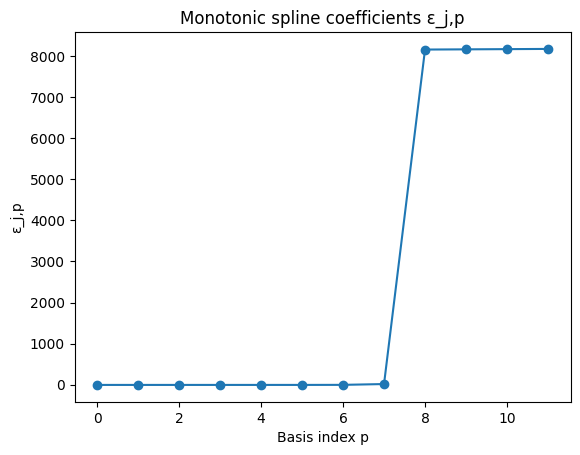

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(eps)), eps, marker='o')
plt.title("Monotonic spline coefficients ε_j,p")
plt.xlabel("Basis index p")
plt.ylabel("ε_j,p")
plt.show()

In [12]:
theta = model.transformation.params[1].detach().cpu()
print(torch.diff(theta))

already_eps = bool(torch.all(torch.diff(theta) > 0))
print("params are already ε:", already_eps)

tensor([-8.5764e-01, -7.7275e-02, -1.0135e-02,  1.8685e-01,  2.2470e+00,
         2.3824e+00,  2.6506e+00,  6.0220e+00, -7.3632e+00,  7.1526e-07,
         0.0000e+00])
params are already ε: False


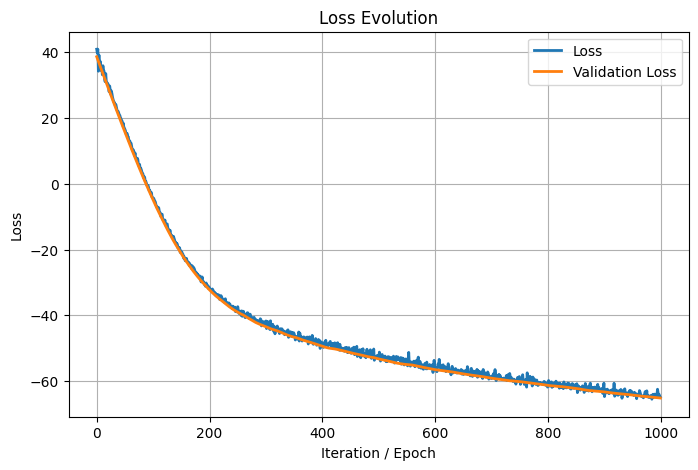

In [13]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

24 24
tensor([-3.4331, -4.8042, -4.8177, -4.8631, -4.9663, -0.8914, -0.5422,  3.1766,
         8.2589,  1.6411,  1.6411,  1.6411, -3.5396, -4.3972, -4.4745, -4.4846,
        -4.2978, -2.0507,  0.3316,  2.9822,  9.0043,  1.6411,  1.6411,  1.6411],
       device='cuda:0')


In [15]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [15]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

: 

: 

: 

In [16]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

: 

: 

: 

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  8.5627
KLD Gaussian Train Data:  0.0983
KLD Copula   Train Data:  -0.0004
KLD GTM      Test  Data:  8.5989
KLD Gaussian Test  Data:  0.1081
KLD Copula   Test  Data:  0.0013


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

ValueError: Contour levels must be increasing

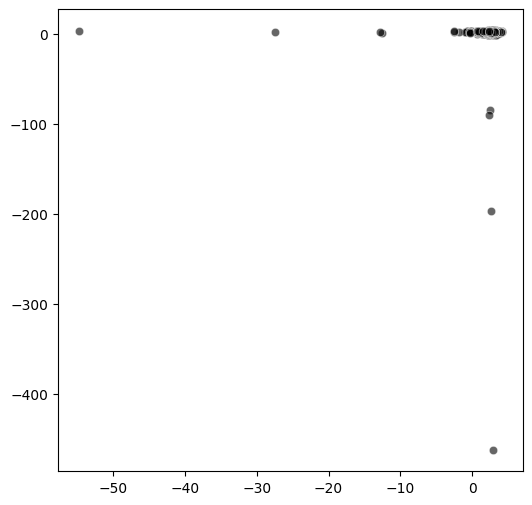

In [21]:
model.plot_densities(synthetic_samples.detach().cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [22]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

In [ ]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


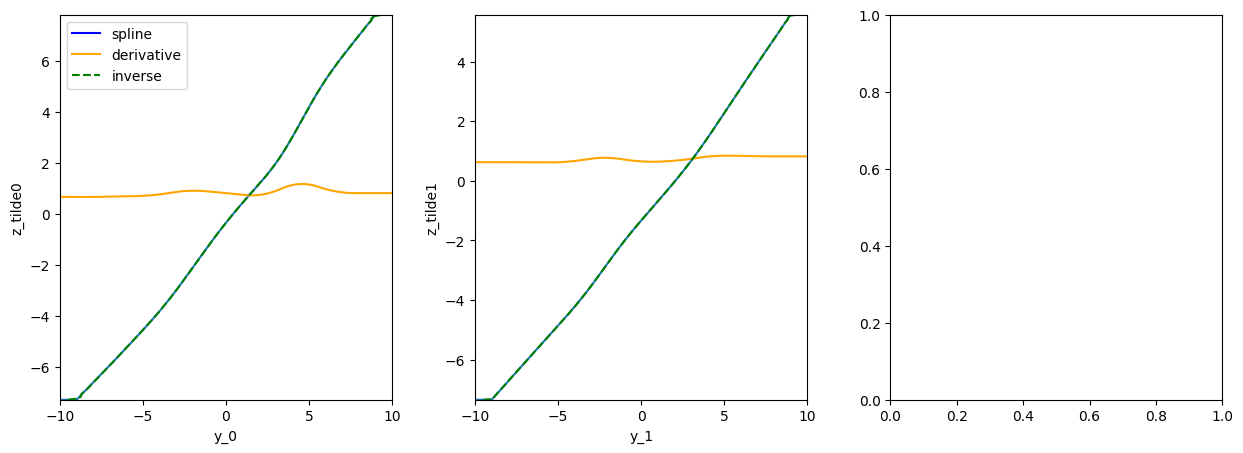

: 

: 

: 

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


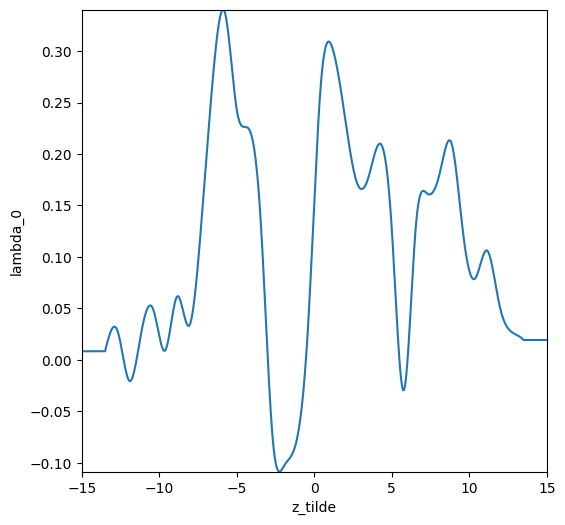

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


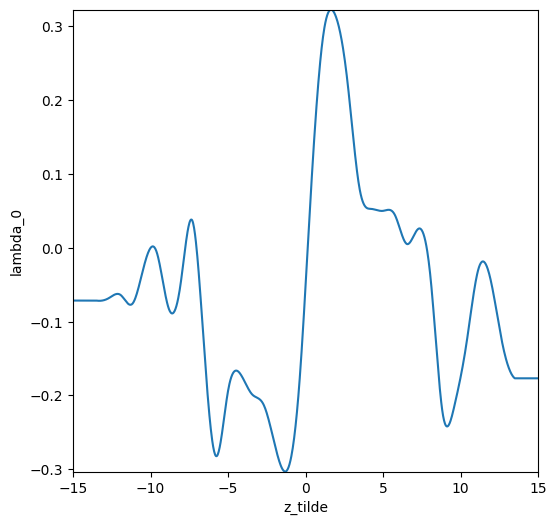

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


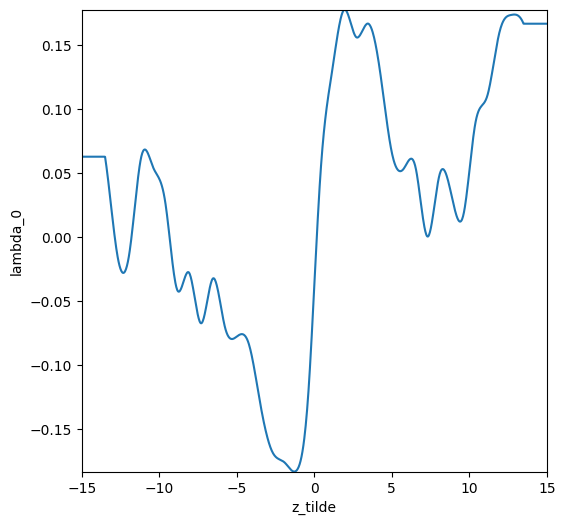

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)